In [1]:
from itertools import islice
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import torch
import torchvision
import time
import datetime

import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import copy

prjt_path = r"D:\JPNB\learning_AIdea2022"
train_data_path = str(prjt_path + r"\train_data")  # 競賽給的資料集
output_path = str(prjt_path + r"\output")

In [2]:
import torch
print(torch.cuda.is_available())

device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

True
Training on device cuda.


## 1.Load the data

In [3]:
ALL_data_path = train_data_path

## 2.Create Dataset

In [4]:
batch_size = 10 # 一個batch有10張圖片
val_size, test_size = 0.1, 0.1  # train:val:test=0.8:0.1:0.1
shuffle_dataset = True
random_seed= 42
transform = transforms.Compose([
    transforms.ToTensor(),  # you can add other transformations in this list
    #transforms.Resize(224),  # but got [3, 298, 224] at entry 0 and [3, 398, 224]
    transforms.Resize(size=(255, 255))
    #transforms.CenterCrop(255)
])

# all training data
dataset = torchvision.datasets.ImageFolder(ALL_data_path, transform=transform, target_transform=None)

## 3.Split Data & Create Dataloader

In [5]:
# Create data indices for train & validatin spilt
# Set seed and shuffle, then spilt data to train, validation, test
dataset_size = len(dataset)
indices = list(range(dataset_size))
val_spilt = int(np.floor(val_size * dataset_size))
test_spilt = val_spilt + int(np.floor(test_size * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices, test_indices = indices[test_spilt:], indices[:val_spilt], indices[val_spilt:test_spilt]
# print(train_indices, val_indices, test_indices)

In [6]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=test_sampler)

In [7]:
print(len(train_loader), len(val_loader), len(test_loader))  # 各自的batch數量
n_total_step = len(train_loader)
print(n_total_step)

dataloaders={}
dataloaders["train"] = train_loader
dataloaders["val"] = val_loader

dataset_sizes = {}
dataset_sizes["train"] = len(train_indices)
dataset_sizes["val"] = len(val_indices)

7162 896 896
7162


## 4.Use Pytorch pretrained model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())  # CUDA is available and can be used by one device.
print(torch.cuda.device(1))
print(torch.cuda.get_device_name(0))

cuda:0
1
NVIDIA GeForce MX250


### 4-1.Set pretrained model

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
            #for i, (inputs, labels) in islice(enumerate(dataloaders[phase]),1,3):
                print("=================="+"Train"+"==================")
                #print("train_batch_number: {}".format(i))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# from torchvision.models import efficientnet, resnet50
model_efficientnet = torchvision.models.efficientnet_v2_l(pretrained=True).to(device) # load pretrained Alexnet model (pretrained weights)
print(model_efficientnet)

C:\ProgramData\Miniconda3\envs\Pytorch_DL\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\ProgramData\Miniconda3\envs\Pytorch_DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
print(model_efficientnet)

In [11]:
print("="*10)
print(model_efficientnet.classifier[1])  # 最後一層分類器

Linear(in_features=1280, out_features=1000, bias=True)


In [12]:
start_time = datetime.datetime.now()
print(start_time)

2022-10-11 22:12:19.890884


In [13]:
# Transfer Learning: (方法_2)ConvNet as fixed feature extractor
for param in model_efficientnet.parameters():
    param.requires_grad = False  # 不自動更新參數:把所有層數都凍結(freeze the weights)
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_efficientnet.classifier[1].in_features  # 最後一層輸入器的輸入維度
model_efficientnet.classifier[1] = torch.nn.Linear(num_ftrs, 33)  # 33: numbers of output class
# model_efficientnet.classifier[6] == model.fc

model_efficientnet = model_efficientnet.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Only parameters of final layer are being optimized 
optimizer_conv = torch.optim.SGD(model_efficientnet.classifier[1].parameters(), lr=0.001, momentum=0.9)  # 只對最後一層參數做更新(指定最後一層:model_conv.fc)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate
# model_efficientnet = train_model("train", model_efficientnet, criterion, optimizer_conv,
#                          exp_lr_scheduler, train_loader, num_epochs=4)

model_efficientnet = train_model(model_efficientnet, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

  0%|                                                                                                                                                              | 0/7162 [00:00<?, ?it/s]

Epoch 0/0
----------
==================Train==================


  0%|                                                                                                                                                   | 1/7162 [00:09<18:20:42,  9.22s/it]

==================Train==================


  0%|                                                                                                                                                   | 2/7162 [00:14<15:42:25,  7.90s/it]

==================Train==================


  0%|                                                                                                                                                   | 3/7162 [00:21<15:17:44,  7.69s/it]

==================Train==================


  0%|                                                                                                                                                   | 4/7162 [00:27<14:19:38,  7.21s/it]

==================Train==================


  0%|                                                                                                                                                   | 5/7162 [00:33<13:47:32,  6.94s/it]

==================Train==================


  0%|                                                                                                                                                   | 6/7162 [00:40<13:45:53,  6.92s/it]

==================Train==================


  0%|▏                                                                                                                                                  | 7/7162 [00:47<13:47:08,  6.94s/it]

==================Train==================


  0%|▏                                                                                                                                                  | 8/7162 [00:51<12:14:48,  6.16s/it]

==================Train==================


  0%|▏                                                                                                                                                  | 9/7162 [00:57<12:01:51,  6.06s/it]

==================Train==================


  0%|▏                                                                                                                                                 | 10/7162 [01:03<11:50:20,  5.96s/it]

==================Train==================


  0%|▏                                                                                                                                                 | 11/7162 [01:09<11:38:32,  5.86s/it]

==================Train==================


  0%|▏                                                                                                                                                 | 12/7162 [01:13<10:52:36,  5.48s/it]

==================Train==================


  0%|▎                                                                                                                                                 | 13/7162 [01:18<10:26:34,  5.26s/it]

==================Train==================


  0%|▎                                                                                                                                                  | 14/7162 [01:22<9:47:42,  4.93s/it]

==================Train==================


  0%|▎                                                                                                                                                  | 15/7162 [01:26<9:13:06,  4.64s/it]

==================Train==================


  0%|▎                                                                                                                                                  | 16/7162 [01:30<9:05:01,  4.58s/it]

==================Train==================


  0%|▎                                                                                                                                                  | 17/7162 [01:35<9:01:11,  4.54s/it]

==================Train==================


  0%|▎                                                                                                                                                  | 18/7162 [01:40<9:35:59,  4.84s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 19/7162 [01:44<9:09:26,  4.62s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 20/7162 [01:48<8:14:50,  4.16s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 21/7162 [01:52<8:30:28,  4.29s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 22/7162 [01:58<9:31:41,  4.80s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 23/7162 [02:02<9:01:41,  4.55s/it]

==================Train==================


  0%|▍                                                                                                                                                  | 24/7162 [02:08<9:39:13,  4.87s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 25/7162 [02:12<9:00:42,  4.55s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 26/7162 [02:17<9:47:50,  4.94s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 27/7162 [02:22<9:47:56,  4.94s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 28/7162 [02:27<9:44:48,  4.92s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 29/7162 [02:31<9:04:20,  4.58s/it]

==================Train==================


  0%|▌                                                                                                                                                  | 30/7162 [02:35<8:42:04,  4.39s/it]

==================Train==================


  0%|▋                                                                                                                                                  | 31/7162 [02:41<9:25:05,  4.75s/it]

==================Train==================


  0%|▋                                                                                                                                                  | 32/7162 [02:45<9:16:55,  4.69s/it]

==================Train==================


  0%|▋                                                                                                                                                  | 33/7162 [02:49<8:50:50,  4.47s/it]

==================Train==================


  0%|▋                                                                                                                                                  | 34/7162 [02:53<8:40:08,  4.38s/it]

==================Train==================


  0%|▋                                                                                                                                                  | 35/7162 [02:58<8:38:12,  4.36s/it]

==================Train==================


  1%|▋                                                                                                                                                  | 36/7162 [03:02<8:36:28,  4.35s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 37/7162 [03:06<8:27:58,  4.28s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 38/7162 [03:10<8:12:43,  4.15s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 39/7162 [03:14<8:25:13,  4.26s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 40/7162 [03:18<8:08:20,  4.11s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 41/7162 [03:23<8:31:24,  4.31s/it]

==================Train==================


  1%|▊                                                                                                                                                  | 42/7162 [03:27<8:22:27,  4.23s/it]

==================Train==================


  1%|▉                                                                                                                                                  | 43/7162 [03:32<8:46:47,  4.44s/it]

==================Train==================


  1%|▉                                                                                                                                                  | 44/7162 [03:37<9:00:38,  4.56s/it]

==================Train==================


  1%|▉                                                                                                                                                  | 45/7162 [03:41<8:49:57,  4.47s/it]

==================Train==================


  1%|▉                                                                                                                                                  | 46/7162 [03:47<9:31:12,  4.82s/it]

==================Train==================


  1%|▉                                                                                                                                                 | 47/7162 [03:52<10:08:18,  5.13s/it]

==================Train==================


  1%|▉                                                                                                                                                 | 48/7162 [03:58<10:10:25,  5.15s/it]

==================Train==================


  1%|█                                                                                                                                                  | 49/7162 [04:02<9:50:59,  4.99s/it]

==================Train==================


  1%|█                                                                                                                                                  | 50/7162 [04:07<9:46:09,  4.95s/it]

==================Train==================


  1%|█                                                                                                                                                  | 51/7162 [04:12<9:57:34,  5.04s/it]

==================Train==================


  1%|█                                                                                                                                                  | 52/7162 [04:16<8:57:03,  4.53s/it]

==================Train==================


  1%|█                                                                                                                                                  | 53/7162 [04:20<8:37:03,  4.36s/it]

==================Train==================


  1%|█                                                                                                                                                  | 54/7162 [04:25<9:12:37,  4.66s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 55/7162 [04:29<9:03:55,  4.59s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 56/7162 [04:33<8:42:10,  4.41s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 57/7162 [04:39<9:10:21,  4.65s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 58/7162 [04:44<9:50:00,  4.98s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 59/7162 [04:49<9:51:34,  5.00s/it]

==================Train==================


  1%|█▏                                                                                                                                                 | 60/7162 [04:54<9:46:58,  4.96s/it]

==================Train==================


  1%|█▏                                                                                                                                                | 61/7162 [05:00<10:20:36,  5.24s/it]

==================Train==================


  1%|█▎                                                                                                                                                | 62/7162 [05:05<10:19:11,  5.23s/it]

==================Train==================


  1%|█▎                                                                                                                                                | 63/7162 [05:10<10:04:48,  5.11s/it]

==================Train==================


  1%|█▎                                                                                                                                                | 64/7162 [05:16<10:09:43,  5.15s/it]

==================Train==================


  1%|█▎                                                                                                                                                 | 65/7162 [05:20<9:42:00,  4.92s/it]

==================Train==================


  1%|█▎                                                                                                                                                 | 66/7162 [05:25<9:38:16,  4.89s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 67/7162 [05:29<9:34:24,  4.86s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 68/7162 [05:34<9:29:31,  4.82s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 69/7162 [05:38<9:05:42,  4.62s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 70/7162 [05:43<9:05:20,  4.61s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 71/7162 [05:48<9:32:47,  4.85s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 72/7162 [05:52<9:07:21,  4.63s/it]

==================Train==================


  1%|█▍                                                                                                                                                 | 73/7162 [05:57<8:46:04,  4.45s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 74/7162 [06:01<8:56:04,  4.54s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 75/7162 [06:07<9:25:33,  4.79s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 76/7162 [06:10<8:41:16,  4.41s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 77/7162 [06:15<8:42:15,  4.42s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 78/7162 [06:19<8:43:19,  4.43s/it]

==================Train==================


  1%|█▌                                                                                                                                                 | 79/7162 [06:23<8:16:13,  4.20s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 80/7162 [06:27<8:23:52,  4.27s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 81/7162 [06:32<8:35:42,  4.37s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 82/7162 [06:35<8:02:25,  4.09s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 83/7162 [06:40<8:15:13,  4.20s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 84/7162 [06:43<7:56:16,  4.04s/it]

==================Train==================


  1%|█▋                                                                                                                                                 | 85/7162 [06:49<8:44:44,  4.45s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 86/7162 [06:54<9:07:15,  4.64s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 87/7162 [06:58<8:53:46,  4.53s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 88/7162 [07:03<9:06:22,  4.63s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 89/7162 [07:08<9:18:20,  4.74s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 90/7162 [07:13<9:27:49,  4.82s/it]

==================Train==================


  1%|█▊                                                                                                                                                 | 91/7162 [07:17<9:09:09,  4.66s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 92/7162 [07:21<8:24:17,  4.28s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 93/7162 [07:25<8:22:21,  4.26s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 94/7162 [07:30<8:52:30,  4.52s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 95/7162 [07:35<9:09:17,  4.66s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 96/7162 [07:39<9:01:56,  4.60s/it]

==================Train==================


  1%|█▉                                                                                                                                                 | 97/7162 [07:45<9:19:14,  4.75s/it]

==================Train==================


  1%|██                                                                                                                                                 | 98/7162 [07:49<8:58:32,  4.57s/it]

==================Train==================


  1%|██                                                                                                                                                 | 99/7162 [07:54<9:15:18,  4.72s/it]

==================Train==================


  1%|██                                                                                                                                                | 100/7162 [07:58<8:59:55,  4.59s/it]

==================Train==================


  1%|██                                                                                                                                                | 101/7162 [08:02<8:46:35,  4.47s/it]

==================Train==================


  1%|██                                                                                                                                                | 102/7162 [08:06<8:32:54,  4.36s/it]

==================Train==================


  1%|██                                                                                                                                                | 103/7162 [08:11<8:49:13,  4.50s/it]

==================Train==================


  1%|██                                                                                                                                                | 104/7162 [08:17<9:45:00,  4.97s/it]

==================Train==================


  1%|██▏                                                                                                                                               | 105/7162 [08:22<9:37:00,  4.91s/it]

==================Train==================


  1%|██▏                                                                                                                                               | 106/7162 [08:27<9:28:46,  4.84s/it]

==================Train==================


  1%|██▏                                                                                                                                               | 107/7162 [08:31<9:11:56,  4.69s/it]

==================Train==================


  2%|██▏                                                                                                                                               | 108/7162 [08:34<8:25:08,  4.30s/it]

==================Train==================


  2%|██▏                                                                                                                                               | 109/7162 [08:39<8:26:40,  4.31s/it]

==================Train==================


  2%|██▏                                                                                                                                               | 110/7162 [08:43<8:17:02,  4.23s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 111/7162 [08:47<8:18:11,  4.24s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 112/7162 [08:51<8:18:16,  4.24s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 113/7162 [08:57<9:10:34,  4.69s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 114/7162 [09:01<8:42:40,  4.45s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 115/7162 [09:06<9:13:16,  4.71s/it]

==================Train==================


  2%|██▎                                                                                                                                               | 116/7162 [09:11<9:08:55,  4.67s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 117/7162 [09:15<9:01:17,  4.61s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 118/7162 [09:20<9:16:38,  4.74s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 119/7162 [09:26<9:49:41,  5.02s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 120/7162 [09:31<9:32:49,  4.88s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 121/7162 [09:34<8:39:06,  4.42s/it]

==================Train==================


  2%|██▍                                                                                                                                               | 122/7162 [09:39<8:46:56,  4.49s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 123/7162 [09:44<9:32:58,  4.88s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 124/7162 [09:49<9:19:28,  4.77s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 125/7162 [09:53<9:11:45,  4.70s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 126/7162 [09:58<8:51:02,  4.53s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 127/7162 [10:02<8:36:35,  4.41s/it]

==================Train==================


  2%|██▌                                                                                                                                               | 128/7162 [10:06<8:30:33,  4.36s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 129/7162 [10:11<8:51:01,  4.53s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 130/7162 [10:15<8:47:14,  4.50s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 131/7162 [10:20<8:55:53,  4.57s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 132/7162 [10:23<8:17:48,  4.25s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 133/7162 [10:28<8:35:05,  4.40s/it]

==================Train==================


  2%|██▋                                                                                                                                               | 134/7162 [10:33<8:40:04,  4.44s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 135/7162 [10:37<8:28:35,  4.34s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 136/7162 [10:43<9:23:27,  4.81s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 137/7162 [10:46<8:17:07,  4.25s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 138/7162 [10:49<7:47:42,  4.00s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 139/7162 [10:53<7:50:56,  4.02s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 140/7162 [10:58<8:05:25,  4.15s/it]

==================Train==================


  2%|██▊                                                                                                                                               | 141/7162 [11:02<8:27:40,  4.34s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 142/7162 [11:07<8:27:11,  4.34s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 143/7162 [11:13<9:26:12,  4.84s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 144/7162 [11:18<9:28:02,  4.86s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 145/7162 [11:22<9:00:40,  4.62s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 146/7162 [11:27<9:11:35,  4.72s/it]

==================Train==================


  2%|██▉                                                                                                                                               | 147/7162 [11:33<9:55:15,  5.09s/it]

==================Train==================


  2%|██▉                                                                                                                                              | 148/7162 [11:39<10:28:21,  5.38s/it]

==================Train==================


  2%|███                                                                                                                                              | 149/7162 [11:44<10:22:02,  5.32s/it]

==================Train==================


  2%|███                                                                                                                                              | 150/7162 [11:50<10:38:42,  5.47s/it]

==================Train==================


  2%|███                                                                                                                                              | 151/7162 [11:55<10:43:21,  5.51s/it]

==================Train==================


  2%|███                                                                                                                                              | 152/7162 [12:00<10:13:05,  5.25s/it]

==================Train==================


  2%|███                                                                                                                                               | 153/7162 [12:04<9:48:06,  5.03s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 154/7162 [12:08<9:05:58,  4.67s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 155/7162 [12:13<9:22:47,  4.82s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 156/7162 [12:18<9:06:46,  4.68s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 157/7162 [12:22<8:55:18,  4.59s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 158/7162 [12:28<9:54:48,  5.10s/it]

==================Train==================


  2%|███▏                                                                                                                                              | 159/7162 [12:32<9:06:06,  4.68s/it]

==================Train==================


  2%|███▎                                                                                                                                              | 160/7162 [12:38<9:54:45,  5.10s/it]

==================Train==================


  2%|███▎                                                                                                                                             | 161/7162 [12:44<10:08:17,  5.21s/it]

==================Train==================


  2%|███▎                                                                                                                                             | 162/7162 [12:49<10:13:05,  5.26s/it]

==================Train==================


  2%|███▎                                                                                                                                             | 163/7162 [12:56<10:58:36,  5.65s/it]

==================Train==================


  2%|███▎                                                                                                                                             | 164/7162 [13:00<10:15:46,  5.28s/it]

==================Train==================


  2%|███▎                                                                                                                                              | 165/7162 [13:04<9:26:25,  4.86s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 166/7162 [13:08<9:13:06,  4.74s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 167/7162 [13:13<8:58:42,  4.62s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 168/7162 [13:17<8:51:47,  4.56s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 169/7162 [13:22<9:06:42,  4.69s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 170/7162 [13:27<9:04:45,  4.67s/it]

==================Train==================


  2%|███▍                                                                                                                                              | 171/7162 [13:30<8:29:11,  4.37s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 172/7162 [13:34<8:09:46,  4.20s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 173/7162 [13:39<8:22:59,  4.32s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 174/7162 [13:43<8:09:54,  4.21s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 175/7162 [13:47<8:11:39,  4.22s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 176/7162 [13:53<8:54:52,  4.59s/it]

==================Train==================


  2%|███▌                                                                                                                                              | 177/7162 [13:57<8:33:44,  4.41s/it]

==================Train==================


  2%|███▋                                                                                                                                              | 178/7162 [14:01<8:23:09,  4.32s/it]

==================Train==================


  2%|███▋                                                                                                                                              | 179/7162 [14:06<8:49:18,  4.55s/it]

==================Train==================


  3%|███▋                                                                                                                                              | 180/7162 [14:09<8:17:08,  4.27s/it]

==================Train==================


  3%|███▋                                                                                                                                              | 181/7162 [14:14<8:26:30,  4.35s/it]

==================Train==================


  3%|███▋                                                                                                                                              | 182/7162 [14:18<8:23:29,  4.33s/it]

==================Train==================


  3%|███▋                                                                                                                                              | 183/7162 [14:23<8:57:44,  4.62s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 184/7162 [14:28<8:41:50,  4.49s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 185/7162 [14:32<8:25:52,  4.35s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 186/7162 [14:35<8:01:54,  4.14s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 187/7162 [14:41<8:57:25,  4.62s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 188/7162 [14:46<9:07:59,  4.71s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 189/7162 [14:50<8:55:27,  4.61s/it]

==================Train==================


  3%|███▊                                                                                                                                              | 190/7162 [14:55<9:11:31,  4.75s/it]

==================Train==================


  3%|███▊                                                                                                                                             | 191/7162 [15:02<10:13:32,  5.28s/it]

==================Train==================


  3%|███▉                                                                                                                                             | 192/7162 [15:07<10:09:48,  5.25s/it]

==================Train==================


  3%|███▉                                                                                                                                              | 193/7162 [15:11<9:15:39,  4.78s/it]

==================Train==================


  3%|███▉                                                                                                                                              | 194/7162 [15:16<9:22:35,  4.84s/it]

==================Train==================


  3%|███▉                                                                                                                                              | 195/7162 [15:20<9:17:41,  4.80s/it]

==================Train==================


  3%|███▉                                                                                                                                              | 196/7162 [15:25<9:09:37,  4.73s/it]

==================Train==================


  3%|████                                                                                                                                              | 197/7162 [15:29<8:50:00,  4.57s/it]

==================Train==================


  3%|████                                                                                                                                              | 198/7162 [15:33<8:32:31,  4.42s/it]

==================Train==================


  3%|████                                                                                                                                              | 199/7162 [15:37<8:20:15,  4.31s/it]

==================Train==================


  3%|████                                                                                                                                              | 200/7162 [15:41<8:05:23,  4.18s/it]

==================Train==================


  3%|████                                                                                                                                              | 201/7162 [15:47<8:42:04,  4.50s/it]

==================Train==================


  3%|████                                                                                                                                              | 202/7162 [15:51<8:34:50,  4.44s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 203/7162 [15:56<8:48:30,  4.56s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 204/7162 [15:59<8:11:53,  4.24s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 205/7162 [16:04<8:36:12,  4.45s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 206/7162 [16:08<8:09:47,  4.22s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 207/7162 [16:12<8:21:51,  4.33s/it]

==================Train==================


  3%|████▏                                                                                                                                             | 208/7162 [16:17<8:25:04,  4.36s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 209/7162 [16:21<8:07:55,  4.21s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 210/7162 [16:26<8:52:04,  4.59s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 211/7162 [16:32<9:38:11,  4.99s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 212/7162 [16:36<9:13:28,  4.78s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 213/7162 [16:42<9:32:20,  4.94s/it]

==================Train==================


  3%|████▎                                                                                                                                             | 214/7162 [16:46<9:10:29,  4.75s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 215/7162 [16:51<9:10:06,  4.75s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 216/7162 [16:54<8:35:30,  4.45s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 217/7162 [16:59<8:24:08,  4.36s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 218/7162 [17:04<9:10:50,  4.76s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 219/7162 [17:09<9:20:03,  4.84s/it]

==================Train==================


  3%|████▍                                                                                                                                             | 220/7162 [17:15<9:39:43,  5.01s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 221/7162 [17:19<9:10:07,  4.76s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 222/7162 [17:24<9:18:45,  4.83s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 223/7162 [17:30<9:47:04,  5.08s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 224/7162 [17:34<9:29:06,  4.92s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 225/7162 [17:39<9:15:35,  4.81s/it]

==================Train==================


  3%|████▌                                                                                                                                             | 226/7162 [17:43<9:00:18,  4.67s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 227/7162 [17:47<8:38:37,  4.49s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 228/7162 [17:53<9:12:04,  4.78s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 229/7162 [17:56<8:38:51,  4.49s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 230/7162 [18:02<9:21:59,  4.86s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 231/7162 [18:07<9:35:43,  4.98s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 232/7162 [18:12<9:31:58,  4.95s/it]

==================Train==================


  3%|████▋                                                                                                                                             | 233/7162 [18:17<9:34:53,  4.98s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 234/7162 [18:22<9:16:20,  4.82s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 235/7162 [18:26<8:53:54,  4.62s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 236/7162 [18:31<8:55:36,  4.64s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 237/7162 [18:35<8:37:03,  4.48s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 238/7162 [18:39<8:16:33,  4.30s/it]

==================Train==================


  3%|████▊                                                                                                                                             | 239/7162 [18:44<8:47:03,  4.57s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 240/7162 [18:50<9:34:36,  4.98s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 241/7162 [18:54<9:22:45,  4.88s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 242/7162 [18:59<9:07:54,  4.75s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 243/7162 [19:04<9:32:35,  4.97s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 244/7162 [19:09<9:18:53,  4.85s/it]

==================Train==================


  3%|████▉                                                                                                                                             | 245/7162 [19:13<9:04:34,  4.72s/it]

==================Train==================


  3%|█████                                                                                                                                             | 246/7162 [19:19<9:23:10,  4.89s/it]

==================Train==================


  3%|█████                                                                                                                                             | 247/7162 [19:23<9:09:37,  4.77s/it]

==================Train==================


  3%|█████                                                                                                                                             | 248/7162 [19:26<8:16:50,  4.31s/it]

==================Train==================


  3%|█████                                                                                                                                             | 249/7162 [19:30<8:11:37,  4.27s/it]

==================Train==================


  3%|█████                                                                                                                                             | 250/7162 [19:34<8:01:01,  4.18s/it]

==================Train==================


  4%|█████                                                                                                                                             | 251/7162 [19:40<9:05:46,  4.74s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 252/7162 [19:45<9:10:58,  4.78s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 253/7162 [19:50<8:56:16,  4.66s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 254/7162 [19:55<9:12:21,  4.80s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 255/7162 [20:00<9:11:20,  4.79s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 256/7162 [20:04<8:53:36,  4.64s/it]

==================Train==================


  4%|█████▏                                                                                                                                            | 257/7162 [20:09<9:16:08,  4.83s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 258/7162 [20:14<9:02:25,  4.71s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 259/7162 [20:18<8:59:54,  4.69s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 260/7162 [20:23<8:54:27,  4.65s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 261/7162 [20:28<9:10:58,  4.79s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 262/7162 [20:33<9:15:18,  4.83s/it]

==================Train==================


  4%|█████▎                                                                                                                                            | 263/7162 [20:38<9:25:34,  4.92s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 264/7162 [20:42<9:04:50,  4.74s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 265/7162 [20:47<8:57:23,  4.68s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 266/7162 [20:51<8:53:34,  4.64s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 267/7162 [20:56<9:01:29,  4.71s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 268/7162 [21:00<8:26:25,  4.41s/it]

==================Train==================


  4%|█████▍                                                                                                                                            | 269/7162 [21:04<8:12:01,  4.28s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 270/7162 [21:09<8:26:04,  4.41s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 271/7162 [21:13<8:31:59,  4.46s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 272/7162 [21:17<8:27:12,  4.42s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 273/7162 [21:22<8:32:34,  4.46s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 274/7162 [21:27<8:35:07,  4.49s/it]

==================Train==================


  4%|█████▌                                                                                                                                            | 275/7162 [21:31<8:20:33,  4.36s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 276/7162 [21:35<8:10:58,  4.28s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 277/7162 [21:39<8:05:31,  4.23s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 278/7162 [21:44<8:45:39,  4.58s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 279/7162 [21:49<9:00:05,  4.71s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 280/7162 [21:53<8:37:24,  4.51s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 281/7162 [21:58<8:55:45,  4.67s/it]

==================Train==================


  4%|█████▋                                                                                                                                            | 282/7162 [22:05<9:49:05,  5.14s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 283/7162 [22:09<9:22:42,  4.91s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 284/7162 [22:13<8:56:45,  4.68s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 285/7162 [22:17<8:31:59,  4.47s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 286/7162 [22:22<8:57:38,  4.69s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 287/7162 [22:27<8:43:06,  4.57s/it]

==================Train==================


  4%|█████▊                                                                                                                                            | 288/7162 [22:30<7:57:36,  4.17s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 289/7162 [22:34<8:11:29,  4.29s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 290/7162 [22:39<8:19:12,  4.36s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 291/7162 [22:44<8:54:21,  4.67s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 292/7162 [22:49<9:11:47,  4.82s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 293/7162 [22:54<9:14:25,  4.84s/it]

==================Train==================


  4%|█████▉                                                                                                                                            | 294/7162 [22:59<9:02:38,  4.74s/it]

==================Train==================


  4%|██████                                                                                                                                            | 295/7162 [23:03<8:36:30,  4.51s/it]

==================Train==================


  4%|██████                                                                                                                                            | 296/7162 [23:08<9:06:35,  4.78s/it]

==================Train==================


  4%|██████                                                                                                                                            | 297/7162 [23:14<9:39:39,  5.07s/it]

==================Train==================


  4%|██████                                                                                                                                           | 298/7162 [23:20<10:03:09,  5.27s/it]

==================Train==================


  4%|██████                                                                                                                                            | 299/7162 [23:24<9:28:13,  4.97s/it]

==================Train==================


  4%|██████                                                                                                                                            | 300/7162 [23:29<9:21:39,  4.91s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 301/7162 [23:34<9:39:13,  5.07s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 302/7162 [23:40<9:47:27,  5.14s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 303/7162 [23:44<9:12:28,  4.83s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 304/7162 [23:48<8:58:47,  4.71s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 305/7162 [23:53<9:19:14,  4.89s/it]

==================Train==================


  4%|██████▏                                                                                                                                           | 306/7162 [23:59<9:29:09,  4.98s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 307/7162 [24:03<9:24:32,  4.94s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 308/7162 [24:08<9:10:57,  4.82s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 309/7162 [24:13<9:30:50,  5.00s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 310/7162 [24:19<9:35:16,  5.04s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 311/7162 [24:23<9:03:14,  4.76s/it]

==================Train==================


  4%|██████▎                                                                                                                                           | 312/7162 [24:27<8:40:06,  4.56s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 313/7162 [24:31<8:47:45,  4.62s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 314/7162 [24:36<8:36:29,  4.53s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 315/7162 [24:41<9:02:04,  4.75s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 316/7162 [24:46<8:54:40,  4.69s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 317/7162 [24:49<8:23:08,  4.41s/it]

==================Train==================


  4%|██████▍                                                                                                                                           | 318/7162 [24:54<8:34:32,  4.51s/it]

==================Train==================


  4%|██████▌                                                                                                                                           | 319/7162 [24:59<8:49:38,  4.64s/it]

==================Train==================


  4%|██████▌                                                                                                                                           | 320/7162 [25:04<8:51:46,  4.66s/it]

==================Train==================


  4%|██████▌                                                                                                                                           | 321/7162 [25:09<9:00:29,  4.74s/it]

==================Train==================


  4%|██████▌                                                                                                                                           | 322/7162 [25:14<9:29:17,  4.99s/it]

==================Train==================


  5%|██████▌                                                                                                                                           | 323/7162 [25:19<9:14:24,  4.86s/it]

==================Train==================


  5%|██████▌                                                                                                                                           | 324/7162 [25:25<9:53:00,  5.20s/it]

==================Train==================


  5%|██████▌                                                                                                                                          | 325/7162 [25:30<10:03:18,  5.29s/it]

==================Train==================


  5%|██████▌                                                                                                                                          | 326/7162 [25:36<10:25:58,  5.49s/it]

==================Train==================


  5%|██████▌                                                                                                                                          | 327/7162 [25:42<10:33:18,  5.56s/it]

==================Train==================


  5%|██████▋                                                                                                                                          | 328/7162 [25:49<11:18:04,  5.95s/it]

==================Train==================


  5%|██████▋                                                                                                                                          | 329/7162 [25:53<10:28:36,  5.52s/it]

==================Train==================


  5%|██████▋                                                                                                                                          | 330/7162 [25:59<10:28:28,  5.52s/it]

==================Train==================


  5%|██████▋                                                                                                                                          | 331/7162 [26:04<10:27:13,  5.51s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 332/7162 [26:09<9:57:21,  5.25s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 333/7162 [26:14<9:32:52,  5.03s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 334/7162 [26:19<9:33:21,  5.04s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 335/7162 [26:22<8:48:20,  4.64s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 336/7162 [26:27<8:35:41,  4.53s/it]

==================Train==================


  5%|██████▊                                                                                                                                           | 337/7162 [26:32<8:48:21,  4.64s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 338/7162 [26:36<8:53:45,  4.69s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 339/7162 [26:42<9:20:31,  4.93s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 340/7162 [26:46<8:43:09,  4.60s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 341/7162 [26:50<8:42:35,  4.60s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 342/7162 [26:55<8:48:58,  4.65s/it]

==================Train==================


  5%|██████▉                                                                                                                                           | 343/7162 [27:00<8:44:57,  4.62s/it]

==================Train==================


  5%|███████                                                                                                                                           | 344/7162 [27:04<8:53:48,  4.70s/it]

==================Train==================


  5%|███████                                                                                                                                           | 345/7162 [27:10<9:24:48,  4.97s/it]

==================Train==================


  5%|███████                                                                                                                                           | 346/7162 [27:15<9:16:02,  4.89s/it]

==================Train==================


  5%|███████                                                                                                                                           | 347/7162 [27:19<8:45:38,  4.63s/it]

==================Train==================


  5%|███████                                                                                                                                           | 348/7162 [27:23<8:41:42,  4.59s/it]

==================Train==================


  5%|███████                                                                                                                                           | 349/7162 [27:27<8:24:53,  4.45s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 350/7162 [27:32<8:39:49,  4.58s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 351/7162 [27:37<8:32:56,  4.52s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 352/7162 [27:43<9:26:32,  4.99s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 353/7162 [27:48<9:19:47,  4.93s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 354/7162 [27:53<9:28:30,  5.01s/it]

==================Train==================


  5%|███████▏                                                                                                                                          | 355/7162 [27:58<9:24:28,  4.98s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 356/7162 [28:02<9:10:08,  4.85s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 357/7162 [28:06<8:23:44,  4.44s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 358/7162 [28:10<8:12:28,  4.34s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 359/7162 [28:14<8:20:35,  4.42s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 360/7162 [28:19<8:14:44,  4.36s/it]

==================Train==================


  5%|███████▎                                                                                                                                          | 361/7162 [28:23<8:01:03,  4.24s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 362/7162 [28:26<7:37:24,  4.04s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 363/7162 [28:30<7:22:02,  3.90s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 364/7162 [28:33<7:09:19,  3.79s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 365/7162 [28:38<7:33:06,  4.00s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 366/7162 [28:42<7:35:22,  4.02s/it]

==================Train==================


  5%|███████▍                                                                                                                                          | 367/7162 [28:47<8:06:26,  4.30s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 368/7162 [28:50<7:33:37,  4.01s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 369/7162 [28:55<7:55:56,  4.20s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 370/7162 [29:00<8:15:59,  4.38s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 371/7162 [29:04<8:17:33,  4.40s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 372/7162 [29:09<8:51:32,  4.70s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 373/7162 [29:13<8:23:27,  4.45s/it]

==================Train==================


  5%|███████▌                                                                                                                                          | 374/7162 [29:17<7:55:38,  4.20s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 375/7162 [29:21<8:00:39,  4.25s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 376/7162 [29:26<8:34:23,  4.55s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 377/7162 [29:31<8:39:54,  4.60s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 378/7162 [29:35<8:15:34,  4.38s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 379/7162 [29:39<8:11:40,  4.35s/it]

==================Train==================


  5%|███████▋                                                                                                                                          | 380/7162 [29:44<8:30:51,  4.52s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 381/7162 [29:49<8:22:37,  4.45s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 382/7162 [29:54<8:59:04,  4.77s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 383/7162 [29:59<9:01:55,  4.80s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 384/7162 [30:03<8:44:32,  4.64s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 385/7162 [30:08<8:50:53,  4.70s/it]

==================Train==================


  5%|███████▊                                                                                                                                          | 386/7162 [30:13<8:48:30,  4.68s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 387/7162 [30:17<8:31:23,  4.53s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 388/7162 [30:21<8:02:43,  4.28s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 389/7162 [30:25<8:10:31,  4.35s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 390/7162 [30:29<7:56:34,  4.22s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 391/7162 [30:33<8:04:58,  4.30s/it]

==================Train==================


  5%|███████▉                                                                                                                                          | 392/7162 [30:40<9:18:26,  4.95s/it]

==================Train==================


  5%|████████                                                                                                                                          | 393/7162 [30:43<8:28:32,  4.51s/it]

==================Train==================


  6%|████████                                                                                                                                          | 394/7162 [30:49<8:51:04,  4.71s/it]

==================Train==================


  6%|████████                                                                                                                                          | 395/7162 [30:53<8:45:05,  4.66s/it]

==================Train==================


  6%|████████                                                                                                                                          | 396/7162 [30:58<8:41:30,  4.62s/it]

==================Train==================


  6%|████████                                                                                                                                          | 397/7162 [31:03<9:10:46,  4.88s/it]

==================Train==================


  6%|████████                                                                                                                                          | 398/7162 [31:08<8:59:47,  4.79s/it]

==================Train==================


  6%|████████▏                                                                                                                                         | 399/7162 [31:12<8:46:12,  4.67s/it]

==================Train==================


  6%|████████▏                                                                                                                                         | 400/7162 [31:17<8:47:54,  4.68s/it]

==================Train==================


  6%|████████▏                                                                                                                                         | 401/7162 [31:22<8:54:52,  4.75s/it]

==================Train==================


  6%|████████▏                                                                                                                                         | 402/7162 [31:28<9:47:44,  5.22s/it]

==================Train==================


  6%|████████▏                                                                                                                                         | 403/7162 [31:33<9:28:22,  5.05s/it]

==================Train==================


  6%|████████▏                                                                                                                                        | 404/7162 [31:39<10:13:18,  5.45s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 405/7162 [31:43<9:39:26,  5.15s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 406/7162 [31:48<9:01:58,  4.81s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 407/7162 [31:53<9:09:15,  4.88s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 408/7162 [31:56<8:30:46,  4.54s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 409/7162 [32:02<9:21:36,  4.99s/it]

==================Train==================


  6%|████████▎                                                                                                                                         | 410/7162 [32:07<9:18:20,  4.96s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 411/7162 [32:12<9:13:14,  4.92s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 412/7162 [32:17<9:17:26,  4.96s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 413/7162 [32:21<8:54:54,  4.76s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 414/7162 [32:26<8:36:37,  4.59s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 415/7162 [32:31<9:01:46,  4.82s/it]

==================Train==================


  6%|████████▍                                                                                                                                         | 416/7162 [32:36<9:02:23,  4.82s/it]

==================Train==================


  6%|████████▌                                                                                                                                         | 417/7162 [32:41<9:30:19,  5.07s/it]

==================Train==================


  6%|████████▌                                                                                                                                         | 418/7162 [32:47<9:41:23,  5.17s/it]

==================Train==================


  6%|████████▍                                                                                                                                        | 419/7162 [32:53<10:06:04,  5.39s/it]

==================Train==================


  6%|████████▌                                                                                                                                         | 420/7162 [32:57<9:21:16,  4.99s/it]

==================Train==================


  6%|████████▌                                                                                                                                         | 421/7162 [33:03<9:45:44,  5.21s/it]

==================Train==================


  6%|████████▌                                                                                                                                         | 422/7162 [33:08<9:40:56,  5.17s/it]

==================Train==================


  6%|████████▌                                                                                                                                        | 423/7162 [33:13<10:02:45,  5.37s/it]

==================Train==================


  6%|████████▋                                                                                                                                         | 424/7162 [33:18<9:49:46,  5.25s/it]

==================Train==================


  6%|████████▋                                                                                                                                         | 425/7162 [33:24<9:47:36,  5.23s/it]

==================Train==================


  6%|████████▌                                                                                                                                        | 426/7162 [33:31<11:00:40,  5.88s/it]

==================Train==================


  6%|████████▋                                                                                                                                        | 427/7162 [33:37<11:13:31,  6.00s/it]

==================Train==================


  6%|████████▋                                                                                                                                        | 428/7162 [33:45<12:09:17,  6.50s/it]

==================Train==================


  6%|████████▋                                                                                                                                        | 429/7162 [33:50<11:05:49,  5.93s/it]

==================Train==================


  6%|████████▋                                                                                                                                        | 430/7162 [33:54<10:27:42,  5.59s/it]

==================Train==================


  6%|████████▋                                                                                                                                        | 431/7162 [33:59<10:05:40,  5.40s/it]

==================Train==================


  6%|████████▊                                                                                                                                         | 432/7162 [34:04<9:52:46,  5.28s/it]

==================Train==================


  6%|████████▊                                                                                                                                         | 433/7162 [34:08<9:03:28,  4.85s/it]

==================Train==================


  6%|████████▊                                                                                                                                         | 434/7162 [34:13<9:16:22,  4.96s/it]

==================Train==================


  6%|████████▊                                                                                                                                         | 435/7162 [34:18<9:02:57,  4.84s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 436/7162 [34:22<8:39:34,  4.63s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 437/7162 [34:26<8:25:12,  4.51s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 438/7162 [34:31<8:19:42,  4.46s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 439/7162 [34:35<8:31:35,  4.57s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 440/7162 [34:42<9:35:48,  5.14s/it]

==================Train==================


  6%|████████▉                                                                                                                                         | 441/7162 [34:47<9:18:32,  4.99s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 442/7162 [34:51<8:53:38,  4.76s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 443/7162 [34:56<9:03:51,  4.86s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 444/7162 [35:00<8:53:50,  4.77s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 445/7162 [35:05<8:56:36,  4.79s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 446/7162 [35:10<9:04:46,  4.87s/it]

==================Train==================


  6%|█████████                                                                                                                                         | 447/7162 [35:15<9:05:55,  4.88s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 448/7162 [35:19<8:32:06,  4.58s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 449/7162 [35:24<8:51:30,  4.75s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 450/7162 [35:31<9:52:00,  5.29s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 451/7162 [35:35<9:30:21,  5.10s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 452/7162 [35:41<9:51:16,  5.29s/it]

==================Train==================


  6%|█████████▏                                                                                                                                        | 453/7162 [35:46<9:44:50,  5.23s/it]

==================Train==================


  6%|█████████▎                                                                                                                                        | 454/7162 [35:52<9:45:18,  5.24s/it]

==================Train==================


  6%|█████████▎                                                                                                                                        | 455/7162 [35:56<9:20:40,  5.02s/it]

==================Train==================


  6%|█████████▏                                                                                                                                       | 456/7162 [36:03<10:11:15,  5.47s/it]

==================Train==================


  6%|█████████▎                                                                                                                                        | 457/7162 [36:06<9:19:02,  5.00s/it]

==================Train==================


  6%|█████████▎                                                                                                                                        | 458/7162 [36:12<9:36:17,  5.16s/it]

==================Train==================


  6%|█████████▎                                                                                                                                       | 459/7162 [36:18<10:01:13,  5.38s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 460/7162 [36:22<9:18:06,  5.00s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 461/7162 [36:26<8:53:47,  4.78s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 462/7162 [36:30<8:18:04,  4.46s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 463/7162 [36:35<8:30:11,  4.57s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 464/7162 [36:41<9:08:16,  4.91s/it]

==================Train==================


  6%|█████████▍                                                                                                                                        | 465/7162 [36:46<9:38:49,  5.19s/it]

==================Train==================


  7%|█████████▍                                                                                                                                        | 466/7162 [36:51<9:30:38,  5.11s/it]

==================Train==================


  7%|█████████▌                                                                                                                                        | 467/7162 [36:56<9:25:09,  5.06s/it]

==================Train==================


  7%|█████████▌                                                                                                                                        | 468/7162 [37:02<9:44:45,  5.24s/it]

==================Train==================


  7%|█████████▍                                                                                                                                       | 469/7162 [37:08<10:17:57,  5.54s/it]

==================Train==================


  7%|█████████▌                                                                                                                                       | 470/7162 [37:14<10:18:10,  5.54s/it]

==================Train==================


  7%|█████████▌                                                                                                                                       | 471/7162 [37:19<10:11:08,  5.48s/it]

==================Train==================


  7%|█████████▌                                                                                                                                       | 472/7162 [37:25<10:23:23,  5.59s/it]

==================Train==================


  7%|█████████▌                                                                                                                                       | 473/7162 [37:30<10:13:58,  5.51s/it]

==================Train==================


  7%|█████████▌                                                                                                                                       | 474/7162 [37:35<10:06:44,  5.44s/it]

==================Train==================


  7%|█████████▋                                                                                                                                        | 475/7162 [37:40<9:25:03,  5.07s/it]

==================Train==================


  7%|█████████▋                                                                                                                                        | 476/7162 [37:45<9:45:11,  5.25s/it]

==================Train==================


  7%|█████████▋                                                                                                                                        | 477/7162 [37:50<9:28:35,  5.10s/it]

==================Train==================


  7%|█████████▋                                                                                                                                       | 478/7162 [37:57<10:23:37,  5.60s/it]

==================Train==================


  7%|█████████▋                                                                                                                                       | 479/7162 [38:02<10:01:42,  5.40s/it]

==================Train==================


  7%|█████████▊                                                                                                                                        | 480/7162 [38:06<9:28:39,  5.11s/it]

==================Train==================


  7%|█████████▊                                                                                                                                        | 481/7162 [38:11<9:14:31,  4.98s/it]

==================Train==================


  7%|█████████▊                                                                                                                                       | 482/7162 [38:17<10:05:51,  5.44s/it]

==================Train==================


  7%|█████████▊                                                                                                                                        | 483/7162 [38:21<9:08:48,  4.93s/it]

==================Train==================


  7%|█████████▊                                                                                                                                        | 484/7162 [38:25<8:48:15,  4.75s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 485/7162 [38:30<8:40:55,  4.68s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 486/7162 [38:34<8:27:32,  4.56s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 487/7162 [38:39<8:25:30,  4.54s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 488/7162 [38:44<8:36:10,  4.64s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 489/7162 [38:49<8:59:39,  4.85s/it]

==================Train==================


  7%|█████████▉                                                                                                                                        | 490/7162 [38:54<8:48:08,  4.75s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 491/7162 [38:57<8:09:35,  4.40s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 492/7162 [39:02<8:37:37,  4.66s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 493/7162 [39:07<8:43:02,  4.71s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 494/7162 [39:12<8:59:51,  4.86s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 495/7162 [39:17<8:54:15,  4.81s/it]

==================Train==================


  7%|██████████                                                                                                                                        | 496/7162 [39:22<9:06:34,  4.92s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 497/7162 [39:28<9:48:41,  5.30s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 498/7162 [39:32<9:03:42,  4.90s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 499/7162 [39:39<9:58:24,  5.39s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 500/7162 [39:44<9:54:02,  5.35s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 501/7162 [39:49<9:23:20,  5.07s/it]

==================Train==================


  7%|██████████▏                                                                                                                                       | 502/7162 [39:54<9:33:14,  5.16s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 503/7162 [39:59<9:19:04,  5.04s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 504/7162 [40:03<8:59:00,  4.86s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 505/7162 [40:08<8:50:13,  4.78s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 506/7162 [40:13<8:52:19,  4.80s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 507/7162 [40:16<8:06:34,  4.39s/it]

==================Train==================


  7%|██████████▎                                                                                                                                       | 508/7162 [40:20<8:02:34,  4.35s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 509/7162 [40:25<8:11:14,  4.43s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 510/7162 [40:30<8:23:29,  4.54s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 511/7162 [40:34<8:01:45,  4.35s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 512/7162 [40:38<8:14:59,  4.47s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 513/7162 [40:43<8:12:33,  4.44s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 514/7162 [40:48<8:34:29,  4.64s/it]

==================Train==================


  7%|██████████▍                                                                                                                                       | 515/7162 [40:53<8:44:20,  4.73s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 516/7162 [40:59<9:40:13,  5.24s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 517/7162 [41:03<8:56:11,  4.84s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 518/7162 [41:08<8:52:03,  4.80s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 519/7162 [41:12<8:32:03,  4.62s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 520/7162 [41:17<8:33:10,  4.64s/it]

==================Train==================


  7%|██████████▌                                                                                                                                       | 521/7162 [41:23<9:41:11,  5.25s/it]

==================Train==================


  7%|██████████▋                                                                                                                                       | 522/7162 [41:29<9:35:59,  5.20s/it]

==================Train==================


  7%|██████████▋                                                                                                                                       | 523/7162 [41:34<9:40:14,  5.24s/it]

==================Train==================


  7%|██████████▋                                                                                                                                       | 524/7162 [41:39<9:37:41,  5.22s/it]

==================Train==================


  7%|██████████▋                                                                                                                                      | 525/7162 [41:46<10:22:38,  5.63s/it]

==================Train==================


  7%|██████████▋                                                                                                                                      | 526/7162 [41:51<10:04:26,  5.47s/it]

==================Train==================


  7%|██████████▋                                                                                                                                      | 527/7162 [41:57<10:38:35,  5.77s/it]

==================Train==================


  7%|██████████▋                                                                                                                                      | 528/7162 [42:02<10:18:32,  5.59s/it]

==================Train==================


  7%|██████████▋                                                                                                                                      | 529/7162 [42:08<10:22:25,  5.63s/it]

==================Train==================


  7%|██████████▊                                                                                                                                       | 530/7162 [42:13<9:53:26,  5.37s/it]

==================Train==================


  7%|██████████▊                                                                                                                                       | 531/7162 [42:17<9:28:33,  5.14s/it]

==================Train==================


  7%|██████████▊                                                                                                                                       | 532/7162 [42:23<9:43:04,  5.28s/it]

==================Train==================


  7%|██████████▊                                                                                                                                       | 533/7162 [42:28<9:19:56,  5.07s/it]

==================Train==================


  7%|██████████▉                                                                                                                                       | 534/7162 [42:32<8:57:46,  4.87s/it]

==================Train==================


  7%|██████████▉                                                                                                                                       | 535/7162 [42:37<9:04:56,  4.93s/it]

==================Train==================


  7%|██████████▉                                                                                                                                       | 536/7162 [42:43<9:45:01,  5.30s/it]

==================Train==================


  7%|██████████▉                                                                                                                                       | 537/7162 [42:48<9:41:21,  5.27s/it]

==================Train==================


  8%|██████████▉                                                                                                                                       | 538/7162 [42:53<9:32:43,  5.19s/it]

==================Train==================


  8%|██████████▉                                                                                                                                       | 539/7162 [42:57<8:43:45,  4.74s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 540/7162 [43:03<9:23:22,  5.10s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 541/7162 [43:08<9:14:53,  5.03s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 542/7162 [43:13<9:07:24,  4.96s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 543/7162 [43:19<9:33:17,  5.20s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 544/7162 [43:23<9:02:54,  4.92s/it]

==================Train==================


  8%|███████████                                                                                                                                       | 545/7162 [43:28<9:22:16,  5.10s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 546/7162 [43:33<9:03:15,  4.93s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 547/7162 [43:38<9:00:17,  4.90s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 548/7162 [43:44<9:39:12,  5.25s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 549/7162 [43:48<9:20:06,  5.08s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 550/7162 [43:53<9:15:36,  5.04s/it]

==================Train==================


  8%|███████████▏                                                                                                                                      | 551/7162 [43:58<9:16:04,  5.05s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 552/7162 [44:04<9:23:47,  5.12s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 553/7162 [44:09<9:36:19,  5.23s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 554/7162 [44:15<9:57:27,  5.42s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 555/7162 [44:19<9:12:52,  5.02s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 556/7162 [44:23<8:47:19,  4.79s/it]

==================Train==================


  8%|███████████▎                                                                                                                                      | 557/7162 [44:28<8:52:54,  4.84s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 558/7162 [44:32<8:22:41,  4.57s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 559/7162 [44:36<8:05:31,  4.41s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 560/7162 [44:41<8:18:22,  4.53s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 561/7162 [44:46<8:29:53,  4.63s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 562/7162 [44:51<8:38:31,  4.71s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 563/7162 [44:57<9:17:04,  5.07s/it]

==================Train==================


  8%|███████████▍                                                                                                                                      | 564/7162 [45:02<9:13:44,  5.04s/it]

==================Train==================


  8%|███████████▌                                                                                                                                      | 565/7162 [45:07<9:24:19,  5.13s/it]

==================Train==================


  8%|███████████▍                                                                                                                                     | 566/7162 [45:13<10:00:34,  5.46s/it]

==================Train==================


  8%|███████████▌                                                                                                                                      | 567/7162 [45:18<9:25:30,  5.14s/it]

==================Train==================


  8%|███████████▌                                                                                                                                      | 568/7162 [45:23<9:17:45,  5.08s/it]

==================Train==================


  8%|███████████▌                                                                                                                                      | 569/7162 [45:28<9:11:17,  5.02s/it]

==================Train==================


  8%|███████████▌                                                                                                                                      | 570/7162 [45:31<8:34:50,  4.69s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 571/7162 [45:36<8:26:45,  4.61s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 572/7162 [45:41<8:30:28,  4.65s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 573/7162 [45:45<8:25:11,  4.60s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 574/7162 [45:49<8:09:40,  4.46s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 575/7162 [45:55<8:58:26,  4.90s/it]

==================Train==================


  8%|███████████▋                                                                                                                                      | 576/7162 [46:00<9:07:25,  4.99s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 577/7162 [46:05<9:03:22,  4.95s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 578/7162 [46:10<8:41:13,  4.75s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 579/7162 [46:13<8:10:39,  4.47s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 580/7162 [46:17<7:42:05,  4.21s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 581/7162 [46:21<7:49:03,  4.28s/it]

==================Train==================


  8%|███████████▊                                                                                                                                      | 582/7162 [46:26<7:51:47,  4.30s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 583/7162 [46:30<8:00:34,  4.38s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 584/7162 [46:35<8:20:37,  4.57s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 585/7162 [46:42<9:24:41,  5.15s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 586/7162 [46:46<9:06:59,  4.99s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 587/7162 [46:52<9:28:01,  5.18s/it]

==================Train==================


  8%|███████████▉                                                                                                                                      | 588/7162 [46:57<9:26:50,  5.17s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 589/7162 [47:02<8:57:53,  4.91s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 590/7162 [47:06<8:40:55,  4.76s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 591/7162 [47:11<8:37:16,  4.72s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 592/7162 [47:16<8:48:01,  4.82s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 593/7162 [47:21<9:01:51,  4.95s/it]

==================Train==================


  8%|████████████                                                                                                                                      | 594/7162 [47:27<9:24:54,  5.16s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 595/7162 [47:31<8:49:15,  4.84s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 596/7162 [47:34<8:14:53,  4.52s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 597/7162 [47:38<7:51:57,  4.31s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 598/7162 [47:44<8:26:20,  4.63s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 599/7162 [47:49<8:38:14,  4.74s/it]

==================Train==================


  8%|████████████▏                                                                                                                                     | 600/7162 [47:53<8:41:53,  4.77s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 601/7162 [47:59<9:02:54,  4.96s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 602/7162 [48:02<8:17:56,  4.55s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 603/7162 [48:07<8:23:59,  4.61s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 604/7162 [48:12<8:27:56,  4.65s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 605/7162 [48:17<8:26:43,  4.64s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 606/7162 [48:21<8:33:21,  4.70s/it]

==================Train==================


  8%|████████████▎                                                                                                                                     | 607/7162 [48:26<8:28:31,  4.65s/it]

==================Train==================


  8%|████████████▍                                                                                                                                     | 608/7162 [48:31<8:42:21,  4.78s/it]

==================Train==================


  9%|████████████▍                                                                                                                                     | 609/7162 [48:36<8:37:50,  4.74s/it]

==================Train==================


  9%|████████████▍                                                                                                                                     | 610/7162 [48:43<9:46:29,  5.37s/it]

==================Train==================


  9%|████████████▎                                                                                                                                    | 611/7162 [48:49<10:38:36,  5.85s/it]

==================Train==================


  9%|████████████▍                                                                                                                                    | 612/7162 [48:56<10:50:12,  5.96s/it]

==================Train==================


  9%|████████████▍                                                                                                                                     | 613/7162 [49:00<9:47:26,  5.38s/it]

==================Train==================


  9%|████████████▌                                                                                                                                     | 614/7162 [49:05<9:32:54,  5.25s/it]

==================Train==================


  9%|████████████▌                                                                                                                                     | 615/7162 [49:10<9:40:19,  5.32s/it]

==================Train==================


  9%|████████████▍                                                                                                                                    | 616/7162 [49:17<10:30:31,  5.78s/it]

==================Train==================


  9%|████████████▌                                                                                                                                     | 617/7162 [49:21<9:27:38,  5.20s/it]

==================Train==================


  9%|████████████▌                                                                                                                                     | 618/7162 [49:26<9:28:30,  5.21s/it]

==================Train==================


  9%|████████████▌                                                                                                                                     | 619/7162 [49:32<9:36:00,  5.28s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 620/7162 [49:36<9:17:50,  5.12s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 621/7162 [49:42<9:42:26,  5.34s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 622/7162 [49:47<9:34:03,  5.27s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 623/7162 [49:52<9:02:50,  4.98s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 624/7162 [49:56<8:36:40,  4.74s/it]

==================Train==================


  9%|████████████▋                                                                                                                                     | 625/7162 [50:02<9:11:59,  5.07s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 626/7162 [50:07<9:30:45,  5.24s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 627/7162 [50:12<9:13:32,  5.08s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 628/7162 [50:16<8:44:36,  4.82s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 629/7162 [50:21<8:44:09,  4.81s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 630/7162 [50:27<9:30:43,  5.24s/it]

==================Train==================


  9%|████████████▊                                                                                                                                     | 631/7162 [50:33<9:37:06,  5.30s/it]

==================Train==================


  9%|████████████▉                                                                                                                                     | 632/7162 [50:38<9:48:05,  5.40s/it]

==================Train==================


  9%|████████████▉                                                                                                                                     | 633/7162 [50:43<9:26:50,  5.21s/it]

==================Train==================


  9%|████████████▉                                                                                                                                     | 634/7162 [50:48<9:04:48,  5.01s/it]

==================Train==================


  9%|████████████▉                                                                                                                                     | 635/7162 [50:53<9:07:11,  5.03s/it]

==================Train==================


  9%|████████████▉                                                                                                                                     | 636/7162 [50:59<9:41:05,  5.34s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 637/7162 [51:05<10:12:44,  5.63s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 638/7162 [51:12<10:58:21,  6.05s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 639/7162 [51:18<10:54:46,  6.02s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 640/7162 [51:23<10:19:02,  5.69s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 641/7162 [51:29<10:17:15,  5.68s/it]

==================Train==================


  9%|████████████▉                                                                                                                                    | 642/7162 [51:34<10:01:29,  5.54s/it]

==================Train==================


  9%|█████████████                                                                                                                                     | 643/7162 [51:39<9:57:50,  5.50s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 644/7162 [51:44<9:35:36,  5.30s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 645/7162 [51:50<9:43:54,  5.38s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 646/7162 [51:55<9:38:46,  5.33s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 647/7162 [52:00<9:21:34,  5.17s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 648/7162 [52:05<9:16:53,  5.13s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                    | 649/7162 [52:09<8:38:21,  4.78s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 650/7162 [52:12<8:04:46,  4.47s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 651/7162 [52:18<8:59:26,  4.97s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 652/7162 [52:25<9:39:04,  5.34s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 653/7162 [52:30<9:48:43,  5.43s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 654/7162 [52:35<9:30:05,  5.26s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                   | 655/7162 [52:42<10:07:32,  5.60s/it]

==================Train==================


  9%|█████████████▎                                                                                                                                    | 656/7162 [52:46<9:35:31,  5.31s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 657/7162 [52:51<9:09:52,  5.07s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 658/7162 [52:56<9:10:22,  5.08s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 659/7162 [53:01<9:01:00,  4.99s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 660/7162 [53:05<8:49:50,  4.89s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 661/7162 [53:10<8:51:02,  4.90s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                    | 662/7162 [53:16<9:09:25,  5.07s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 663/7162 [53:19<8:22:36,  4.64s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 664/7162 [53:26<9:33:43,  5.30s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 665/7162 [53:31<9:18:25,  5.16s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 666/7162 [53:35<8:55:18,  4.94s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 667/7162 [53:40<8:40:09,  4.81s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                    | 668/7162 [53:45<8:48:22,  4.88s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 669/7162 [53:51<9:13:29,  5.11s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 670/7162 [53:55<8:45:52,  4.86s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 671/7162 [54:00<8:47:24,  4.88s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 672/7162 [54:05<9:13:34,  5.12s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 673/7162 [54:10<8:56:42,  4.96s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                    | 674/7162 [54:15<8:47:20,  4.88s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 675/7162 [54:20<9:11:07,  5.10s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 676/7162 [54:25<8:50:31,  4.91s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 677/7162 [54:30<9:12:08,  5.11s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 678/7162 [54:35<8:58:30,  4.98s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 679/7162 [54:41<9:21:52,  5.20s/it]

==================Train==================


  9%|█████████████▊                                                                                                                                    | 680/7162 [54:44<8:32:31,  4.74s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 681/7162 [54:48<7:57:14,  4.42s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 682/7162 [54:52<7:54:44,  4.40s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 683/7162 [54:57<8:07:13,  4.51s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 684/7162 [55:03<8:45:21,  4.87s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 685/7162 [55:08<8:40:15,  4.82s/it]

==================Train==================


 10%|█████████████▉                                                                                                                                    | 686/7162 [55:13<9:00:08,  5.00s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 687/7162 [55:17<8:35:21,  4.78s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 688/7162 [55:22<8:23:14,  4.66s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 689/7162 [55:26<8:12:04,  4.56s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 690/7162 [55:31<8:32:51,  4.75s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 691/7162 [55:37<8:52:52,  4.94s/it]

==================Train==================


 10%|██████████████                                                                                                                                    | 692/7162 [55:43<9:34:48,  5.33s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 693/7162 [55:48<9:26:37,  5.26s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 694/7162 [55:52<8:42:01,  4.84s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 695/7162 [55:58<9:14:06,  5.14s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 696/7162 [56:02<8:57:04,  4.98s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 697/7162 [56:07<8:58:42,  5.00s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 698/7162 [56:12<8:45:38,  4.88s/it]

==================Train==================


 10%|██████████████▏                                                                                                                                   | 699/7162 [56:17<8:37:53,  4.81s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 700/7162 [56:23<9:22:34,  5.22s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 701/7162 [56:28<9:12:39,  5.13s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 702/7162 [56:34<9:42:42,  5.41s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 703/7162 [56:39<9:31:36,  5.31s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 704/7162 [56:44<9:28:51,  5.29s/it]

==================Train==================


 10%|██████████████▎                                                                                                                                   | 705/7162 [56:49<9:12:03,  5.13s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 706/7162 [56:53<8:38:34,  4.82s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 707/7162 [56:58<8:35:02,  4.79s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 708/7162 [57:02<8:20:20,  4.65s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 709/7162 [57:06<8:10:24,  4.56s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 710/7162 [57:11<8:19:15,  4.64s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                   | 711/7162 [57:15<8:10:54,  4.57s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 712/7162 [57:21<8:30:09,  4.75s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 713/7162 [57:25<8:27:50,  4.72s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 714/7162 [57:29<8:04:52,  4.51s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 715/7162 [57:36<8:58:37,  5.01s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 716/7162 [57:41<9:08:29,  5.11s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                   | 717/7162 [57:45<8:32:14,  4.77s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 718/7162 [57:50<8:31:49,  4.77s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 719/7162 [57:53<8:01:34,  4.48s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 720/7162 [57:59<8:29:45,  4.75s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 721/7162 [58:04<8:30:10,  4.75s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 722/7162 [58:09<9:04:12,  5.07s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                   | 723/7162 [58:15<9:10:52,  5.13s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 724/7162 [58:20<9:05:53,  5.09s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 725/7162 [58:25<9:29:21,  5.31s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 726/7162 [58:29<8:39:49,  4.85s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 727/7162 [58:35<9:11:41,  5.14s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 728/7162 [58:40<9:21:07,  5.23s/it]

==================Train==================


 10%|██████████████▊                                                                                                                                   | 729/7162 [58:45<9:00:23,  5.04s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 730/7162 [58:50<8:55:01,  4.99s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 731/7162 [58:56<9:16:26,  5.19s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 732/7162 [59:00<8:45:11,  4.90s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 733/7162 [59:04<8:33:48,  4.80s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 734/7162 [59:10<9:08:50,  5.12s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                   | 735/7162 [59:15<8:47:14,  4.92s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 736/7162 [59:20<8:48:00,  4.93s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 737/7162 [59:24<8:19:28,  4.66s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 738/7162 [59:28<8:10:16,  4.58s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 739/7162 [59:33<8:08:20,  4.56s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 740/7162 [59:37<8:01:54,  4.50s/it]

==================Train==================


 10%|███████████████                                                                                                                                   | 741/7162 [59:42<8:13:41,  4.61s/it]

==================Train==================


 10%|███████████████▏                                                                                                                                  | 742/7162 [59:46<8:09:48,  4.58s/it]

==================Train==================


 10%|███████████████▏                                                                                                                                  | 743/7162 [59:51<8:07:16,  4.55s/it]

==================Train==================


 10%|███████████████▏                                                                                                                                  | 744/7162 [59:56<8:16:12,  4.64s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                 | 745/7162 [1:00:01<8:25:18,  4.72s/it]

==================Train==================


 10%|██████████████▉                                                                                                                                 | 746/7162 [1:00:07<9:11:38,  5.16s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 747/7162 [1:00:13<9:43:13,  5.45s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 748/7162 [1:00:18<9:21:35,  5.25s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 749/7162 [1:00:22<8:58:44,  5.04s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 750/7162 [1:00:28<9:20:54,  5.25s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 751/7162 [1:00:33<9:08:23,  5.13s/it]

==================Train==================


 10%|███████████████                                                                                                                                 | 752/7162 [1:00:37<8:44:17,  4.91s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 753/7162 [1:00:42<8:52:41,  4.99s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 754/7162 [1:00:48<9:00:21,  5.06s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 755/7162 [1:00:52<8:52:04,  4.98s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 756/7162 [1:00:58<9:13:22,  5.18s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 757/7162 [1:01:03<8:54:28,  5.01s/it]

==================Train==================


 11%|███████████████▏                                                                                                                                | 758/7162 [1:01:07<8:48:03,  4.95s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 759/7162 [1:01:12<8:41:24,  4.89s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 760/7162 [1:01:17<8:24:59,  4.73s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 761/7162 [1:01:21<8:07:41,  4.57s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 762/7162 [1:01:26<8:20:51,  4.70s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 763/7162 [1:01:29<7:49:16,  4.40s/it]

==================Train==================


 11%|███████████████▎                                                                                                                                | 764/7162 [1:01:33<7:33:58,  4.26s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 765/7162 [1:01:38<7:55:58,  4.46s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 766/7162 [1:01:44<8:32:37,  4.81s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 767/7162 [1:01:50<8:59:24,  5.06s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 768/7162 [1:01:55<9:11:24,  5.17s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 769/7162 [1:02:01<9:30:58,  5.36s/it]

==================Train==================


 11%|███████████████▍                                                                                                                                | 770/7162 [1:02:06<9:20:52,  5.26s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 771/7162 [1:02:11<9:10:14,  5.17s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 772/7162 [1:02:18<9:58:56,  5.62s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 773/7162 [1:02:22<9:19:43,  5.26s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 774/7162 [1:02:27<9:06:24,  5.13s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 775/7162 [1:02:32<8:55:39,  5.03s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 776/7162 [1:02:36<8:21:14,  4.71s/it]

==================Train==================


 11%|███████████████▌                                                                                                                                | 777/7162 [1:02:41<8:50:48,  4.99s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 778/7162 [1:02:46<8:57:34,  5.05s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 779/7162 [1:02:51<8:39:27,  4.88s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 780/7162 [1:02:55<8:15:40,  4.66s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 781/7162 [1:02:59<7:48:04,  4.40s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 782/7162 [1:03:04<8:06:39,  4.58s/it]

==================Train==================


 11%|███████████████▋                                                                                                                                | 783/7162 [1:03:09<8:26:30,  4.76s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 784/7162 [1:03:13<8:02:19,  4.54s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 785/7162 [1:03:19<8:40:54,  4.90s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 786/7162 [1:03:23<8:20:49,  4.71s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 787/7162 [1:03:27<8:13:17,  4.64s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 788/7162 [1:03:32<8:22:23,  4.73s/it]

==================Train==================


 11%|███████████████▊                                                                                                                                | 789/7162 [1:03:38<8:46:49,  4.96s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 790/7162 [1:03:44<9:27:17,  5.34s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 791/7162 [1:03:49<9:15:59,  5.24s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 792/7162 [1:03:54<9:00:18,  5.09s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 793/7162 [1:04:00<9:32:39,  5.39s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 794/7162 [1:04:05<9:10:12,  5.18s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                | 795/7162 [1:04:09<8:35:13,  4.86s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 796/7162 [1:04:15<9:09:13,  5.18s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 797/7162 [1:04:20<9:01:12,  5.10s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 798/7162 [1:04:25<9:04:01,  5.13s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 799/7162 [1:04:29<8:34:09,  4.85s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 800/7162 [1:04:34<8:26:58,  4.78s/it]

==================Train==================


 11%|████████████████                                                                                                                                | 801/7162 [1:04:39<8:32:49,  4.84s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 802/7162 [1:04:43<8:13:24,  4.65s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 803/7162 [1:04:48<8:30:05,  4.81s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 804/7162 [1:04:53<8:40:41,  4.91s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 805/7162 [1:04:57<8:00:32,  4.54s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 806/7162 [1:05:02<8:25:51,  4.78s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 807/7162 [1:05:06<8:06:16,  4.59s/it]

==================Train==================


 11%|████████████████▏                                                                                                                               | 808/7162 [1:05:11<7:56:57,  4.50s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 809/7162 [1:05:14<7:27:59,  4.23s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 810/7162 [1:05:18<7:24:38,  4.20s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 811/7162 [1:05:23<7:44:43,  4.39s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 812/7162 [1:05:27<7:38:12,  4.33s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 813/7162 [1:05:32<7:57:06,  4.51s/it]

==================Train==================


 11%|████████████████▎                                                                                                                               | 814/7162 [1:05:37<7:59:11,  4.53s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 815/7162 [1:05:42<8:19:10,  4.72s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 816/7162 [1:05:47<8:19:04,  4.72s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 817/7162 [1:05:52<8:21:02,  4.74s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 818/7162 [1:05:57<8:38:08,  4.90s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 819/7162 [1:06:01<8:16:50,  4.70s/it]

==================Train==================


 11%|████████████████▍                                                                                                                               | 820/7162 [1:06:06<8:13:37,  4.67s/it]

==================Train==================


 11%|████████████████▌                                                                                                                               | 821/7162 [1:06:10<8:18:16,  4.71s/it]

==================Train==================


 11%|████████████████▌                                                                                                                               | 822/7162 [1:06:15<8:27:45,  4.81s/it]

==================Train==================


 11%|████████████████▌                                                                                                                               | 823/7162 [1:06:20<8:31:15,  4.84s/it]

==================Train==================


 12%|████████████████▌                                                                                                                               | 824/7162 [1:06:25<8:20:52,  4.74s/it]

==================Train==================


 12%|████████████████▌                                                                                                                               | 825/7162 [1:06:29<8:12:28,  4.66s/it]

==================Train==================


 12%|████████████████▌                                                                                                                               | 826/7162 [1:06:34<7:55:41,  4.50s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 827/7162 [1:06:40<9:06:23,  5.17s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 828/7162 [1:06:45<8:48:03,  5.00s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 829/7162 [1:06:49<8:20:12,  4.74s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 830/7162 [1:06:54<8:22:00,  4.76s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 831/7162 [1:06:58<7:58:14,  4.53s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 832/7162 [1:07:01<7:29:34,  4.26s/it]

==================Train==================


 12%|████████████████▋                                                                                                                               | 833/7162 [1:07:06<7:52:31,  4.48s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 834/7162 [1:07:11<8:07:32,  4.62s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 835/7162 [1:07:17<8:24:59,  4.79s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 836/7162 [1:07:21<8:06:02,  4.61s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 837/7162 [1:07:25<8:05:47,  4.61s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 838/7162 [1:07:30<8:17:01,  4.72s/it]

==================Train==================


 12%|████████████████▊                                                                                                                               | 839/7162 [1:07:36<8:47:43,  5.01s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 840/7162 [1:07:41<9:01:12,  5.14s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 841/7162 [1:07:45<8:20:42,  4.75s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 842/7162 [1:07:50<8:31:32,  4.86s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 843/7162 [1:07:55<8:31:07,  4.85s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 844/7162 [1:08:00<8:36:36,  4.91s/it]

==================Train==================


 12%|████████████████▉                                                                                                                               | 845/7162 [1:08:05<8:46:32,  5.00s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 846/7162 [1:08:10<8:45:23,  4.99s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 847/7162 [1:08:14<8:14:31,  4.70s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 848/7162 [1:08:19<8:16:53,  4.72s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 849/7162 [1:08:24<8:07:07,  4.63s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 850/7162 [1:08:28<7:56:45,  4.53s/it]

==================Train==================


 12%|█████████████████                                                                                                                               | 851/7162 [1:08:33<8:02:22,  4.59s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 852/7162 [1:08:37<7:57:30,  4.54s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 853/7162 [1:08:42<8:10:55,  4.67s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 854/7162 [1:08:47<8:24:26,  4.80s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 855/7162 [1:08:51<7:39:52,  4.37s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 856/7162 [1:08:55<7:42:21,  4.40s/it]

==================Train==================


 12%|█████████████████▏                                                                                                                              | 857/7162 [1:08:59<7:27:23,  4.26s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 858/7162 [1:09:03<7:23:31,  4.22s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 859/7162 [1:09:07<7:11:07,  4.10s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 860/7162 [1:09:12<7:32:52,  4.31s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 861/7162 [1:09:17<8:09:53,  4.66s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 862/7162 [1:09:21<7:51:07,  4.49s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 863/7162 [1:09:26<7:49:12,  4.47s/it]

==================Train==================


 12%|█████████████████▎                                                                                                                              | 864/7162 [1:09:31<8:17:00,  4.73s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 865/7162 [1:09:36<8:22:29,  4.79s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 866/7162 [1:09:42<8:52:06,  5.07s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 867/7162 [1:09:47<9:14:22,  5.28s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 868/7162 [1:09:52<9:02:57,  5.18s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 869/7162 [1:09:56<8:27:22,  4.84s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                              | 870/7162 [1:10:01<8:24:30,  4.81s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 871/7162 [1:10:05<8:04:08,  4.62s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 872/7162 [1:10:09<7:43:01,  4.42s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 873/7162 [1:10:13<7:23:19,  4.23s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 874/7162 [1:10:17<7:23:10,  4.23s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 875/7162 [1:10:23<8:00:15,  4.58s/it]

==================Train==================


 12%|█████████████████▌                                                                                                                              | 876/7162 [1:10:27<8:01:05,  4.59s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 877/7162 [1:10:31<7:33:33,  4.33s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 878/7162 [1:10:37<8:32:51,  4.90s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 879/7162 [1:10:43<8:51:06,  5.07s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 880/7162 [1:10:47<8:21:45,  4.79s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 881/7162 [1:10:52<8:17:34,  4.75s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                              | 882/7162 [1:10:56<8:08:35,  4.67s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 883/7162 [1:11:01<8:29:22,  4.87s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 884/7162 [1:11:06<8:18:12,  4.76s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 885/7162 [1:11:11<8:20:43,  4.79s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 886/7162 [1:11:17<9:10:30,  5.26s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                             | 887/7162 [1:11:24<10:16:23,  5.89s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 888/7162 [1:11:30<9:49:10,  5.63s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                              | 889/7162 [1:11:34<9:26:43,  5.42s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 890/7162 [1:11:41<9:59:51,  5.74s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 891/7162 [1:11:46<9:31:52,  5.47s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 892/7162 [1:11:51<9:37:31,  5.53s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 893/7162 [1:11:56<9:02:12,  5.19s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 894/7162 [1:12:01<8:55:38,  5.13s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                              | 895/7162 [1:12:06<8:53:45,  5.11s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 896/7162 [1:12:09<7:57:53,  4.58s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 897/7162 [1:12:14<8:08:23,  4.68s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 898/7162 [1:12:19<8:25:21,  4.84s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 899/7162 [1:12:24<8:20:30,  4.79s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 900/7162 [1:12:28<8:07:55,  4.68s/it]

==================Train==================


 13%|██████████████████                                                                                                                              | 901/7162 [1:12:33<8:01:29,  4.61s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 902/7162 [1:12:37<7:51:54,  4.52s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 903/7162 [1:12:43<8:30:12,  4.89s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 904/7162 [1:12:48<8:41:36,  5.00s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 905/7162 [1:12:53<8:33:35,  4.93s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 906/7162 [1:12:59<8:53:48,  5.12s/it]

==================Train==================


 13%|██████████████████▏                                                                                                                             | 907/7162 [1:13:03<8:20:57,  4.81s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 908/7162 [1:13:08<8:24:24,  4.84s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 909/7162 [1:13:12<8:25:02,  4.85s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 910/7162 [1:13:18<8:43:50,  5.03s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 911/7162 [1:13:23<8:53:45,  5.12s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 912/7162 [1:13:27<8:24:26,  4.84s/it]

==================Train==================


 13%|██████████████████▎                                                                                                                             | 913/7162 [1:13:32<8:29:40,  4.89s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 914/7162 [1:13:38<8:37:54,  4.97s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 915/7162 [1:13:43<8:37:44,  4.97s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 916/7162 [1:13:47<8:08:30,  4.69s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 917/7162 [1:13:52<8:35:14,  4.95s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 918/7162 [1:13:58<9:13:05,  5.31s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 919/7162 [1:14:03<8:48:01,  5.07s/it]

==================Train==================


 13%|██████████████████▍                                                                                                                             | 920/7162 [1:14:08<8:37:21,  4.97s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 921/7162 [1:14:12<8:23:17,  4.84s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 922/7162 [1:14:17<8:30:57,  4.91s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 923/7162 [1:14:22<8:37:08,  4.97s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 924/7162 [1:14:28<8:52:29,  5.12s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 925/7162 [1:14:33<9:07:56,  5.27s/it]

==================Train==================


 13%|██████████████████▌                                                                                                                             | 926/7162 [1:14:38<8:53:30,  5.13s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 927/7162 [1:14:43<8:36:29,  4.97s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 928/7162 [1:14:48<8:48:04,  5.08s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 929/7162 [1:14:53<8:34:54,  4.96s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 930/7162 [1:14:58<8:51:26,  5.12s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 931/7162 [1:15:03<8:38:39,  4.99s/it]

==================Train==================


 13%|██████████████████▋                                                                                                                             | 932/7162 [1:15:08<8:34:20,  4.95s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 933/7162 [1:15:13<8:53:27,  5.14s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 934/7162 [1:15:18<8:49:00,  5.10s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 935/7162 [1:15:23<8:46:38,  5.07s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 936/7162 [1:15:29<8:58:06,  5.19s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 937/7162 [1:15:34<8:51:51,  5.13s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                             | 938/7162 [1:15:40<9:16:39,  5.37s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 939/7162 [1:15:46<9:50:47,  5.70s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 940/7162 [1:15:52<9:48:53,  5.68s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 941/7162 [1:15:57<9:25:16,  5.45s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 942/7162 [1:16:02<9:15:05,  5.35s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 943/7162 [1:16:06<8:46:07,  5.08s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                             | 944/7162 [1:16:11<8:27:53,  4.90s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 945/7162 [1:16:14<7:37:13,  4.41s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 946/7162 [1:16:20<8:08:49,  4.72s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 947/7162 [1:16:23<7:36:47,  4.41s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 948/7162 [1:16:28<7:46:09,  4.50s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 949/7162 [1:16:33<7:48:46,  4.53s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 950/7162 [1:16:37<7:44:24,  4.49s/it]

==================Train==================


 13%|███████████████████                                                                                                                             | 951/7162 [1:16:41<7:40:05,  4.44s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 952/7162 [1:16:46<7:43:39,  4.48s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 953/7162 [1:16:52<8:27:44,  4.91s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 954/7162 [1:16:57<8:30:47,  4.94s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 955/7162 [1:17:02<8:46:13,  5.09s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 956/7162 [1:17:07<8:36:16,  4.99s/it]

==================Train==================


 13%|███████████████████▏                                                                                                                            | 957/7162 [1:17:12<8:36:05,  4.99s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 958/7162 [1:17:17<8:27:36,  4.91s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 959/7162 [1:17:22<8:53:16,  5.16s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 960/7162 [1:17:28<8:58:31,  5.21s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 961/7162 [1:17:33<8:50:37,  5.13s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 962/7162 [1:17:37<8:31:37,  4.95s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                            | 963/7162 [1:17:43<9:06:31,  5.29s/it]

==================Train==================


 13%|███████████████████▍                                                                                                                            | 964/7162 [1:17:47<8:23:57,  4.88s/it]

==================Train==================


 13%|███████████████████▍                                                                                                                            | 965/7162 [1:17:52<8:20:19,  4.84s/it]

==================Train==================


 13%|███████████████████▍                                                                                                                            | 966/7162 [1:17:56<8:03:00,  4.68s/it]

==================Train==================


 14%|███████████████████▍                                                                                                                            | 967/7162 [1:18:01<7:55:01,  4.60s/it]

==================Train==================


 14%|███████████████████▍                                                                                                                            | 968/7162 [1:18:05<7:50:03,  4.55s/it]

==================Train==================


 14%|███████████████████▍                                                                                                                            | 969/7162 [1:18:10<7:46:43,  4.52s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 970/7162 [1:18:14<7:37:00,  4.43s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 971/7162 [1:18:18<7:28:33,  4.35s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 972/7162 [1:18:24<8:12:43,  4.78s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 973/7162 [1:18:28<8:12:13,  4.77s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 974/7162 [1:18:34<8:42:37,  5.07s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 975/7162 [1:18:39<8:43:25,  5.08s/it]

==================Train==================


 14%|███████████████████▌                                                                                                                            | 976/7162 [1:18:45<9:00:17,  5.24s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 977/7162 [1:18:49<8:19:08,  4.84s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 978/7162 [1:18:54<8:25:58,  4.91s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 979/7162 [1:18:58<8:13:41,  4.79s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 980/7162 [1:19:05<9:06:52,  5.31s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 981/7162 [1:19:10<9:08:21,  5.32s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                            | 982/7162 [1:19:16<9:16:50,  5.41s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                            | 983/7162 [1:19:21<8:52:08,  5.17s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                            | 984/7162 [1:19:25<8:30:57,  4.96s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                            | 985/7162 [1:19:29<7:56:53,  4.63s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                            | 986/7162 [1:19:36<9:05:15,  5.30s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                           | 987/7162 [1:19:43<10:14:34,  5.97s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                           | 988/7162 [1:19:53<12:22:57,  7.22s/it]

==================Train==================


 14%|███████████████████▋                                                                                                                           | 989/7162 [1:19:58<11:04:56,  6.46s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                           | 990/7162 [1:20:03<10:24:54,  6.07s/it]

==================Train==================


 14%|███████████████████▉                                                                                                                            | 991/7162 [1:20:09<9:59:28,  5.83s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                           | 992/7162 [1:20:15<10:33:26,  6.16s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                           | 993/7162 [1:20:23<11:27:17,  6.68s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                           | 994/7162 [1:20:30<11:33:39,  6.75s/it]

==================Train==================


 14%|███████████████████▊                                                                                                                           | 995/7162 [1:20:36<11:03:08,  6.45s/it]

==================Train==================


 14%|███████████████████▉                                                                                                                           | 996/7162 [1:20:41<10:21:32,  6.05s/it]

==================Train==================


 14%|████████████████████                                                                                                                            | 997/7162 [1:20:45<9:26:15,  5.51s/it]

==================Train==================


 14%|████████████████████                                                                                                                            | 998/7162 [1:20:50<9:09:06,  5.34s/it]

==================Train==================


 14%|████████████████████                                                                                                                            | 999/7162 [1:20:55<8:59:34,  5.25s/it]

==================Train==================


 14%|███████████████████▉                                                                                                                           | 1000/7162 [1:21:01<9:20:53,  5.46s/it]

==================Train==================


 14%|███████████████████▉                                                                                                                           | 1001/7162 [1:21:07<9:18:03,  5.43s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1002/7162 [1:21:13<9:36:18,  5.61s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1003/7162 [1:21:18<9:38:06,  5.63s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1004/7162 [1:21:23<9:12:20,  5.38s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1005/7162 [1:21:28<8:56:55,  5.23s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1006/7162 [1:21:33<8:39:24,  5.06s/it]

==================Train==================


 14%|████████████████████                                                                                                                           | 1007/7162 [1:21:39<9:05:54,  5.32s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1008/7162 [1:21:43<8:36:58,  5.04s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1009/7162 [1:21:48<8:27:52,  4.95s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1010/7162 [1:21:53<8:47:14,  5.14s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1011/7162 [1:21:59<8:56:57,  5.24s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1012/7162 [1:22:04<8:50:19,  5.17s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1013/7162 [1:22:10<9:28:07,  5.54s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                          | 1014/7162 [1:22:15<9:05:09,  5.32s/it]

==================Train==================


 14%|████████████████████                                                                                                                          | 1015/7162 [1:22:23<10:14:04,  5.99s/it]

==================Train==================


 14%|████████████████████▏                                                                                                                         | 1016/7162 [1:22:29<10:22:59,  6.08s/it]

==================Train==================


 14%|████████████████████▎                                                                                                                          | 1017/7162 [1:22:34<9:41:11,  5.67s/it]

==================Train==================


 14%|████████████████████▎                                                                                                                          | 1018/7162 [1:22:39<9:18:51,  5.46s/it]

==================Train==================


 14%|████████████████████▎                                                                                                                          | 1019/7162 [1:22:44<9:02:45,  5.30s/it]

==================Train==================


 14%|████████████████████▎                                                                                                                          | 1020/7162 [1:22:49<9:08:46,  5.36s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1021/7162 [1:22:54<8:46:48,  5.15s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1022/7162 [1:22:59<8:51:14,  5.19s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1023/7162 [1:23:03<8:25:20,  4.94s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1024/7162 [1:23:09<8:47:37,  5.16s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1025/7162 [1:23:15<9:04:12,  5.32s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                          | 1026/7162 [1:23:19<8:33:52,  5.02s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1027/7162 [1:23:24<8:20:44,  4.90s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1028/7162 [1:23:28<8:04:55,  4.74s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1029/7162 [1:23:34<8:30:41,  5.00s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1030/7162 [1:23:38<8:01:21,  4.71s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1031/7162 [1:23:42<7:50:28,  4.60s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                          | 1032/7162 [1:23:47<7:57:14,  4.67s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1033/7162 [1:23:54<9:09:57,  5.38s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1034/7162 [1:23:58<8:34:34,  5.04s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1035/7162 [1:24:02<8:10:20,  4.80s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1036/7162 [1:24:08<8:46:24,  5.16s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1037/7162 [1:24:14<9:04:30,  5.33s/it]

==================Train==================


 14%|████████████████████▋                                                                                                                          | 1038/7162 [1:24:19<8:41:54,  5.11s/it]

==================Train==================


 15%|████████████████████▋                                                                                                                          | 1039/7162 [1:24:24<8:44:25,  5.14s/it]

==================Train==================


 15%|████████████████████▊                                                                                                                          | 1040/7162 [1:24:29<8:52:59,  5.22s/it]

==================Train==================


 15%|████████████████████▊                                                                                                                          | 1041/7162 [1:24:35<9:16:14,  5.45s/it]

==================Train==================


 15%|████████████████████▋                                                                                                                         | 1042/7162 [1:24:44<10:54:21,  6.42s/it]

==================Train==================


 15%|████████████████████▋                                                                                                                         | 1043/7162 [1:24:52<11:30:45,  6.77s/it]

==================Train==================


 15%|████████████████████▋                                                                                                                         | 1044/7162 [1:24:56<10:33:32,  6.21s/it]

==================Train==================


 15%|████████████████████▋                                                                                                                         | 1045/7162 [1:25:02<10:26:57,  6.15s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1046/7162 [1:25:07<9:49:33,  5.78s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1047/7162 [1:25:13<9:50:20,  5.79s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1048/7162 [1:25:18<9:17:38,  5.47s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1049/7162 [1:25:23<9:04:21,  5.34s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1050/7162 [1:25:28<9:02:25,  5.32s/it]

==================Train==================


 15%|████████████████████▉                                                                                                                          | 1051/7162 [1:25:34<9:21:18,  5.51s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1052/7162 [1:25:40<9:31:25,  5.61s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1053/7162 [1:25:45<9:06:59,  5.37s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1054/7162 [1:25:50<8:46:58,  5.18s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1055/7162 [1:25:55<8:42:45,  5.14s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1056/7162 [1:26:00<8:51:01,  5.22s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1057/7162 [1:26:05<8:51:53,  5.23s/it]

==================Train==================


 15%|█████████████████████                                                                                                                          | 1058/7162 [1:26:10<8:41:31,  5.13s/it]

==================Train==================


 15%|█████████████████████▏                                                                                                                         | 1059/7162 [1:26:15<8:40:10,  5.11s/it]

==================Train==================


 15%|█████████████████████▏                                                                                                                         | 1060/7162 [1:26:20<8:42:20,  5.14s/it]

==================Train==================


 15%|█████████████████████▏                                                                                                                         | 1061/7162 [1:26:26<9:02:27,  5.33s/it]

==================Train==================


 15%|█████████████████████▏                                                                                                                         | 1062/7162 [1:26:33<9:57:32,  5.88s/it]

==================Train==================


 15%|█████████████████████                                                                                                                         | 1063/7162 [1:26:41<10:46:37,  6.36s/it]

==================Train==================


 15%|█████████████████████                                                                                                                         | 1064/7162 [1:26:47<10:26:12,  6.16s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                         | 1065/7162 [1:26:51<9:43:28,  5.74s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                         | 1066/7162 [1:26:57<9:47:22,  5.78s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                         | 1067/7162 [1:27:03<9:56:27,  5.87s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                         | 1068/7162 [1:27:08<9:14:32,  5.46s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                         | 1069/7162 [1:27:12<8:36:47,  5.09s/it]

==================Train==================


 15%|█████████████████████▏                                                                                                                        | 1070/7162 [1:27:20<10:19:25,  6.10s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1071/7162 [1:27:24<9:15:42,  5.47s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1072/7162 [1:27:29<8:36:29,  5.09s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1073/7162 [1:27:34<8:43:46,  5.16s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1074/7162 [1:27:39<8:42:08,  5.15s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1075/7162 [1:27:43<8:04:51,  4.78s/it]

==================Train==================


 15%|█████████████████████▍                                                                                                                         | 1076/7162 [1:27:47<7:32:09,  4.46s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1077/7162 [1:27:51<7:25:54,  4.40s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1078/7162 [1:27:55<7:15:19,  4.29s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1079/7162 [1:27:59<7:07:39,  4.22s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1080/7162 [1:28:03<6:46:36,  4.01s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1081/7162 [1:28:07<7:11:44,  4.26s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1082/7162 [1:28:12<7:04:35,  4.19s/it]

==================Train==================


 15%|█████████████████████▌                                                                                                                         | 1083/7162 [1:28:16<7:15:42,  4.30s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1084/7162 [1:28:21<7:34:15,  4.48s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1085/7162 [1:28:25<7:21:54,  4.36s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1086/7162 [1:28:30<7:35:52,  4.50s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1087/7162 [1:28:34<7:20:52,  4.35s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1088/7162 [1:28:40<8:24:43,  4.99s/it]

==================Train==================


 15%|█████████████████████▋                                                                                                                         | 1089/7162 [1:28:45<8:00:27,  4.75s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1090/7162 [1:28:50<8:13:29,  4.88s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1091/7162 [1:28:55<8:24:33,  4.99s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1092/7162 [1:29:00<8:24:13,  4.98s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1093/7162 [1:29:04<7:53:31,  4.68s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1094/7162 [1:29:09<8:03:25,  4.78s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                         | 1095/7162 [1:29:13<7:47:11,  4.62s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1096/7162 [1:29:17<7:09:26,  4.25s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1097/7162 [1:29:21<7:07:32,  4.23s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1098/7162 [1:29:26<7:46:51,  4.62s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1099/7162 [1:29:31<7:48:11,  4.63s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1100/7162 [1:29:35<7:18:09,  4.34s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                         | 1101/7162 [1:29:39<7:09:11,  4.25s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1102/7162 [1:29:43<7:27:30,  4.43s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1103/7162 [1:29:48<7:41:47,  4.57s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1104/7162 [1:29:52<7:14:35,  4.30s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1105/7162 [1:29:58<7:53:13,  4.69s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1106/7162 [1:30:03<8:24:20,  5.00s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1107/7162 [1:30:08<8:04:33,  4.80s/it]

==================Train==================


 15%|██████████████████████                                                                                                                         | 1108/7162 [1:30:12<7:56:02,  4.72s/it]

==================Train==================


 15%|██████████████████████▏                                                                                                                        | 1109/7162 [1:30:17<7:59:52,  4.76s/it]

==================Train==================


 15%|██████████████████████▏                                                                                                                        | 1110/7162 [1:30:22<8:00:45,  4.77s/it]

==================Train==================


 16%|██████████████████████▏                                                                                                                        | 1111/7162 [1:30:27<8:20:35,  4.96s/it]

==================Train==================


 16%|██████████████████████▏                                                                                                                        | 1112/7162 [1:30:32<8:21:00,  4.97s/it]

==================Train==================


 16%|██████████████████████▏                                                                                                                        | 1113/7162 [1:30:37<8:04:39,  4.81s/it]

==================Train==================


 16%|██████████████████████▏                                                                                                                        | 1114/7162 [1:30:41<7:57:01,  4.73s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1115/7162 [1:30:46<7:42:16,  4.59s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1116/7162 [1:30:49<7:17:24,  4.34s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1117/7162 [1:30:53<7:08:35,  4.25s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1118/7162 [1:30:57<6:43:52,  4.01s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1119/7162 [1:31:01<7:02:31,  4.20s/it]

==================Train==================


 16%|██████████████████████▎                                                                                                                        | 1120/7162 [1:31:06<7:15:38,  4.33s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1121/7162 [1:31:10<7:05:04,  4.22s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1122/7162 [1:31:15<7:24:27,  4.42s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1123/7162 [1:31:20<7:51:14,  4.68s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1124/7162 [1:31:26<8:24:40,  5.01s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1125/7162 [1:31:30<8:00:34,  4.78s/it]

==================Train==================


 16%|██████████████████████▍                                                                                                                        | 1126/7162 [1:31:35<7:49:42,  4.67s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1127/7162 [1:31:39<7:33:35,  4.51s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1128/7162 [1:31:43<7:34:51,  4.52s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1129/7162 [1:31:48<7:41:16,  4.59s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1130/7162 [1:31:52<7:25:38,  4.43s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1131/7162 [1:31:57<7:30:04,  4.48s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1132/7162 [1:32:01<7:39:14,  4.57s/it]

==================Train==================


 16%|██████████████████████▌                                                                                                                        | 1133/7162 [1:32:06<7:31:28,  4.49s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1134/7162 [1:32:10<7:27:32,  4.45s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1135/7162 [1:32:16<8:02:39,  4.80s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1136/7162 [1:32:20<7:51:10,  4.69s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1137/7162 [1:32:26<8:25:45,  5.04s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1138/7162 [1:32:30<7:47:07,  4.65s/it]

==================Train==================


 16%|██████████████████████▋                                                                                                                        | 1139/7162 [1:32:34<7:38:48,  4.57s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1140/7162 [1:32:39<7:47:17,  4.66s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1141/7162 [1:32:45<8:15:03,  4.93s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1142/7162 [1:32:49<8:06:40,  4.85s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1143/7162 [1:32:54<8:10:31,  4.89s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1144/7162 [1:32:58<7:44:17,  4.63s/it]

==================Train==================


 16%|██████████████████████▊                                                                                                                        | 1145/7162 [1:33:02<7:30:36,  4.49s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1146/7162 [1:33:09<8:18:28,  4.97s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1147/7162 [1:33:13<8:06:32,  4.85s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1148/7162 [1:33:17<7:36:44,  4.56s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1149/7162 [1:33:21<7:26:57,  4.46s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1150/7162 [1:33:26<7:40:01,  4.59s/it]

==================Train==================


 16%|██████████████████████▉                                                                                                                        | 1151/7162 [1:33:31<7:51:01,  4.70s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1152/7162 [1:33:36<7:48:49,  4.68s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1153/7162 [1:33:40<7:45:30,  4.65s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1154/7162 [1:33:45<7:48:03,  4.67s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1155/7162 [1:33:50<8:03:50,  4.83s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1156/7162 [1:33:54<7:35:18,  4.55s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1157/7162 [1:34:00<8:11:23,  4.91s/it]

==================Train==================


 16%|███████████████████████                                                                                                                        | 1158/7162 [1:34:04<8:01:04,  4.81s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1159/7162 [1:34:09<7:59:13,  4.79s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1160/7162 [1:34:14<8:02:41,  4.83s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1161/7162 [1:34:19<7:52:26,  4.72s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1162/7162 [1:34:23<7:34:08,  4.54s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1163/7162 [1:34:26<6:59:57,  4.20s/it]

==================Train==================


 16%|███████████████████████▏                                                                                                                       | 1164/7162 [1:34:32<7:44:04,  4.64s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1165/7162 [1:34:35<7:14:52,  4.35s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1166/7162 [1:34:40<7:22:26,  4.43s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1167/7162 [1:34:45<7:24:40,  4.45s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1168/7162 [1:34:50<7:42:52,  4.63s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1169/7162 [1:34:54<7:25:44,  4.46s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                       | 1170/7162 [1:34:58<7:23:45,  4.44s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1171/7162 [1:35:03<7:39:55,  4.61s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1172/7162 [1:35:08<7:43:59,  4.65s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1173/7162 [1:35:12<7:44:58,  4.66s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1174/7162 [1:35:18<8:01:01,  4.82s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1175/7162 [1:35:22<8:00:06,  4.81s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                       | 1176/7162 [1:35:26<7:34:27,  4.56s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                       | 1177/7162 [1:35:31<7:26:46,  4.48s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                       | 1178/7162 [1:35:35<7:12:43,  4.34s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                       | 1179/7162 [1:35:39<7:20:13,  4.41s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                       | 1180/7162 [1:35:43<7:02:36,  4.24s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                       | 1181/7162 [1:35:49<7:37:43,  4.59s/it]

==================Train==================


 17%|███████████████████████▌                                                                                                                       | 1182/7162 [1:35:53<7:26:28,  4.48s/it]

==================Train==================


 17%|███████████████████████▌                                                                                                                       | 1183/7162 [1:35:58<7:48:29,  4.70s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1184/7162 [1:36:02<7:35:14,  4.57s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1185/7162 [1:36:07<7:39:31,  4.61s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1186/7162 [1:36:12<7:38:39,  4.61s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1187/7162 [1:36:16<7:38:21,  4.60s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1188/7162 [1:36:22<8:09:58,  4.92s/it]

==================Train==================


 17%|███████████████████████▋                                                                                                                       | 1189/7162 [1:36:27<8:09:17,  4.91s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1190/7162 [1:36:32<8:08:09,  4.90s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1191/7162 [1:36:36<7:57:46,  4.80s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1192/7162 [1:36:41<7:58:28,  4.81s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1193/7162 [1:36:46<7:55:01,  4.77s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1194/7162 [1:36:50<7:44:30,  4.67s/it]

==================Train==================


 17%|███████████████████████▊                                                                                                                       | 1195/7162 [1:36:56<8:16:07,  4.99s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1196/7162 [1:37:01<8:31:39,  5.15s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1197/7162 [1:37:06<8:26:37,  5.10s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1198/7162 [1:37:10<7:54:35,  4.77s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1199/7162 [1:37:15<7:54:28,  4.77s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1200/7162 [1:37:19<7:39:17,  4.62s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1201/7162 [1:37:25<8:03:51,  4.87s/it]

==================Train==================


 17%|███████████████████████▉                                                                                                                       | 1202/7162 [1:37:30<8:02:08,  4.85s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1203/7162 [1:37:34<7:37:04,  4.60s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1204/7162 [1:37:37<7:06:20,  4.29s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1205/7162 [1:37:42<7:20:57,  4.44s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1206/7162 [1:37:46<7:06:49,  4.30s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1207/7162 [1:37:51<7:15:57,  4.39s/it]

==================Train==================


 17%|████████████████████████                                                                                                                       | 1208/7162 [1:37:56<7:41:15,  4.65s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1209/7162 [1:38:01<7:57:30,  4.81s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1210/7162 [1:38:06<8:00:04,  4.84s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1211/7162 [1:38:11<7:59:29,  4.83s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1212/7162 [1:38:16<7:57:25,  4.81s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1213/7162 [1:38:21<8:21:51,  5.06s/it]

==================Train==================


 17%|████████████████████████▏                                                                                                                      | 1214/7162 [1:38:27<8:53:59,  5.39s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1215/7162 [1:38:33<8:59:20,  5.44s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1216/7162 [1:38:38<8:43:01,  5.28s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1217/7162 [1:38:42<8:03:29,  4.88s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1218/7162 [1:38:46<7:35:12,  4.60s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1219/7162 [1:38:50<7:13:55,  4.38s/it]

==================Train==================


 17%|████████████████████████▎                                                                                                                      | 1220/7162 [1:38:54<7:07:23,  4.32s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1221/7162 [1:38:59<7:23:48,  4.48s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1222/7162 [1:39:03<7:34:27,  4.59s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1223/7162 [1:39:09<8:10:48,  4.96s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1224/7162 [1:39:14<8:01:16,  4.86s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1225/7162 [1:39:19<7:55:12,  4.80s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1226/7162 [1:39:23<7:33:59,  4.59s/it]

==================Train==================


 17%|████████████████████████▍                                                                                                                      | 1227/7162 [1:39:28<7:47:32,  4.73s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1228/7162 [1:39:32<7:33:08,  4.58s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1229/7162 [1:39:36<7:27:14,  4.52s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1230/7162 [1:39:41<7:38:05,  4.63s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1231/7162 [1:39:45<7:17:16,  4.42s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1232/7162 [1:39:49<7:11:26,  4.37s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                      | 1233/7162 [1:39:55<8:00:16,  4.86s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1234/7162 [1:40:00<7:58:55,  4.85s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1235/7162 [1:40:05<7:53:48,  4.80s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1236/7162 [1:40:11<8:37:38,  5.24s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1237/7162 [1:40:17<8:53:58,  5.41s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1238/7162 [1:40:22<8:41:36,  5.28s/it]

==================Train==================


 17%|████████████████████████▋                                                                                                                      | 1239/7162 [1:40:27<8:24:22,  5.11s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1240/7162 [1:40:30<7:46:27,  4.73s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1241/7162 [1:40:35<7:36:21,  4.62s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1242/7162 [1:40:39<7:07:21,  4.33s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1243/7162 [1:40:43<7:08:44,  4.35s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1244/7162 [1:40:47<6:50:04,  4.16s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                      | 1245/7162 [1:40:52<7:28:51,  4.55s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1246/7162 [1:40:56<7:12:24,  4.39s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1247/7162 [1:41:02<7:48:46,  4.76s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1248/7162 [1:41:06<7:28:49,  4.55s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1249/7162 [1:41:10<7:25:06,  4.52s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1250/7162 [1:41:15<7:33:09,  4.60s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1251/7162 [1:41:20<7:42:05,  4.69s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                      | 1252/7162 [1:41:23<7:06:43,  4.33s/it]

==================Train==================


 17%|█████████████████████████                                                                                                                      | 1253/7162 [1:41:28<7:15:18,  4.42s/it]

==================Train==================


 18%|█████████████████████████                                                                                                                      | 1254/7162 [1:41:32<7:03:24,  4.30s/it]

==================Train==================


 18%|█████████████████████████                                                                                                                      | 1255/7162 [1:41:36<6:54:12,  4.21s/it]

==================Train==================


 18%|█████████████████████████                                                                                                                      | 1256/7162 [1:41:42<7:53:13,  4.81s/it]

==================Train==================


 18%|█████████████████████████                                                                                                                      | 1257/7162 [1:41:47<7:46:14,  4.74s/it]

==================Train==================


 18%|█████████████████████████                                                                                                                      | 1258/7162 [1:41:51<7:33:16,  4.61s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1259/7162 [1:41:58<8:27:07,  5.15s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1260/7162 [1:42:02<8:16:18,  5.05s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1261/7162 [1:42:05<7:07:58,  4.35s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1262/7162 [1:42:09<6:54:55,  4.22s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1263/7162 [1:42:13<6:49:43,  4.17s/it]

==================Train==================


 18%|█████████████████████████▏                                                                                                                     | 1264/7162 [1:42:17<6:48:47,  4.16s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1265/7162 [1:42:22<7:12:38,  4.40s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1266/7162 [1:42:26<7:01:46,  4.29s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1267/7162 [1:42:31<7:17:15,  4.45s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1268/7162 [1:42:36<7:22:47,  4.51s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1269/7162 [1:42:40<7:18:57,  4.47s/it]

==================Train==================


 18%|█████████████████████████▎                                                                                                                     | 1270/7162 [1:42:45<7:19:32,  4.48s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1271/7162 [1:42:50<7:38:39,  4.67s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1272/7162 [1:42:55<7:47:11,  4.76s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1273/7162 [1:42:59<7:22:01,  4.50s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1274/7162 [1:43:04<8:01:33,  4.91s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1275/7162 [1:43:08<7:17:32,  4.46s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1276/7162 [1:43:12<7:06:55,  4.35s/it]

==================Train==================


 18%|█████████████████████████▍                                                                                                                     | 1277/7162 [1:43:17<7:25:34,  4.54s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1278/7162 [1:43:22<7:36:37,  4.66s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1279/7162 [1:43:26<7:32:22,  4.61s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1280/7162 [1:43:30<7:07:51,  4.36s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1281/7162 [1:43:35<7:11:52,  4.41s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1282/7162 [1:43:40<7:45:54,  4.75s/it]

==================Train==================


 18%|█████████████████████████▌                                                                                                                     | 1283/7162 [1:43:45<7:41:45,  4.71s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1284/7162 [1:43:49<7:28:32,  4.58s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1285/7162 [1:43:54<7:38:37,  4.68s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1286/7162 [1:43:59<7:47:32,  4.77s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1287/7162 [1:44:02<7:05:37,  4.35s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1288/7162 [1:44:08<7:31:54,  4.62s/it]

==================Train==================


 18%|█████████████████████████▋                                                                                                                     | 1289/7162 [1:44:11<7:10:31,  4.40s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1290/7162 [1:44:17<7:37:39,  4.68s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1291/7162 [1:44:22<7:50:53,  4.81s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1292/7162 [1:44:26<7:20:40,  4.50s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1293/7162 [1:44:29<6:56:42,  4.26s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1294/7162 [1:44:33<6:48:55,  4.18s/it]

==================Train==================


 18%|█████████████████████████▊                                                                                                                     | 1295/7162 [1:44:38<7:15:31,  4.45s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1296/7162 [1:44:43<7:13:10,  4.43s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1297/7162 [1:44:46<6:40:48,  4.10s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1298/7162 [1:44:50<6:44:52,  4.14s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1299/7162 [1:44:54<6:41:03,  4.10s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1300/7162 [1:44:59<6:50:33,  4.20s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1301/7162 [1:45:03<6:41:31,  4.11s/it]

==================Train==================


 18%|█████████████████████████▉                                                                                                                     | 1302/7162 [1:45:07<6:50:24,  4.20s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1303/7162 [1:45:11<6:52:08,  4.22s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1304/7162 [1:45:16<7:04:01,  4.34s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1305/7162 [1:45:20<7:01:15,  4.32s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1306/7162 [1:45:24<6:55:54,  4.26s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1307/7162 [1:45:29<7:12:15,  4.43s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                     | 1308/7162 [1:45:34<7:28:09,  4.59s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1309/7162 [1:45:39<7:43:34,  4.75s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1310/7162 [1:45:44<7:37:28,  4.69s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1311/7162 [1:45:49<7:47:46,  4.80s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1312/7162 [1:45:53<7:30:22,  4.62s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1313/7162 [1:45:57<7:13:06,  4.44s/it]

==================Train==================


 18%|██████████████████████████▏                                                                                                                    | 1314/7162 [1:46:02<7:32:01,  4.64s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1315/7162 [1:46:07<7:26:14,  4.58s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1316/7162 [1:46:11<7:10:00,  4.41s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1317/7162 [1:46:15<7:04:39,  4.36s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1318/7162 [1:46:20<7:12:15,  4.44s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1319/7162 [1:46:25<7:37:38,  4.70s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                    | 1320/7162 [1:46:29<7:14:24,  4.46s/it]

==================Train==================


 18%|██████████████████████████▍                                                                                                                    | 1321/7162 [1:46:33<7:12:48,  4.45s/it]

==================Train==================


 18%|██████████████████████████▍                                                                                                                    | 1322/7162 [1:46:36<6:37:34,  4.08s/it]

==================Train==================


 18%|██████████████████████████▍                                                                                                                    | 1323/7162 [1:46:41<6:37:19,  4.08s/it]

==================Train==================


 18%|██████████████████████████▍                                                                                                                    | 1324/7162 [1:46:45<6:33:26,  4.04s/it]

==================Train==================


 19%|██████████████████████████▍                                                                                                                    | 1325/7162 [1:46:49<6:57:50,  4.30s/it]

==================Train==================


 19%|██████████████████████████▍                                                                                                                    | 1326/7162 [1:46:54<6:55:09,  4.27s/it]

==================Train==================


 19%|██████████████████████████▍                                                                                                                    | 1327/7162 [1:46:57<6:31:00,  4.02s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1328/7162 [1:47:01<6:41:07,  4.13s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1329/7162 [1:47:06<6:52:33,  4.24s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1330/7162 [1:47:11<7:20:21,  4.53s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1331/7162 [1:47:15<6:56:11,  4.28s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1332/7162 [1:47:19<6:53:08,  4.25s/it]

==================Train==================


 19%|██████████████████████████▌                                                                                                                    | 1333/7162 [1:47:25<7:29:59,  4.63s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1334/7162 [1:47:30<7:44:43,  4.78s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1335/7162 [1:47:34<7:34:05,  4.68s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1336/7162 [1:47:39<7:26:10,  4.59s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1337/7162 [1:47:44<7:56:47,  4.91s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1338/7162 [1:47:49<7:43:30,  4.78s/it]

==================Train==================


 19%|██████████████████████████▋                                                                                                                    | 1339/7162 [1:47:52<7:09:42,  4.43s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1340/7162 [1:47:57<7:24:32,  4.58s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1341/7162 [1:48:01<7:16:00,  4.49s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1342/7162 [1:48:06<7:13:30,  4.47s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1343/7162 [1:48:10<6:49:37,  4.22s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1344/7162 [1:48:15<7:14:04,  4.48s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1345/7162 [1:48:19<7:09:22,  4.43s/it]

==================Train==================


 19%|██████████████████████████▊                                                                                                                    | 1346/7162 [1:48:23<7:09:36,  4.43s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1347/7162 [1:48:28<7:05:19,  4.39s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1348/7162 [1:48:32<7:17:28,  4.51s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1349/7162 [1:48:37<7:10:42,  4.45s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1350/7162 [1:48:40<6:50:11,  4.23s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1351/7162 [1:48:46<7:15:46,  4.50s/it]

==================Train==================


 19%|██████████████████████████▉                                                                                                                    | 1352/7162 [1:48:49<6:37:22,  4.10s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1353/7162 [1:48:53<6:33:25,  4.06s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1354/7162 [1:48:57<6:36:07,  4.09s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1355/7162 [1:49:02<6:58:38,  4.33s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1356/7162 [1:49:06<6:41:46,  4.15s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1357/7162 [1:49:10<6:45:02,  4.19s/it]

==================Train==================


 19%|███████████████████████████                                                                                                                    | 1358/7162 [1:49:14<6:47:00,  4.21s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1359/7162 [1:49:19<6:58:23,  4.33s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1360/7162 [1:49:23<6:52:55,  4.27s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1361/7162 [1:49:28<7:11:06,  4.46s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1362/7162 [1:49:33<7:22:26,  4.58s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1363/7162 [1:49:36<6:59:27,  4.34s/it]

==================Train==================


 19%|███████████████████████████▏                                                                                                                   | 1364/7162 [1:49:41<6:59:24,  4.34s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1365/7162 [1:49:46<7:17:36,  4.53s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1366/7162 [1:49:51<7:45:08,  4.82s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1367/7162 [1:49:55<7:31:45,  4.68s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1368/7162 [1:50:00<7:19:15,  4.55s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1369/7162 [1:50:04<7:21:07,  4.57s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1370/7162 [1:50:08<7:08:24,  4.44s/it]

==================Train==================


 19%|███████████████████████████▎                                                                                                                   | 1371/7162 [1:50:13<7:12:59,  4.49s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1372/7162 [1:50:19<7:40:47,  4.78s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1373/7162 [1:50:24<7:56:17,  4.94s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1374/7162 [1:50:28<7:32:16,  4.69s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1375/7162 [1:50:32<7:10:13,  4.46s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1376/7162 [1:50:36<6:59:38,  4.35s/it]

==================Train==================


 19%|███████████████████████████▍                                                                                                                   | 1377/7162 [1:50:40<6:53:08,  4.28s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1378/7162 [1:50:44<6:36:17,  4.11s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1379/7162 [1:50:48<6:31:31,  4.06s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1380/7162 [1:50:51<6:09:41,  3.84s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1381/7162 [1:50:56<6:43:53,  4.19s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1382/7162 [1:51:01<6:51:04,  4.27s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                   | 1383/7162 [1:51:05<6:44:50,  4.20s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1384/7162 [1:51:09<7:02:27,  4.39s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1385/7162 [1:51:14<6:58:01,  4.34s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1386/7162 [1:51:18<6:57:53,  4.34s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1387/7162 [1:51:22<6:47:09,  4.23s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1388/7162 [1:51:26<6:49:06,  4.25s/it]

==================Train==================


 19%|███████████████████████████▋                                                                                                                   | 1389/7162 [1:51:31<7:08:59,  4.46s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1390/7162 [1:51:36<7:14:30,  4.52s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1391/7162 [1:51:41<7:25:22,  4.63s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1392/7162 [1:51:45<7:18:31,  4.56s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1393/7162 [1:51:48<6:34:11,  4.10s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1394/7162 [1:51:53<6:58:46,  4.36s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1395/7162 [1:51:57<6:59:07,  4.36s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                   | 1396/7162 [1:52:02<7:02:32,  4.40s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1397/7162 [1:52:06<6:55:15,  4.32s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1398/7162 [1:52:10<6:49:43,  4.27s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1399/7162 [1:52:15<6:49:53,  4.27s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1400/7162 [1:52:19<6:53:43,  4.31s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1401/7162 [1:52:23<6:48:00,  4.25s/it]

==================Train==================


 20%|███████████████████████████▉                                                                                                                   | 1402/7162 [1:52:26<6:22:40,  3.99s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1403/7162 [1:52:31<6:47:12,  4.24s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1404/7162 [1:52:36<7:04:16,  4.42s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1405/7162 [1:52:41<7:25:21,  4.64s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1406/7162 [1:52:46<7:25:57,  4.65s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1407/7162 [1:52:50<7:16:19,  4.55s/it]

==================Train==================


 20%|████████████████████████████                                                                                                                   | 1408/7162 [1:52:54<7:02:21,  4.40s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1409/7162 [1:52:58<6:46:17,  4.24s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1410/7162 [1:53:02<6:31:03,  4.08s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1411/7162 [1:53:06<6:47:32,  4.25s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1412/7162 [1:53:10<6:37:58,  4.15s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1413/7162 [1:53:15<6:56:10,  4.34s/it]

==================Train==================


 20%|████████████████████████████▏                                                                                                                  | 1414/7162 [1:53:19<6:36:38,  4.14s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1415/7162 [1:53:23<6:32:16,  4.10s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1416/7162 [1:53:28<7:11:23,  4.50s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1417/7162 [1:53:33<7:09:44,  4.49s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1418/7162 [1:53:37<7:00:07,  4.39s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1419/7162 [1:53:41<7:05:03,  4.44s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1420/7162 [1:53:46<7:02:28,  4.41s/it]

==================Train==================


 20%|████████████████████████████▎                                                                                                                  | 1421/7162 [1:53:50<6:59:11,  4.38s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1422/7162 [1:53:54<6:33:07,  4.11s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1423/7162 [1:53:57<6:18:47,  3.96s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1424/7162 [1:54:02<6:35:50,  4.14s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1425/7162 [1:54:05<6:21:53,  3.99s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1426/7162 [1:54:09<6:05:30,  3.82s/it]

==================Train==================


 20%|████████████████████████████▍                                                                                                                  | 1427/7162 [1:54:14<6:44:14,  4.23s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1428/7162 [1:54:19<7:16:08,  4.56s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1429/7162 [1:54:24<7:26:19,  4.67s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1430/7162 [1:54:29<7:39:35,  4.81s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1431/7162 [1:54:34<7:34:40,  4.76s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1432/7162 [1:54:39<7:47:48,  4.90s/it]

==================Train==================


 20%|████████████████████████████▌                                                                                                                  | 1433/7162 [1:54:44<7:31:07,  4.72s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1434/7162 [1:54:49<7:40:08,  4.82s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1435/7162 [1:54:54<7:52:25,  4.95s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1436/7162 [1:54:59<7:50:40,  4.93s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1437/7162 [1:55:02<7:13:41,  4.55s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1438/7162 [1:55:06<6:41:53,  4.21s/it]

==================Train==================


 20%|████████████████████████████▋                                                                                                                  | 1439/7162 [1:55:11<7:04:02,  4.45s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1440/7162 [1:55:16<7:14:26,  4.56s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1441/7162 [1:55:20<6:54:08,  4.34s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1442/7162 [1:55:23<6:33:42,  4.13s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1443/7162 [1:55:27<6:36:20,  4.16s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1444/7162 [1:55:32<6:45:19,  4.25s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1445/7162 [1:55:36<6:55:25,  4.36s/it]

==================Train==================


 20%|████████████████████████████▊                                                                                                                  | 1446/7162 [1:55:42<7:19:48,  4.62s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1447/7162 [1:55:47<7:40:30,  4.83s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1448/7162 [1:55:51<7:06:11,  4.48s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1449/7162 [1:55:55<7:05:31,  4.47s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1450/7162 [1:55:59<6:46:24,  4.27s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1451/7162 [1:56:04<7:13:05,  4.55s/it]

==================Train==================


 20%|████████████████████████████▉                                                                                                                  | 1452/7162 [1:56:09<7:14:37,  4.57s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1453/7162 [1:56:14<7:40:55,  4.84s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1454/7162 [1:56:18<7:23:20,  4.66s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1455/7162 [1:56:23<7:28:39,  4.72s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1456/7162 [1:56:28<7:20:24,  4.63s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1457/7162 [1:56:32<7:10:00,  4.52s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                  | 1458/7162 [1:56:37<7:20:59,  4.64s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1459/7162 [1:56:43<8:11:04,  5.17s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1460/7162 [1:56:48<7:50:24,  4.95s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1461/7162 [1:56:53<8:12:32,  5.18s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1462/7162 [1:56:58<8:04:32,  5.10s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1463/7162 [1:57:02<7:14:37,  4.58s/it]

==================Train==================


 20%|█████████████████████████████▏                                                                                                                 | 1464/7162 [1:57:06<7:07:08,  4.50s/it]

==================Train==================


 20%|█████████████████████████████▎                                                                                                                 | 1465/7162 [1:57:10<6:54:06,  4.36s/it]

==================Train==================


 20%|█████████████████████████████▎                                                                                                                 | 1466/7162 [1:57:15<7:03:37,  4.46s/it]

==================Train==================


 20%|█████████████████████████████▎                                                                                                                 | 1467/7162 [1:57:20<7:36:25,  4.81s/it]

==================Train==================


 20%|█████████████████████████████▎                                                                                                                 | 1468/7162 [1:57:26<7:49:14,  4.94s/it]

==================Train==================


 21%|█████████████████████████████▎                                                                                                                 | 1469/7162 [1:57:30<7:26:56,  4.71s/it]

==================Train==================


 21%|█████████████████████████████▎                                                                                                                 | 1470/7162 [1:57:34<7:15:24,  4.59s/it]

==================Train==================


 21%|█████████████████████████████▎                                                                                                                 | 1471/7162 [1:57:39<7:16:00,  4.60s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1472/7162 [1:57:43<7:04:05,  4.47s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1473/7162 [1:57:48<7:13:20,  4.57s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1474/7162 [1:57:52<7:07:34,  4.51s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1475/7162 [1:57:57<7:10:55,  4.55s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1476/7162 [1:58:01<6:50:27,  4.33s/it]

==================Train==================


 21%|█████████████████████████████▍                                                                                                                 | 1477/7162 [1:58:04<6:29:42,  4.11s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1478/7162 [1:58:08<6:24:56,  4.06s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1479/7162 [1:58:12<6:07:10,  3.88s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1480/7162 [1:58:16<6:11:45,  3.93s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1481/7162 [1:58:19<6:09:14,  3.90s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1482/7162 [1:58:23<6:09:57,  3.91s/it]

==================Train==================


 21%|█████████████████████████████▌                                                                                                                 | 1483/7162 [1:58:28<6:32:55,  4.15s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1484/7162 [1:58:33<6:44:40,  4.28s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1485/7162 [1:58:38<7:02:19,  4.46s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1486/7162 [1:58:43<7:27:04,  4.73s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1487/7162 [1:58:48<7:32:55,  4.79s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1488/7162 [1:58:52<7:10:53,  4.56s/it]

==================Train==================


 21%|█████████████████████████████▋                                                                                                                 | 1489/7162 [1:58:57<7:40:43,  4.87s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1490/7162 [1:59:02<7:24:16,  4.70s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1491/7162 [1:59:07<7:30:54,  4.77s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1492/7162 [1:59:11<7:24:44,  4.71s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1493/7162 [1:59:16<7:25:44,  4.72s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1494/7162 [1:59:21<7:39:07,  4.86s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1495/7162 [1:59:25<7:12:29,  4.58s/it]

==================Train==================


 21%|█████████████████████████████▊                                                                                                                 | 1496/7162 [1:59:30<7:16:54,  4.63s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1497/7162 [1:59:34<7:04:48,  4.50s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1498/7162 [1:59:39<7:06:20,  4.52s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1499/7162 [1:59:43<6:55:34,  4.40s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1500/7162 [1:59:47<6:40:51,  4.25s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1501/7162 [1:59:51<6:50:56,  4.36s/it]

==================Train==================


 21%|█████████████████████████████▉                                                                                                                 | 1502/7162 [1:59:55<6:46:06,  4.31s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1503/7162 [2:00:01<7:10:07,  4.56s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1504/7162 [2:00:06<7:29:36,  4.77s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1505/7162 [2:00:11<7:34:24,  4.82s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1506/7162 [2:00:15<7:11:00,  4.57s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1507/7162 [2:00:19<7:09:13,  4.55s/it]

==================Train==================


 21%|██████████████████████████████                                                                                                                 | 1508/7162 [2:00:23<6:45:44,  4.31s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1509/7162 [2:00:27<6:45:31,  4.30s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1510/7162 [2:00:32<6:57:18,  4.43s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1511/7162 [2:00:37<7:11:07,  4.58s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1512/7162 [2:00:42<7:11:07,  4.58s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1513/7162 [2:00:47<7:25:59,  4.74s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1514/7162 [2:00:52<7:39:43,  4.88s/it]

==================Train==================


 21%|██████████████████████████████▏                                                                                                                | 1515/7162 [2:00:57<7:34:07,  4.83s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1516/7162 [2:01:01<7:22:38,  4.70s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1517/7162 [2:01:05<7:09:25,  4.56s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1518/7162 [2:01:10<7:05:08,  4.52s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1519/7162 [2:01:14<7:08:53,  4.56s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1520/7162 [2:01:19<7:08:26,  4.56s/it]

==================Train==================


 21%|██████████████████████████████▎                                                                                                                | 1521/7162 [2:01:23<6:43:28,  4.29s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1522/7162 [2:01:27<6:52:11,  4.38s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1523/7162 [2:01:32<7:06:07,  4.53s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1524/7162 [2:01:36<6:42:01,  4.28s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1525/7162 [2:01:40<6:34:39,  4.20s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1526/7162 [2:01:44<6:39:51,  4.26s/it]

==================Train==================


 21%|██████████████████████████████▍                                                                                                                | 1527/7162 [2:01:48<6:35:55,  4.22s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1528/7162 [2:01:54<7:14:08,  4.62s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1529/7162 [2:01:58<7:06:20,  4.54s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1530/7162 [2:02:02<6:43:50,  4.30s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1531/7162 [2:02:06<6:41:11,  4.27s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1532/7162 [2:02:10<6:38:34,  4.25s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                | 1533/7162 [2:02:14<6:14:31,  3.99s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1534/7162 [2:02:19<7:00:06,  4.48s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1535/7162 [2:02:24<6:57:21,  4.45s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1536/7162 [2:02:28<6:44:01,  4.31s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1537/7162 [2:02:33<7:15:17,  4.64s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1538/7162 [2:02:38<7:21:55,  4.71s/it]

==================Train==================


 21%|██████████████████████████████▋                                                                                                                | 1539/7162 [2:02:43<7:28:03,  4.78s/it]

==================Train==================


 22%|██████████████████████████████▋                                                                                                                | 1540/7162 [2:02:48<7:24:15,  4.74s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1541/7162 [2:02:52<7:03:29,  4.52s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1542/7162 [2:02:56<6:57:29,  4.46s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1543/7162 [2:03:00<6:45:37,  4.33s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1544/7162 [2:03:04<6:42:50,  4.30s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1545/7162 [2:03:10<7:17:50,  4.68s/it]

==================Train==================


 22%|██████████████████████████████▊                                                                                                                | 1546/7162 [2:03:13<6:37:51,  4.25s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1547/7162 [2:03:18<6:50:29,  4.39s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1548/7162 [2:03:23<7:07:19,  4.57s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1549/7162 [2:03:26<6:39:30,  4.27s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1550/7162 [2:03:30<6:39:11,  4.27s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1551/7162 [2:03:36<7:06:19,  4.56s/it]

==================Train==================


 22%|██████████████████████████████▉                                                                                                                | 1552/7162 [2:03:40<7:04:30,  4.54s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1553/7162 [2:03:44<6:37:47,  4.26s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1554/7162 [2:03:48<6:32:34,  4.20s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1555/7162 [2:03:53<6:56:14,  4.45s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1556/7162 [2:03:57<6:39:07,  4.27s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1557/7162 [2:04:01<6:44:49,  4.33s/it]

==================Train==================


 22%|███████████████████████████████                                                                                                                | 1558/7162 [2:04:05<6:23:22,  4.10s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1559/7162 [2:04:09<6:36:57,  4.25s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1560/7162 [2:04:13<6:28:43,  4.16s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1561/7162 [2:04:17<6:19:04,  4.06s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1562/7162 [2:04:21<6:17:45,  4.05s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1563/7162 [2:04:26<6:26:45,  4.14s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1564/7162 [2:04:30<6:31:30,  4.20s/it]

==================Train==================


 22%|███████████████████████████████▏                                                                                                               | 1565/7162 [2:04:34<6:34:00,  4.22s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1566/7162 [2:04:38<6:27:43,  4.16s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1567/7162 [2:04:43<6:54:14,  4.44s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1568/7162 [2:04:46<6:19:04,  4.07s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1569/7162 [2:04:50<5:56:12,  3.82s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1570/7162 [2:04:53<5:48:08,  3.74s/it]

==================Train==================


 22%|███████████████████████████████▎                                                                                                               | 1571/7162 [2:04:57<5:47:16,  3.73s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1572/7162 [2:05:02<6:22:32,  4.11s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1573/7162 [2:05:06<6:32:20,  4.21s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1574/7162 [2:05:11<6:35:42,  4.25s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1575/7162 [2:05:13<5:51:02,  3.77s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1576/7162 [2:05:18<6:07:28,  3.95s/it]

==================Train==================


 22%|███████████████████████████████▍                                                                                                               | 1577/7162 [2:05:22<6:16:01,  4.04s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1578/7162 [2:05:26<6:16:12,  4.04s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1579/7162 [2:05:31<6:33:15,  4.23s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1580/7162 [2:05:35<6:26:57,  4.16s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1581/7162 [2:05:38<6:16:28,  4.05s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1582/7162 [2:05:43<6:34:33,  4.24s/it]

==================Train==================


 22%|███████████████████████████████▌                                                                                                               | 1583/7162 [2:05:47<6:32:52,  4.23s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1584/7162 [2:05:51<6:12:56,  4.01s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1585/7162 [2:05:56<6:44:29,  4.35s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1586/7162 [2:06:00<6:35:59,  4.26s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1587/7162 [2:06:05<7:06:19,  4.59s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1588/7162 [2:06:11<7:27:24,  4.82s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1589/7162 [2:06:16<7:36:14,  4.91s/it]

==================Train==================


 22%|███████████████████████████████▋                                                                                                               | 1590/7162 [2:06:20<7:24:52,  4.79s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1591/7162 [2:06:25<7:11:52,  4.65s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1592/7162 [2:06:28<6:44:43,  4.36s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1593/7162 [2:06:32<6:30:02,  4.20s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1594/7162 [2:06:37<6:32:29,  4.23s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1595/7162 [2:06:42<7:02:45,  4.56s/it]

==================Train==================


 22%|███████████████████████████████▊                                                                                                               | 1596/7162 [2:06:45<6:31:56,  4.23s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1597/7162 [2:06:50<6:45:11,  4.37s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1598/7162 [2:06:54<6:34:46,  4.26s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1599/7162 [2:06:59<6:52:26,  4.45s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1600/7162 [2:07:03<6:48:20,  4.41s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1601/7162 [2:07:08<6:47:45,  4.40s/it]

==================Train==================


 22%|███████████████████████████████▉                                                                                                               | 1602/7162 [2:07:12<6:52:46,  4.45s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1603/7162 [2:07:17<6:52:26,  4.45s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1604/7162 [2:07:21<6:55:25,  4.48s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1605/7162 [2:07:25<6:25:07,  4.16s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1606/7162 [2:07:29<6:26:26,  4.17s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1607/7162 [2:07:35<7:20:36,  4.76s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                               | 1608/7162 [2:07:38<6:38:06,  4.30s/it]

==================Train==================


 22%|████████████████████████████████▏                                                                                                              | 1609/7162 [2:07:43<6:52:46,  4.46s/it]

==================Train==================


 22%|████████████████████████████████▏                                                                                                              | 1610/7162 [2:07:47<6:41:24,  4.34s/it]

==================Train==================


 22%|████████████████████████████████▏                                                                                                              | 1611/7162 [2:07:51<6:41:39,  4.34s/it]

==================Train==================


 23%|████████████████████████████████▏                                                                                                              | 1612/7162 [2:07:56<6:35:30,  4.28s/it]

==================Train==================


 23%|████████████████████████████████▏                                                                                                              | 1613/7162 [2:08:00<6:50:10,  4.44s/it]

==================Train==================


 23%|████████████████████████████████▏                                                                                                              | 1614/7162 [2:08:05<7:02:16,  4.57s/it]

==================Train==================


 23%|████████████████████████████████▏                                                                                                              | 1615/7162 [2:08:09<6:49:42,  4.43s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1616/7162 [2:08:13<6:22:54,  4.14s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1617/7162 [2:08:16<6:06:44,  3.97s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1618/7162 [2:08:20<5:48:40,  3.77s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1619/7162 [2:08:23<5:47:18,  3.76s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1620/7162 [2:08:29<6:26:29,  4.18s/it]

==================Train==================


 23%|████████████████████████████████▎                                                                                                              | 1621/7162 [2:08:32<6:14:52,  4.06s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1622/7162 [2:08:36<6:05:40,  3.96s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1623/7162 [2:08:40<5:58:34,  3.88s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1624/7162 [2:08:44<5:54:15,  3.84s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1625/7162 [2:08:47<5:35:41,  3.64s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1626/7162 [2:08:52<6:28:07,  4.21s/it]

==================Train==================


 23%|████████████████████████████████▍                                                                                                              | 1627/7162 [2:08:56<6:09:05,  4.00s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1628/7162 [2:08:59<5:56:16,  3.86s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1629/7162 [2:09:04<6:32:56,  4.26s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1630/7162 [2:09:09<6:39:14,  4.33s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1631/7162 [2:09:13<6:43:13,  4.37s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1632/7162 [2:09:18<6:37:46,  4.32s/it]

==================Train==================


 23%|████████████████████████████████▌                                                                                                              | 1633/7162 [2:09:21<6:19:46,  4.12s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1634/7162 [2:09:26<6:36:55,  4.31s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1635/7162 [2:09:30<6:16:02,  4.08s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1636/7162 [2:09:34<6:38:37,  4.33s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1637/7162 [2:09:39<6:41:55,  4.36s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1638/7162 [2:09:44<6:57:25,  4.53s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1639/7162 [2:09:48<6:52:55,  4.49s/it]

==================Train==================


 23%|████████████████████████████████▋                                                                                                              | 1640/7162 [2:09:53<7:00:44,  4.57s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1641/7162 [2:09:57<6:53:51,  4.50s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1642/7162 [2:10:02<6:50:37,  4.46s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1643/7162 [2:10:06<6:49:49,  4.46s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1644/7162 [2:10:11<6:49:36,  4.45s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1645/7162 [2:10:15<6:53:09,  4.49s/it]

==================Train==================


 23%|████████████████████████████████▊                                                                                                              | 1646/7162 [2:10:19<6:34:02,  4.29s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1647/7162 [2:10:23<6:13:11,  4.06s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1648/7162 [2:10:27<6:35:52,  4.31s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1649/7162 [2:10:32<6:30:11,  4.25s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1650/7162 [2:10:36<6:25:13,  4.19s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1651/7162 [2:10:40<6:42:38,  4.38s/it]

==================Train==================


 23%|████████████████████████████████▉                                                                                                              | 1652/7162 [2:10:44<6:19:03,  4.13s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1653/7162 [2:10:48<6:07:20,  4.00s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1654/7162 [2:10:52<6:10:37,  4.04s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1655/7162 [2:10:56<6:14:17,  4.08s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1656/7162 [2:11:00<6:10:32,  4.04s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1657/7162 [2:11:05<6:40:47,  4.37s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1658/7162 [2:11:09<6:35:59,  4.32s/it]

==================Train==================


 23%|█████████████████████████████████                                                                                                              | 1659/7162 [2:11:14<6:50:38,  4.48s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1660/7162 [2:11:18<6:48:17,  4.45s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1661/7162 [2:11:24<7:10:39,  4.70s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1662/7162 [2:11:28<7:04:00,  4.63s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1663/7162 [2:11:31<6:14:40,  4.09s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1664/7162 [2:11:35<6:20:16,  4.15s/it]

==================Train==================


 23%|█████████████████████████████████▏                                                                                                             | 1665/7162 [2:11:40<6:41:07,  4.38s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1666/7162 [2:11:46<7:06:28,  4.66s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1667/7162 [2:11:50<6:51:29,  4.49s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1668/7162 [2:11:55<7:06:30,  4.66s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1669/7162 [2:11:58<6:27:11,  4.23s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1670/7162 [2:12:03<6:38:06,  4.35s/it]

==================Train==================


 23%|█████████████████████████████████▎                                                                                                             | 1671/7162 [2:12:07<6:35:26,  4.32s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1672/7162 [2:12:11<6:37:47,  4.35s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1673/7162 [2:12:15<6:16:42,  4.12s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1674/7162 [2:12:20<6:49:42,  4.48s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1675/7162 [2:12:25<6:48:56,  4.47s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1676/7162 [2:12:29<6:44:11,  4.42s/it]

==================Train==================


 23%|█████████████████████████████████▍                                                                                                             | 1677/7162 [2:12:33<6:34:00,  4.31s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1678/7162 [2:12:37<6:16:33,  4.12s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1679/7162 [2:12:41<6:29:44,  4.26s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1680/7162 [2:12:46<6:32:13,  4.29s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1681/7162 [2:12:50<6:37:37,  4.35s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1682/7162 [2:12:54<6:37:48,  4.36s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                             | 1683/7162 [2:12:59<6:43:32,  4.42s/it]

==================Train==================


 24%|█████████████████████████████████▌                                                                                                             | 1684/7162 [2:13:04<7:07:53,  4.69s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1685/7162 [2:13:09<7:08:07,  4.69s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1686/7162 [2:13:13<6:43:58,  4.43s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1687/7162 [2:13:17<6:38:54,  4.37s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1688/7162 [2:13:22<6:45:56,  4.45s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1689/7162 [2:13:26<6:40:24,  4.39s/it]

==================Train==================


 24%|█████████████████████████████████▋                                                                                                             | 1690/7162 [2:13:30<6:38:19,  4.37s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1691/7162 [2:13:35<6:41:47,  4.41s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1692/7162 [2:13:39<6:33:00,  4.31s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1693/7162 [2:13:43<6:25:47,  4.23s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1694/7162 [2:13:47<6:26:27,  4.24s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1695/7162 [2:13:51<6:21:17,  4.18s/it]

==================Train==================


 24%|█████████████████████████████████▊                                                                                                             | 1696/7162 [2:13:56<6:46:34,  4.46s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1697/7162 [2:14:01<6:45:23,  4.45s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1698/7162 [2:14:05<6:31:20,  4.30s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1699/7162 [2:14:08<6:09:15,  4.06s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1700/7162 [2:14:13<6:30:00,  4.28s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1701/7162 [2:14:17<6:21:54,  4.20s/it]

==================Train==================


 24%|█████████████████████████████████▉                                                                                                             | 1702/7162 [2:14:21<6:05:53,  4.02s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1703/7162 [2:14:25<6:21:10,  4.19s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1704/7162 [2:14:30<6:30:53,  4.30s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1705/7162 [2:14:34<6:28:56,  4.28s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1706/7162 [2:14:39<6:39:28,  4.39s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1707/7162 [2:14:43<6:32:54,  4.32s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1708/7162 [2:14:49<7:11:35,  4.75s/it]

==================Train==================


 24%|██████████████████████████████████                                                                                                             | 1709/7162 [2:14:52<6:36:25,  4.36s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1710/7162 [2:14:56<6:33:55,  4.34s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1711/7162 [2:15:01<6:32:34,  4.32s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1712/7162 [2:15:06<6:56:49,  4.59s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1713/7162 [2:15:11<7:04:57,  4.68s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1714/7162 [2:15:16<7:11:05,  4.75s/it]

==================Train==================


 24%|██████████████████████████████████▏                                                                                                            | 1715/7162 [2:15:20<6:59:52,  4.63s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1716/7162 [2:15:24<6:51:30,  4.53s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1717/7162 [2:15:29<7:08:27,  4.72s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1718/7162 [2:15:34<6:58:01,  4.61s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1719/7162 [2:15:38<7:01:22,  4.64s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1720/7162 [2:15:43<7:01:17,  4.64s/it]

==================Train==================


 24%|██████████████████████████████████▎                                                                                                            | 1721/7162 [2:15:48<7:17:57,  4.83s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1722/7162 [2:15:53<7:02:12,  4.66s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1723/7162 [2:15:57<6:55:21,  4.58s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1724/7162 [2:16:01<6:49:00,  4.51s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1725/7162 [2:16:06<6:55:35,  4.59s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1726/7162 [2:16:11<6:56:18,  4.59s/it]

==================Train==================


 24%|██████████████████████████████████▍                                                                                                            | 1727/7162 [2:16:16<7:07:30,  4.72s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1728/7162 [2:16:20<6:57:07,  4.61s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1729/7162 [2:16:25<7:00:06,  4.64s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1730/7162 [2:16:30<7:02:09,  4.66s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1731/7162 [2:16:33<6:43:22,  4.46s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1732/7162 [2:16:38<6:53:20,  4.57s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1733/7162 [2:16:43<6:52:51,  4.56s/it]

==================Train==================


 24%|██████████████████████████████████▌                                                                                                            | 1734/7162 [2:16:46<6:27:46,  4.29s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1735/7162 [2:16:51<6:46:18,  4.49s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1736/7162 [2:16:57<7:01:29,  4.66s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1737/7162 [2:17:02<7:30:37,  4.98s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1738/7162 [2:17:07<7:19:15,  4.86s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1739/7162 [2:17:11<6:47:23,  4.51s/it]

==================Train==================


 24%|██████████████████████████████████▋                                                                                                            | 1740/7162 [2:17:15<6:43:59,  4.47s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1741/7162 [2:17:19<6:46:20,  4.50s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1742/7162 [2:17:23<6:13:05,  4.13s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1743/7162 [2:17:27<6:13:41,  4.14s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1744/7162 [2:17:31<6:07:22,  4.07s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1745/7162 [2:17:35<6:23:15,  4.25s/it]

==================Train==================


 24%|██████████████████████████████████▊                                                                                                            | 1746/7162 [2:17:39<6:00:03,  3.99s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1747/7162 [2:17:43<6:16:25,  4.17s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1748/7162 [2:17:48<6:27:19,  4.29s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1749/7162 [2:17:53<6:37:01,  4.40s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1750/7162 [2:17:56<6:07:15,  4.07s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1751/7162 [2:18:01<6:25:01,  4.27s/it]

==================Train==================


 24%|██████████████████████████████████▉                                                                                                            | 1752/7162 [2:18:05<6:26:39,  4.29s/it]

==================Train==================


 24%|███████████████████████████████████                                                                                                            | 1753/7162 [2:18:09<6:13:19,  4.14s/it]

==================Train==================


 24%|███████████████████████████████████                                                                                                            | 1754/7162 [2:18:12<5:54:30,  3.93s/it]

==================Train==================


 25%|███████████████████████████████████                                                                                                            | 1755/7162 [2:18:16<5:56:20,  3.95s/it]

==================Train==================


 25%|███████████████████████████████████                                                                                                            | 1756/7162 [2:18:20<5:51:07,  3.90s/it]

==================Train==================


 25%|███████████████████████████████████                                                                                                            | 1757/7162 [2:18:24<5:55:38,  3.95s/it]

==================Train==================


 25%|███████████████████████████████████                                                                                                            | 1758/7162 [2:18:29<6:26:24,  4.29s/it]

==================Train==================


 25%|███████████████████████████████████                                                                                                            | 1759/7162 [2:18:34<6:28:06,  4.31s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1760/7162 [2:18:37<6:15:43,  4.17s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1761/7162 [2:18:42<6:15:26,  4.17s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1762/7162 [2:18:47<6:49:04,  4.55s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1763/7162 [2:18:52<6:51:51,  4.58s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1764/7162 [2:18:55<6:24:32,  4.27s/it]

==================Train==================


 25%|███████████████████████████████████▏                                                                                                           | 1765/7162 [2:19:00<6:38:47,  4.43s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1766/7162 [2:19:04<6:31:17,  4.35s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1767/7162 [2:19:09<6:42:09,  4.47s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1768/7162 [2:19:13<6:43:01,  4.48s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1769/7162 [2:19:17<6:28:48,  4.33s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1770/7162 [2:19:21<6:01:43,  4.03s/it]

==================Train==================


 25%|███████████████████████████████████▎                                                                                                           | 1771/7162 [2:19:26<6:33:30,  4.38s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1772/7162 [2:19:30<6:30:06,  4.34s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1773/7162 [2:19:34<6:22:07,  4.25s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1774/7162 [2:19:39<6:26:02,  4.30s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1775/7162 [2:19:43<6:36:35,  4.42s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1776/7162 [2:19:47<6:28:15,  4.33s/it]

==================Train==================


 25%|███████████████████████████████████▍                                                                                                           | 1777/7162 [2:19:53<6:54:14,  4.62s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1778/7162 [2:19:57<6:34:29,  4.40s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1779/7162 [2:20:01<6:39:37,  4.45s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1780/7162 [2:20:05<6:28:58,  4.34s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1781/7162 [2:20:09<6:17:28,  4.21s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1782/7162 [2:20:14<6:38:03,  4.44s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1783/7162 [2:20:18<6:15:02,  4.18s/it]

==================Train==================


 25%|███████████████████████████████████▌                                                                                                           | 1784/7162 [2:20:22<6:11:46,  4.15s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1785/7162 [2:20:26<6:18:39,  4.23s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1786/7162 [2:20:31<6:35:57,  4.42s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1787/7162 [2:20:36<6:39:07,  4.46s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1788/7162 [2:20:41<6:51:35,  4.60s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1789/7162 [2:20:44<6:22:31,  4.27s/it]

==================Train==================


 25%|███████████████████████████████████▋                                                                                                           | 1790/7162 [2:20:49<6:30:53,  4.37s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1791/7162 [2:20:54<7:00:30,  4.70s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1792/7162 [2:20:59<7:06:53,  4.77s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1793/7162 [2:21:05<7:43:50,  5.18s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1794/7162 [2:21:09<7:16:48,  4.88s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1795/7162 [2:21:14<7:02:01,  4.72s/it]

==================Train==================


 25%|███████████████████████████████████▊                                                                                                           | 1796/7162 [2:21:19<7:06:16,  4.77s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1797/7162 [2:21:23<6:54:12,  4.63s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1798/7162 [2:21:27<6:26:46,  4.33s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1799/7162 [2:21:31<6:25:58,  4.32s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1800/7162 [2:21:35<6:34:15,  4.41s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1801/7162 [2:21:40<6:27:08,  4.33s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1802/7162 [2:21:44<6:40:15,  4.48s/it]

==================Train==================


 25%|███████████████████████████████████▉                                                                                                           | 1803/7162 [2:21:49<6:51:10,  4.60s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1804/7162 [2:21:53<6:20:34,  4.26s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1805/7162 [2:21:58<6:46:12,  4.55s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1806/7162 [2:22:03<6:59:01,  4.69s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1807/7162 [2:22:08<7:12:26,  4.85s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1808/7162 [2:22:13<7:03:38,  4.75s/it]

==================Train==================


 25%|████████████████████████████████████                                                                                                           | 1809/7162 [2:22:17<6:41:34,  4.50s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1810/7162 [2:22:22<7:06:54,  4.79s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1811/7162 [2:22:27<6:59:17,  4.70s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1812/7162 [2:22:31<6:46:00,  4.55s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1813/7162 [2:22:35<6:22:22,  4.29s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1814/7162 [2:22:39<6:22:30,  4.29s/it]

==================Train==================


 25%|████████████████████████████████████▏                                                                                                          | 1815/7162 [2:22:45<7:02:57,  4.75s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1816/7162 [2:22:51<7:35:39,  5.11s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1817/7162 [2:22:56<7:42:54,  5.20s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1818/7162 [2:23:01<7:39:30,  5.16s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1819/7162 [2:23:05<7:08:01,  4.81s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1820/7162 [2:23:11<7:25:17,  5.00s/it]

==================Train==================


 25%|████████████████████████████████████▎                                                                                                          | 1821/7162 [2:23:16<7:35:32,  5.12s/it]

==================Train==================


 25%|████████████████████████████████████▍                                                                                                          | 1822/7162 [2:23:20<7:13:10,  4.87s/it]

==================Train==================


 25%|████████████████████████████████████▍                                                                                                          | 1823/7162 [2:23:24<6:41:39,  4.51s/it]

==================Train==================


 25%|████████████████████████████████████▍                                                                                                          | 1824/7162 [2:23:28<6:33:50,  4.43s/it]

==================Train==================


 25%|████████████████████████████████████▍                                                                                                          | 1825/7162 [2:23:33<6:40:05,  4.50s/it]

==================Train==================


 25%|████████████████████████████████████▍                                                                                                          | 1826/7162 [2:23:37<6:33:17,  4.42s/it]

==================Train==================


 26%|████████████████████████████████████▍                                                                                                          | 1827/7162 [2:23:41<6:28:07,  4.37s/it]

==================Train==================


 26%|████████████████████████████████████▍                                                                                                          | 1828/7162 [2:23:46<6:43:56,  4.54s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1829/7162 [2:23:51<6:52:04,  4.64s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1830/7162 [2:23:55<6:37:17,  4.47s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1831/7162 [2:24:00<6:43:30,  4.54s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1832/7162 [2:24:05<6:56:14,  4.69s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1833/7162 [2:24:10<6:56:14,  4.69s/it]

==================Train==================


 26%|████████████████████████████████████▌                                                                                                          | 1834/7162 [2:24:13<6:24:15,  4.33s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1835/7162 [2:24:18<6:29:03,  4.38s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1836/7162 [2:24:22<6:33:07,  4.43s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1837/7162 [2:24:26<6:32:04,  4.42s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1838/7162 [2:24:30<6:20:56,  4.29s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1839/7162 [2:24:36<7:02:41,  4.76s/it]

==================Train==================


 26%|████████████████████████████████████▋                                                                                                          | 1840/7162 [2:24:41<6:55:04,  4.68s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1841/7162 [2:24:45<6:51:27,  4.64s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1842/7162 [2:24:50<6:44:42,  4.56s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1843/7162 [2:24:55<6:53:36,  4.67s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1844/7162 [2:24:58<6:15:33,  4.24s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1845/7162 [2:25:03<6:48:56,  4.61s/it]

==================Train==================


 26%|████████████████████████████████████▊                                                                                                          | 1846/7162 [2:25:08<6:47:08,  4.60s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1847/7162 [2:25:14<7:26:36,  5.04s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1848/7162 [2:25:18<6:55:44,  4.69s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1849/7162 [2:25:22<6:44:06,  4.56s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1850/7162 [2:25:26<6:34:30,  4.46s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1851/7162 [2:25:31<6:42:52,  4.55s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1852/7162 [2:25:35<6:19:38,  4.29s/it]

==================Train==================


 26%|████████████████████████████████████▉                                                                                                          | 1853/7162 [2:25:39<6:21:46,  4.31s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1854/7162 [2:25:44<6:33:16,  4.45s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1855/7162 [2:25:48<6:28:43,  4.39s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1856/7162 [2:25:51<5:56:04,  4.03s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1857/7162 [2:25:56<6:05:11,  4.13s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1858/7162 [2:26:01<6:23:35,  4.34s/it]

==================Train==================


 26%|█████████████████████████████████████                                                                                                          | 1859/7162 [2:26:05<6:28:02,  4.39s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1860/7162 [2:26:09<6:12:11,  4.21s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1861/7162 [2:26:13<6:21:45,  4.32s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1862/7162 [2:26:17<5:50:58,  3.97s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1863/7162 [2:26:21<6:10:25,  4.19s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1864/7162 [2:26:26<6:24:29,  4.35s/it]

==================Train==================


 26%|█████████████████████████████████████▏                                                                                                         | 1865/7162 [2:26:30<6:24:51,  4.36s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1866/7162 [2:26:35<6:37:06,  4.50s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1867/7162 [2:26:39<6:26:52,  4.38s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1868/7162 [2:26:44<6:33:23,  4.46s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1869/7162 [2:26:48<6:18:12,  4.29s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1870/7162 [2:26:52<6:23:52,  4.35s/it]

==================Train==================


 26%|█████████████████████████████████████▎                                                                                                         | 1871/7162 [2:26:57<6:38:50,  4.52s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1872/7162 [2:27:01<6:18:50,  4.30s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1873/7162 [2:27:06<6:47:15,  4.62s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1874/7162 [2:27:11<6:39:34,  4.53s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1875/7162 [2:27:15<6:34:57,  4.48s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1876/7162 [2:27:20<6:49:37,  4.65s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1877/7162 [2:27:25<6:57:09,  4.74s/it]

==================Train==================


 26%|█████████████████████████████████████▍                                                                                                         | 1878/7162 [2:27:29<6:32:16,  4.45s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1879/7162 [2:27:33<6:10:11,  4.20s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1880/7162 [2:27:38<6:34:39,  4.48s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1881/7162 [2:27:42<6:38:53,  4.53s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1882/7162 [2:27:46<6:23:26,  4.36s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1883/7162 [2:27:50<6:09:36,  4.20s/it]

==================Train==================


 26%|█████████████████████████████████████▌                                                                                                         | 1884/7162 [2:27:55<6:26:27,  4.39s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1885/7162 [2:27:59<6:29:13,  4.43s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1886/7162 [2:28:03<6:04:22,  4.14s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1887/7162 [2:28:07<6:09:31,  4.20s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1888/7162 [2:28:11<5:51:28,  4.00s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1889/7162 [2:28:16<6:13:33,  4.25s/it]

==================Train==================


 26%|█████████████████████████████████████▋                                                                                                         | 1890/7162 [2:28:20<6:15:22,  4.27s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1891/7162 [2:28:25<6:28:44,  4.43s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1892/7162 [2:28:30<6:44:07,  4.60s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1893/7162 [2:28:35<6:51:15,  4.68s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1894/7162 [2:28:39<6:32:48,  4.47s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1895/7162 [2:28:43<6:26:29,  4.40s/it]

==================Train==================


 26%|█████████████████████████████████████▊                                                                                                         | 1896/7162 [2:28:48<6:38:43,  4.54s/it]

==================Train==================


 26%|█████████████████████████████████████▉                                                                                                         | 1897/7162 [2:28:52<6:38:19,  4.54s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1898/7162 [2:28:56<6:23:56,  4.38s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1899/7162 [2:29:00<5:59:56,  4.10s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1900/7162 [2:29:06<6:43:51,  4.61s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1901/7162 [2:29:11<7:04:37,  4.84s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1902/7162 [2:29:14<6:21:24,  4.35s/it]

==================Train==================


 27%|█████████████████████████████████████▉                                                                                                         | 1903/7162 [2:29:19<6:43:32,  4.60s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1904/7162 [2:29:23<6:27:40,  4.42s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1905/7162 [2:29:28<6:28:19,  4.43s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1906/7162 [2:29:32<6:23:57,  4.38s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1907/7162 [2:29:36<6:22:48,  4.37s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1908/7162 [2:29:41<6:24:30,  4.39s/it]

==================Train==================


 27%|██████████████████████████████████████                                                                                                         | 1909/7162 [2:29:45<6:28:46,  4.44s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1910/7162 [2:29:50<6:24:13,  4.39s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1911/7162 [2:29:54<6:13:02,  4.26s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1912/7162 [2:29:58<6:06:01,  4.18s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1913/7162 [2:30:01<5:52:39,  4.03s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1914/7162 [2:30:05<5:53:48,  4.04s/it]

==================Train==================


 27%|██████████████████████████████████████▏                                                                                                        | 1915/7162 [2:30:09<5:42:11,  3.91s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1916/7162 [2:30:13<5:44:03,  3.94s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1917/7162 [2:30:17<5:38:32,  3.87s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1918/7162 [2:30:21<5:53:47,  4.05s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1919/7162 [2:30:25<5:46:04,  3.96s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1920/7162 [2:30:29<5:59:43,  4.12s/it]

==================Train==================


 27%|██████████████████████████████████████▎                                                                                                        | 1921/7162 [2:30:33<5:46:21,  3.97s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1922/7162 [2:30:37<6:00:43,  4.13s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1923/7162 [2:30:42<6:12:08,  4.26s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1924/7162 [2:30:47<6:23:15,  4.39s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1925/7162 [2:30:53<7:01:57,  4.83s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1926/7162 [2:30:57<7:00:46,  4.82s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1927/7162 [2:31:02<6:54:28,  4.75s/it]

==================Train==================


 27%|██████████████████████████████████████▍                                                                                                        | 1928/7162 [2:31:07<7:01:37,  4.83s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1929/7162 [2:31:11<6:38:47,  4.57s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1930/7162 [2:31:15<6:11:50,  4.26s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1931/7162 [2:31:19<6:10:31,  4.25s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1932/7162 [2:31:23<6:04:46,  4.18s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1933/7162 [2:31:28<6:29:50,  4.47s/it]

==================Train==================


 27%|██████████████████████████████████████▌                                                                                                        | 1934/7162 [2:31:32<6:19:00,  4.35s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1935/7162 [2:31:36<6:06:09,  4.20s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1936/7162 [2:31:40<6:15:06,  4.31s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1937/7162 [2:31:44<6:04:35,  4.19s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1938/7162 [2:31:49<6:21:07,  4.38s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1939/7162 [2:31:54<6:32:47,  4.51s/it]

==================Train==================


 27%|██████████████████████████████████████▋                                                                                                        | 1940/7162 [2:31:59<6:57:08,  4.79s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1941/7162 [2:32:04<6:43:17,  4.63s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1942/7162 [2:32:08<6:25:18,  4.43s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1943/7162 [2:32:12<6:27:47,  4.46s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1944/7162 [2:32:17<6:27:44,  4.46s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1945/7162 [2:32:20<6:08:02,  4.23s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1946/7162 [2:32:24<5:47:49,  4.00s/it]

==================Train==================


 27%|██████████████████████████████████████▊                                                                                                        | 1947/7162 [2:32:28<6:05:31,  4.21s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1948/7162 [2:32:33<6:22:12,  4.40s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1949/7162 [2:32:38<6:34:35,  4.54s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1950/7162 [2:32:43<6:31:22,  4.51s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1951/7162 [2:32:47<6:31:56,  4.51s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1952/7162 [2:32:51<6:23:36,  4.42s/it]

==================Train==================


 27%|██████████████████████████████████████▉                                                                                                        | 1953/7162 [2:32:56<6:18:48,  4.36s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1954/7162 [2:33:01<6:47:05,  4.69s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1955/7162 [2:33:05<6:36:32,  4.57s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1956/7162 [2:33:10<6:31:29,  4.51s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1957/7162 [2:33:13<6:11:32,  4.28s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1958/7162 [2:33:18<6:12:05,  4.29s/it]

==================Train==================


 27%|███████████████████████████████████████                                                                                                        | 1959/7162 [2:33:22<6:23:12,  4.42s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1960/7162 [2:33:27<6:20:23,  4.39s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1961/7162 [2:33:31<6:16:32,  4.34s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1962/7162 [2:33:36<6:20:19,  4.39s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1963/7162 [2:33:40<6:34:07,  4.55s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1964/7162 [2:33:46<7:10:25,  4.97s/it]

==================Train==================


 27%|███████████████████████████████████████▏                                                                                                       | 1965/7162 [2:33:51<6:53:10,  4.77s/it]

==================Train==================


 27%|███████████████████████████████████████▎                                                                                                       | 1966/7162 [2:33:56<6:56:43,  4.81s/it]

==================Train==================


 27%|███████████████████████████████████████▎                                                                                                       | 1967/7162 [2:34:00<6:54:57,  4.79s/it]

==================Train==================


 27%|███████████████████████████████████████▎                                                                                                       | 1968/7162 [2:34:05<6:52:23,  4.76s/it]

==================Train==================


 27%|███████████████████████████████████████▎                                                                                                       | 1969/7162 [2:34:11<7:15:34,  5.03s/it]

==================Train==================


 28%|███████████████████████████████████████▎                                                                                                       | 1970/7162 [2:34:16<7:11:58,  4.99s/it]

==================Train==================


 28%|███████████████████████████████████████▎                                                                                                       | 1971/7162 [2:34:19<6:32:39,  4.54s/it]

==================Train==================


 28%|███████████████████████████████████████▎                                                                                                       | 1972/7162 [2:34:24<6:50:53,  4.75s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1973/7162 [2:34:30<7:09:23,  4.96s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1974/7162 [2:34:34<6:56:28,  4.82s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1975/7162 [2:34:39<7:01:54,  4.88s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1976/7162 [2:34:44<7:02:41,  4.89s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1977/7162 [2:34:47<6:17:44,  4.37s/it]

==================Train==================


 28%|███████████████████████████████████████▍                                                                                                       | 1978/7162 [2:34:52<6:25:20,  4.46s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1979/7162 [2:34:56<6:17:36,  4.37s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1980/7162 [2:35:01<6:38:10,  4.61s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1981/7162 [2:35:04<5:57:12,  4.14s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1982/7162 [2:35:09<6:03:22,  4.21s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1983/7162 [2:35:13<5:57:50,  4.15s/it]

==================Train==================


 28%|███████████████████████████████████████▌                                                                                                       | 1984/7162 [2:35:16<5:44:03,  3.99s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1985/7162 [2:35:22<6:18:28,  4.39s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1986/7162 [2:35:26<6:23:28,  4.45s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1987/7162 [2:35:30<6:15:31,  4.35s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1988/7162 [2:35:36<6:47:05,  4.72s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1989/7162 [2:35:40<6:31:42,  4.54s/it]

==================Train==================


 28%|███████████████████████████████████████▋                                                                                                       | 1990/7162 [2:35:44<6:04:03,  4.22s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1991/7162 [2:35:48<6:03:14,  4.21s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1992/7162 [2:35:52<6:10:57,  4.31s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1993/7162 [2:35:57<6:26:14,  4.48s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1994/7162 [2:36:01<6:18:07,  4.39s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1995/7162 [2:36:06<6:31:04,  4.54s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1996/7162 [2:36:11<6:23:53,  4.46s/it]

==================Train==================


 28%|███████████████████████████████████████▊                                                                                                       | 1997/7162 [2:36:15<6:21:48,  4.44s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 1998/7162 [2:36:20<6:28:55,  4.52s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 1999/7162 [2:36:25<6:49:33,  4.76s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 2000/7162 [2:36:30<7:00:21,  4.89s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 2001/7162 [2:36:34<6:45:52,  4.72s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 2002/7162 [2:36:39<6:33:53,  4.58s/it]

==================Train==================


 28%|███████████████████████████████████████▉                                                                                                       | 2003/7162 [2:36:43<6:14:47,  4.36s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2004/7162 [2:36:47<6:08:36,  4.29s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2005/7162 [2:36:50<5:49:01,  4.06s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2006/7162 [2:36:56<6:40:17,  4.66s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2007/7162 [2:37:02<6:55:12,  4.83s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2008/7162 [2:37:08<7:34:10,  5.29s/it]

==================Train==================


 28%|████████████████████████████████████████                                                                                                       | 2009/7162 [2:37:12<7:10:53,  5.02s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2010/7162 [2:37:17<6:56:44,  4.85s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2011/7162 [2:37:21<6:31:58,  4.57s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2012/7162 [2:37:25<6:19:12,  4.42s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2013/7162 [2:37:29<6:05:06,  4.25s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2014/7162 [2:37:32<5:51:54,  4.10s/it]

==================Train==================


 28%|████████████████████████████████████████▏                                                                                                      | 2015/7162 [2:37:36<5:41:19,  3.98s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2016/7162 [2:37:40<5:32:57,  3.88s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2017/7162 [2:37:44<5:48:23,  4.06s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2018/7162 [2:37:48<5:51:59,  4.11s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2019/7162 [2:37:53<6:08:03,  4.29s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2020/7162 [2:37:57<6:02:58,  4.24s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2021/7162 [2:38:01<5:55:00,  4.14s/it]

==================Train==================


 28%|████████████████████████████████████████▎                                                                                                      | 2022/7162 [2:38:06<6:05:35,  4.27s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2023/7162 [2:38:10<6:01:49,  4.22s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2024/7162 [2:38:15<6:21:42,  4.46s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2025/7162 [2:38:19<6:13:58,  4.37s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2026/7162 [2:38:24<6:19:08,  4.43s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2027/7162 [2:38:27<5:46:55,  4.05s/it]

==================Train==================


 28%|████████████████████████████████████████▍                                                                                                      | 2028/7162 [2:38:30<5:22:50,  3.77s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2029/7162 [2:38:34<5:42:41,  4.01s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2030/7162 [2:38:38<5:37:22,  3.94s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2031/7162 [2:38:43<5:47:43,  4.07s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2032/7162 [2:38:46<5:30:49,  3.87s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2033/7162 [2:38:51<6:10:25,  4.33s/it]

==================Train==================


 28%|████████████████████████████████████████▌                                                                                                      | 2034/7162 [2:38:57<6:33:46,  4.61s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2035/7162 [2:39:01<6:31:39,  4.58s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2036/7162 [2:39:05<6:17:42,  4.42s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2037/7162 [2:39:09<6:08:46,  4.32s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2038/7162 [2:39:13<6:01:51,  4.24s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2039/7162 [2:39:18<6:12:24,  4.36s/it]

==================Train==================


 28%|████████████████████████████████████████▋                                                                                                      | 2040/7162 [2:39:22<6:15:56,  4.40s/it]

==================Train==================


 28%|████████████████████████████████████████▊                                                                                                      | 2041/7162 [2:39:26<5:47:14,  4.07s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2042/7162 [2:39:31<6:07:06,  4.30s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2043/7162 [2:39:36<6:46:20,  4.76s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2044/7162 [2:39:40<6:23:29,  4.50s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2045/7162 [2:39:45<6:32:31,  4.60s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2046/7162 [2:39:49<6:21:27,  4.47s/it]

==================Train==================


 29%|████████████████████████████████████████▊                                                                                                      | 2047/7162 [2:39:54<6:19:00,  4.45s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2048/7162 [2:39:58<6:04:17,  4.27s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2049/7162 [2:40:02<5:57:08,  4.19s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2050/7162 [2:40:06<5:55:18,  4.17s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2051/7162 [2:40:09<5:36:25,  3.95s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2052/7162 [2:40:14<5:56:47,  4.19s/it]

==================Train==================


 29%|████████████████████████████████████████▉                                                                                                      | 2053/7162 [2:40:18<6:05:07,  4.29s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2054/7162 [2:40:24<6:27:20,  4.55s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2055/7162 [2:40:29<6:47:05,  4.78s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2056/7162 [2:40:33<6:40:11,  4.70s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2057/7162 [2:40:38<6:38:10,  4.68s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2058/7162 [2:40:43<6:53:16,  4.86s/it]

==================Train==================


 29%|█████████████████████████████████████████                                                                                                      | 2059/7162 [2:40:47<6:34:05,  4.63s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2060/7162 [2:40:52<6:21:52,  4.49s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2061/7162 [2:40:57<6:36:04,  4.66s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2062/7162 [2:41:00<6:08:23,  4.33s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2063/7162 [2:41:04<6:06:33,  4.31s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2064/7162 [2:41:09<6:04:47,  4.29s/it]

==================Train==================


 29%|█████████████████████████████████████████▏                                                                                                     | 2065/7162 [2:41:13<6:11:41,  4.38s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2066/7162 [2:41:18<6:08:56,  4.34s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2067/7162 [2:41:23<6:33:42,  4.64s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2068/7162 [2:41:27<6:31:12,  4.61s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2069/7162 [2:41:32<6:34:42,  4.65s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2070/7162 [2:41:36<6:22:52,  4.51s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2071/7162 [2:41:41<6:36:28,  4.67s/it]

==================Train==================


 29%|█████████████████████████████████████████▎                                                                                                     | 2072/7162 [2:41:46<6:34:39,  4.65s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2073/7162 [2:41:52<7:00:13,  4.95s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2074/7162 [2:41:55<6:09:08,  4.35s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2075/7162 [2:41:58<5:34:54,  3.95s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2076/7162 [2:42:02<5:53:11,  4.17s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2077/7162 [2:42:07<5:59:23,  4.24s/it]

==================Train==================


 29%|█████████████████████████████████████████▍                                                                                                     | 2078/7162 [2:42:11<6:07:00,  4.33s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2079/7162 [2:42:15<6:00:12,  4.25s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2080/7162 [2:42:19<5:47:11,  4.10s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2081/7162 [2:42:23<5:46:09,  4.09s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2082/7162 [2:42:27<5:51:27,  4.15s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2083/7162 [2:42:31<5:43:16,  4.06s/it]

==================Train==================


 29%|█████████████████████████████████████████▌                                                                                                     | 2084/7162 [2:42:36<6:01:57,  4.28s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2085/7162 [2:42:40<6:05:48,  4.32s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2086/7162 [2:42:44<5:50:50,  4.15s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2087/7162 [2:42:49<5:58:38,  4.24s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2088/7162 [2:42:53<5:50:00,  4.14s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2089/7162 [2:42:57<6:06:48,  4.34s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2090/7162 [2:43:02<6:17:44,  4.47s/it]

==================Train==================


 29%|█████████████████████████████████████████▋                                                                                                     | 2091/7162 [2:43:07<6:33:19,  4.65s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2092/7162 [2:43:12<6:42:26,  4.76s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2093/7162 [2:43:17<6:32:09,  4.64s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2094/7162 [2:43:20<6:08:55,  4.37s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2095/7162 [2:43:25<6:25:11,  4.56s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2096/7162 [2:43:30<6:18:29,  4.48s/it]

==================Train==================


 29%|█████████████████████████████████████████▊                                                                                                     | 2097/7162 [2:43:34<6:19:45,  4.50s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2098/7162 [2:43:39<6:23:16,  4.54s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2099/7162 [2:43:44<6:32:15,  4.65s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2100/7162 [2:43:48<6:26:44,  4.58s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2101/7162 [2:43:52<5:57:40,  4.24s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2102/7162 [2:43:55<5:36:28,  3.99s/it]

==================Train==================


 29%|█████████████████████████████████████████▉                                                                                                     | 2103/7162 [2:43:59<5:42:23,  4.06s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2104/7162 [2:44:04<5:52:34,  4.18s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2105/7162 [2:44:07<5:43:11,  4.07s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2106/7162 [2:44:13<6:06:53,  4.35s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2107/7162 [2:44:17<6:04:51,  4.33s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2108/7162 [2:44:21<5:54:00,  4.20s/it]

==================Train==================


 29%|██████████████████████████████████████████                                                                                                     | 2109/7162 [2:44:24<5:35:54,  3.99s/it]

==================Train==================


 29%|██████████████████████████████████████████▏                                                                                                    | 2110/7162 [2:44:28<5:42:23,  4.07s/it]

==================Train==================


 29%|██████████████████████████████████████████▏                                                                                                    | 2111/7162 [2:44:33<5:51:58,  4.18s/it]

==================Train==================


 29%|██████████████████████████████████████████▏                                                                                                    | 2112/7162 [2:44:36<5:23:44,  3.85s/it]

==================Train==================


 30%|██████████████████████████████████████████▏                                                                                                    | 2113/7162 [2:44:41<5:49:57,  4.16s/it]

==================Train==================


 30%|██████████████████████████████████████████▏                                                                                                    | 2114/7162 [2:44:45<5:49:18,  4.15s/it]

==================Train==================


 30%|██████████████████████████████████████████▏                                                                                                    | 2115/7162 [2:44:49<5:52:00,  4.18s/it]

==================Train==================


 30%|██████████████████████████████████████████▏                                                                                                    | 2116/7162 [2:44:54<6:07:10,  4.37s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2117/7162 [2:45:00<6:54:05,  4.92s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2118/7162 [2:45:05<6:44:53,  4.82s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2119/7162 [2:45:09<6:25:33,  4.59s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2120/7162 [2:45:13<6:16:24,  4.48s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2121/7162 [2:45:18<6:25:13,  4.59s/it]

==================Train==================


 30%|██████████████████████████████████████████▎                                                                                                    | 2122/7162 [2:45:24<7:06:02,  5.07s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2123/7162 [2:45:28<6:37:29,  4.73s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2124/7162 [2:45:32<6:24:49,  4.58s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2125/7162 [2:45:36<6:12:46,  4.44s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2126/7162 [2:45:41<6:18:40,  4.51s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2127/7162 [2:45:46<6:25:55,  4.60s/it]

==================Train==================


 30%|██████████████████████████████████████████▍                                                                                                    | 2128/7162 [2:45:50<6:22:01,  4.55s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2129/7162 [2:45:55<6:15:53,  4.48s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2130/7162 [2:45:59<6:00:26,  4.30s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2131/7162 [2:46:02<5:47:12,  4.14s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2132/7162 [2:46:06<5:30:54,  3.95s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2133/7162 [2:46:10<5:32:59,  3.97s/it]

==================Train==================


 30%|██████████████████████████████████████████▌                                                                                                    | 2134/7162 [2:46:14<5:45:35,  4.12s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2135/7162 [2:46:19<5:49:40,  4.17s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2136/7162 [2:46:23<5:44:56,  4.12s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2137/7162 [2:46:27<5:57:10,  4.26s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2138/7162 [2:46:31<5:40:16,  4.06s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2139/7162 [2:46:35<5:47:48,  4.15s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2140/7162 [2:46:41<6:27:51,  4.63s/it]

==================Train==================


 30%|██████████████████████████████████████████▋                                                                                                    | 2141/7162 [2:46:46<6:44:56,  4.84s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2142/7162 [2:46:52<7:04:11,  5.07s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2143/7162 [2:46:56<6:34:56,  4.72s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2144/7162 [2:46:59<6:03:48,  4.35s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2145/7162 [2:47:04<6:18:09,  4.52s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2146/7162 [2:47:10<6:40:25,  4.79s/it]

==================Train==================


 30%|██████████████████████████████████████████▊                                                                                                    | 2147/7162 [2:47:14<6:41:58,  4.81s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2148/7162 [2:47:19<6:42:05,  4.81s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2149/7162 [2:47:23<6:25:17,  4.61s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2150/7162 [2:47:28<6:14:33,  4.48s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2151/7162 [2:47:32<6:05:18,  4.37s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2152/7162 [2:47:36<6:14:06,  4.48s/it]

==================Train==================


 30%|██████████████████████████████████████████▉                                                                                                    | 2153/7162 [2:47:41<6:19:17,  4.54s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2154/7162 [2:47:46<6:17:19,  4.52s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2155/7162 [2:47:50<6:17:58,  4.53s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2156/7162 [2:47:54<5:59:31,  4.31s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2157/7162 [2:47:58<6:00:04,  4.32s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2158/7162 [2:48:03<5:59:38,  4.31s/it]

==================Train==================


 30%|███████████████████████████████████████████                                                                                                    | 2159/7162 [2:48:08<6:16:45,  4.52s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2160/7162 [2:48:11<5:58:39,  4.30s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2161/7162 [2:48:16<6:10:10,  4.44s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2162/7162 [2:48:20<5:57:29,  4.29s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2163/7162 [2:48:25<6:14:58,  4.50s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2164/7162 [2:48:29<6:02:55,  4.36s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2165/7162 [2:48:35<6:42:58,  4.84s/it]

==================Train==================


 30%|███████████████████████████████████████████▏                                                                                                   | 2166/7162 [2:48:41<7:05:53,  5.11s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2167/7162 [2:48:45<6:53:21,  4.97s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2168/7162 [2:48:49<6:20:11,  4.57s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2169/7162 [2:48:54<6:26:14,  4.64s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2170/7162 [2:48:58<6:22:09,  4.59s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2171/7162 [2:49:03<6:26:31,  4.65s/it]

==================Train==================


 30%|███████████████████████████████████████████▎                                                                                                   | 2172/7162 [2:49:08<6:24:48,  4.63s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2173/7162 [2:49:12<6:23:18,  4.61s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2174/7162 [2:49:16<6:09:52,  4.45s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2175/7162 [2:49:21<6:11:57,  4.48s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2176/7162 [2:49:25<6:09:39,  4.45s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2177/7162 [2:49:29<5:59:23,  4.33s/it]

==================Train==================


 30%|███████████████████████████████████████████▍                                                                                                   | 2178/7162 [2:49:35<6:24:39,  4.63s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2179/7162 [2:49:38<6:03:03,  4.37s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2180/7162 [2:49:43<6:07:53,  4.43s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2181/7162 [2:49:48<6:12:55,  4.49s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2182/7162 [2:49:52<6:11:40,  4.48s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2183/7162 [2:49:57<6:26:55,  4.66s/it]

==================Train==================


 30%|███████████████████████████████████████████▌                                                                                                   | 2184/7162 [2:50:01<6:05:32,  4.41s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2185/7162 [2:50:05<5:50:29,  4.23s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2186/7162 [2:50:10<6:05:07,  4.40s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2187/7162 [2:50:14<6:05:03,  4.40s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2188/7162 [2:50:19<6:15:04,  4.52s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2189/7162 [2:50:23<6:07:01,  4.43s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2190/7162 [2:50:27<6:02:19,  4.37s/it]

==================Train==================


 31%|███████████████████████████████████████████▋                                                                                                   | 2191/7162 [2:50:31<5:41:17,  4.12s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2192/7162 [2:50:36<6:04:51,  4.40s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2193/7162 [2:50:41<6:16:22,  4.54s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2194/7162 [2:50:43<5:26:22,  3.94s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2195/7162 [2:50:48<5:35:00,  4.05s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2196/7162 [2:50:53<6:01:34,  4.37s/it]

==================Train==================


 31%|███████████████████████████████████████████▊                                                                                                   | 2197/7162 [2:50:57<5:57:23,  4.32s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2198/7162 [2:51:02<6:12:31,  4.50s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2199/7162 [2:51:06<6:03:35,  4.40s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2200/7162 [2:51:09<5:43:24,  4.15s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2201/7162 [2:51:13<5:30:20,  4.00s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2202/7162 [2:51:18<5:45:02,  4.17s/it]

==================Train==================


 31%|███████████████████████████████████████████▉                                                                                                   | 2203/7162 [2:51:22<5:43:14,  4.15s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2204/7162 [2:51:27<6:01:48,  4.38s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2205/7162 [2:51:31<5:58:21,  4.34s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2206/7162 [2:51:35<5:48:40,  4.22s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2207/7162 [2:51:39<5:38:40,  4.10s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2208/7162 [2:51:43<5:40:57,  4.13s/it]

==================Train==================


 31%|████████████████████████████████████████████                                                                                                   | 2209/7162 [2:51:48<5:54:18,  4.29s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2210/7162 [2:51:52<5:56:59,  4.33s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2211/7162 [2:51:57<6:13:45,  4.53s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2212/7162 [2:52:01<6:03:00,  4.40s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2213/7162 [2:52:07<6:33:46,  4.77s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2214/7162 [2:52:12<6:51:56,  5.00s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2215/7162 [2:52:17<6:33:30,  4.77s/it]

==================Train==================


 31%|████████████████████████████████████████████▏                                                                                                  | 2216/7162 [2:52:20<6:12:17,  4.52s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2217/7162 [2:52:26<6:28:52,  4.72s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2218/7162 [2:52:30<6:12:05,  4.52s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2219/7162 [2:52:34<5:57:55,  4.34s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2220/7162 [2:52:38<5:56:47,  4.33s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2221/7162 [2:52:42<5:41:39,  4.15s/it]

==================Train==================


 31%|████████████████████████████████████████████▎                                                                                                  | 2222/7162 [2:52:46<5:42:05,  4.15s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2223/7162 [2:52:49<5:22:06,  3.91s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2224/7162 [2:52:54<5:47:45,  4.23s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2225/7162 [2:53:00<6:27:54,  4.71s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2226/7162 [2:53:05<6:24:09,  4.67s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2227/7162 [2:53:09<6:14:53,  4.56s/it]

==================Train==================


 31%|████████████████████████████████████████████▍                                                                                                  | 2228/7162 [2:53:14<6:21:44,  4.64s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2229/7162 [2:53:18<6:02:25,  4.41s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2230/7162 [2:53:22<6:06:38,  4.46s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2231/7162 [2:53:26<6:01:00,  4.39s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2232/7162 [2:53:30<5:53:15,  4.30s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2233/7162 [2:53:35<6:05:29,  4.45s/it]

==================Train==================


 31%|████████████████████████████████████████████▌                                                                                                  | 2234/7162 [2:53:40<6:05:09,  4.45s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2235/7162 [2:53:44<6:03:41,  4.43s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2236/7162 [2:53:49<6:11:32,  4.53s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2237/7162 [2:53:53<5:58:10,  4.36s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2238/7162 [2:53:58<6:15:04,  4.57s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2239/7162 [2:54:03<6:28:37,  4.74s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2240/7162 [2:54:07<6:18:57,  4.62s/it]

==================Train==================


 31%|████████████████████████████████████████████▋                                                                                                  | 2241/7162 [2:54:12<6:30:59,  4.77s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2242/7162 [2:54:17<6:19:13,  4.62s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2243/7162 [2:54:22<6:41:57,  4.90s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2244/7162 [2:54:25<5:58:46,  4.38s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2245/7162 [2:54:29<5:46:19,  4.23s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2246/7162 [2:54:33<5:30:41,  4.04s/it]

==================Train==================


 31%|████████████████████████████████████████████▊                                                                                                  | 2247/7162 [2:54:37<5:40:48,  4.16s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2248/7162 [2:54:42<5:59:08,  4.39s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2249/7162 [2:54:47<6:12:44,  4.55s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2250/7162 [2:54:52<6:10:08,  4.52s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2251/7162 [2:54:56<6:12:47,  4.55s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2252/7162 [2:55:01<6:12:27,  4.55s/it]

==================Train==================


 31%|████████████████████████████████████████████▉                                                                                                  | 2253/7162 [2:55:05<6:06:59,  4.49s/it]

==================Train==================


 31%|█████████████████████████████████████████████                                                                                                  | 2254/7162 [2:55:10<6:08:37,  4.51s/it]

==================Train==================


 31%|█████████████████████████████████████████████                                                                                                  | 2255/7162 [2:55:14<5:53:49,  4.33s/it]

==================Train==================


 31%|█████████████████████████████████████████████                                                                                                  | 2256/7162 [2:55:18<5:44:55,  4.22s/it]

==================Train==================


 32%|█████████████████████████████████████████████                                                                                                  | 2257/7162 [2:55:23<6:08:11,  4.50s/it]

==================Train==================


 32%|█████████████████████████████████████████████                                                                                                  | 2258/7162 [2:55:27<6:13:01,  4.56s/it]

==================Train==================


 32%|█████████████████████████████████████████████                                                                                                  | 2259/7162 [2:55:31<5:51:33,  4.30s/it]

==================Train==================


 32%|█████████████████████████████████████████████                                                                                                  | 2260/7162 [2:55:36<6:10:43,  4.54s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2261/7162 [2:55:41<6:20:17,  4.66s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2262/7162 [2:55:46<6:21:59,  4.68s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2263/7162 [2:55:50<6:01:49,  4.43s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2264/7162 [2:55:54<5:45:36,  4.23s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2265/7162 [2:55:58<5:48:45,  4.27s/it]

==================Train==================


 32%|█████████████████████████████████████████████▏                                                                                                 | 2266/7162 [2:56:03<5:57:06,  4.38s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2267/7162 [2:56:07<6:11:48,  4.56s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2268/7162 [2:56:12<6:09:11,  4.53s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2269/7162 [2:56:17<6:11:00,  4.55s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2270/7162 [2:56:21<5:56:39,  4.37s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2271/7162 [2:56:25<6:04:47,  4.48s/it]

==================Train==================


 32%|█████████████████████████████████████████████▎                                                                                                 | 2272/7162 [2:56:31<6:25:32,  4.73s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2273/7162 [2:56:35<6:29:37,  4.78s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2274/7162 [2:56:40<6:23:23,  4.71s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2275/7162 [2:56:44<6:03:51,  4.47s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2276/7162 [2:56:48<6:07:13,  4.51s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2277/7162 [2:56:53<5:55:46,  4.37s/it]

==================Train==================


 32%|█████████████████████████████████████████████▍                                                                                                 | 2278/7162 [2:56:57<6:03:07,  4.46s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2279/7162 [2:57:01<5:52:27,  4.33s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2280/7162 [2:57:06<6:10:17,  4.55s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2281/7162 [2:57:11<6:10:56,  4.56s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2282/7162 [2:57:15<6:08:10,  4.53s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2283/7162 [2:57:19<5:43:59,  4.23s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2284/7162 [2:57:23<5:52:41,  4.34s/it]

==================Train==================


 32%|█████████████████████████████████████████████▌                                                                                                 | 2285/7162 [2:57:29<6:24:20,  4.73s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2286/7162 [2:57:34<6:33:50,  4.85s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2287/7162 [2:57:38<6:18:47,  4.66s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2288/7162 [2:57:42<6:03:30,  4.47s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2289/7162 [2:57:47<6:01:03,  4.45s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2290/7162 [2:57:51<6:04:32,  4.49s/it]

==================Train==================


 32%|█████████████████████████████████████████████▋                                                                                                 | 2291/7162 [2:57:56<5:57:28,  4.40s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2292/7162 [2:57:59<5:34:27,  4.12s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2293/7162 [2:58:03<5:19:18,  3.93s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2294/7162 [2:58:08<5:47:59,  4.29s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2295/7162 [2:58:13<6:04:07,  4.49s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2296/7162 [2:58:17<6:04:32,  4.50s/it]

==================Train==================


 32%|█████████████████████████████████████████████▊                                                                                                 | 2297/7162 [2:58:22<6:06:02,  4.51s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2298/7162 [2:58:27<6:23:40,  4.73s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2299/7162 [2:58:31<6:13:25,  4.61s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2300/7162 [2:58:35<6:00:22,  4.45s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2301/7162 [2:58:40<6:03:59,  4.49s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2302/7162 [2:58:45<6:22:39,  4.72s/it]

==================Train==================


 32%|█████████████████████████████████████████████▉                                                                                                 | 2303/7162 [2:58:49<6:07:13,  4.53s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2304/7162 [2:58:54<6:14:41,  4.63s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2305/7162 [2:58:58<6:06:00,  4.52s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2306/7162 [2:59:04<6:34:47,  4.88s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2307/7162 [2:59:09<6:27:13,  4.79s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2308/7162 [2:59:13<6:18:00,  4.67s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2309/7162 [2:59:18<6:31:50,  4.84s/it]

==================Train==================


 32%|██████████████████████████████████████████████                                                                                                 | 2310/7162 [2:59:23<6:25:07,  4.76s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2311/7162 [2:59:27<6:19:01,  4.69s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2312/7162 [2:59:32<6:11:54,  4.60s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2313/7162 [2:59:39<7:03:32,  5.24s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2314/7162 [2:59:44<7:05:57,  5.27s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2315/7162 [2:59:48<6:39:05,  4.94s/it]

==================Train==================


 32%|██████████████████████████████████████████████▏                                                                                                | 2316/7162 [2:59:53<6:29:37,  4.82s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2317/7162 [2:59:57<6:20:22,  4.71s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2318/7162 [3:00:02<6:22:35,  4.74s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2319/7162 [3:00:06<6:06:09,  4.54s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2320/7162 [3:00:10<5:55:29,  4.41s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2321/7162 [3:00:13<5:20:24,  3.97s/it]

==================Train==================


 32%|██████████████████████████████████████████████▎                                                                                                | 2322/7162 [3:00:16<5:02:21,  3.75s/it]

==================Train==================


 32%|██████████████████████████████████████████████▍                                                                                                | 2323/7162 [3:00:20<5:03:38,  3.76s/it]

==================Train==================


 32%|██████████████████████████████████████████████▍                                                                                                | 2324/7162 [3:00:24<5:18:47,  3.95s/it]

==================Train==================


 32%|██████████████████████████████████████████████▍                                                                                                | 2325/7162 [3:00:28<5:04:44,  3.78s/it]

==================Train==================


 32%|██████████████████████████████████████████████▍                                                                                                | 2326/7162 [3:00:33<5:36:11,  4.17s/it]

==================Train==================


 32%|██████████████████████████████████████████████▍                                                                                                | 2327/7162 [3:00:38<5:49:20,  4.34s/it]

==================Train==================


 33%|██████████████████████████████████████████████▍                                                                                                | 2328/7162 [3:00:41<5:36:27,  4.18s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2329/7162 [3:00:46<5:52:04,  4.37s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2330/7162 [3:00:51<6:00:09,  4.47s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2331/7162 [3:00:56<6:02:18,  4.50s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2332/7162 [3:01:01<6:13:42,  4.64s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2333/7162 [3:01:07<6:53:47,  5.14s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2334/7162 [3:01:11<6:23:39,  4.77s/it]

==================Train==================


 33%|██████████████████████████████████████████████▌                                                                                                | 2335/7162 [3:01:16<6:26:15,  4.80s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2336/7162 [3:01:20<6:17:19,  4.69s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2337/7162 [3:01:24<6:07:19,  4.57s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2338/7162 [3:01:28<5:49:19,  4.34s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2339/7162 [3:01:32<5:44:58,  4.29s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2340/7162 [3:01:37<5:56:57,  4.44s/it]

==================Train==================


 33%|██████████████████████████████████████████████▋                                                                                                | 2341/7162 [3:01:41<5:37:51,  4.20s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2342/7162 [3:01:45<5:49:53,  4.36s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2343/7162 [3:01:53<7:03:41,  5.28s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2344/7162 [3:01:58<6:55:59,  5.18s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2345/7162 [3:02:03<6:50:09,  5.11s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2346/7162 [3:02:07<6:19:31,  4.73s/it]

==================Train==================


 33%|██████████████████████████████████████████████▊                                                                                                | 2347/7162 [3:02:11<6:02:10,  4.51s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2348/7162 [3:02:15<6:04:05,  4.54s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2349/7162 [3:02:19<5:36:59,  4.20s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2350/7162 [3:02:23<5:51:09,  4.38s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2351/7162 [3:02:28<5:49:25,  4.36s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2352/7162 [3:02:32<5:50:31,  4.37s/it]

==================Train==================


 33%|██████████████████████████████████████████████▉                                                                                                | 2353/7162 [3:02:36<5:44:33,  4.30s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2354/7162 [3:02:41<5:46:37,  4.33s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2355/7162 [3:02:45<5:35:06,  4.18s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2356/7162 [3:02:49<5:43:49,  4.29s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2357/7162 [3:02:54<5:53:31,  4.41s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2358/7162 [3:02:58<5:50:19,  4.38s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2359/7162 [3:03:04<6:15:55,  4.70s/it]

==================Train==================


 33%|███████████████████████████████████████████████                                                                                                | 2360/7162 [3:03:08<6:00:59,  4.51s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2361/7162 [3:03:13<6:13:38,  4.67s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2362/7162 [3:03:17<6:09:20,  4.62s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2363/7162 [3:03:21<5:55:47,  4.45s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2364/7162 [3:03:26<5:53:43,  4.42s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2365/7162 [3:03:30<5:53:45,  4.42s/it]

==================Train==================


 33%|███████████████████████████████████████████████▏                                                                                               | 2366/7162 [3:03:35<5:56:39,  4.46s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2367/7162 [3:03:39<5:56:21,  4.46s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2368/7162 [3:03:44<6:03:32,  4.55s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2369/7162 [3:03:47<5:40:42,  4.27s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2370/7162 [3:03:52<5:56:47,  4.47s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2371/7162 [3:03:57<6:05:39,  4.58s/it]

==================Train==================


 33%|███████████████████████████████████████████████▎                                                                                               | 2372/7162 [3:04:01<5:51:48,  4.41s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2373/7162 [3:04:06<6:12:14,  4.66s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2374/7162 [3:04:11<6:05:48,  4.58s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2375/7162 [3:04:15<6:05:44,  4.58s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2376/7162 [3:04:20<5:55:05,  4.45s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2377/7162 [3:04:24<5:51:34,  4.41s/it]

==================Train==================


 33%|███████████████████████████████████████████████▍                                                                                               | 2378/7162 [3:04:29<6:18:04,  4.74s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2379/7162 [3:04:34<6:19:16,  4.76s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2380/7162 [3:04:39<6:19:52,  4.77s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2381/7162 [3:04:43<5:55:08,  4.46s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2382/7162 [3:04:48<6:14:12,  4.70s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2383/7162 [3:04:53<6:22:27,  4.80s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2384/7162 [3:04:57<5:57:54,  4.49s/it]

==================Train==================


 33%|███████████████████████████████████████████████▌                                                                                               | 2385/7162 [3:05:01<5:50:28,  4.40s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2386/7162 [3:05:05<5:33:04,  4.18s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2387/7162 [3:05:10<5:52:39,  4.43s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2388/7162 [3:05:15<6:14:40,  4.71s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2389/7162 [3:05:19<6:01:40,  4.55s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2390/7162 [3:05:23<5:47:56,  4.37s/it]

==================Train==================


 33%|███████████████████████████████████████████████▋                                                                                               | 2391/7162 [3:05:28<5:55:44,  4.47s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2392/7162 [3:05:33<6:15:00,  4.72s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2393/7162 [3:05:37<5:57:32,  4.50s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2394/7162 [3:05:41<5:52:16,  4.43s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2395/7162 [3:05:45<5:41:07,  4.29s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2396/7162 [3:05:49<5:34:57,  4.22s/it]

==================Train==================


 33%|███████████████████████████████████████████████▊                                                                                               | 2397/7162 [3:05:53<5:29:20,  4.15s/it]

==================Train==================


 33%|███████████████████████████████████████████████▉                                                                                               | 2398/7162 [3:05:57<5:15:22,  3.97s/it]

==================Train==================


 33%|███████████████████████████████████████████████▉                                                                                               | 2399/7162 [3:06:01<5:27:54,  4.13s/it]

==================Train==================


 34%|███████████████████████████████████████████████▉                                                                                               | 2400/7162 [3:06:06<5:33:18,  4.20s/it]

==================Train==================


 34%|███████████████████████████████████████████████▉                                                                                               | 2401/7162 [3:06:10<5:33:42,  4.21s/it]

==================Train==================


 34%|███████████████████████████████████████████████▉                                                                                               | 2402/7162 [3:06:13<5:16:38,  3.99s/it]

==================Train==================


 34%|███████████████████████████████████████████████▉                                                                                               | 2403/7162 [3:06:18<5:30:19,  4.16s/it]

==================Train==================


 34%|███████████████████████████████████████████████▉                                                                                               | 2404/7162 [3:06:24<6:03:07,  4.58s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2405/7162 [3:06:29<6:18:36,  4.78s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2406/7162 [3:06:33<6:07:59,  4.64s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2407/7162 [3:06:37<5:55:39,  4.49s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2408/7162 [3:06:43<6:13:05,  4.71s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2409/7162 [3:06:46<5:51:21,  4.44s/it]

==================Train==================


 34%|████████████████████████████████████████████████                                                                                               | 2410/7162 [3:06:50<5:38:01,  4.27s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2411/7162 [3:06:55<5:59:31,  4.54s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2412/7162 [3:07:00<6:01:51,  4.57s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2413/7162 [3:07:05<6:07:16,  4.64s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2414/7162 [3:07:09<6:00:31,  4.56s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2415/7162 [3:07:13<5:43:31,  4.34s/it]

==================Train==================


 34%|████████████████████████████████████████████████▏                                                                                              | 2416/7162 [3:07:17<5:25:04,  4.11s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2417/7162 [3:07:21<5:26:34,  4.13s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2418/7162 [3:07:26<5:52:51,  4.46s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2419/7162 [3:07:30<5:49:50,  4.43s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2420/7162 [3:07:35<5:45:13,  4.37s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2421/7162 [3:07:39<5:47:38,  4.40s/it]

==================Train==================


 34%|████████████████████████████████████████████████▎                                                                                              | 2422/7162 [3:07:43<5:31:36,  4.20s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2423/7162 [3:07:48<5:45:02,  4.37s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2424/7162 [3:07:52<5:49:49,  4.43s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2425/7162 [3:07:55<5:18:15,  4.03s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2426/7162 [3:07:59<5:11:15,  3.94s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2427/7162 [3:08:03<5:09:35,  3.92s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2428/7162 [3:08:06<4:56:11,  3.75s/it]

==================Train==================


 34%|████████████████████████████████████████████████▍                                                                                              | 2429/7162 [3:08:10<4:53:28,  3.72s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2430/7162 [3:08:14<5:09:02,  3.92s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2431/7162 [3:08:19<5:19:31,  4.05s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2432/7162 [3:08:24<5:47:02,  4.40s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2433/7162 [3:08:29<5:56:26,  4.52s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2434/7162 [3:08:33<6:01:26,  4.59s/it]

==================Train==================


 34%|████████████████████████████████████████████████▌                                                                                              | 2435/7162 [3:08:38<5:57:36,  4.54s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2436/7162 [3:08:43<6:09:50,  4.70s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2437/7162 [3:08:48<6:22:04,  4.85s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2438/7162 [3:08:52<6:04:56,  4.64s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2439/7162 [3:08:56<5:42:56,  4.36s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2440/7162 [3:09:01<5:58:18,  4.55s/it]

==================Train==================


 34%|████████████████████████████████████████████████▋                                                                                              | 2441/7162 [3:09:05<5:57:03,  4.54s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2442/7162 [3:09:09<5:40:04,  4.32s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2443/7162 [3:09:14<5:48:35,  4.43s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2444/7162 [3:09:18<5:51:18,  4.47s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2445/7162 [3:09:23<5:59:48,  4.58s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2446/7162 [3:09:28<6:08:37,  4.69s/it]

==================Train==================


 34%|████████████████████████████████████████████████▊                                                                                              | 2447/7162 [3:09:34<6:24:16,  4.89s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2448/7162 [3:09:39<6:28:38,  4.95s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2449/7162 [3:09:44<6:33:51,  5.01s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2450/7162 [3:09:48<6:12:54,  4.75s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2451/7162 [3:09:52<5:51:31,  4.48s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2452/7162 [3:09:56<5:41:32,  4.35s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2453/7162 [3:09:59<5:17:03,  4.04s/it]

==================Train==================


 34%|████████████████████████████████████████████████▉                                                                                              | 2454/7162 [3:10:04<5:44:11,  4.39s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2455/7162 [3:10:08<5:24:56,  4.14s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2456/7162 [3:10:12<5:27:43,  4.18s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2457/7162 [3:10:17<5:42:34,  4.37s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2458/7162 [3:10:21<5:43:35,  4.38s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2459/7162 [3:10:27<6:18:00,  4.82s/it]

==================Train==================


 34%|█████████████████████████████████████████████████                                                                                              | 2460/7162 [3:10:32<6:08:33,  4.70s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2461/7162 [3:10:37<6:14:23,  4.78s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2462/7162 [3:10:42<6:20:58,  4.86s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2463/7162 [3:10:47<6:42:09,  5.14s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2464/7162 [3:10:52<6:15:37,  4.80s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2465/7162 [3:10:56<6:13:23,  4.77s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▏                                                                                             | 2466/7162 [3:11:00<5:53:11,  4.51s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▎                                                                                             | 2467/7162 [3:11:05<5:58:35,  4.58s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▎                                                                                             | 2468/7162 [3:11:10<6:12:47,  4.77s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▎                                                                                             | 2469/7162 [3:11:14<5:57:21,  4.57s/it]

==================Train==================


 34%|█████████████████████████████████████████████████▎                                                                                             | 2470/7162 [3:11:19<6:00:23,  4.61s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▎                                                                                             | 2471/7162 [3:11:23<5:44:11,  4.40s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▎                                                                                             | 2472/7162 [3:11:27<5:41:59,  4.38s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2473/7162 [3:11:31<5:34:38,  4.28s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2474/7162 [3:11:36<5:40:08,  4.35s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2475/7162 [3:11:41<5:59:55,  4.61s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2476/7162 [3:11:46<6:00:54,  4.62s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2477/7162 [3:11:50<5:51:52,  4.51s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2478/7162 [3:11:54<5:44:17,  4.41s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▍                                                                                             | 2479/7162 [3:11:58<5:44:20,  4.41s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2480/7162 [3:12:04<6:06:59,  4.70s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2481/7162 [3:12:08<6:00:38,  4.62s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2482/7162 [3:12:13<6:00:30,  4.62s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2483/7162 [3:12:17<5:41:47,  4.38s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2484/7162 [3:12:20<5:28:53,  4.22s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▌                                                                                             | 2485/7162 [3:12:25<5:36:21,  4.32s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2486/7162 [3:12:29<5:25:41,  4.18s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2487/7162 [3:12:34<5:36:33,  4.32s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2488/7162 [3:12:37<5:19:13,  4.10s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2489/7162 [3:12:42<5:45:30,  4.44s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2490/7162 [3:12:47<5:58:56,  4.61s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▋                                                                                             | 2491/7162 [3:12:51<5:46:11,  4.45s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2492/7162 [3:12:55<5:29:46,  4.24s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2493/7162 [3:13:00<5:51:45,  4.52s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2494/7162 [3:13:06<6:24:59,  4.95s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2495/7162 [3:13:10<5:59:42,  4.62s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2496/7162 [3:13:14<5:37:11,  4.34s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▊                                                                                             | 2497/7162 [3:13:18<5:27:21,  4.21s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2498/7162 [3:13:21<5:14:15,  4.04s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2499/7162 [3:13:25<5:02:40,  3.89s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2500/7162 [3:13:29<4:55:05,  3.80s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2501/7162 [3:13:32<4:55:15,  3.80s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2502/7162 [3:13:36<4:44:04,  3.66s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2503/7162 [3:13:39<4:47:55,  3.71s/it]

==================Train==================


 35%|█████████████████████████████████████████████████▉                                                                                             | 2504/7162 [3:13:45<5:41:23,  4.40s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2505/7162 [3:13:51<5:57:08,  4.60s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2506/7162 [3:13:56<6:07:13,  4.73s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2507/7162 [3:14:01<6:16:06,  4.85s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2508/7162 [3:14:05<6:13:26,  4.81s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2509/7162 [3:14:10<6:13:05,  4.81s/it]

==================Train==================


 35%|██████████████████████████████████████████████████                                                                                             | 2510/7162 [3:14:14<5:54:09,  4.57s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2511/7162 [3:14:20<6:21:18,  4.92s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2512/7162 [3:14:25<6:18:54,  4.89s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2513/7162 [3:14:29<6:11:45,  4.80s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2514/7162 [3:14:33<5:53:36,  4.56s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2515/7162 [3:14:38<5:47:03,  4.48s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▏                                                                                            | 2516/7162 [3:14:41<5:31:00,  4.27s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2517/7162 [3:14:46<5:36:48,  4.35s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2518/7162 [3:14:50<5:30:19,  4.27s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2519/7162 [3:14:54<5:29:24,  4.26s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2520/7162 [3:14:59<5:29:28,  4.26s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2521/7162 [3:15:03<5:27:46,  4.24s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▎                                                                                            | 2522/7162 [3:15:06<5:11:23,  4.03s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2523/7162 [3:15:11<5:28:59,  4.26s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2524/7162 [3:15:16<5:54:00,  4.58s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2525/7162 [3:15:21<5:49:07,  4.52s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2526/7162 [3:15:25<5:48:05,  4.51s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2527/7162 [3:15:29<5:33:09,  4.31s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2528/7162 [3:15:32<5:05:32,  3.96s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▍                                                                                            | 2529/7162 [3:15:37<5:30:23,  4.28s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2530/7162 [3:15:42<5:51:20,  4.55s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2531/7162 [3:15:46<5:29:17,  4.27s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2532/7162 [3:15:51<5:44:19,  4.46s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2533/7162 [3:15:54<5:20:58,  4.16s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2534/7162 [3:15:59<5:27:13,  4.24s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▌                                                                                            | 2535/7162 [3:16:03<5:23:22,  4.19s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2536/7162 [3:16:09<6:04:26,  4.73s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2537/7162 [3:16:13<5:55:02,  4.61s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2538/7162 [3:16:18<5:52:52,  4.58s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2539/7162 [3:16:21<5:28:29,  4.26s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2540/7162 [3:16:26<5:40:08,  4.42s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▋                                                                                            | 2541/7162 [3:16:31<5:50:12,  4.55s/it]

==================Train==================


 35%|██████████████████████████████████████████████████▊                                                                                            | 2542/7162 [3:16:35<5:47:14,  4.51s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2543/7162 [3:16:39<5:38:27,  4.40s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2544/7162 [3:16:45<5:58:09,  4.65s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2545/7162 [3:16:49<5:51:06,  4.56s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2546/7162 [3:16:54<5:48:46,  4.53s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2547/7162 [3:16:58<5:41:33,  4.44s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▊                                                                                            | 2548/7162 [3:17:02<5:39:19,  4.41s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2549/7162 [3:17:07<5:54:39,  4.61s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2550/7162 [3:17:11<5:42:46,  4.46s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2551/7162 [3:17:16<5:53:27,  4.60s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2552/7162 [3:17:21<6:06:25,  4.77s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2553/7162 [3:17:26<6:01:43,  4.71s/it]

==================Train==================


 36%|██████████████████████████████████████████████████▉                                                                                            | 2554/7162 [3:17:30<5:43:36,  4.47s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2555/7162 [3:17:34<5:42:23,  4.46s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2556/7162 [3:17:39<5:37:06,  4.39s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2557/7162 [3:17:44<6:05:23,  4.76s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2558/7162 [3:17:48<5:41:46,  4.45s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2559/7162 [3:17:52<5:37:23,  4.40s/it]

==================Train==================


 36%|███████████████████████████████████████████████████                                                                                            | 2560/7162 [3:17:56<5:34:38,  4.36s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2561/7162 [3:18:01<5:43:23,  4.48s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2562/7162 [3:18:06<5:49:37,  4.56s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2563/7162 [3:18:11<6:09:51,  4.83s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2564/7162 [3:18:15<5:38:18,  4.41s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2565/7162 [3:18:20<5:44:41,  4.50s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▏                                                                                           | 2566/7162 [3:18:24<5:48:15,  4.55s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2567/7162 [3:18:29<5:58:30,  4.68s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2568/7162 [3:18:34<5:52:22,  4.60s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2569/7162 [3:18:38<5:36:55,  4.40s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2570/7162 [3:18:43<5:58:51,  4.69s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2571/7162 [3:18:48<6:03:11,  4.75s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2572/7162 [3:18:52<5:40:02,  4.45s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▎                                                                                           | 2573/7162 [3:18:56<5:40:56,  4.46s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2574/7162 [3:19:01<5:43:15,  4.49s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2575/7162 [3:19:04<5:22:01,  4.21s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2576/7162 [3:19:08<5:19:16,  4.18s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2577/7162 [3:19:12<4:58:32,  3.91s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2578/7162 [3:19:17<5:38:58,  4.44s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▍                                                                                           | 2579/7162 [3:19:21<5:29:18,  4.31s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2580/7162 [3:19:26<5:41:15,  4.47s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2581/7162 [3:19:31<5:59:40,  4.71s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2582/7162 [3:19:37<6:17:23,  4.94s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2583/7162 [3:19:42<6:26:29,  5.06s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2584/7162 [3:19:48<6:40:16,  5.25s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▌                                                                                           | 2585/7162 [3:19:52<6:20:35,  4.99s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2586/7162 [3:19:57<6:11:39,  4.87s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2587/7162 [3:20:01<5:46:58,  4.55s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2588/7162 [3:20:05<5:48:13,  4.57s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2589/7162 [3:20:10<5:55:54,  4.67s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2590/7162 [3:20:15<5:56:08,  4.67s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▋                                                                                           | 2591/7162 [3:20:20<5:59:17,  4.72s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2592/7162 [3:20:24<5:56:35,  4.68s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2593/7162 [3:20:30<6:19:35,  4.98s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2594/7162 [3:20:34<6:08:49,  4.84s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2595/7162 [3:20:39<6:06:50,  4.82s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2596/7162 [3:20:43<5:34:11,  4.39s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2597/7162 [3:20:47<5:28:14,  4.31s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▊                                                                                           | 2598/7162 [3:20:51<5:28:37,  4.32s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2599/7162 [3:20:55<5:27:44,  4.31s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2600/7162 [3:21:00<5:38:20,  4.45s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2601/7162 [3:21:05<5:39:54,  4.47s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2602/7162 [3:21:09<5:39:33,  4.47s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2603/7162 [3:21:15<6:02:29,  4.77s/it]

==================Train==================


 36%|███████████████████████████████████████████████████▉                                                                                           | 2604/7162 [3:21:19<5:50:56,  4.62s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2605/7162 [3:21:23<5:36:04,  4.42s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2606/7162 [3:21:27<5:39:37,  4.47s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2607/7162 [3:21:32<5:35:16,  4.42s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2608/7162 [3:21:36<5:26:10,  4.30s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2609/7162 [3:21:40<5:18:51,  4.20s/it]

==================Train==================


 36%|████████████████████████████████████████████████████                                                                                           | 2610/7162 [3:21:45<5:50:32,  4.62s/it]

==================Train==================


 36%|████████████████████████████████████████████████████▏                                                                                          | 2611/7162 [3:21:50<5:58:43,  4.73s/it]

==================Train==================


 36%|████████████████████████████████████████████████████▏                                                                                          | 2612/7162 [3:21:55<5:51:38,  4.64s/it]

==================Train==================


 36%|████████████████████████████████████████████████████▏                                                                                          | 2613/7162 [3:21:59<5:34:04,  4.41s/it]

==================Train==================


 36%|████████████████████████████████████████████████████▏                                                                                          | 2614/7162 [3:22:03<5:44:15,  4.54s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▏                                                                                          | 2615/7162 [3:22:08<5:45:31,  4.56s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▏                                                                                          | 2616/7162 [3:22:14<6:15:51,  4.96s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2617/7162 [3:22:19<6:12:34,  4.92s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2618/7162 [3:22:23<6:08:27,  4.87s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2619/7162 [3:22:28<5:50:31,  4.63s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2620/7162 [3:22:32<5:50:15,  4.63s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2621/7162 [3:22:37<5:46:29,  4.58s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2622/7162 [3:22:41<5:41:11,  4.51s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▎                                                                                          | 2623/7162 [3:22:45<5:40:17,  4.50s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2624/7162 [3:22:50<5:35:32,  4.44s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2625/7162 [3:22:53<5:17:25,  4.20s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2626/7162 [3:22:59<5:38:12,  4.47s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2627/7162 [3:23:03<5:48:47,  4.61s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2628/7162 [3:23:08<5:45:44,  4.58s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▍                                                                                          | 2629/7162 [3:23:14<6:21:59,  5.06s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2630/7162 [3:23:19<6:18:31,  5.01s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2631/7162 [3:23:24<6:06:57,  4.86s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2632/7162 [3:23:28<5:54:33,  4.70s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2633/7162 [3:23:32<5:38:27,  4.48s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2634/7162 [3:23:37<6:04:19,  4.83s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▌                                                                                          | 2635/7162 [3:23:41<5:44:19,  4.56s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2636/7162 [3:23:45<5:27:37,  4.34s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2637/7162 [3:23:50<5:36:25,  4.46s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2638/7162 [3:23:55<5:47:26,  4.61s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2639/7162 [3:24:00<6:03:07,  4.82s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2640/7162 [3:24:05<5:54:32,  4.70s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▋                                                                                          | 2641/7162 [3:24:10<6:01:26,  4.80s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2642/7162 [3:24:14<5:43:31,  4.56s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2643/7162 [3:24:18<5:32:38,  4.42s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2644/7162 [3:24:23<5:51:18,  4.67s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2645/7162 [3:24:28<6:00:26,  4.79s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2646/7162 [3:24:33<6:13:26,  4.96s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2647/7162 [3:24:38<6:14:34,  4.98s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▊                                                                                          | 2648/7162 [3:24:43<6:02:38,  4.82s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2649/7162 [3:24:48<6:11:18,  4.94s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2650/7162 [3:24:53<6:19:56,  5.05s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2651/7162 [3:24:58<6:03:03,  4.83s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2652/7162 [3:25:03<6:02:04,  4.82s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2653/7162 [3:25:08<6:24:47,  5.12s/it]

==================Train==================


 37%|████████████████████████████████████████████████████▉                                                                                          | 2654/7162 [3:25:14<6:24:52,  5.12s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2655/7162 [3:25:17<5:58:28,  4.77s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2656/7162 [3:25:22<5:55:29,  4.73s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2657/7162 [3:25:27<5:51:02,  4.68s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2658/7162 [3:25:31<5:33:26,  4.44s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2659/7162 [3:25:35<5:31:38,  4.42s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████                                                                                          | 2660/7162 [3:25:38<5:10:38,  4.14s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2661/7162 [3:25:43<5:17:06,  4.23s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2662/7162 [3:25:46<4:50:49,  3.88s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2663/7162 [3:25:50<4:54:47,  3.93s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2664/7162 [3:25:55<5:23:21,  4.31s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2665/7162 [3:26:00<5:23:40,  4.32s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▏                                                                                         | 2666/7162 [3:26:05<5:42:49,  4.57s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2667/7162 [3:26:10<5:57:24,  4.77s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2668/7162 [3:26:15<6:07:33,  4.91s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2669/7162 [3:26:20<5:58:05,  4.78s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2670/7162 [3:26:24<5:39:55,  4.54s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2671/7162 [3:26:28<5:37:21,  4.51s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2672/7162 [3:26:33<5:42:27,  4.58s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▎                                                                                         | 2673/7162 [3:26:36<5:11:28,  4.16s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2674/7162 [3:26:41<5:24:17,  4.34s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2675/7162 [3:26:45<5:12:31,  4.18s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2676/7162 [3:26:49<5:25:59,  4.36s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2677/7162 [3:26:55<6:00:33,  4.82s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2678/7162 [3:26:59<5:35:50,  4.49s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▍                                                                                         | 2679/7162 [3:27:03<5:21:07,  4.30s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2680/7162 [3:27:08<5:39:38,  4.55s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2681/7162 [3:27:12<5:24:55,  4.35s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2682/7162 [3:27:16<5:29:52,  4.42s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2683/7162 [3:27:20<5:14:17,  4.21s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2684/7162 [3:27:26<5:42:57,  4.60s/it]

==================Train==================


 37%|█████████████████████████████████████████████████████▌                                                                                         | 2685/7162 [3:27:31<5:52:50,  4.73s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2686/7162 [3:27:37<6:31:01,  5.24s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2687/7162 [3:27:42<6:17:48,  5.07s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2688/7162 [3:27:46<6:08:40,  4.94s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2689/7162 [3:27:51<5:58:10,  4.80s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2690/7162 [3:27:55<5:45:08,  4.63s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2691/7162 [3:28:00<6:00:50,  4.84s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▋                                                                                         | 2692/7162 [3:28:04<5:29:41,  4.43s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2693/7162 [3:28:08<5:13:59,  4.22s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2694/7162 [3:28:13<5:41:51,  4.59s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2695/7162 [3:28:17<5:26:35,  4.39s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2696/7162 [3:28:22<5:51:49,  4.73s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2697/7162 [3:28:28<6:18:41,  5.09s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▊                                                                                         | 2698/7162 [3:28:34<6:20:26,  5.11s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2699/7162 [3:28:39<6:18:50,  5.09s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2700/7162 [3:28:43<6:08:37,  4.96s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2701/7162 [3:28:48<5:54:08,  4.76s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2702/7162 [3:28:52<5:56:09,  4.79s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2703/7162 [3:28:59<6:39:10,  5.37s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████▉                                                                                         | 2704/7162 [3:29:03<6:12:39,  5.02s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2705/7162 [3:29:08<5:54:17,  4.77s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2706/7162 [3:29:12<5:53:57,  4.77s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2707/7162 [3:29:17<5:57:33,  4.82s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2708/7162 [3:29:22<5:50:35,  4.72s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2709/7162 [3:29:27<6:07:36,  4.95s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████                                                                                         | 2710/7162 [3:29:32<5:53:13,  4.76s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2711/7162 [3:29:36<5:40:49,  4.59s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2712/7162 [3:29:40<5:36:42,  4.54s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2713/7162 [3:29:46<6:10:15,  4.99s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2714/7162 [3:29:50<5:44:59,  4.65s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2715/7162 [3:29:54<5:30:07,  4.45s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2716/7162 [3:29:58<5:11:40,  4.21s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▏                                                                                        | 2717/7162 [3:30:02<5:14:13,  4.24s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2718/7162 [3:30:06<5:01:45,  4.07s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2719/7162 [3:30:10<5:15:31,  4.26s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2720/7162 [3:30:15<5:28:24,  4.44s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2721/7162 [3:30:20<5:37:40,  4.56s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2722/7162 [3:30:25<5:43:34,  4.64s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▎                                                                                        | 2723/7162 [3:30:30<5:54:04,  4.79s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2724/7162 [3:30:36<6:14:15,  5.06s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2725/7162 [3:30:43<7:12:51,  5.85s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2726/7162 [3:30:49<7:05:15,  5.75s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2727/7162 [3:30:54<6:43:36,  5.46s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2728/7162 [3:30:58<6:21:42,  5.17s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▍                                                                                        | 2729/7162 [3:31:03<6:14:45,  5.07s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2730/7162 [3:31:07<5:47:04,  4.70s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2731/7162 [3:31:12<5:55:00,  4.81s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2732/7162 [3:31:15<5:22:13,  4.36s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2733/7162 [3:31:20<5:23:33,  4.38s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2734/7162 [3:31:23<5:08:44,  4.18s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▌                                                                                        | 2735/7162 [3:31:27<5:00:26,  4.07s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2736/7162 [3:31:31<4:59:40,  4.06s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2737/7162 [3:31:37<5:39:01,  4.60s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2738/7162 [3:31:42<5:33:54,  4.53s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2739/7162 [3:31:46<5:37:54,  4.58s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2740/7162 [3:31:50<5:20:46,  4.35s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2741/7162 [3:31:54<5:02:07,  4.10s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▋                                                                                        | 2742/7162 [3:31:57<4:47:10,  3.90s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2743/7162 [3:32:02<5:03:01,  4.11s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2744/7162 [3:32:06<5:18:16,  4.32s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2745/7162 [3:32:11<5:24:23,  4.41s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2746/7162 [3:32:15<5:14:47,  4.28s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2747/7162 [3:32:19<5:03:40,  4.13s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▊                                                                                        | 2748/7162 [3:32:24<5:33:59,  4.54s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2749/7162 [3:32:29<5:33:29,  4.53s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2750/7162 [3:32:33<5:18:27,  4.33s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2751/7162 [3:32:37<5:21:10,  4.37s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2752/7162 [3:32:41<5:03:08,  4.12s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2753/7162 [3:32:46<5:23:57,  4.41s/it]

==================Train==================


 38%|██████████████████████████████████████████████████████▉                                                                                        | 2754/7162 [3:32:51<5:49:58,  4.76s/it]

==================Train==================


 38%|███████████████████████████████████████████████████████                                                                                        | 2755/7162 [3:32:56<5:45:56,  4.71s/it]

==================Train==================


 38%|███████████████████████████████████████████████████████                                                                                        | 2756/7162 [3:33:00<5:28:37,  4.48s/it]

==================Train==================


 38%|███████████████████████████████████████████████████████                                                                                        | 2757/7162 [3:33:05<5:33:56,  4.55s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████                                                                                        | 2758/7162 [3:33:08<5:15:56,  4.30s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████                                                                                        | 2759/7162 [3:33:13<5:26:54,  4.45s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████                                                                                        | 2760/7162 [3:33:17<5:19:59,  4.36s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2761/7162 [3:33:21<5:11:15,  4.24s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2762/7162 [3:33:26<5:17:21,  4.33s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2763/7162 [3:33:30<5:18:53,  4.35s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2764/7162 [3:33:34<5:12:57,  4.27s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2765/7162 [3:33:39<5:24:47,  4.43s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2766/7162 [3:33:43<5:06:20,  4.18s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▏                                                                                       | 2767/7162 [3:33:48<5:29:01,  4.49s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2768/7162 [3:33:52<5:30:41,  4.52s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2769/7162 [3:33:57<5:37:47,  4.61s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2770/7162 [3:34:01<5:12:15,  4.27s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2771/7162 [3:34:04<5:00:12,  4.10s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2772/7162 [3:34:08<4:54:53,  4.03s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▎                                                                                       | 2773/7162 [3:34:13<5:15:54,  4.32s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2774/7162 [3:34:18<5:16:32,  4.33s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2775/7162 [3:34:23<5:35:53,  4.59s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2776/7162 [3:34:27<5:30:19,  4.52s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2777/7162 [3:34:32<5:41:17,  4.67s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2778/7162 [3:34:37<5:48:24,  4.77s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▍                                                                                       | 2779/7162 [3:34:41<5:22:27,  4.41s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2780/7162 [3:34:45<5:18:56,  4.37s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2781/7162 [3:34:49<5:05:52,  4.19s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2782/7162 [3:34:54<5:32:34,  4.56s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2783/7162 [3:34:59<5:42:11,  4.69s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2784/7162 [3:35:03<5:19:35,  4.38s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▌                                                                                       | 2785/7162 [3:35:08<5:36:42,  4.62s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2786/7162 [3:35:12<5:32:47,  4.56s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2787/7162 [3:35:16<5:17:53,  4.36s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2788/7162 [3:35:20<5:04:34,  4.18s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2789/7162 [3:35:24<4:59:46,  4.11s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2790/7162 [3:35:28<4:50:52,  3.99s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2791/7162 [3:35:32<4:55:40,  4.06s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▋                                                                                       | 2792/7162 [3:35:37<5:21:54,  4.42s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2793/7162 [3:35:43<5:41:30,  4.69s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2794/7162 [3:35:47<5:29:01,  4.52s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2795/7162 [3:35:51<5:17:04,  4.36s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2796/7162 [3:35:54<5:04:16,  4.18s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2797/7162 [3:35:59<5:09:29,  4.25s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▊                                                                                       | 2798/7162 [3:36:03<4:59:31,  4.12s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2799/7162 [3:36:07<5:08:41,  4.25s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2800/7162 [3:36:11<5:06:32,  4.22s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2801/7162 [3:36:16<5:18:45,  4.39s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2802/7162 [3:36:20<5:07:15,  4.23s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2803/7162 [3:36:27<5:59:05,  4.94s/it]

==================Train==================


 39%|███████████████████████████████████████████████████████▉                                                                                       | 2804/7162 [3:36:30<5:33:37,  4.59s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2805/7162 [3:36:36<5:53:51,  4.87s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2806/7162 [3:36:40<5:42:45,  4.72s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2807/7162 [3:36:45<5:31:11,  4.56s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2808/7162 [3:36:51<6:03:16,  5.01s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2809/7162 [3:36:57<6:28:56,  5.36s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████                                                                                       | 2810/7162 [3:37:02<6:31:13,  5.39s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2811/7162 [3:37:08<6:46:24,  5.60s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2812/7162 [3:37:13<6:32:30,  5.41s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2813/7162 [3:37:18<6:15:53,  5.19s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2814/7162 [3:37:22<6:01:17,  4.99s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2815/7162 [3:37:27<5:49:16,  4.82s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2816/7162 [3:37:31<5:38:11,  4.67s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▏                                                                                      | 2817/7162 [3:37:37<5:52:33,  4.87s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2818/7162 [3:37:41<5:43:30,  4.74s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2819/7162 [3:37:45<5:36:26,  4.65s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2820/7162 [3:37:50<5:35:13,  4.63s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2821/7162 [3:37:55<5:46:20,  4.79s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2822/7162 [3:37:59<5:30:34,  4.57s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▎                                                                                      | 2823/7162 [3:38:04<5:28:04,  4.54s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▍                                                                                      | 2824/7162 [3:38:08<5:15:17,  4.36s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▍                                                                                      | 2825/7162 [3:38:13<5:40:54,  4.72s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▍                                                                                      | 2826/7162 [3:38:19<5:58:52,  4.97s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▍                                                                                      | 2827/7162 [3:38:24<5:58:41,  4.96s/it]

==================Train==================


 39%|████████████████████████████████████████████████████████▍                                                                                      | 2828/7162 [3:38:28<5:34:55,  4.64s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▍                                                                                      | 2829/7162 [3:38:32<5:29:25,  4.56s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2830/7162 [3:38:36<5:24:30,  4.49s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2831/7162 [3:38:42<5:41:40,  4.73s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2832/7162 [3:38:46<5:30:25,  4.58s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2833/7162 [3:38:51<5:35:54,  4.66s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2834/7162 [3:38:55<5:35:48,  4.66s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2835/7162 [3:39:00<5:38:07,  4.69s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▌                                                                                      | 2836/7162 [3:39:04<5:21:46,  4.46s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2837/7162 [3:39:09<5:31:08,  4.59s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2838/7162 [3:39:13<5:26:03,  4.52s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2839/7162 [3:39:19<5:56:47,  4.95s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2840/7162 [3:39:24<5:43:41,  4.77s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2841/7162 [3:39:28<5:39:32,  4.71s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▋                                                                                      | 2842/7162 [3:39:32<5:21:03,  4.46s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2843/7162 [3:39:36<5:04:20,  4.23s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2844/7162 [3:39:39<4:55:33,  4.11s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2845/7162 [3:39:44<5:02:01,  4.20s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2846/7162 [3:39:48<4:55:32,  4.11s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2847/7162 [3:39:53<5:09:42,  4.31s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▊                                                                                      | 2848/7162 [3:39:57<5:20:19,  4.46s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2849/7162 [3:40:02<5:14:42,  4.38s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2850/7162 [3:40:06<5:17:50,  4.42s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2851/7162 [3:40:10<5:11:16,  4.33s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2852/7162 [3:40:14<4:53:14,  4.08s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2853/7162 [3:40:18<5:05:58,  4.26s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████▉                                                                                      | 2854/7162 [3:40:22<4:54:59,  4.11s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2855/7162 [3:40:28<5:41:04,  4.75s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2856/7162 [3:40:33<5:32:07,  4.63s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2857/7162 [3:40:39<6:04:19,  5.08s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2858/7162 [3:40:44<6:01:02,  5.03s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2859/7162 [3:40:48<5:48:34,  4.86s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2860/7162 [3:40:53<5:35:49,  4.68s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████                                                                                      | 2861/7162 [3:40:57<5:20:42,  4.47s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2862/7162 [3:41:01<5:25:27,  4.54s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2863/7162 [3:41:05<5:14:07,  4.38s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2864/7162 [3:41:09<5:00:49,  4.20s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2865/7162 [3:41:13<4:47:02,  4.01s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2866/7162 [3:41:16<4:39:39,  3.91s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 2867/7162 [3:41:21<5:03:38,  4.24s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2868/7162 [3:41:26<5:09:57,  4.33s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2869/7162 [3:41:30<5:03:41,  4.24s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2870/7162 [3:41:34<5:01:57,  4.22s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2871/7162 [3:41:39<5:19:33,  4.47s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2872/7162 [3:41:43<5:02:31,  4.23s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 2873/7162 [3:41:48<5:35:05,  4.69s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2874/7162 [3:41:53<5:29:42,  4.61s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2875/7162 [3:41:58<5:35:09,  4.69s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2876/7162 [3:42:01<5:11:54,  4.37s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2877/7162 [3:42:06<5:13:15,  4.39s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2878/7162 [3:42:10<5:16:35,  4.43s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 2879/7162 [3:42:14<5:08:55,  4.33s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2880/7162 [3:42:18<4:59:58,  4.20s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2881/7162 [3:42:22<4:50:24,  4.07s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2882/7162 [3:42:26<4:51:02,  4.08s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2883/7162 [3:42:30<4:35:48,  3.87s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2884/7162 [3:42:34<4:42:13,  3.96s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2885/7162 [3:42:37<4:35:21,  3.86s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 2886/7162 [3:42:41<4:39:54,  3.93s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2887/7162 [3:42:46<4:50:48,  4.08s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2888/7162 [3:42:50<4:59:40,  4.21s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2889/7162 [3:42:55<4:58:30,  4.19s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2890/7162 [3:42:59<5:12:10,  4.38s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2891/7162 [3:43:04<5:19:19,  4.49s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▋                                                                                     | 2892/7162 [3:43:08<5:10:41,  4.37s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2893/7162 [3:43:12<4:55:33,  4.15s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2894/7162 [3:43:15<4:40:53,  3.95s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2895/7162 [3:43:20<4:46:55,  4.03s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2896/7162 [3:43:24<4:55:59,  4.16s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2897/7162 [3:43:29<5:15:08,  4.43s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 2898/7162 [3:43:34<5:16:18,  4.45s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▉                                                                                     | 2899/7162 [3:43:38<5:08:51,  4.35s/it]

==================Train==================


 40%|█████████████████████████████████████████████████████████▉                                                                                     | 2900/7162 [3:43:42<5:08:36,  4.34s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████▉                                                                                     | 2901/7162 [3:43:46<4:51:39,  4.11s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████▉                                                                                     | 2902/7162 [3:43:50<5:01:16,  4.24s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████▉                                                                                     | 2903/7162 [3:43:54<5:00:47,  4.24s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████▉                                                                                     | 2904/7162 [3:43:59<5:01:20,  4.25s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2905/7162 [3:44:03<4:53:21,  4.13s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2906/7162 [3:44:07<5:02:48,  4.27s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2907/7162 [3:44:11<5:01:08,  4.25s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2908/7162 [3:44:17<5:27:13,  4.62s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2909/7162 [3:44:22<5:44:07,  4.85s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2910/7162 [3:44:27<5:48:42,  4.92s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████                                                                                     | 2911/7162 [3:44:32<5:34:17,  4.72s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2912/7162 [3:44:35<5:17:49,  4.49s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2913/7162 [3:44:40<5:17:01,  4.48s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2914/7162 [3:44:44<5:18:11,  4.49s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2915/7162 [3:44:49<5:23:10,  4.57s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2916/7162 [3:44:54<5:20:03,  4.52s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 2917/7162 [3:44:57<5:03:18,  4.29s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2918/7162 [3:45:02<5:17:36,  4.49s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2919/7162 [3:45:06<5:06:21,  4.33s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2920/7162 [3:45:11<5:12:45,  4.42s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2921/7162 [3:45:15<5:04:03,  4.30s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2922/7162 [3:45:20<5:14:42,  4.45s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 2923/7162 [3:45:24<5:11:28,  4.41s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2924/7162 [3:45:27<4:42:39,  4.00s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2925/7162 [3:45:31<4:49:10,  4.10s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2926/7162 [3:45:36<5:02:37,  4.29s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2927/7162 [3:45:41<5:07:23,  4.36s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2928/7162 [3:45:45<5:07:02,  4.35s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 2929/7162 [3:45:49<4:58:58,  4.24s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2930/7162 [3:45:54<5:14:50,  4.46s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2931/7162 [3:45:58<5:00:06,  4.26s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2932/7162 [3:46:02<4:55:21,  4.19s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2933/7162 [3:46:06<4:55:09,  4.19s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2934/7162 [3:46:10<4:56:24,  4.21s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2935/7162 [3:46:14<4:49:59,  4.12s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 2936/7162 [3:46:18<4:54:43,  4.18s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2937/7162 [3:46:22<4:43:16,  4.02s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2938/7162 [3:46:27<4:56:50,  4.22s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2939/7162 [3:46:31<5:04:04,  4.32s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2940/7162 [3:46:36<5:12:55,  4.45s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2941/7162 [3:46:41<5:33:25,  4.74s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 2942/7162 [3:46:46<5:33:29,  4.74s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2943/7162 [3:46:51<5:31:42,  4.72s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2944/7162 [3:46:55<5:23:19,  4.60s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2945/7162 [3:47:00<5:25:35,  4.63s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2946/7162 [3:47:05<5:27:23,  4.66s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2947/7162 [3:47:09<5:19:47,  4.55s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▊                                                                                    | 2948/7162 [3:47:14<5:31:28,  4.72s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2949/7162 [3:47:19<5:35:27,  4.78s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2950/7162 [3:47:25<5:52:01,  5.01s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2951/7162 [3:47:29<5:46:41,  4.94s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2952/7162 [3:47:34<5:44:44,  4.91s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2953/7162 [3:47:39<5:44:20,  4.91s/it]

==================Train==================


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 2954/7162 [3:47:42<5:12:53,  4.46s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2955/7162 [3:47:46<4:59:24,  4.27s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2956/7162 [3:47:51<5:00:22,  4.28s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2957/7162 [3:47:55<5:11:57,  4.45s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2958/7162 [3:48:00<5:18:32,  4.55s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2959/7162 [3:48:05<5:15:30,  4.50s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2960/7162 [3:48:09<5:07:41,  4.39s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████                                                                                    | 2961/7162 [3:48:12<4:49:46,  4.14s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2962/7162 [3:48:17<4:56:33,  4.24s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2963/7162 [3:48:21<4:55:06,  4.22s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2964/7162 [3:48:26<5:04:56,  4.36s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2965/7162 [3:48:30<5:07:13,  4.39s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2966/7162 [3:48:35<5:13:43,  4.49s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▏                                                                                   | 2967/7162 [3:48:39<5:11:02,  4.45s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▎                                                                                   | 2968/7162 [3:48:44<5:16:58,  4.53s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▎                                                                                   | 2969/7162 [3:48:49<5:18:41,  4.56s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▎                                                                                   | 2970/7162 [3:48:53<5:11:58,  4.47s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▎                                                                                   | 2971/7162 [3:48:57<5:01:32,  4.32s/it]

==================Train==================


 41%|███████████████████████████████████████████████████████████▎                                                                                   | 2972/7162 [3:49:01<5:04:05,  4.35s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▎                                                                                   | 2973/7162 [3:49:07<5:26:02,  4.67s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2974/7162 [3:49:11<5:22:21,  4.62s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2975/7162 [3:49:16<5:33:14,  4.78s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2976/7162 [3:49:21<5:24:15,  4.65s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2977/7162 [3:49:25<5:17:33,  4.55s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2978/7162 [3:49:29<5:16:06,  4.53s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 2979/7162 [3:49:34<5:09:26,  4.44s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2980/7162 [3:49:37<4:50:51,  4.17s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2981/7162 [3:49:41<4:48:42,  4.14s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2982/7162 [3:49:45<4:42:11,  4.05s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2983/7162 [3:49:49<4:32:59,  3.92s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2984/7162 [3:49:52<4:29:12,  3.87s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2985/7162 [3:49:57<4:41:01,  4.04s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▌                                                                                   | 2986/7162 [3:50:01<4:44:54,  4.09s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2987/7162 [3:50:06<5:11:37,  4.48s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2988/7162 [3:50:10<4:56:47,  4.27s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2989/7162 [3:50:15<5:00:16,  4.32s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2990/7162 [3:50:19<4:58:32,  4.29s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2991/7162 [3:50:24<5:05:27,  4.39s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 2992/7162 [3:50:28<4:57:01,  4.27s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2993/7162 [3:50:32<4:55:12,  4.25s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2994/7162 [3:50:37<5:16:22,  4.55s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2995/7162 [3:50:43<5:43:52,  4.95s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2996/7162 [3:50:47<5:19:53,  4.61s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2997/7162 [3:50:51<5:21:13,  4.63s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 2998/7162 [3:50:56<5:20:28,  4.62s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 2999/7162 [3:51:00<5:13:49,  4.52s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3000/7162 [3:51:04<4:52:56,  4.22s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3001/7162 [3:51:07<4:38:15,  4.01s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3002/7162 [3:51:12<4:53:43,  4.24s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3003/7162 [3:51:17<5:03:19,  4.38s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3004/7162 [3:51:21<5:09:49,  4.47s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████▉                                                                                   | 3005/7162 [3:51:26<5:07:10,  4.43s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3006/7162 [3:51:29<4:42:22,  4.08s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3007/7162 [3:51:33<4:39:10,  4.03s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3008/7162 [3:51:37<4:48:56,  4.17s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3009/7162 [3:51:42<5:01:17,  4.35s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3010/7162 [3:51:47<5:09:29,  4.47s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████                                                                                   | 3011/7162 [3:51:51<5:09:23,  4.47s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3012/7162 [3:51:56<5:02:33,  4.37s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3013/7162 [3:52:01<5:20:16,  4.63s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3014/7162 [3:52:05<5:08:46,  4.47s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3015/7162 [3:52:09<5:10:37,  4.49s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3016/7162 [3:52:14<5:12:58,  4.53s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 3017/7162 [3:52:18<5:08:07,  4.46s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3018/7162 [3:52:22<4:59:48,  4.34s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3019/7162 [3:52:26<4:41:24,  4.08s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3020/7162 [3:52:30<4:39:57,  4.06s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3021/7162 [3:52:35<5:09:51,  4.49s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3022/7162 [3:52:40<5:15:55,  4.58s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 3023/7162 [3:52:46<5:41:12,  4.95s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3024/7162 [3:52:49<5:00:39,  4.36s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3025/7162 [3:52:55<5:25:27,  4.72s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3026/7162 [3:52:58<5:05:00,  4.42s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3027/7162 [3:53:03<5:17:28,  4.61s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3028/7162 [3:53:08<5:20:56,  4.66s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3029/7162 [3:53:12<5:02:19,  4.39s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 3030/7162 [3:53:17<5:09:17,  4.49s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3031/7162 [3:53:23<5:52:27,  5.12s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3032/7162 [3:53:28<5:45:29,  5.02s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3033/7162 [3:53:33<5:40:25,  4.95s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3034/7162 [3:53:38<5:51:22,  5.11s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3035/7162 [3:53:42<5:28:47,  4.78s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▌                                                                                  | 3036/7162 [3:53:46<5:11:03,  4.52s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3037/7162 [3:53:50<5:02:43,  4.40s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3038/7162 [3:53:56<5:22:49,  4.70s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3039/7162 [3:54:00<5:24:38,  4.72s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3040/7162 [3:54:05<5:21:54,  4.69s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3041/7162 [3:54:09<5:04:52,  4.44s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▋                                                                                  | 3042/7162 [3:54:12<4:46:45,  4.18s/it]

==================Train==================


 42%|████████████████████████████████████████████████████████████▊                                                                                  | 3043/7162 [3:54:16<4:32:38,  3.97s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▊                                                                                  | 3044/7162 [3:54:21<4:46:37,  4.18s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▊                                                                                  | 3045/7162 [3:54:24<4:29:15,  3.92s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▊                                                                                  | 3046/7162 [3:54:29<4:43:04,  4.13s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▊                                                                                  | 3047/7162 [3:54:33<4:42:31,  4.12s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▊                                                                                  | 3048/7162 [3:54:37<4:47:50,  4.20s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3049/7162 [3:54:42<5:09:21,  4.51s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3050/7162 [3:54:48<5:36:16,  4.91s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3051/7162 [3:54:52<5:10:32,  4.53s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3052/7162 [3:54:56<5:06:51,  4.48s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3053/7162 [3:55:00<4:55:46,  4.32s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3054/7162 [3:55:04<4:47:27,  4.20s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 3055/7162 [3:55:08<4:44:14,  4.15s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3056/7162 [3:55:12<4:44:44,  4.16s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3057/7162 [3:55:16<4:46:37,  4.19s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3058/7162 [3:55:20<4:42:46,  4.13s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3059/7162 [3:55:24<4:39:15,  4.08s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3060/7162 [3:55:29<4:53:03,  4.29s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████                                                                                  | 3061/7162 [3:55:33<4:52:42,  4.28s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3062/7162 [3:55:38<4:59:48,  4.39s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3063/7162 [3:55:42<4:58:20,  4.37s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3064/7162 [3:55:47<4:56:12,  4.34s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3065/7162 [3:55:51<4:46:22,  4.19s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3066/7162 [3:55:55<4:49:22,  4.24s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 3067/7162 [3:55:59<4:49:16,  4.24s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3068/7162 [3:56:04<5:01:42,  4.42s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3069/7162 [3:56:09<5:10:59,  4.56s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3070/7162 [3:56:13<5:08:53,  4.53s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3071/7162 [3:56:20<5:42:28,  5.02s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3072/7162 [3:56:24<5:29:59,  4.84s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 3073/7162 [3:56:28<5:21:50,  4.72s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3074/7162 [3:56:32<5:01:22,  4.42s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3075/7162 [3:56:38<5:24:13,  4.76s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3076/7162 [3:56:43<5:32:18,  4.88s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3077/7162 [3:56:47<5:28:18,  4.82s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3078/7162 [3:56:53<5:35:19,  4.93s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3079/7162 [3:56:58<5:37:03,  4.95s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 3080/7162 [3:57:02<5:33:56,  4.91s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3081/7162 [3:57:07<5:17:54,  4.67s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3082/7162 [3:57:11<5:11:33,  4.58s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3083/7162 [3:57:15<5:08:46,  4.54s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3084/7162 [3:57:20<5:11:16,  4.58s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3085/7162 [3:57:25<5:18:39,  4.69s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 3086/7162 [3:57:29<5:09:21,  4.55s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3087/7162 [3:57:33<4:46:47,  4.22s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3088/7162 [3:57:36<4:27:24,  3.94s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3089/7162 [3:57:41<4:46:53,  4.23s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3090/7162 [3:57:45<4:49:53,  4.27s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3091/7162 [3:57:49<4:39:03,  4.11s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 3092/7162 [3:57:54<4:47:54,  4.24s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3093/7162 [3:57:57<4:41:01,  4.14s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3094/7162 [3:58:02<4:39:31,  4.12s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3095/7162 [3:58:06<4:39:21,  4.12s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3096/7162 [3:58:10<4:36:21,  4.08s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3097/7162 [3:58:14<4:50:59,  4.30s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▊                                                                                 | 3098/7162 [3:58:19<4:56:03,  4.37s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3099/7162 [3:58:22<4:35:51,  4.07s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3100/7162 [3:58:27<4:47:55,  4.25s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3101/7162 [3:58:31<4:46:25,  4.23s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3102/7162 [3:58:36<4:53:26,  4.34s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3103/7162 [3:58:40<4:42:20,  4.17s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3104/7162 [3:58:45<5:10:56,  4.60s/it]

==================Train==================


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 3105/7162 [3:58:51<5:33:23,  4.93s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3106/7162 [3:58:56<5:43:36,  5.08s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3107/7162 [3:59:01<5:43:09,  5.08s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3108/7162 [3:59:06<5:38:29,  5.01s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3109/7162 [3:59:12<5:47:07,  5.14s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3110/7162 [3:59:16<5:32:44,  4.93s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████                                                                                 | 3111/7162 [3:59:20<5:15:15,  4.67s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████▏                                                                                | 3112/7162 [3:59:23<4:46:47,  4.25s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████▏                                                                                | 3113/7162 [3:59:27<4:36:21,  4.10s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████▏                                                                                | 3114/7162 [3:59:32<4:44:27,  4.22s/it]

==================Train==================


 43%|██████████████████████████████████████████████████████████████▏                                                                                | 3115/7162 [3:59:37<4:59:54,  4.45s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▏                                                                                | 3116/7162 [3:59:41<5:06:43,  4.55s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▏                                                                                | 3117/7162 [3:59:46<5:15:52,  4.69s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3118/7162 [3:59:52<5:29:46,  4.89s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3119/7162 [3:59:56<5:22:28,  4.79s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3120/7162 [4:00:00<5:06:47,  4.55s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3121/7162 [4:00:05<5:02:49,  4.50s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3122/7162 [4:00:09<4:53:39,  4.36s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 3123/7162 [4:00:12<4:37:52,  4.13s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3124/7162 [4:00:17<4:50:17,  4.31s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3125/7162 [4:00:22<5:06:20,  4.55s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3126/7162 [4:00:27<5:04:03,  4.52s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3127/7162 [4:00:33<5:48:01,  5.18s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3128/7162 [4:00:38<5:31:54,  4.94s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3129/7162 [4:00:42<5:19:30,  4.75s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▍                                                                                | 3130/7162 [4:00:47<5:20:17,  4.77s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3131/7162 [4:00:52<5:17:33,  4.73s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3132/7162 [4:00:55<4:49:18,  4.31s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3133/7162 [4:01:00<5:15:32,  4.70s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3134/7162 [4:01:05<5:13:46,  4.67s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3135/7162 [4:01:10<5:14:44,  4.69s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 3136/7162 [4:01:14<5:07:09,  4.58s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3137/7162 [4:01:19<5:04:04,  4.53s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3138/7162 [4:01:23<5:10:50,  4.63s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3139/7162 [4:01:28<5:16:31,  4.72s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3140/7162 [4:01:33<5:07:32,  4.59s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3141/7162 [4:01:36<4:51:03,  4.34s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 3142/7162 [4:01:43<5:30:49,  4.94s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3143/7162 [4:01:47<5:08:53,  4.61s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3144/7162 [4:01:51<5:01:28,  4.50s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3145/7162 [4:01:55<4:51:49,  4.36s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3146/7162 [4:01:59<4:54:59,  4.41s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3147/7162 [4:02:03<4:39:59,  4.18s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3148/7162 [4:02:08<4:52:33,  4.37s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 3149/7162 [4:02:12<4:46:02,  4.28s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3150/7162 [4:02:16<4:48:18,  4.31s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3151/7162 [4:02:21<4:48:56,  4.32s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3152/7162 [4:02:25<4:54:24,  4.41s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3153/7162 [4:02:31<5:15:20,  4.72s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3154/7162 [4:02:36<5:28:39,  4.92s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 3155/7162 [4:02:42<5:39:26,  5.08s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3156/7162 [4:02:47<5:45:51,  5.18s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3157/7162 [4:02:52<5:43:13,  5.14s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3158/7162 [4:02:57<5:36:38,  5.04s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3159/7162 [4:03:01<5:22:49,  4.84s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3160/7162 [4:03:05<5:12:06,  4.68s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████                                                                                | 3161/7162 [4:03:09<4:49:28,  4.34s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3162/7162 [4:03:13<4:40:43,  4.21s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3163/7162 [4:03:17<4:42:21,  4.24s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3164/7162 [4:03:21<4:36:53,  4.16s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3165/7162 [4:03:25<4:39:06,  4.19s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3166/7162 [4:03:29<4:34:03,  4.12s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 3167/7162 [4:03:34<4:37:56,  4.17s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3168/7162 [4:03:38<4:44:46,  4.28s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3169/7162 [4:03:43<4:46:56,  4.31s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3170/7162 [4:03:47<4:39:16,  4.20s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3171/7162 [4:03:51<4:51:38,  4.38s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3172/7162 [4:03:57<5:22:02,  4.84s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3173/7162 [4:04:02<5:09:14,  4.65s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 3174/7162 [4:04:07<5:21:33,  4.84s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3175/7162 [4:04:11<5:18:22,  4.79s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3176/7162 [4:04:16<5:22:20,  4.85s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3177/7162 [4:04:21<5:11:36,  4.69s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3178/7162 [4:04:26<5:19:40,  4.81s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3179/7162 [4:04:31<5:32:33,  5.01s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▍                                                                               | 3180/7162 [4:04:36<5:16:03,  4.76s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3181/7162 [4:04:40<5:11:42,  4.70s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3182/7162 [4:04:45<5:06:44,  4.62s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3183/7162 [4:04:49<5:09:30,  4.67s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3184/7162 [4:04:53<4:55:35,  4.46s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3185/7162 [4:04:57<4:40:52,  4.24s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▌                                                                               | 3186/7162 [4:05:03<5:07:43,  4.64s/it]

==================Train==================


 44%|███████████████████████████████████████████████████████████████▋                                                                               | 3187/7162 [4:05:07<5:03:41,  4.58s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▋                                                                               | 3188/7162 [4:05:11<4:58:41,  4.51s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▋                                                                               | 3189/7162 [4:05:15<4:45:19,  4.31s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▋                                                                               | 3190/7162 [4:05:19<4:42:19,  4.26s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▋                                                                               | 3191/7162 [4:05:24<4:46:43,  4.33s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▋                                                                               | 3192/7162 [4:05:29<4:55:04,  4.46s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3193/7162 [4:05:33<4:48:11,  4.36s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3194/7162 [4:05:37<4:39:56,  4.23s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3195/7162 [4:05:41<4:46:00,  4.33s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3196/7162 [4:05:47<5:09:16,  4.68s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3197/7162 [4:05:51<5:07:41,  4.66s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3198/7162 [4:05:56<5:11:18,  4.71s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▊                                                                               | 3199/7162 [4:06:01<5:12:22,  4.73s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3200/7162 [4:06:06<5:09:18,  4.68s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3201/7162 [4:06:11<5:20:37,  4.86s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3202/7162 [4:06:15<5:11:27,  4.72s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3203/7162 [4:06:20<5:15:05,  4.78s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3204/7162 [4:06:25<5:19:15,  4.84s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████▉                                                                               | 3205/7162 [4:06:29<4:58:45,  4.53s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3206/7162 [4:06:34<5:10:26,  4.71s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3207/7162 [4:06:38<5:02:05,  4.58s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3208/7162 [4:06:43<5:08:58,  4.69s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3209/7162 [4:06:47<4:53:55,  4.46s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3210/7162 [4:06:52<5:00:01,  4.56s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████                                                                               | 3211/7162 [4:06:57<5:10:52,  4.72s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3212/7162 [4:07:02<5:24:47,  4.93s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3213/7162 [4:07:08<5:36:10,  5.11s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3214/7162 [4:07:12<5:19:17,  4.85s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3215/7162 [4:07:16<5:05:26,  4.64s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3216/7162 [4:07:21<5:08:49,  4.70s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▏                                                                              | 3217/7162 [4:07:25<4:53:53,  4.47s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3218/7162 [4:07:29<4:42:20,  4.30s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3219/7162 [4:07:33<4:31:41,  4.13s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3220/7162 [4:07:37<4:39:31,  4.25s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3221/7162 [4:07:42<4:43:41,  4.32s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3222/7162 [4:07:46<4:33:09,  4.16s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3223/7162 [4:07:50<4:29:48,  4.11s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▎                                                                              | 3224/7162 [4:07:54<4:31:46,  4.14s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3225/7162 [4:07:58<4:39:32,  4.26s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3226/7162 [4:08:03<4:38:52,  4.25s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3227/7162 [4:08:07<4:44:30,  4.34s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3228/7162 [4:08:12<5:04:55,  4.65s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3229/7162 [4:08:17<4:53:15,  4.47s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▍                                                                              | 3230/7162 [4:08:22<5:20:17,  4.89s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3231/7162 [4:08:27<5:11:40,  4.76s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3232/7162 [4:08:31<5:06:59,  4.69s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3233/7162 [4:08:36<5:12:35,  4.77s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3234/7162 [4:08:41<5:08:14,  4.71s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3235/7162 [4:08:46<5:12:52,  4.78s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▌                                                                              | 3236/7162 [4:08:49<4:46:45,  4.38s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3237/7162 [4:08:53<4:40:11,  4.28s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3238/7162 [4:08:57<4:29:12,  4.12s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3239/7162 [4:09:01<4:34:46,  4.20s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3240/7162 [4:09:06<4:38:56,  4.27s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3241/7162 [4:09:11<4:54:12,  4.50s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▋                                                                              | 3242/7162 [4:09:15<4:46:55,  4.39s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3243/7162 [4:09:20<4:58:43,  4.57s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3244/7162 [4:09:25<4:59:04,  4.58s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3245/7162 [4:09:28<4:30:57,  4.15s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3246/7162 [4:09:32<4:27:49,  4.10s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3247/7162 [4:09:36<4:27:39,  4.10s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3248/7162 [4:09:40<4:26:05,  4.08s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▊                                                                              | 3249/7162 [4:09:46<5:00:36,  4.61s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3250/7162 [4:09:50<4:48:01,  4.42s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3251/7162 [4:09:55<5:01:29,  4.63s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3252/7162 [4:09:58<4:41:10,  4.31s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3253/7162 [4:10:04<4:58:38,  4.58s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3254/7162 [4:10:08<4:46:14,  4.39s/it]

==================Train==================


 45%|████████████████████████████████████████████████████████████████▉                                                                              | 3255/7162 [4:10:12<4:37:39,  4.26s/it]

==================Train==================


 45%|█████████████████████████████████████████████████████████████████                                                                              | 3256/7162 [4:10:16<4:46:04,  4.39s/it]

==================Train==================


 45%|█████████████████████████████████████████████████████████████████                                                                              | 3257/7162 [4:10:21<4:45:17,  4.38s/it]

==================Train==================


 45%|█████████████████████████████████████████████████████████████████                                                                              | 3258/7162 [4:10:25<4:45:44,  4.39s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████                                                                              | 3259/7162 [4:10:30<4:59:26,  4.60s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████                                                                              | 3260/7162 [4:10:34<4:46:08,  4.40s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████                                                                              | 3261/7162 [4:10:38<4:32:19,  4.19s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3262/7162 [4:10:42<4:35:28,  4.24s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3263/7162 [4:10:46<4:34:00,  4.22s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3264/7162 [4:10:51<4:47:55,  4.43s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3265/7162 [4:10:55<4:40:57,  4.33s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3266/7162 [4:10:59<4:32:12,  4.19s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▏                                                                             | 3267/7162 [4:11:04<4:53:35,  4.52s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3268/7162 [4:11:10<5:09:25,  4.77s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3269/7162 [4:11:15<5:11:01,  4.79s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3270/7162 [4:11:17<4:32:25,  4.20s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3271/7162 [4:11:23<4:48:32,  4.45s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3272/7162 [4:11:27<4:53:19,  4.52s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3273/7162 [4:11:31<4:38:47,  4.30s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▎                                                                             | 3274/7162 [4:11:35<4:38:37,  4.30s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3275/7162 [4:11:40<4:41:26,  4.34s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3276/7162 [4:11:45<5:00:38,  4.64s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3277/7162 [4:11:50<5:08:52,  4.77s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3278/7162 [4:11:54<4:53:43,  4.54s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3279/7162 [4:12:00<5:20:14,  4.95s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 3280/7162 [4:12:04<5:04:44,  4.71s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3281/7162 [4:12:08<4:52:49,  4.53s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3282/7162 [4:12:13<4:58:39,  4.62s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3283/7162 [4:12:18<4:57:39,  4.60s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3284/7162 [4:12:21<4:38:42,  4.31s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3285/7162 [4:12:27<4:54:57,  4.56s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▌                                                                             | 3286/7162 [4:12:31<4:46:15,  4.43s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3287/7162 [4:12:35<4:38:07,  4.31s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3288/7162 [4:12:40<4:52:12,  4.53s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3289/7162 [4:12:45<5:08:54,  4.79s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3290/7162 [4:12:49<5:00:10,  4.65s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3291/7162 [4:12:53<4:39:45,  4.34s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3292/7162 [4:12:57<4:35:04,  4.26s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 3293/7162 [4:13:01<4:28:08,  4.16s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3294/7162 [4:13:06<4:41:29,  4.37s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3295/7162 [4:13:10<4:44:18,  4.41s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3296/7162 [4:13:15<4:41:01,  4.36s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3297/7162 [4:13:20<4:54:55,  4.58s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3298/7162 [4:13:24<4:51:27,  4.53s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 3299/7162 [4:13:29<5:02:22,  4.70s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3300/7162 [4:13:34<5:10:56,  4.83s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3301/7162 [4:13:39<5:13:15,  4.87s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3302/7162 [4:13:44<5:13:09,  4.87s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3303/7162 [4:13:48<4:58:02,  4.63s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3304/7162 [4:13:53<5:07:31,  4.78s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 3305/7162 [4:13:59<5:15:24,  4.91s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3306/7162 [4:14:03<5:12:18,  4.86s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3307/7162 [4:14:08<5:01:36,  4.69s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3308/7162 [4:14:12<5:01:48,  4.70s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3309/7162 [4:14:17<5:05:49,  4.76s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3310/7162 [4:14:22<5:06:55,  4.78s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████                                                                             | 3311/7162 [4:14:27<5:08:22,  4.80s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3312/7162 [4:14:32<5:06:40,  4.78s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3313/7162 [4:14:37<5:11:40,  4.86s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3314/7162 [4:14:42<5:24:00,  5.05s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3315/7162 [4:14:47<5:17:19,  4.95s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3316/7162 [4:14:51<4:55:05,  4.60s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3317/7162 [4:14:54<4:34:45,  4.29s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 3318/7162 [4:14:58<4:25:04,  4.14s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3319/7162 [4:15:03<4:31:08,  4.23s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3320/7162 [4:15:07<4:38:21,  4.35s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3321/7162 [4:15:12<4:42:29,  4.41s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3322/7162 [4:15:17<5:01:31,  4.71s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3323/7162 [4:15:22<4:58:44,  4.67s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▎                                                                            | 3324/7162 [4:15:26<4:57:50,  4.66s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3325/7162 [4:15:30<4:48:11,  4.51s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3326/7162 [4:15:34<4:33:54,  4.28s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3327/7162 [4:15:39<4:41:51,  4.41s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3328/7162 [4:15:45<5:09:46,  4.85s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3329/7162 [4:15:49<4:54:44,  4.61s/it]

==================Train==================


 46%|██████████████████████████████████████████████████████████████████▍                                                                            | 3330/7162 [4:15:53<4:51:13,  4.56s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3331/7162 [4:15:58<4:47:19,  4.50s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3332/7162 [4:16:03<4:57:11,  4.66s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3333/7162 [4:16:06<4:39:14,  4.38s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3334/7162 [4:16:11<4:42:26,  4.43s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3335/7162 [4:16:14<4:19:22,  4.07s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 3336/7162 [4:16:20<4:47:00,  4.50s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3337/7162 [4:16:24<4:51:43,  4.58s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3338/7162 [4:16:28<4:38:00,  4.36s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3339/7162 [4:16:34<4:56:35,  4.65s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3340/7162 [4:16:38<4:49:20,  4.54s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3341/7162 [4:16:41<4:24:26,  4.15s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3342/7162 [4:16:45<4:23:45,  4.14s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 3343/7162 [4:16:49<4:22:56,  4.13s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3344/7162 [4:16:54<4:36:14,  4.34s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3345/7162 [4:16:59<4:49:01,  4.54s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3346/7162 [4:17:04<4:53:11,  4.61s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3347/7162 [4:17:09<5:07:00,  4.83s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3348/7162 [4:17:14<4:55:56,  4.66s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 3349/7162 [4:17:17<4:38:36,  4.38s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3350/7162 [4:17:22<4:46:46,  4.51s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3351/7162 [4:17:26<4:36:02,  4.35s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3352/7162 [4:17:31<4:55:49,  4.66s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3353/7162 [4:17:36<4:50:48,  4.58s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3354/7162 [4:17:40<4:44:10,  4.48s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 3355/7162 [4:17:44<4:34:01,  4.32s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3356/7162 [4:17:48<4:27:53,  4.22s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3357/7162 [4:17:53<4:33:59,  4.32s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3358/7162 [4:17:57<4:33:06,  4.31s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3359/7162 [4:18:01<4:21:23,  4.12s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3360/7162 [4:18:05<4:25:06,  4.18s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████                                                                            | 3361/7162 [4:18:09<4:13:57,  4.01s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3362/7162 [4:18:13<4:22:29,  4.14s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3363/7162 [4:18:18<4:41:51,  4.45s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3364/7162 [4:18:23<4:47:34,  4.54s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3365/7162 [4:18:28<4:49:47,  4.58s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3366/7162 [4:18:31<4:30:15,  4.27s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3367/7162 [4:18:35<4:19:53,  4.11s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▏                                                                           | 3368/7162 [4:18:39<4:16:12,  4.05s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3369/7162 [4:18:43<4:26:44,  4.22s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3370/7162 [4:18:49<4:49:26,  4.58s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3371/7162 [4:18:55<5:16:00,  5.00s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3372/7162 [4:18:59<5:09:24,  4.90s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3373/7162 [4:19:04<5:04:40,  4.82s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 3374/7162 [4:19:09<5:03:14,  4.80s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3375/7162 [4:19:14<5:02:01,  4.79s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3376/7162 [4:19:18<4:52:24,  4.63s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3377/7162 [4:19:22<4:51:49,  4.63s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3378/7162 [4:19:27<4:55:15,  4.68s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3379/7162 [4:19:33<5:05:43,  4.85s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 3380/7162 [4:19:37<4:55:14,  4.68s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3381/7162 [4:19:41<4:54:15,  4.67s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3382/7162 [4:19:47<5:03:51,  4.82s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3383/7162 [4:19:51<4:46:06,  4.54s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3384/7162 [4:19:55<4:45:56,  4.54s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3385/7162 [4:20:00<4:48:59,  4.59s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 3386/7162 [4:20:04<4:45:05,  4.53s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3387/7162 [4:20:09<4:52:34,  4.65s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3388/7162 [4:20:14<4:55:19,  4.70s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3389/7162 [4:20:18<4:50:51,  4.63s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3390/7162 [4:20:23<4:47:13,  4.57s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3391/7162 [4:20:27<4:43:44,  4.51s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3392/7162 [4:20:31<4:39:10,  4.44s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 3393/7162 [4:20:35<4:27:52,  4.26s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3394/7162 [4:20:41<4:51:10,  4.64s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3395/7162 [4:20:45<4:47:10,  4.57s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3396/7162 [4:20:50<4:41:17,  4.48s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3397/7162 [4:20:54<4:35:40,  4.39s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3398/7162 [4:20:59<4:43:21,  4.52s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 3399/7162 [4:21:04<4:52:48,  4.67s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▉                                                                           | 3400/7162 [4:21:08<4:53:47,  4.69s/it]

==================Train==================


 47%|███████████████████████████████████████████████████████████████████▉                                                                           | 3401/7162 [4:21:14<5:11:15,  4.97s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████▉                                                                           | 3402/7162 [4:21:18<4:53:13,  4.68s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████▉                                                                           | 3403/7162 [4:21:22<4:45:30,  4.56s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████▉                                                                           | 3404/7162 [4:21:26<4:41:14,  4.49s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████▉                                                                           | 3405/7162 [4:21:31<4:45:36,  4.56s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3406/7162 [4:21:36<4:54:11,  4.70s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3407/7162 [4:21:41<4:46:22,  4.58s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3408/7162 [4:21:45<4:45:25,  4.56s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3409/7162 [4:21:50<5:01:12,  4.82s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3410/7162 [4:21:55<4:48:21,  4.61s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████                                                                           | 3411/7162 [4:21:59<4:35:55,  4.41s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3412/7162 [4:22:03<4:37:39,  4.44s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3413/7162 [4:22:06<4:14:41,  4.08s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3414/7162 [4:22:11<4:26:16,  4.26s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3415/7162 [4:22:15<4:19:26,  4.15s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3416/7162 [4:22:20<4:33:24,  4.38s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3417/7162 [4:22:24<4:34:08,  4.39s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▏                                                                          | 3418/7162 [4:22:29<4:47:09,  4.60s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3419/7162 [4:22:33<4:34:43,  4.40s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3420/7162 [4:22:38<4:38:45,  4.47s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3421/7162 [4:22:42<4:40:43,  4.50s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3422/7162 [4:22:48<4:57:06,  4.77s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3423/7162 [4:22:52<4:49:26,  4.64s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▎                                                                          | 3424/7162 [4:22:57<4:50:12,  4.66s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3425/7162 [4:23:01<4:31:03,  4.35s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3426/7162 [4:23:05<4:30:13,  4.34s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3427/7162 [4:23:09<4:35:28,  4.43s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3428/7162 [4:23:14<4:31:40,  4.37s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3429/7162 [4:23:20<5:00:49,  4.84s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 3430/7162 [4:23:23<4:37:09,  4.46s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3431/7162 [4:23:28<4:36:39,  4.45s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3432/7162 [4:23:33<4:51:34,  4.69s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3433/7162 [4:23:37<4:45:23,  4.59s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3434/7162 [4:23:43<5:05:50,  4.92s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3435/7162 [4:23:47<4:45:39,  4.60s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3436/7162 [4:23:50<4:19:59,  4.19s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 3437/7162 [4:23:55<4:29:50,  4.35s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3438/7162 [4:23:59<4:30:21,  4.36s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3439/7162 [4:24:02<4:12:24,  4.07s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3440/7162 [4:24:06<4:10:48,  4.04s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3441/7162 [4:24:11<4:21:03,  4.21s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3442/7162 [4:24:17<4:46:58,  4.63s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▋                                                                          | 3443/7162 [4:24:22<5:01:34,  4.87s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3444/7162 [4:24:29<5:34:21,  5.40s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3445/7162 [4:24:33<5:06:09,  4.94s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3446/7162 [4:24:37<5:00:37,  4.85s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3447/7162 [4:24:42<5:03:40,  4.90s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3448/7162 [4:24:47<5:03:25,  4.90s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 3449/7162 [4:24:51<4:47:57,  4.65s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3450/7162 [4:24:56<4:44:06,  4.59s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3451/7162 [4:25:00<4:46:18,  4.63s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3452/7162 [4:25:05<4:49:08,  4.68s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3453/7162 [4:25:10<4:54:15,  4.76s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3454/7162 [4:25:14<4:42:26,  4.57s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 3455/7162 [4:25:18<4:33:36,  4.43s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3456/7162 [4:25:23<4:36:16,  4.47s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3457/7162 [4:25:26<4:18:17,  4.18s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3458/7162 [4:25:30<4:09:34,  4.04s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3459/7162 [4:25:34<4:01:34,  3.91s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3460/7162 [4:25:37<3:55:47,  3.82s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3461/7162 [4:25:42<4:10:54,  4.07s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████                                                                          | 3462/7162 [4:25:46<4:03:32,  3.95s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3463/7162 [4:25:51<4:22:44,  4.26s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3464/7162 [4:25:55<4:24:12,  4.29s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3465/7162 [4:26:01<4:56:20,  4.81s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3466/7162 [4:26:05<4:42:16,  4.58s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3467/7162 [4:26:10<4:53:06,  4.76s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 3468/7162 [4:26:14<4:42:26,  4.59s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3469/7162 [4:26:20<4:51:26,  4.73s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3470/7162 [4:26:24<4:40:23,  4.56s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3471/7162 [4:26:29<4:51:24,  4.74s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3472/7162 [4:26:33<4:46:53,  4.66s/it]

==================Train==================


 48%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3473/7162 [4:26:38<4:44:19,  4.62s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▎                                                                         | 3474/7162 [4:26:43<4:44:41,  4.63s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3475/7162 [4:26:47<4:39:47,  4.55s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3476/7162 [4:26:51<4:31:20,  4.42s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3477/7162 [4:26:56<4:34:52,  4.48s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3478/7162 [4:27:00<4:39:10,  4.55s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3479/7162 [4:27:05<4:36:54,  4.51s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 3480/7162 [4:27:09<4:28:47,  4.38s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3481/7162 [4:27:14<4:38:39,  4.54s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3482/7162 [4:27:18<4:32:27,  4.44s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3483/7162 [4:27:22<4:25:03,  4.32s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3484/7162 [4:27:26<4:12:56,  4.13s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3485/7162 [4:27:29<4:06:36,  4.02s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3486/7162 [4:27:34<4:11:54,  4.11s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 3487/7162 [4:27:37<4:04:02,  3.98s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3488/7162 [4:27:42<4:21:44,  4.27s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3489/7162 [4:27:46<4:07:59,  4.05s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3490/7162 [4:27:50<4:10:56,  4.10s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3491/7162 [4:27:54<4:01:47,  3.95s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3492/7162 [4:27:58<4:06:50,  4.04s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▋                                                                         | 3493/7162 [4:28:02<4:13:32,  4.15s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3494/7162 [4:28:07<4:16:57,  4.20s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3495/7162 [4:28:11<4:21:42,  4.28s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3496/7162 [4:28:16<4:32:05,  4.45s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3497/7162 [4:28:22<4:51:45,  4.78s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3498/7162 [4:28:25<4:30:33,  4.43s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 3499/7162 [4:28:30<4:35:32,  4.51s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3500/7162 [4:28:35<4:38:41,  4.57s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3501/7162 [4:28:38<4:13:48,  4.16s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3502/7162 [4:28:42<4:16:38,  4.21s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3503/7162 [4:28:47<4:25:23,  4.35s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3504/7162 [4:28:51<4:15:38,  4.19s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 3505/7162 [4:28:55<4:12:47,  4.15s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3506/7162 [4:29:00<4:32:18,  4.47s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3507/7162 [4:29:04<4:31:08,  4.45s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3508/7162 [4:29:09<4:39:28,  4.59s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3509/7162 [4:29:14<4:33:49,  4.50s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3510/7162 [4:29:17<4:16:56,  4.22s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3511/7162 [4:29:22<4:23:33,  4.33s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████                                                                         | 3512/7162 [4:29:27<4:47:39,  4.73s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3513/7162 [4:29:31<4:27:34,  4.40s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3514/7162 [4:29:35<4:21:32,  4.30s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3515/7162 [4:29:40<4:30:28,  4.45s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3516/7162 [4:29:44<4:32:03,  4.48s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3517/7162 [4:29:48<4:22:37,  4.32s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 3518/7162 [4:29:52<4:06:23,  4.06s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3519/7162 [4:29:56<4:14:47,  4.20s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3520/7162 [4:30:00<4:02:59,  4.00s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3521/7162 [4:30:04<4:07:44,  4.08s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3522/7162 [4:30:10<4:40:01,  4.62s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3523/7162 [4:30:15<4:52:47,  4.83s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 3524/7162 [4:30:19<4:34:59,  4.54s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3525/7162 [4:30:23<4:25:51,  4.39s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3526/7162 [4:30:28<4:29:22,  4.45s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3527/7162 [4:30:33<4:35:47,  4.55s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3528/7162 [4:30:40<5:24:29,  5.36s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3529/7162 [4:30:44<4:59:07,  4.94s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 3530/7162 [4:30:47<4:23:14,  4.35s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3531/7162 [4:30:51<4:20:11,  4.30s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3532/7162 [4:30:57<4:44:36,  4.70s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3533/7162 [4:31:00<4:26:51,  4.41s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3534/7162 [4:31:05<4:22:53,  4.35s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3535/7162 [4:31:08<4:11:34,  4.16s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3536/7162 [4:31:14<4:35:30,  4.56s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 3537/7162 [4:31:18<4:26:32,  4.41s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3538/7162 [4:31:23<4:36:50,  4.58s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3539/7162 [4:31:26<4:19:24,  4.30s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3540/7162 [4:31:30<4:11:12,  4.16s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3541/7162 [4:31:34<4:01:44,  4.01s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3542/7162 [4:31:39<4:13:34,  4.20s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 3543/7162 [4:31:43<4:22:26,  4.35s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3544/7162 [4:31:49<4:43:10,  4.70s/it]

==================Train==================


 49%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3545/7162 [4:31:53<4:39:56,  4.64s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3546/7162 [4:31:58<4:35:01,  4.56s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3547/7162 [4:32:02<4:30:59,  4.50s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3548/7162 [4:32:06<4:18:09,  4.29s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 3549/7162 [4:32:10<4:14:54,  4.23s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3550/7162 [4:32:14<4:21:15,  4.34s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3551/7162 [4:32:18<4:15:13,  4.24s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3552/7162 [4:32:23<4:16:53,  4.27s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3553/7162 [4:32:27<4:15:14,  4.24s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3554/7162 [4:32:31<4:16:59,  4.27s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 3555/7162 [4:32:35<3:58:27,  3.97s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3556/7162 [4:32:40<4:29:37,  4.49s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3557/7162 [4:32:47<5:03:25,  5.05s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3558/7162 [4:32:51<4:48:27,  4.80s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3559/7162 [4:32:55<4:38:52,  4.64s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3560/7162 [4:33:00<4:40:32,  4.67s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3561/7162 [4:33:04<4:21:38,  4.36s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████                                                                        | 3562/7162 [4:33:08<4:19:17,  4.32s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3563/7162 [4:33:12<4:20:05,  4.34s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3564/7162 [4:33:16<4:15:09,  4.26s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3565/7162 [4:33:22<4:34:20,  4.58s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3566/7162 [4:33:26<4:36:38,  4.62s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3567/7162 [4:33:32<5:00:21,  5.01s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▏                                                                       | 3568/7162 [4:33:37<4:54:15,  4.91s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3569/7162 [4:33:42<4:55:32,  4.94s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3570/7162 [4:33:46<4:47:20,  4.80s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3571/7162 [4:33:51<4:50:41,  4.86s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3572/7162 [4:33:55<4:28:04,  4.48s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3573/7162 [4:34:00<4:30:52,  4.53s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 3574/7162 [4:34:04<4:35:58,  4.61s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3575/7162 [4:34:07<4:03:04,  4.07s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3576/7162 [4:34:11<3:57:51,  3.98s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3577/7162 [4:34:15<3:54:57,  3.93s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3578/7162 [4:34:20<4:12:02,  4.22s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3579/7162 [4:34:25<4:25:11,  4.44s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 3580/7162 [4:34:29<4:31:20,  4.55s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3581/7162 [4:34:34<4:31:17,  4.55s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3582/7162 [4:34:38<4:16:19,  4.30s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3583/7162 [4:34:41<3:57:58,  3.99s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3584/7162 [4:34:44<3:49:07,  3.84s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3585/7162 [4:34:48<3:48:40,  3.84s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3586/7162 [4:34:52<3:50:48,  3.87s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 3587/7162 [4:34:56<3:50:20,  3.87s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3588/7162 [4:35:00<3:54:02,  3.93s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3589/7162 [4:35:04<3:53:57,  3.93s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3590/7162 [4:35:09<4:08:13,  4.17s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3591/7162 [4:35:13<4:10:21,  4.21s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3592/7162 [4:35:18<4:15:17,  4.29s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▋                                                                       | 3593/7162 [4:35:23<4:29:36,  4.53s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3594/7162 [4:35:27<4:18:15,  4.34s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3595/7162 [4:35:33<4:56:38,  4.99s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3596/7162 [4:35:38<4:51:24,  4.90s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3597/7162 [4:35:42<4:38:36,  4.69s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3598/7162 [4:35:46<4:34:02,  4.61s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▊                                                                       | 3599/7162 [4:35:51<4:25:01,  4.46s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3600/7162 [4:35:54<4:13:48,  4.28s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3601/7162 [4:35:58<4:07:31,  4.17s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3602/7162 [4:36:05<4:47:16,  4.84s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3603/7162 [4:36:10<4:48:09,  4.86s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3604/7162 [4:36:14<4:34:50,  4.63s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3605/7162 [4:36:18<4:26:46,  4.50s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 3606/7162 [4:36:22<4:24:13,  4.46s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3607/7162 [4:36:27<4:24:47,  4.47s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3608/7162 [4:36:31<4:20:27,  4.40s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3609/7162 [4:36:35<4:13:01,  4.27s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3610/7162 [4:36:39<4:13:10,  4.28s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3611/7162 [4:36:44<4:21:11,  4.41s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████                                                                       | 3612/7162 [4:36:48<4:17:12,  4.35s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3613/7162 [4:36:54<4:44:18,  4.81s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3614/7162 [4:36:59<4:42:41,  4.78s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3615/7162 [4:37:04<4:50:19,  4.91s/it]

==================Train==================


 50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3616/7162 [4:37:09<4:52:28,  4.95s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3617/7162 [4:37:14<4:51:34,  4.94s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 3618/7162 [4:37:19<4:55:49,  5.01s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3619/7162 [4:37:23<4:32:21,  4.61s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3620/7162 [4:37:28<4:34:19,  4.65s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3621/7162 [4:37:31<4:20:00,  4.41s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3622/7162 [4:37:36<4:17:29,  4.36s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3623/7162 [4:37:39<3:57:19,  4.02s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 3624/7162 [4:37:44<4:13:08,  4.29s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3625/7162 [4:37:48<4:16:15,  4.35s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3626/7162 [4:37:52<4:06:07,  4.18s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3627/7162 [4:37:56<4:05:38,  4.17s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3628/7162 [4:38:00<3:59:36,  4.07s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3629/7162 [4:38:04<3:56:38,  4.02s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3630/7162 [4:38:10<4:25:16,  4.51s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 3631/7162 [4:38:14<4:21:57,  4.45s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3632/7162 [4:38:18<4:15:44,  4.35s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3633/7162 [4:38:22<4:04:31,  4.16s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3634/7162 [4:38:26<4:09:48,  4.25s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3635/7162 [4:38:30<4:00:13,  4.09s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3636/7162 [4:38:34<4:06:22,  4.19s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 3637/7162 [4:38:39<4:13:57,  4.32s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3638/7162 [4:38:44<4:32:45,  4.64s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3639/7162 [4:38:49<4:37:28,  4.73s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3640/7162 [4:38:53<4:27:34,  4.56s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3641/7162 [4:38:57<4:18:24,  4.40s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3642/7162 [4:39:01<4:11:38,  4.29s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 3643/7162 [4:39:05<4:06:38,  4.21s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3644/7162 [4:39:10<4:11:40,  4.29s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3645/7162 [4:39:14<4:13:08,  4.32s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3646/7162 [4:39:19<4:15:50,  4.37s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3647/7162 [4:39:24<4:24:57,  4.52s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3648/7162 [4:39:28<4:27:59,  4.58s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▊                                                                      | 3649/7162 [4:39:33<4:30:15,  4.62s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3650/7162 [4:39:38<4:33:29,  4.67s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3651/7162 [4:39:43<4:46:52,  4.90s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3652/7162 [4:39:47<4:29:07,  4.60s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3653/7162 [4:39:52<4:31:00,  4.63s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3654/7162 [4:39:57<4:30:50,  4.63s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3655/7162 [4:40:02<4:47:03,  4.91s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 3656/7162 [4:40:07<4:41:04,  4.81s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3657/7162 [4:40:11<4:22:44,  4.50s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3658/7162 [4:40:15<4:26:35,  4.56s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3659/7162 [4:40:19<4:18:39,  4.43s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3660/7162 [4:40:23<4:01:02,  4.13s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3661/7162 [4:40:27<4:04:39,  4.19s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 3662/7162 [4:40:31<4:04:32,  4.19s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3663/7162 [4:40:35<4:00:35,  4.13s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3664/7162 [4:40:40<4:04:00,  4.19s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3665/7162 [4:40:44<4:00:18,  4.12s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3666/7162 [4:40:48<4:02:15,  4.16s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3667/7162 [4:40:53<4:21:57,  4.50s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 3668/7162 [4:40:58<4:34:18,  4.71s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3669/7162 [4:41:04<4:47:47,  4.94s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3670/7162 [4:41:08<4:39:06,  4.80s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3671/7162 [4:41:13<4:33:11,  4.70s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3672/7162 [4:41:17<4:31:22,  4.67s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3673/7162 [4:41:21<4:20:53,  4.49s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                     | 3674/7162 [4:41:26<4:17:12,  4.42s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3675/7162 [4:41:29<4:03:09,  4.18s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3676/7162 [4:41:32<3:45:05,  3.87s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3677/7162 [4:41:37<4:02:07,  4.17s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3678/7162 [4:41:42<4:03:02,  4.19s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3679/7162 [4:41:45<3:49:17,  3.95s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3680/7162 [4:41:50<4:06:32,  4.25s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 3681/7162 [4:41:54<4:08:11,  4.28s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3682/7162 [4:41:58<4:02:13,  4.18s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3683/7162 [4:42:04<4:38:28,  4.80s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3684/7162 [4:42:09<4:26:31,  4.60s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3685/7162 [4:42:13<4:21:02,  4.50s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3686/7162 [4:42:18<4:37:34,  4.79s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 3687/7162 [4:42:23<4:27:35,  4.62s/it]

==================Train==================


 51%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3688/7162 [4:42:27<4:20:55,  4.51s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3689/7162 [4:42:31<4:09:32,  4.31s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3690/7162 [4:42:35<4:04:01,  4.22s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3691/7162 [4:42:39<4:12:55,  4.37s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3692/7162 [4:42:44<4:18:48,  4.47s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 3693/7162 [4:42:48<4:04:43,  4.23s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3694/7162 [4:42:51<3:54:48,  4.06s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3695/7162 [4:42:56<3:56:20,  4.09s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3696/7162 [4:43:01<4:15:48,  4.43s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3697/7162 [4:43:05<4:17:03,  4.45s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3698/7162 [4:43:10<4:22:30,  4.55s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 3699/7162 [4:43:14<4:14:22,  4.41s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3700/7162 [4:43:19<4:21:57,  4.54s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3701/7162 [4:43:23<4:04:36,  4.24s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3702/7162 [4:43:27<4:09:37,  4.33s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3703/7162 [4:43:31<4:07:20,  4.29s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3704/7162 [4:43:35<4:05:43,  4.26s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3705/7162 [4:43:40<4:04:09,  4.24s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 3706/7162 [4:43:42<3:32:12,  3.68s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3707/7162 [4:43:46<3:40:53,  3.84s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3708/7162 [4:43:50<3:38:58,  3.80s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3709/7162 [4:43:55<3:53:19,  4.05s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3710/7162 [4:43:59<3:51:49,  4.03s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3711/7162 [4:44:03<4:04:18,  4.25s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 3712/7162 [4:44:08<4:14:32,  4.43s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3713/7162 [4:44:13<4:19:38,  4.52s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3714/7162 [4:44:17<4:16:57,  4.47s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3715/7162 [4:44:22<4:18:06,  4.49s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3716/7162 [4:44:26<4:13:57,  4.42s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3717/7162 [4:44:30<4:07:15,  4.31s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 3718/7162 [4:44:35<4:13:12,  4.41s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3719/7162 [4:44:39<4:11:22,  4.38s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3720/7162 [4:44:44<4:12:50,  4.41s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3721/7162 [4:44:48<4:17:02,  4.48s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3722/7162 [4:44:53<4:15:26,  4.46s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3723/7162 [4:44:56<4:01:47,  4.22s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                    | 3724/7162 [4:45:00<3:53:23,  4.07s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3725/7162 [4:45:04<3:50:59,  4.03s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3726/7162 [4:45:09<4:01:01,  4.21s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3727/7162 [4:45:12<3:49:25,  4.01s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3728/7162 [4:45:15<3:35:51,  3.77s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3729/7162 [4:45:20<3:48:52,  4.00s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3730/7162 [4:45:24<3:45:51,  3.95s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                    | 3731/7162 [4:45:27<3:39:39,  3.84s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3732/7162 [4:45:31<3:44:17,  3.92s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3733/7162 [4:45:36<3:59:54,  4.20s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3734/7162 [4:45:41<4:13:11,  4.43s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3735/7162 [4:45:45<4:02:05,  4.24s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3736/7162 [4:45:49<4:05:49,  4.31s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 3737/7162 [4:45:53<4:01:48,  4.24s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3738/7162 [4:45:58<4:03:51,  4.27s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3739/7162 [4:46:02<4:03:24,  4.27s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3740/7162 [4:46:07<4:21:04,  4.58s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3741/7162 [4:46:11<4:07:43,  4.34s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3742/7162 [4:46:16<4:09:39,  4.38s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                    | 3743/7162 [4:46:20<4:06:00,  4.32s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3744/7162 [4:46:23<3:54:45,  4.12s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3745/7162 [4:46:28<3:53:03,  4.09s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3746/7162 [4:46:32<3:58:20,  4.19s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3747/7162 [4:46:36<4:00:50,  4.23s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3748/7162 [4:46:42<4:18:30,  4.54s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3749/7162 [4:46:46<4:20:37,  4.58s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 3750/7162 [4:46:51<4:29:49,  4.74s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3751/7162 [4:46:55<4:19:57,  4.57s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3752/7162 [4:47:00<4:25:32,  4.67s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3753/7162 [4:47:05<4:18:09,  4.54s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3754/7162 [4:47:08<4:05:43,  4.33s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3755/7162 [4:47:13<4:09:42,  4.40s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 3756/7162 [4:47:17<4:10:13,  4.41s/it]

==================Train==================


 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 3757/7162 [4:47:22<4:08:41,  4.38s/it]

==================Train==================


 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 3758/7162 [4:47:26<4:11:07,  4.43s/it]

==================Train==================


 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 3759/7162 [4:47:30<4:04:16,  4.31s/it]

==================Train==================


 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 3760/7162 [4:47:35<4:03:37,  4.30s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████                                                                    | 3761/7162 [4:47:39<4:08:44,  4.39s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████                                                                    | 3762/7162 [4:47:44<4:09:10,  4.40s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3763/7162 [4:47:48<4:08:36,  4.39s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3764/7162 [4:47:53<4:22:14,  4.63s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3765/7162 [4:47:58<4:27:34,  4.73s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3766/7162 [4:48:03<4:28:24,  4.74s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3767/7162 [4:48:07<4:24:29,  4.67s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 3768/7162 [4:48:12<4:26:58,  4.72s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3769/7162 [4:48:17<4:21:56,  4.63s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3770/7162 [4:48:21<4:20:37,  4.61s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3771/7162 [4:48:25<3:58:23,  4.22s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3772/7162 [4:48:29<4:10:18,  4.43s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3773/7162 [4:48:35<4:29:54,  4.78s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3774/7162 [4:48:39<4:17:41,  4.56s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 3775/7162 [4:48:44<4:24:09,  4.68s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3776/7162 [4:48:49<4:27:03,  4.73s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3777/7162 [4:48:54<4:34:03,  4.86s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3778/7162 [4:48:58<4:21:29,  4.64s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3779/7162 [4:49:02<4:15:21,  4.53s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3780/7162 [4:49:07<4:23:07,  4.67s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                   | 3781/7162 [4:49:12<4:13:31,  4.50s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3782/7162 [4:49:16<4:12:51,  4.49s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3783/7162 [4:49:21<4:15:19,  4.53s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3784/7162 [4:49:25<4:06:42,  4.38s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3785/7162 [4:49:29<3:59:13,  4.25s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3786/7162 [4:49:33<4:05:11,  4.36s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 3787/7162 [4:49:38<4:06:44,  4.39s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3788/7162 [4:49:43<4:19:03,  4.61s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3789/7162 [4:49:47<4:10:29,  4.46s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3790/7162 [4:49:51<4:07:38,  4.41s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3791/7162 [4:49:56<4:08:35,  4.42s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3792/7162 [4:50:00<4:03:52,  4.34s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 3793/7162 [4:50:05<4:08:59,  4.43s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3794/7162 [4:50:09<4:07:07,  4.40s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3795/7162 [4:50:13<4:02:44,  4.33s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3796/7162 [4:50:18<4:10:40,  4.47s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3797/7162 [4:50:23<4:16:41,  4.58s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3798/7162 [4:50:27<4:07:55,  4.42s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3799/7162 [4:50:32<4:30:09,  4.82s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▊                                                                   | 3800/7162 [4:50:37<4:17:38,  4.60s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3801/7162 [4:50:42<4:40:04,  5.00s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3802/7162 [4:50:48<4:45:14,  5.09s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3803/7162 [4:50:52<4:31:01,  4.84s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3804/7162 [4:50:57<4:35:47,  4.93s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3805/7162 [4:51:03<4:43:07,  5.06s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 3806/7162 [4:51:07<4:34:56,  4.92s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3807/7162 [4:51:12<4:26:48,  4.77s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3808/7162 [4:51:16<4:28:12,  4.80s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3809/7162 [4:51:21<4:20:17,  4.66s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3810/7162 [4:51:25<4:10:11,  4.48s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3811/7162 [4:51:28<3:51:45,  4.15s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 3812/7162 [4:51:32<3:42:40,  3.99s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3813/7162 [4:51:35<3:37:26,  3.90s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3814/7162 [4:51:39<3:34:58,  3.85s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3815/7162 [4:51:42<3:17:27,  3.54s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3816/7162 [4:51:46<3:23:20,  3.65s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3817/7162 [4:51:51<3:43:16,  4.00s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 3818/7162 [4:51:55<3:50:22,  4.13s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3819/7162 [4:52:00<4:06:04,  4.42s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3820/7162 [4:52:05<4:12:58,  4.54s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3821/7162 [4:52:11<4:38:43,  5.01s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3822/7162 [4:52:15<4:25:10,  4.76s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3823/7162 [4:52:20<4:25:27,  4.77s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3824/7162 [4:52:26<4:37:40,  4.99s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 3825/7162 [4:52:30<4:20:48,  4.69s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3826/7162 [4:52:35<4:28:50,  4.84s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3827/7162 [4:52:39<4:15:07,  4.59s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3828/7162 [4:52:43<4:07:59,  4.46s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3829/7162 [4:52:47<3:55:37,  4.24s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3830/7162 [4:52:51<3:48:26,  4.11s/it]

==================Train==================


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 3831/7162 [4:52:55<3:45:56,  4.07s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3832/7162 [4:52:59<4:00:52,  4.34s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3833/7162 [4:53:05<4:12:57,  4.56s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3834/7162 [4:53:09<4:12:39,  4.56s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3835/7162 [4:53:13<4:06:45,  4.45s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3836/7162 [4:53:17<3:59:05,  4.31s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 3837/7162 [4:53:22<4:09:55,  4.51s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3838/7162 [4:53:27<4:15:30,  4.61s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3839/7162 [4:53:32<4:15:45,  4.62s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3840/7162 [4:53:37<4:24:36,  4.78s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3841/7162 [4:53:42<4:21:51,  4.73s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3842/7162 [4:53:47<4:35:29,  4.98s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 3843/7162 [4:53:51<4:24:52,  4.79s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3844/7162 [4:53:56<4:22:09,  4.74s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3845/7162 [4:54:01<4:18:07,  4.67s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3846/7162 [4:54:05<4:12:17,  4.57s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3847/7162 [4:54:10<4:14:59,  4.62s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3848/7162 [4:54:14<4:08:22,  4.50s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3849/7162 [4:54:18<4:08:19,  4.50s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 3850/7162 [4:54:22<3:59:27,  4.34s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3851/7162 [4:54:27<4:02:32,  4.40s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3852/7162 [4:54:31<4:03:16,  4.41s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3853/7162 [4:54:35<3:55:48,  4.28s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3854/7162 [4:54:39<3:50:11,  4.18s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3855/7162 [4:54:43<3:48:11,  4.14s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 3856/7162 [4:54:47<3:43:34,  4.06s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3857/7162 [4:54:51<3:46:40,  4.12s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3858/7162 [4:54:55<3:43:56,  4.07s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3859/7162 [4:54:59<3:40:53,  4.01s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3860/7162 [4:55:04<3:52:50,  4.23s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3861/7162 [4:55:08<3:46:42,  4.12s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 3862/7162 [4:55:11<3:37:59,  3.96s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3863/7162 [4:55:16<3:47:51,  4.14s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3864/7162 [4:55:21<3:55:24,  4.28s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3865/7162 [4:55:26<4:09:20,  4.54s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3866/7162 [4:55:31<4:16:51,  4.68s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3867/7162 [4:55:36<4:22:48,  4.79s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 3868/7162 [4:55:41<4:27:40,  4.88s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3869/7162 [4:55:45<4:16:04,  4.67s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3870/7162 [4:55:50<4:15:26,  4.66s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3871/7162 [4:55:54<4:02:35,  4.42s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3872/7162 [4:55:58<4:04:08,  4.45s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3873/7162 [4:56:02<3:52:41,  4.24s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3874/7162 [4:56:05<3:42:13,  4.06s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                 | 3875/7162 [4:56:10<3:48:24,  4.17s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3876/7162 [4:56:15<3:56:33,  4.32s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3877/7162 [4:56:19<4:05:15,  4.48s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3878/7162 [4:56:24<4:11:04,  4.59s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3879/7162 [4:56:28<4:06:13,  4.50s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3880/7162 [4:56:34<4:21:57,  4.79s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 3881/7162 [4:56:38<4:03:29,  4.45s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3882/7162 [4:56:42<4:07:09,  4.52s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3883/7162 [4:56:48<4:25:22,  4.86s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3884/7162 [4:56:52<4:15:29,  4.68s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3885/7162 [4:56:57<4:23:21,  4.82s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3886/7162 [4:57:01<3:59:37,  4.39s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 3887/7162 [4:57:05<3:50:26,  4.22s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3888/7162 [4:57:09<3:59:09,  4.38s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3889/7162 [4:57:13<3:44:03,  4.11s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3890/7162 [4:57:18<3:54:42,  4.30s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3891/7162 [4:57:22<4:02:34,  4.45s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3892/7162 [4:57:27<3:58:27,  4.38s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3893/7162 [4:57:30<3:44:13,  4.12s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                 | 3894/7162 [4:57:34<3:47:34,  4.18s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3895/7162 [4:57:38<3:32:31,  3.90s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3896/7162 [4:57:43<3:56:38,  4.35s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3897/7162 [4:57:48<4:11:32,  4.62s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3898/7162 [4:57:54<4:23:39,  4.85s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3899/7162 [4:57:58<4:09:18,  4.58s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 3900/7162 [4:58:02<4:00:45,  4.43s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3901/7162 [4:58:07<4:07:01,  4.55s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3902/7162 [4:58:11<4:02:28,  4.46s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3903/7162 [4:58:16<4:07:59,  4.57s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3904/7162 [4:58:20<4:02:22,  4.46s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3905/7162 [4:58:24<3:50:29,  4.25s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 3906/7162 [4:58:27<3:32:20,  3.91s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3907/7162 [4:58:31<3:44:37,  4.14s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3908/7162 [4:58:36<3:48:45,  4.22s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3909/7162 [4:58:40<3:55:02,  4.34s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3910/7162 [4:58:45<4:02:55,  4.48s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3911/7162 [4:58:49<3:53:15,  4.31s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████                                                                 | 3912/7162 [4:58:53<3:48:55,  4.23s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3913/7162 [4:58:58<3:53:54,  4.32s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3914/7162 [4:59:02<3:52:11,  4.29s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3915/7162 [4:59:07<4:01:43,  4.47s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3916/7162 [4:59:12<4:09:56,  4.62s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3917/7162 [4:59:16<4:02:58,  4.49s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3918/7162 [4:59:20<3:50:32,  4.26s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 3919/7162 [4:59:24<3:52:39,  4.30s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3920/7162 [4:59:28<3:53:18,  4.32s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3921/7162 [4:59:32<3:49:04,  4.24s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3922/7162 [4:59:37<3:52:17,  4.30s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3923/7162 [4:59:42<4:02:49,  4.50s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3924/7162 [4:59:47<4:06:53,  4.57s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 3925/7162 [4:59:51<4:08:01,  4.60s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3926/7162 [4:59:55<3:59:11,  4.44s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3927/7162 [4:59:59<3:52:35,  4.31s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3928/7162 [5:00:04<3:49:52,  4.26s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3929/7162 [5:00:08<3:52:38,  4.32s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3930/7162 [5:00:12<3:53:16,  4.33s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 3931/7162 [5:00:17<3:53:35,  4.34s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3932/7162 [5:00:21<3:55:01,  4.37s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3933/7162 [5:00:26<3:56:40,  4.40s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3934/7162 [5:00:30<3:56:43,  4.40s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3935/7162 [5:00:35<4:06:02,  4.57s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3936/7162 [5:00:40<4:07:32,  4.60s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                | 3937/7162 [5:00:44<3:55:50,  4.39s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3938/7162 [5:00:48<3:56:10,  4.40s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3939/7162 [5:00:52<3:54:36,  4.37s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3940/7162 [5:00:57<3:58:59,  4.45s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3941/7162 [5:01:00<3:44:13,  4.18s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3942/7162 [5:01:05<3:42:55,  4.15s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3943/7162 [5:01:08<3:39:41,  4.09s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 3944/7162 [5:01:13<3:40:45,  4.12s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3945/7162 [5:01:17<3:45:10,  4.20s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3946/7162 [5:01:22<3:49:39,  4.28s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3947/7162 [5:01:26<3:49:08,  4.28s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3948/7162 [5:01:31<3:57:40,  4.44s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3949/7162 [5:01:35<4:03:44,  4.55s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 3950/7162 [5:01:40<4:02:16,  4.53s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3951/7162 [5:01:44<4:02:43,  4.54s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3952/7162 [5:01:50<4:12:10,  4.71s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3953/7162 [5:01:53<3:49:44,  4.30s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3954/7162 [5:01:57<3:49:07,  4.29s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3955/7162 [5:02:01<3:48:26,  4.27s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 3956/7162 [5:02:06<3:49:59,  4.30s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3957/7162 [5:02:10<3:50:44,  4.32s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3958/7162 [5:02:14<3:38:47,  4.10s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3959/7162 [5:02:18<3:48:03,  4.27s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3960/7162 [5:02:23<3:51:52,  4.34s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3961/7162 [5:02:27<3:40:33,  4.13s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 3962/7162 [5:02:31<3:49:26,  4.30s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3963/7162 [5:02:36<3:49:55,  4.31s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3964/7162 [5:02:40<3:57:56,  4.46s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3965/7162 [5:02:45<3:58:01,  4.47s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3966/7162 [5:02:50<4:01:14,  4.53s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3967/7162 [5:02:54<4:06:38,  4.63s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3968/7162 [5:02:59<4:12:12,  4.74s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                               | 3969/7162 [5:03:04<4:10:19,  4.70s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3970/7162 [5:03:09<4:15:05,  4.80s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3971/7162 [5:03:13<4:05:25,  4.61s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3972/7162 [5:03:17<3:55:59,  4.44s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3973/7162 [5:03:22<4:03:16,  4.58s/it]

==================Train==================


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3974/7162 [5:03:27<4:13:25,  4.77s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 3975/7162 [5:03:32<4:11:27,  4.73s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3976/7162 [5:03:36<3:55:21,  4.43s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3977/7162 [5:03:40<3:46:31,  4.27s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3978/7162 [5:03:44<3:53:04,  4.39s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3979/7162 [5:03:48<3:47:59,  4.30s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3980/7162 [5:03:52<3:36:21,  4.08s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 3981/7162 [5:03:56<3:35:13,  4.06s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3982/7162 [5:03:59<3:24:00,  3.85s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3983/7162 [5:04:04<3:29:09,  3.95s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3984/7162 [5:04:08<3:41:07,  4.17s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3985/7162 [5:04:13<3:48:29,  4.32s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3986/7162 [5:04:17<3:38:45,  4.13s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                               | 3987/7162 [5:04:21<3:36:49,  4.10s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3988/7162 [5:04:25<3:46:40,  4.28s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3989/7162 [5:04:29<3:44:29,  4.25s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3990/7162 [5:04:34<3:50:31,  4.36s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3991/7162 [5:04:38<3:47:16,  4.30s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3992/7162 [5:04:42<3:46:15,  4.28s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3993/7162 [5:04:46<3:34:45,  4.07s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 3994/7162 [5:04:51<3:49:14,  4.34s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 3995/7162 [5:04:55<3:38:42,  4.14s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 3996/7162 [5:05:01<4:13:06,  4.80s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 3997/7162 [5:05:05<3:55:20,  4.46s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 3998/7162 [5:05:09<3:59:52,  4.55s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 3999/7162 [5:05:13<3:46:29,  4.30s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 4000/7162 [5:05:18<3:47:20,  4.31s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4001/7162 [5:05:21<3:35:18,  4.09s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4002/7162 [5:05:25<3:27:24,  3.94s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4003/7162 [5:05:29<3:27:50,  3.95s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4004/7162 [5:05:33<3:41:21,  4.21s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4005/7162 [5:05:40<4:17:58,  4.90s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████▉                                                               | 4006/7162 [5:05:43<3:45:59,  4.30s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4007/7162 [5:05:48<3:51:21,  4.40s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4008/7162 [5:05:51<3:40:27,  4.19s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4009/7162 [5:05:56<3:50:59,  4.40s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4010/7162 [5:06:01<3:56:36,  4.50s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4011/7162 [5:06:05<3:45:53,  4.30s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████                                                               | 4012/7162 [5:06:09<3:46:54,  4.32s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4013/7162 [5:06:14<3:54:51,  4.47s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4014/7162 [5:06:18<3:46:21,  4.31s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4015/7162 [5:06:22<3:47:23,  4.34s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4016/7162 [5:06:27<4:00:19,  4.58s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4017/7162 [5:06:32<4:08:32,  4.74s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4018/7162 [5:06:37<4:00:20,  4.59s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 4019/7162 [5:06:42<4:17:35,  4.92s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4020/7162 [5:06:47<4:15:25,  4.88s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4021/7162 [5:06:52<4:14:15,  4.86s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4022/7162 [5:06:56<3:54:53,  4.49s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4023/7162 [5:07:01<4:05:08,  4.69s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4024/7162 [5:07:05<3:54:10,  4.48s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 4025/7162 [5:07:09<3:48:59,  4.38s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4026/7162 [5:07:15<4:09:19,  4.77s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4027/7162 [5:07:19<3:57:02,  4.54s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4028/7162 [5:07:24<4:13:27,  4.85s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4029/7162 [5:07:28<4:05:05,  4.69s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4030/7162 [5:07:34<4:12:59,  4.85s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 4031/7162 [5:07:37<3:51:57,  4.45s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4032/7162 [5:07:42<3:51:58,  4.45s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4033/7162 [5:07:45<3:42:17,  4.26s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4034/7162 [5:07:50<3:52:28,  4.46s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4035/7162 [5:07:55<4:01:38,  4.64s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4036/7162 [5:08:00<3:55:56,  4.53s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4037/7162 [5:08:04<3:48:03,  4.38s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 4038/7162 [5:08:10<4:10:08,  4.80s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4039/7162 [5:08:14<3:58:38,  4.58s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4040/7162 [5:08:19<4:16:33,  4.93s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4041/7162 [5:08:24<4:18:08,  4.96s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4042/7162 [5:08:29<4:13:52,  4.88s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4043/7162 [5:08:34<4:12:34,  4.86s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 4044/7162 [5:08:38<4:07:09,  4.76s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4045/7162 [5:08:43<4:04:08,  4.70s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4046/7162 [5:08:48<4:06:34,  4.75s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4047/7162 [5:08:52<3:57:35,  4.58s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4048/7162 [5:08:56<3:48:14,  4.40s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4049/7162 [5:09:00<3:44:25,  4.33s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                              | 4050/7162 [5:09:05<3:47:40,  4.39s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4051/7162 [5:09:07<3:16:37,  3.79s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4052/7162 [5:09:10<3:09:24,  3.65s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4053/7162 [5:09:15<3:23:56,  3.94s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4054/7162 [5:09:19<3:24:00,  3.94s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4055/7162 [5:09:23<3:27:43,  4.01s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 4056/7162 [5:09:27<3:31:05,  4.08s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4057/7162 [5:09:32<3:41:07,  4.27s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4058/7162 [5:09:36<3:42:36,  4.30s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4059/7162 [5:09:41<3:47:11,  4.39s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4060/7162 [5:09:46<3:58:07,  4.61s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4061/7162 [5:09:50<3:51:25,  4.48s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4062/7162 [5:09:54<3:39:08,  4.24s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 4063/7162 [5:09:58<3:42:20,  4.30s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4064/7162 [5:10:03<3:49:59,  4.45s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4065/7162 [5:10:09<4:15:52,  4.96s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4066/7162 [5:10:14<4:06:53,  4.78s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4067/7162 [5:10:18<4:04:59,  4.75s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4068/7162 [5:10:23<3:57:34,  4.61s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 4069/7162 [5:10:28<4:07:00,  4.79s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4070/7162 [5:10:32<3:58:02,  4.62s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4071/7162 [5:10:36<3:43:56,  4.35s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4072/7162 [5:10:40<3:43:47,  4.35s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4073/7162 [5:10:44<3:33:08,  4.14s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4074/7162 [5:10:49<3:42:02,  4.31s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 4075/7162 [5:10:54<3:57:56,  4.62s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4076/7162 [5:10:58<3:51:48,  4.51s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4077/7162 [5:11:02<3:40:13,  4.28s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4078/7162 [5:11:06<3:37:21,  4.23s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4079/7162 [5:11:10<3:32:24,  4.13s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4080/7162 [5:11:14<3:29:24,  4.08s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 4081/7162 [5:11:18<3:27:15,  4.04s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4082/7162 [5:11:22<3:31:52,  4.13s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4083/7162 [5:11:27<3:46:32,  4.41s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4084/7162 [5:11:32<3:46:47,  4.42s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4085/7162 [5:11:37<3:52:57,  4.54s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4086/7162 [5:11:41<3:49:47,  4.48s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4087/7162 [5:11:46<4:05:48,  4.80s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 4088/7162 [5:11:51<4:00:45,  4.70s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4089/7162 [5:11:56<4:06:04,  4.80s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4090/7162 [5:12:00<3:49:43,  4.49s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4091/7162 [5:12:06<4:12:26,  4.93s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4092/7162 [5:12:11<4:15:56,  5.00s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4093/7162 [5:12:15<4:02:18,  4.74s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 4094/7162 [5:12:19<3:52:49,  4.55s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4095/7162 [5:12:25<4:16:57,  5.03s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4096/7162 [5:12:29<3:53:56,  4.58s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4097/7162 [5:12:33<3:53:30,  4.57s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4098/7162 [5:12:40<4:20:35,  5.10s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4099/7162 [5:12:44<4:10:50,  4.91s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                             | 4100/7162 [5:12:48<4:02:42,  4.76s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4101/7162 [5:12:52<3:45:21,  4.42s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4102/7162 [5:12:56<3:29:55,  4.12s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4103/7162 [5:13:01<3:53:48,  4.59s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4104/7162 [5:13:06<3:57:45,  4.67s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4105/7162 [5:13:10<3:48:29,  4.48s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 4106/7162 [5:13:14<3:46:24,  4.45s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4107/7162 [5:13:19<3:47:14,  4.46s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4108/7162 [5:13:22<3:31:42,  4.16s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4109/7162 [5:13:26<3:22:56,  3.99s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4110/7162 [5:13:31<3:38:01,  4.29s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4111/7162 [5:13:35<3:28:57,  4.11s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4112/7162 [5:13:39<3:36:12,  4.25s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 4113/7162 [5:13:45<3:57:00,  4.66s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4114/7162 [5:13:49<3:41:50,  4.37s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4115/7162 [5:13:53<3:41:20,  4.36s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4116/7162 [5:13:59<4:00:15,  4.73s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4117/7162 [5:14:03<3:58:06,  4.69s/it]

==================Train==================


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4118/7162 [5:14:08<4:00:28,  4.74s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 4119/7162 [5:14:12<3:52:18,  4.58s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4120/7162 [5:14:16<3:38:49,  4.32s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4121/7162 [5:14:20<3:32:36,  4.19s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4122/7162 [5:14:24<3:30:41,  4.16s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4123/7162 [5:14:28<3:28:21,  4.11s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4124/7162 [5:14:32<3:32:42,  4.20s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                            | 4125/7162 [5:14:36<3:30:05,  4.15s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4126/7162 [5:14:41<3:41:43,  4.38s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4127/7162 [5:14:45<3:35:48,  4.27s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4128/7162 [5:14:50<3:40:55,  4.37s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4129/7162 [5:14:55<3:51:44,  4.58s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4130/7162 [5:14:59<3:40:38,  4.37s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 4131/7162 [5:15:02<3:23:31,  4.03s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4132/7162 [5:15:07<3:30:16,  4.16s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4133/7162 [5:15:11<3:42:02,  4.40s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4134/7162 [5:15:16<3:37:23,  4.31s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4135/7162 [5:15:21<3:59:11,  4.74s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4136/7162 [5:15:25<3:45:02,  4.46s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4137/7162 [5:15:30<3:52:30,  4.61s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 4138/7162 [5:15:35<3:52:18,  4.61s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4139/7162 [5:15:40<3:58:04,  4.73s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4140/7162 [5:15:44<3:52:09,  4.61s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4141/7162 [5:15:49<3:57:32,  4.72s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4142/7162 [5:15:53<3:48:20,  4.54s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4143/7162 [5:15:57<3:35:10,  4.28s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 4144/7162 [5:16:01<3:41:13,  4.40s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4145/7162 [5:16:07<3:52:45,  4.63s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4146/7162 [5:16:11<3:50:39,  4.59s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4147/7162 [5:16:17<4:03:41,  4.85s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4148/7162 [5:16:22<4:08:42,  4.95s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4149/7162 [5:16:26<3:56:13,  4.70s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 4150/7162 [5:16:30<3:47:14,  4.53s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4151/7162 [5:16:34<3:35:49,  4.30s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4152/7162 [5:16:38<3:28:17,  4.15s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4153/7162 [5:16:42<3:38:19,  4.35s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4154/7162 [5:16:48<3:55:55,  4.71s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4155/7162 [5:16:52<3:43:21,  4.46s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 4156/7162 [5:16:56<3:38:32,  4.36s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4157/7162 [5:17:00<3:29:36,  4.19s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4158/7162 [5:17:04<3:37:55,  4.35s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4159/7162 [5:17:08<3:30:06,  4.20s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4160/7162 [5:17:12<3:24:38,  4.09s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4161/7162 [5:17:17<3:29:09,  4.18s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4162/7162 [5:17:21<3:37:51,  4.36s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████                                                            | 4163/7162 [5:17:26<3:38:09,  4.36s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4164/7162 [5:17:31<3:48:43,  4.58s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4165/7162 [5:17:34<3:34:40,  4.30s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4166/7162 [5:17:39<3:46:21,  4.53s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4167/7162 [5:17:45<3:57:59,  4.77s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4168/7162 [5:17:49<3:45:57,  4.53s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 4169/7162 [5:17:53<3:45:43,  4.53s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4170/7162 [5:17:58<3:41:40,  4.45s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4171/7162 [5:18:03<3:53:51,  4.69s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4172/7162 [5:18:07<3:40:36,  4.43s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4173/7162 [5:18:11<3:34:45,  4.31s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4174/7162 [5:18:15<3:36:44,  4.35s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 4175/7162 [5:18:19<3:32:35,  4.27s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4176/7162 [5:18:23<3:30:52,  4.24s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4177/7162 [5:18:26<3:12:24,  3.87s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4178/7162 [5:18:31<3:30:44,  4.24s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4179/7162 [5:18:36<3:36:19,  4.35s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4180/7162 [5:18:41<3:37:43,  4.38s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4181/7162 [5:18:45<3:34:56,  4.33s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 4182/7162 [5:18:48<3:25:19,  4.13s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4183/7162 [5:18:53<3:28:44,  4.20s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4184/7162 [5:18:57<3:30:59,  4.25s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4185/7162 [5:19:02<3:44:49,  4.53s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4186/7162 [5:19:07<3:46:36,  4.57s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4187/7162 [5:19:12<3:52:29,  4.69s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 4188/7162 [5:19:16<3:49:15,  4.63s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4189/7162 [5:19:20<3:35:42,  4.35s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4190/7162 [5:19:25<3:37:22,  4.39s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4191/7162 [5:19:29<3:41:29,  4.47s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4192/7162 [5:19:33<3:34:25,  4.33s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4193/7162 [5:19:38<3:45:14,  4.55s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                           | 4194/7162 [5:19:43<3:45:22,  4.56s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4195/7162 [5:19:48<3:49:06,  4.63s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4196/7162 [5:19:54<4:11:08,  5.08s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4197/7162 [5:19:57<3:47:58,  4.61s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4198/7162 [5:20:03<3:57:12,  4.80s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4199/7162 [5:20:07<3:47:24,  4.61s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 4200/7162 [5:20:11<3:40:38,  4.47s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4201/7162 [5:20:16<3:42:50,  4.52s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4202/7162 [5:20:20<3:38:31,  4.43s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4203/7162 [5:20:25<3:43:02,  4.52s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4204/7162 [5:20:29<3:45:57,  4.58s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4205/7162 [5:20:33<3:38:22,  4.43s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4206/7162 [5:20:36<3:19:17,  4.05s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 4207/7162 [5:20:41<3:29:21,  4.25s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4208/7162 [5:20:45<3:17:49,  4.02s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4209/7162 [5:20:49<3:17:11,  4.01s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4210/7162 [5:20:52<3:13:54,  3.94s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4211/7162 [5:20:56<3:09:47,  3.86s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4212/7162 [5:21:01<3:20:21,  4.08s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████                                                           | 4213/7162 [5:21:05<3:27:24,  4.22s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4214/7162 [5:21:10<3:42:26,  4.53s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4215/7162 [5:21:15<3:47:45,  4.64s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4216/7162 [5:21:20<3:45:47,  4.60s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4217/7162 [5:21:24<3:45:41,  4.60s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4218/7162 [5:21:28<3:27:14,  4.22s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4219/7162 [5:21:32<3:30:52,  4.30s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4220/7162 [5:21:37<3:37:08,  4.43s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4221/7162 [5:21:41<3:30:23,  4.29s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4222/7162 [5:21:45<3:30:32,  4.30s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4223/7162 [5:21:51<3:43:41,  4.57s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4224/7162 [5:21:55<3:44:05,  4.58s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4225/7162 [5:21:59<3:32:35,  4.34s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4226/7162 [5:22:02<3:20:31,  4.10s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4227/7162 [5:22:07<3:23:05,  4.15s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4228/7162 [5:22:12<3:34:34,  4.39s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4229/7162 [5:22:16<3:31:54,  4.34s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4230/7162 [5:22:20<3:29:36,  4.29s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4231/7162 [5:22:25<3:33:14,  4.37s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 4232/7162 [5:22:29<3:26:44,  4.23s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4233/7162 [5:22:33<3:31:23,  4.33s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4234/7162 [5:22:36<3:16:45,  4.03s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4235/7162 [5:22:41<3:19:34,  4.09s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4236/7162 [5:22:45<3:25:15,  4.21s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4237/7162 [5:22:49<3:25:28,  4.21s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 4238/7162 [5:22:53<3:16:17,  4.03s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4239/7162 [5:22:58<3:34:02,  4.39s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4240/7162 [5:23:03<3:41:11,  4.54s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4241/7162 [5:23:07<3:34:47,  4.41s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4242/7162 [5:23:10<3:14:21,  3.99s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4243/7162 [5:23:15<3:32:18,  4.36s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4244/7162 [5:23:20<3:36:23,  4.45s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4245/7162 [5:23:24<3:35:17,  4.43s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4246/7162 [5:23:28<3:27:34,  4.27s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4247/7162 [5:23:33<3:26:11,  4.24s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4248/7162 [5:23:37<3:34:15,  4.41s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4249/7162 [5:23:42<3:41:57,  4.57s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 4250/7162 [5:23:46<3:23:08,  4.19s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4251/7162 [5:23:50<3:24:39,  4.22s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4252/7162 [5:23:54<3:28:52,  4.31s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4253/7162 [5:23:58<3:17:47,  4.08s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4254/7162 [5:24:03<3:31:03,  4.35s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4255/7162 [5:24:07<3:30:56,  4.35s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4256/7162 [5:24:12<3:35:52,  4.46s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 4257/7162 [5:24:17<3:38:23,  4.51s/it]

==================Train==================


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4258/7162 [5:24:21<3:42:56,  4.61s/it]

==================Train==================


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4259/7162 [5:24:25<3:30:37,  4.35s/it]

==================Train==================


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4260/7162 [5:24:29<3:22:23,  4.18s/it]

==================Train==================


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4261/7162 [5:24:33<3:22:49,  4.19s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4262/7162 [5:24:37<3:21:54,  4.18s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 4263/7162 [5:24:42<3:25:13,  4.25s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4264/7162 [5:24:47<3:36:43,  4.49s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4265/7162 [5:24:51<3:27:30,  4.30s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4266/7162 [5:24:55<3:28:54,  4.33s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4267/7162 [5:25:01<3:48:10,  4.73s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4268/7162 [5:25:06<3:58:42,  4.95s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4269/7162 [5:25:10<3:46:41,  4.70s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4270/7162 [5:25:14<3:36:24,  4.49s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4271/7162 [5:25:19<3:41:12,  4.59s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4272/7162 [5:25:23<3:29:11,  4.34s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4273/7162 [5:25:27<3:19:59,  4.15s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4274/7162 [5:25:30<3:10:35,  3.96s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 4275/7162 [5:25:35<3:23:23,  4.23s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4276/7162 [5:25:39<3:19:59,  4.16s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4277/7162 [5:25:44<3:32:14,  4.41s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4278/7162 [5:25:49<3:39:03,  4.56s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4279/7162 [5:25:53<3:38:25,  4.55s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4280/7162 [5:25:58<3:35:08,  4.48s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4281/7162 [5:26:03<3:44:22,  4.67s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4282/7162 [5:26:07<3:30:09,  4.38s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4283/7162 [5:26:12<3:41:58,  4.63s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4284/7162 [5:26:15<3:25:16,  4.28s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4285/7162 [5:26:19<3:24:52,  4.27s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4286/7162 [5:26:24<3:27:12,  4.32s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4287/7162 [5:26:28<3:23:23,  4.24s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 4288/7162 [5:26:31<3:10:00,  3.97s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4289/7162 [5:26:35<3:08:41,  3.94s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4290/7162 [5:26:41<3:32:32,  4.44s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4291/7162 [5:26:47<3:52:33,  4.86s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4292/7162 [5:26:51<3:47:40,  4.76s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4293/7162 [5:26:55<3:35:59,  4.52s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4294/7162 [5:27:01<3:48:47,  4.79s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4295/7162 [5:27:04<3:33:20,  4.46s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4296/7162 [5:27:09<3:38:19,  4.57s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4297/7162 [5:27:13<3:29:02,  4.38s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4298/7162 [5:27:19<3:51:13,  4.84s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4299/7162 [5:27:24<3:49:27,  4.81s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 4300/7162 [5:27:28<3:49:55,  4.82s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4301/7162 [5:27:32<3:37:14,  4.56s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4302/7162 [5:27:36<3:27:12,  4.35s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4303/7162 [5:27:42<3:40:26,  4.63s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4304/7162 [5:27:46<3:43:25,  4.69s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4305/7162 [5:27:51<3:38:35,  4.59s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4306/7162 [5:27:56<3:45:57,  4.75s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                         | 4307/7162 [5:28:01<3:55:08,  4.94s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4308/7162 [5:28:05<3:43:11,  4.69s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4309/7162 [5:28:09<3:34:13,  4.51s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4310/7162 [5:28:14<3:39:18,  4.61s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4311/7162 [5:28:19<3:37:49,  4.58s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4312/7162 [5:28:23<3:34:00,  4.51s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████                                                         | 4313/7162 [5:28:28<3:39:39,  4.63s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4314/7162 [5:28:33<3:46:13,  4.77s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4315/7162 [5:28:37<3:35:15,  4.54s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4316/7162 [5:28:41<3:25:43,  4.34s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4317/7162 [5:28:45<3:26:47,  4.36s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4318/7162 [5:28:50<3:26:15,  4.35s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4319/7162 [5:28:54<3:25:33,  4.34s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4320/7162 [5:29:00<3:43:15,  4.71s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4321/7162 [5:29:04<3:37:20,  4.59s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4322/7162 [5:29:10<3:56:29,  5.00s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4323/7162 [5:29:15<3:54:46,  4.96s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4324/7162 [5:29:19<3:48:49,  4.84s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 4325/7162 [5:29:24<3:52:27,  4.92s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4326/7162 [5:29:29<3:47:30,  4.81s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4327/7162 [5:29:34<3:53:17,  4.94s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4328/7162 [5:29:39<3:52:32,  4.92s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4329/7162 [5:29:45<4:03:33,  5.16s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4330/7162 [5:29:48<3:39:12,  4.64s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4331/7162 [5:29:53<3:36:48,  4.59s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                        | 4332/7162 [5:29:58<3:45:40,  4.78s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4333/7162 [5:30:03<3:55:26,  4.99s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4334/7162 [5:30:08<3:52:11,  4.93s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4335/7162 [5:30:15<4:15:09,  5.42s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4336/7162 [5:30:19<3:59:57,  5.09s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4337/7162 [5:30:24<4:01:41,  5.13s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 4338/7162 [5:30:29<3:52:39,  4.94s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4339/7162 [5:30:36<4:19:28,  5.52s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4340/7162 [5:30:40<4:06:06,  5.23s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4341/7162 [5:30:44<3:48:44,  4.87s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4342/7162 [5:30:50<4:02:10,  5.15s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4343/7162 [5:30:55<3:56:52,  5.04s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 4344/7162 [5:30:59<3:44:20,  4.78s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4345/7162 [5:31:04<3:49:33,  4.89s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4346/7162 [5:31:10<3:58:49,  5.09s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4347/7162 [5:31:14<3:49:06,  4.88s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4348/7162 [5:31:20<4:01:08,  5.14s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4349/7162 [5:31:25<4:06:17,  5.25s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4350/7162 [5:31:32<4:30:57,  5.78s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4351/7162 [5:31:39<4:35:25,  5.88s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4352/7162 [5:31:42<4:07:19,  5.28s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4353/7162 [5:31:48<4:09:24,  5.33s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4354/7162 [5:31:52<3:54:36,  5.01s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4355/7162 [5:31:57<3:55:11,  5.03s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4356/7162 [5:32:05<4:29:51,  5.77s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4357/7162 [5:32:09<4:03:41,  5.21s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4358/7162 [5:32:13<3:49:34,  4.91s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4359/7162 [5:32:16<3:25:01,  4.39s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4360/7162 [5:32:20<3:24:38,  4.38s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4361/7162 [5:32:25<3:24:13,  4.37s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4362/7162 [5:32:28<3:13:51,  4.15s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 4363/7162 [5:32:32<3:10:11,  4.08s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4364/7162 [5:32:37<3:16:23,  4.21s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4365/7162 [5:32:43<3:38:56,  4.70s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4366/7162 [5:32:47<3:41:18,  4.75s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4367/7162 [5:32:52<3:36:34,  4.65s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4368/7162 [5:32:57<3:43:37,  4.80s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 4369/7162 [5:33:01<3:38:35,  4.70s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4370/7162 [5:33:05<3:23:00,  4.36s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4371/7162 [5:33:10<3:34:59,  4.62s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4372/7162 [5:33:15<3:42:19,  4.78s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4373/7162 [5:33:20<3:33:21,  4.59s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4374/7162 [5:33:24<3:30:53,  4.54s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4375/7162 [5:33:29<3:35:52,  4.65s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 4376/7162 [5:33:33<3:33:34,  4.60s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4377/7162 [5:33:38<3:31:50,  4.56s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4378/7162 [5:33:42<3:26:04,  4.44s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4379/7162 [5:33:46<3:19:09,  4.29s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4380/7162 [5:33:51<3:31:05,  4.55s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4381/7162 [5:33:55<3:15:45,  4.22s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 4382/7162 [5:33:59<3:12:44,  4.16s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4383/7162 [5:34:04<3:22:57,  4.38s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4384/7162 [5:34:07<3:06:46,  4.03s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4385/7162 [5:34:11<3:08:37,  4.08s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4386/7162 [5:34:15<3:13:39,  4.19s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4387/7162 [5:34:20<3:19:30,  4.31s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 4388/7162 [5:34:25<3:26:18,  4.46s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4389/7162 [5:34:30<3:39:42,  4.75s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4390/7162 [5:34:36<3:58:58,  5.17s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4391/7162 [5:34:41<3:52:52,  5.04s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4392/7162 [5:34:46<3:49:37,  4.97s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4393/7162 [5:34:53<4:12:20,  5.47s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4394/7162 [5:34:57<3:57:53,  5.16s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4395/7162 [5:35:02<3:49:37,  4.98s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4396/7162 [5:35:07<3:50:34,  5.00s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4397/7162 [5:35:11<3:47:49,  4.94s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4398/7162 [5:35:16<3:37:25,  4.72s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4399/7162 [5:35:19<3:15:40,  4.25s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4400/7162 [5:35:23<3:14:45,  4.23s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4401/7162 [5:35:27<3:12:10,  4.18s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4402/7162 [5:35:31<3:13:49,  4.21s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4403/7162 [5:35:35<3:13:15,  4.20s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4404/7162 [5:35:41<3:32:12,  4.62s/it]

==================Train==================


 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4405/7162 [5:35:45<3:29:47,  4.57s/it]

==================Train==================


 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4406/7162 [5:35:50<3:25:38,  4.48s/it]

==================Train==================


 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                       | 4407/7162 [5:35:54<3:28:54,  4.55s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4408/7162 [5:35:58<3:21:16,  4.39s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4409/7162 [5:36:02<3:13:57,  4.23s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4410/7162 [5:36:06<3:07:59,  4.10s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4411/7162 [5:36:10<3:04:11,  4.02s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4412/7162 [5:36:15<3:11:55,  4.19s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 4413/7162 [5:36:18<3:06:30,  4.07s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4414/7162 [5:36:24<3:31:04,  4.61s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4415/7162 [5:36:28<3:24:33,  4.47s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4416/7162 [5:36:33<3:20:26,  4.38s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4417/7162 [5:36:37<3:21:53,  4.41s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4418/7162 [5:36:41<3:21:29,  4.41s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 4419/7162 [5:36:47<3:38:50,  4.79s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4420/7162 [5:36:52<3:44:08,  4.90s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4421/7162 [5:36:59<4:06:16,  5.39s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4422/7162 [5:37:03<3:56:25,  5.18s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4423/7162 [5:37:08<3:48:27,  5.00s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4424/7162 [5:37:12<3:39:57,  4.82s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4425/7162 [5:37:18<3:44:27,  4.92s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4426/7162 [5:37:22<3:41:23,  4.86s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4427/7162 [5:37:26<3:27:39,  4.56s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4428/7162 [5:37:31<3:29:32,  4.60s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4429/7162 [5:37:35<3:23:53,  4.48s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4430/7162 [5:37:39<3:19:20,  4.38s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4431/7162 [5:37:44<3:24:15,  4.49s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4432/7162 [5:37:49<3:34:28,  4.71s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4433/7162 [5:37:53<3:22:13,  4.45s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4434/7162 [5:37:58<3:29:14,  4.60s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4435/7162 [5:38:02<3:19:05,  4.38s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4436/7162 [5:38:06<3:13:05,  4.25s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4437/7162 [5:38:11<3:23:22,  4.48s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4438/7162 [5:38:16<3:34:16,  4.72s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4439/7162 [5:38:21<3:30:28,  4.64s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4440/7162 [5:38:26<3:37:23,  4.79s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4441/7162 [5:38:31<3:48:22,  5.04s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4442/7162 [5:38:36<3:45:35,  4.98s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4443/7162 [5:38:41<3:43:14,  4.93s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4444/7162 [5:38:46<3:40:39,  4.87s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4445/7162 [5:38:50<3:34:38,  4.74s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4446/7162 [5:38:54<3:16:18,  4.34s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4447/7162 [5:38:58<3:12:22,  4.25s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4448/7162 [5:39:02<3:13:31,  4.28s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4449/7162 [5:39:06<3:05:44,  4.11s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4450/7162 [5:39:09<2:53:14,  3.83s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 4451/7162 [5:39:13<3:04:06,  4.07s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4452/7162 [5:39:18<3:09:09,  4.19s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4453/7162 [5:39:21<2:56:49,  3.92s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4454/7162 [5:39:25<3:01:38,  4.02s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4455/7162 [5:39:30<3:04:15,  4.08s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4456/7162 [5:39:35<3:14:42,  4.32s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 4457/7162 [5:39:39<3:18:20,  4.40s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4458/7162 [5:39:43<3:16:04,  4.35s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4459/7162 [5:39:47<3:11:37,  4.25s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4460/7162 [5:39:53<3:24:21,  4.54s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4461/7162 [5:39:57<3:19:36,  4.43s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4462/7162 [5:40:01<3:14:33,  4.32s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 4463/7162 [5:40:05<3:09:37,  4.22s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4464/7162 [5:40:09<3:15:17,  4.34s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4465/7162 [5:40:14<3:20:30,  4.46s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4466/7162 [5:40:18<3:11:10,  4.25s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4467/7162 [5:40:23<3:27:18,  4.62s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4468/7162 [5:40:28<3:29:54,  4.68s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4469/7162 [5:40:34<3:47:12,  5.06s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4470/7162 [5:40:38<3:29:40,  4.67s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4471/7162 [5:40:43<3:31:22,  4.71s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4472/7162 [5:40:47<3:19:47,  4.46s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4473/7162 [5:40:51<3:18:31,  4.43s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4474/7162 [5:40:56<3:23:57,  4.55s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4475/7162 [5:41:01<3:26:55,  4.62s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4476/7162 [5:41:05<3:18:18,  4.43s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4477/7162 [5:41:09<3:18:57,  4.45s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4478/7162 [5:41:13<3:17:26,  4.41s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4479/7162 [5:41:18<3:14:16,  4.34s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4480/7162 [5:41:22<3:14:07,  4.34s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4481/7162 [5:41:26<3:08:14,  4.21s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4482/7162 [5:41:30<3:10:33,  4.27s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4483/7162 [5:41:35<3:11:44,  4.29s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4484/7162 [5:41:39<3:14:05,  4.35s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4485/7162 [5:41:44<3:18:57,  4.46s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4486/7162 [5:41:48<3:20:20,  4.49s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4487/7162 [5:41:52<3:11:09,  4.29s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4488/7162 [5:41:57<3:15:07,  4.38s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4489/7162 [5:42:01<3:16:41,  4.42s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4490/7162 [5:42:06<3:20:17,  4.50s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4491/7162 [5:42:11<3:23:11,  4.56s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4492/7162 [5:42:15<3:23:51,  4.58s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4493/7162 [5:42:19<3:16:32,  4.42s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4494/7162 [5:42:24<3:17:55,  4.45s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4495/7162 [5:42:27<2:58:09,  4.01s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4496/7162 [5:42:31<2:55:56,  3.96s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4497/7162 [5:42:35<3:03:41,  4.14s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4498/7162 [5:42:40<3:11:43,  4.32s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4499/7162 [5:42:43<2:56:54,  3.99s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4500/7162 [5:42:47<2:57:57,  4.01s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4501/7162 [5:42:52<3:01:59,  4.10s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4502/7162 [5:42:57<3:14:23,  4.38s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4503/7162 [5:43:01<3:17:34,  4.46s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4504/7162 [5:43:05<3:11:37,  4.33s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4505/7162 [5:43:09<3:02:34,  4.12s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4506/7162 [5:43:13<2:59:43,  4.06s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4507/7162 [5:43:17<2:54:52,  3.95s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4508/7162 [5:43:20<2:54:18,  3.94s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4509/7162 [5:43:25<3:00:28,  4.08s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4510/7162 [5:43:28<2:54:21,  3.94s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4511/7162 [5:43:32<2:54:13,  3.94s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4512/7162 [5:43:37<2:59:33,  4.07s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 4513/7162 [5:43:42<3:16:51,  4.46s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4514/7162 [5:43:46<3:06:46,  4.23s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4515/7162 [5:43:51<3:24:00,  4.62s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4516/7162 [5:43:56<3:19:03,  4.51s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4517/7162 [5:44:00<3:17:21,  4.48s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4518/7162 [5:44:05<3:28:14,  4.73s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4519/7162 [5:44:11<3:39:57,  4.99s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 4520/7162 [5:44:15<3:21:30,  4.58s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4521/7162 [5:44:19<3:21:23,  4.58s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4522/7162 [5:44:24<3:18:51,  4.52s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4523/7162 [5:44:28<3:14:32,  4.42s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4524/7162 [5:44:32<3:06:14,  4.24s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4525/7162 [5:44:36<3:09:38,  4.31s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4526/7162 [5:44:41<3:14:32,  4.43s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4527/7162 [5:44:44<3:04:33,  4.20s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4528/7162 [5:44:48<3:02:09,  4.15s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4529/7162 [5:44:52<3:00:35,  4.12s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4530/7162 [5:44:57<3:02:09,  4.15s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4531/7162 [5:45:03<3:24:35,  4.67s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 4532/7162 [5:45:07<3:24:40,  4.67s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4533/7162 [5:45:11<3:17:15,  4.50s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4534/7162 [5:45:16<3:23:32,  4.65s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4535/7162 [5:45:21<3:24:22,  4.67s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4536/7162 [5:45:26<3:23:20,  4.65s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4537/7162 [5:45:30<3:23:06,  4.64s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4538/7162 [5:45:34<3:15:31,  4.47s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4539/7162 [5:45:38<3:07:26,  4.29s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4540/7162 [5:45:42<3:03:10,  4.19s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4541/7162 [5:45:47<3:12:10,  4.40s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4542/7162 [5:45:53<3:27:36,  4.75s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4543/7162 [5:45:58<3:29:54,  4.81s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4544/7162 [5:46:03<3:31:24,  4.85s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4545/7162 [5:46:07<3:28:44,  4.79s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4546/7162 [5:46:12<3:26:35,  4.74s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4547/7162 [5:46:18<3:41:59,  5.09s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4548/7162 [5:46:22<3:32:41,  4.88s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4549/7162 [5:46:27<3:32:52,  4.89s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4550/7162 [5:46:31<3:27:12,  4.76s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 4551/7162 [5:46:36<3:24:14,  4.69s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4552/7162 [5:46:41<3:28:18,  4.79s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4553/7162 [5:46:46<3:25:04,  4.72s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4554/7162 [5:46:50<3:24:36,  4.71s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4555/7162 [5:46:54<3:10:51,  4.39s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4556/7162 [5:46:58<3:08:07,  4.33s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4557/7162 [5:47:02<2:58:47,  4.12s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4558/7162 [5:47:06<3:03:03,  4.22s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4559/7162 [5:47:10<2:56:57,  4.08s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4560/7162 [5:47:14<2:59:08,  4.13s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4561/7162 [5:47:18<2:58:25,  4.12s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4562/7162 [5:47:22<2:47:54,  3.87s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 4563/7162 [5:47:26<2:51:52,  3.97s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4564/7162 [5:47:30<2:59:36,  4.15s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4565/7162 [5:47:36<3:14:07,  4.48s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4566/7162 [5:47:41<3:22:02,  4.67s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4567/7162 [5:47:45<3:20:38,  4.64s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4568/7162 [5:47:49<3:14:55,  4.51s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4569/7162 [5:47:54<3:12:52,  4.46s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4570/7162 [5:47:59<3:16:09,  4.54s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4571/7162 [5:48:02<3:06:37,  4.32s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4572/7162 [5:48:06<3:01:04,  4.19s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4573/7162 [5:48:11<3:09:37,  4.39s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4574/7162 [5:48:16<3:15:34,  4.53s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4575/7162 [5:48:21<3:24:31,  4.74s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 4576/7162 [5:48:25<3:12:54,  4.48s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4577/7162 [5:48:30<3:21:25,  4.68s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4578/7162 [5:48:35<3:16:50,  4.57s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4579/7162 [5:48:39<3:16:19,  4.56s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4580/7162 [5:48:42<3:01:53,  4.23s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4581/7162 [5:48:47<3:06:30,  4.34s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4582/7162 [5:48:52<3:10:26,  4.43s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4583/7162 [5:48:56<3:13:27,  4.50s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4584/7162 [5:49:00<3:03:28,  4.27s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4585/7162 [5:49:05<3:10:51,  4.44s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4586/7162 [5:49:09<3:02:41,  4.26s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4587/7162 [5:49:13<3:01:54,  4.24s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4588/7162 [5:49:17<3:05:15,  4.32s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4589/7162 [5:49:22<3:10:11,  4.44s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4590/7162 [5:49:27<3:17:52,  4.62s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4591/7162 [5:49:33<3:38:02,  5.09s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4592/7162 [5:49:38<3:36:27,  5.05s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4593/7162 [5:49:43<3:32:02,  4.95s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4594/7162 [5:49:47<3:16:05,  4.58s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 4595/7162 [5:49:52<3:17:33,  4.62s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4596/7162 [5:49:57<3:22:20,  4.73s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4597/7162 [5:50:01<3:15:51,  4.58s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4598/7162 [5:50:04<3:04:00,  4.31s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4599/7162 [5:50:09<3:04:21,  4.32s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4600/7162 [5:50:13<3:03:58,  4.31s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4601/7162 [5:50:18<3:12:51,  4.52s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4602/7162 [5:50:23<3:15:46,  4.59s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4603/7162 [5:50:27<3:06:48,  4.38s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4604/7162 [5:50:30<2:58:15,  4.18s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4605/7162 [5:50:35<2:57:23,  4.16s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4606/7162 [5:50:40<3:16:08,  4.60s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 4607/7162 [5:50:45<3:13:07,  4.54s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4608/7162 [5:50:48<3:02:10,  4.28s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4609/7162 [5:50:52<3:01:13,  4.26s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4610/7162 [5:50:56<2:57:27,  4.17s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4611/7162 [5:51:01<3:01:28,  4.27s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4612/7162 [5:51:05<2:55:01,  4.12s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4613/7162 [5:51:09<3:01:46,  4.28s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4614/7162 [5:51:14<3:03:02,  4.31s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4615/7162 [5:51:18<2:58:35,  4.21s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4616/7162 [5:51:22<3:04:32,  4.35s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4617/7162 [5:51:26<3:01:08,  4.27s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4618/7162 [5:51:30<2:50:57,  4.03s/it]

==================Train==================


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4619/7162 [5:51:35<3:00:31,  4.26s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 4620/7162 [5:51:39<3:06:26,  4.40s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4621/7162 [5:51:45<3:15:49,  4.62s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4622/7162 [5:51:49<3:08:29,  4.45s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4623/7162 [5:51:53<3:08:11,  4.45s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4624/7162 [5:51:58<3:14:07,  4.59s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4625/7162 [5:52:03<3:13:01,  4.57s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4626/7162 [5:52:07<3:16:49,  4.66s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4627/7162 [5:52:11<3:07:23,  4.44s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4628/7162 [5:52:16<3:06:09,  4.41s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4629/7162 [5:52:20<3:11:10,  4.53s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4630/7162 [5:52:25<3:11:07,  4.53s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4631/7162 [5:52:29<3:07:57,  4.46s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 4632/7162 [5:52:34<3:10:41,  4.52s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4633/7162 [5:52:38<3:03:44,  4.36s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4634/7162 [5:52:42<2:56:23,  4.19s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4635/7162 [5:52:46<2:55:22,  4.16s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4636/7162 [5:52:49<2:48:36,  4.00s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4637/7162 [5:52:53<2:47:01,  3.97s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4638/7162 [5:52:57<2:44:32,  3.91s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 4639/7162 [5:53:01<2:45:22,  3.93s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4640/7162 [5:53:05<2:47:41,  3.99s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4641/7162 [5:53:09<2:44:25,  3.91s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4642/7162 [5:53:13<2:49:58,  4.05s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4643/7162 [5:53:18<2:56:30,  4.20s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4644/7162 [5:53:22<2:54:15,  4.15s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4645/7162 [5:53:26<2:58:07,  4.25s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4646/7162 [5:53:30<2:51:01,  4.08s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4647/7162 [5:53:33<2:42:24,  3.87s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4648/7162 [5:53:38<2:51:17,  4.09s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4649/7162 [5:53:44<3:15:38,  4.67s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4650/7162 [5:53:48<3:04:04,  4.40s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4651/7162 [5:53:51<2:49:18,  4.05s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4652/7162 [5:53:56<3:05:15,  4.43s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4653/7162 [5:54:02<3:20:42,  4.80s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4654/7162 [5:54:06<3:08:30,  4.51s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4655/7162 [5:54:10<3:05:42,  4.44s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4656/7162 [5:54:15<3:11:51,  4.59s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4657/7162 [5:54:19<3:03:34,  4.40s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4658/7162 [5:54:23<2:52:34,  4.14s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4659/7162 [5:54:26<2:47:26,  4.01s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4660/7162 [5:54:31<2:51:23,  4.11s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4661/7162 [5:54:35<2:49:13,  4.06s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4662/7162 [5:54:38<2:45:39,  3.98s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4663/7162 [5:54:43<2:49:55,  4.08s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4664/7162 [5:54:47<2:50:31,  4.10s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4665/7162 [5:54:51<2:53:12,  4.16s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4666/7162 [5:54:56<2:59:37,  4.32s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4667/7162 [5:55:01<3:04:33,  4.44s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4668/7162 [5:55:05<3:01:13,  4.36s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4669/7162 [5:55:09<2:59:42,  4.33s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4670/7162 [5:55:14<3:02:40,  4.40s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4671/7162 [5:55:19<3:21:47,  4.86s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4672/7162 [5:55:24<3:14:08,  4.68s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4673/7162 [5:55:28<3:12:09,  4.63s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4674/7162 [5:55:34<3:20:42,  4.84s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4675/7162 [5:55:39<3:33:50,  5.16s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 4676/7162 [5:55:44<3:21:42,  4.87s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4677/7162 [5:55:49<3:22:17,  4.88s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4678/7162 [5:55:54<3:24:48,  4.95s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4679/7162 [5:55:57<3:05:43,  4.49s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4680/7162 [5:56:01<3:01:46,  4.39s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4681/7162 [5:56:05<2:59:03,  4.33s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4682/7162 [5:56:11<3:11:26,  4.63s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4683/7162 [5:56:14<2:56:38,  4.28s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4684/7162 [5:56:19<3:01:21,  4.39s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4685/7162 [5:56:24<3:03:51,  4.45s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4686/7162 [5:56:29<3:19:15,  4.83s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4687/7162 [5:56:34<3:19:00,  4.82s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4688/7162 [5:56:38<3:11:54,  4.65s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4689/7162 [5:56:42<2:58:17,  4.33s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4690/7162 [5:56:46<2:56:13,  4.28s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4691/7162 [5:56:50<2:55:10,  4.25s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4692/7162 [5:56:55<3:07:24,  4.55s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4693/7162 [5:57:00<3:02:37,  4.44s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4694/7162 [5:57:04<3:07:25,  4.56s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 4695/7162 [5:57:09<3:04:22,  4.48s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4696/7162 [5:57:13<3:00:47,  4.40s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4697/7162 [5:57:18<3:03:00,  4.45s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4698/7162 [5:57:23<3:12:09,  4.68s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4699/7162 [5:57:28<3:13:02,  4.70s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4700/7162 [5:57:32<3:10:33,  4.64s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4701/7162 [5:57:37<3:18:39,  4.84s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4702/7162 [5:57:43<3:22:56,  4.95s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4703/7162 [5:57:47<3:22:54,  4.95s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4704/7162 [5:57:52<3:13:14,  4.72s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4705/7162 [5:57:56<3:11:04,  4.67s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4706/7162 [5:58:01<3:17:43,  4.83s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 4707/7162 [5:58:05<3:05:41,  4.54s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4708/7162 [5:58:10<3:02:40,  4.47s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4709/7162 [5:58:14<3:00:21,  4.41s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4710/7162 [5:58:18<3:02:04,  4.46s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4711/7162 [5:58:24<3:10:09,  4.65s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4712/7162 [5:58:29<3:19:55,  4.90s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4713/7162 [5:58:34<3:16:08,  4.81s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4714/7162 [5:58:38<3:12:16,  4.71s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4715/7162 [5:58:42<3:06:17,  4.57s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4716/7162 [5:58:47<3:07:20,  4.60s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4717/7162 [5:58:52<3:09:29,  4.65s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4718/7162 [5:58:55<2:56:28,  4.33s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4719/7162 [5:59:00<2:59:16,  4.40s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4720/7162 [5:59:03<2:46:32,  4.09s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4721/7162 [5:59:09<3:06:25,  4.58s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4722/7162 [5:59:13<3:00:30,  4.44s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4723/7162 [5:59:17<2:55:17,  4.31s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4724/7162 [5:59:21<2:53:25,  4.27s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4725/7162 [5:59:26<2:59:57,  4.43s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 4726/7162 [5:59:30<2:51:50,  4.23s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4727/7162 [5:59:34<2:47:43,  4.13s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4728/7162 [5:59:38<2:48:44,  4.16s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4729/7162 [5:59:42<2:47:16,  4.12s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4730/7162 [5:59:46<2:40:11,  3.95s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4731/7162 [5:59:50<2:45:50,  4.09s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4732/7162 [5:59:54<2:49:58,  4.20s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4733/7162 [5:59:58<2:45:16,  4.08s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4734/7162 [6:00:02<2:45:52,  4.10s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4735/7162 [6:00:06<2:44:13,  4.06s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4736/7162 [6:00:10<2:43:07,  4.03s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4737/7162 [6:00:14<2:43:07,  4.04s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4738/7162 [6:00:18<2:38:24,  3.92s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4739/7162 [6:00:22<2:40:55,  3.98s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4740/7162 [6:00:27<2:50:53,  4.23s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4741/7162 [6:00:31<2:42:14,  4.02s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4742/7162 [6:00:37<3:10:43,  4.73s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4743/7162 [6:00:42<3:09:24,  4.70s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4744/7162 [6:00:46<3:12:23,  4.77s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4745/7162 [6:00:52<3:20:51,  4.99s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4746/7162 [6:00:57<3:17:20,  4.90s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4747/7162 [6:01:01<3:09:32,  4.71s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4748/7162 [6:01:05<3:05:03,  4.60s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4749/7162 [6:01:11<3:12:50,  4.80s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4750/7162 [6:01:14<2:58:10,  4.43s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 4751/7162 [6:01:20<3:10:01,  4.73s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4752/7162 [6:01:24<3:05:24,  4.62s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4753/7162 [6:01:29<3:09:32,  4.72s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4754/7162 [6:01:33<3:04:54,  4.61s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4755/7162 [6:01:39<3:14:36,  4.85s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4756/7162 [6:01:44<3:24:08,  5.09s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4757/7162 [6:01:48<3:08:14,  4.70s/it]

==================Train==================


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4758/7162 [6:01:52<3:01:07,  4.52s/it]

==================Train==================


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4759/7162 [6:01:56<2:56:48,  4.41s/it]

==================Train==================


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4760/7162 [6:02:01<3:01:01,  4.52s/it]

==================Train==================


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4761/7162 [6:02:06<3:00:25,  4.51s/it]

==================Train==================


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4762/7162 [6:02:09<2:51:03,  4.28s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4763/7162 [6:02:14<2:52:04,  4.30s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 4764/7162 [6:02:18<2:48:41,  4.22s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4765/7162 [6:02:22<2:50:48,  4.28s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4766/7162 [6:02:26<2:46:04,  4.16s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4767/7162 [6:02:31<2:57:00,  4.43s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4768/7162 [6:02:36<2:58:13,  4.47s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4769/7162 [6:02:39<2:43:28,  4.10s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4770/7162 [6:02:43<2:46:23,  4.17s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4771/7162 [6:02:48<2:59:35,  4.51s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4772/7162 [6:02:53<3:02:45,  4.59s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4773/7162 [6:02:58<3:05:28,  4.66s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4774/7162 [6:03:02<2:57:31,  4.46s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4775/7162 [6:03:07<2:59:34,  4.51s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 4776/7162 [6:03:11<2:58:18,  4.48s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4777/7162 [6:03:15<2:48:22,  4.24s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4778/7162 [6:03:19<2:50:53,  4.30s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4779/7162 [6:03:24<2:53:26,  4.37s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4780/7162 [6:03:28<2:48:42,  4.25s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4781/7162 [6:03:32<2:51:22,  4.32s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4782/7162 [6:03:36<2:47:43,  4.23s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 4783/7162 [6:03:40<2:44:35,  4.15s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4784/7162 [6:03:43<2:31:48,  3.83s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4785/7162 [6:03:48<2:41:05,  4.07s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4786/7162 [6:03:51<2:34:53,  3.91s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4787/7162 [6:03:56<2:39:30,  4.03s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4788/7162 [6:04:00<2:36:55,  3.97s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4789/7162 [6:04:04<2:41:53,  4.09s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4790/7162 [6:04:08<2:39:12,  4.03s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4791/7162 [6:04:12<2:46:35,  4.22s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4792/7162 [6:04:18<3:02:27,  4.62s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4793/7162 [6:04:23<3:09:57,  4.81s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4794/7162 [6:04:28<3:14:19,  4.92s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 4795/7162 [6:04:33<3:14:49,  4.94s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4796/7162 [6:04:37<3:03:42,  4.66s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4797/7162 [6:04:42<3:06:37,  4.73s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4798/7162 [6:04:47<3:03:33,  4.66s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4799/7162 [6:04:51<2:57:38,  4.51s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4800/7162 [6:04:56<3:02:43,  4.64s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4801/7162 [6:05:00<2:58:17,  4.53s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4802/7162 [6:05:04<2:53:28,  4.41s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4803/7162 [6:05:08<2:48:15,  4.28s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4804/7162 [6:05:13<2:55:30,  4.47s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4805/7162 [6:05:19<3:07:15,  4.77s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4806/7162 [6:05:23<3:05:26,  4.72s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4807/7162 [6:05:28<3:00:15,  4.59s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4808/7162 [6:05:33<3:14:58,  4.97s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4809/7162 [6:05:38<3:03:55,  4.69s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4810/7162 [6:05:41<2:49:34,  4.33s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4811/7162 [6:05:45<2:46:49,  4.26s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4812/7162 [6:05:49<2:47:56,  4.29s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4813/7162 [6:05:55<3:03:10,  4.68s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4814/7162 [6:05:59<2:56:22,  4.51s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4815/7162 [6:06:03<2:54:15,  4.45s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4816/7162 [6:06:09<3:06:19,  4.77s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4817/7162 [6:06:14<3:05:01,  4.73s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4818/7162 [6:06:19<3:08:39,  4.83s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4819/7162 [6:06:25<3:21:03,  5.15s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 4820/7162 [6:06:28<3:02:52,  4.68s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4821/7162 [6:06:34<3:12:09,  4.92s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4822/7162 [6:06:39<3:12:00,  4.92s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4823/7162 [6:06:44<3:14:51,  5.00s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4824/7162 [6:06:49<3:14:52,  5.00s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4825/7162 [6:06:53<3:04:36,  4.74s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4826/7162 [6:06:58<3:03:29,  4.71s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4827/7162 [6:07:01<2:54:25,  4.48s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4828/7162 [6:07:06<2:49:40,  4.36s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4829/7162 [6:07:10<2:45:49,  4.26s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4830/7162 [6:07:14<2:44:11,  4.22s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4831/7162 [6:07:19<2:50:50,  4.40s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4832/7162 [6:07:23<2:51:19,  4.41s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4833/7162 [6:07:28<2:56:23,  4.54s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4834/7162 [6:07:33<3:05:01,  4.77s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4835/7162 [6:07:37<3:00:11,  4.65s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4836/7162 [6:07:41<2:50:21,  4.39s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4837/7162 [6:07:46<2:48:17,  4.34s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4838/7162 [6:07:50<2:48:32,  4.35s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 4839/7162 [6:07:54<2:42:08,  4.19s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4840/7162 [6:07:58<2:46:12,  4.29s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4841/7162 [6:08:03<2:48:57,  4.37s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4842/7162 [6:08:08<2:53:28,  4.49s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4843/7162 [6:08:13<3:02:09,  4.71s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4844/7162 [6:08:18<3:03:07,  4.74s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4845/7162 [6:08:23<3:10:43,  4.94s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4846/7162 [6:08:29<3:20:06,  5.18s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4847/7162 [6:08:34<3:17:14,  5.11s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4848/7162 [6:08:37<3:00:20,  4.68s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4849/7162 [6:08:42<2:55:17,  4.55s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4850/7162 [6:08:46<2:48:29,  4.37s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4851/7162 [6:08:49<2:41:08,  4.18s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4852/7162 [6:08:53<2:36:17,  4.06s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4853/7162 [6:08:57<2:37:14,  4.09s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4854/7162 [6:09:01<2:28:47,  3.87s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4855/7162 [6:09:04<2:24:07,  3.75s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4856/7162 [6:09:09<2:34:52,  4.03s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4857/7162 [6:09:14<2:49:37,  4.42s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4858/7162 [6:09:18<2:44:39,  4.29s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4859/7162 [6:09:22<2:35:12,  4.04s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4860/7162 [6:09:26<2:44:46,  4.29s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4861/7162 [6:09:31<2:46:06,  4.33s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4862/7162 [6:09:35<2:45:37,  4.32s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4863/7162 [6:09:41<3:01:54,  4.75s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4864/7162 [6:09:45<2:57:26,  4.63s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4865/7162 [6:09:50<2:56:19,  4.61s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4866/7162 [6:09:54<2:49:43,  4.44s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4867/7162 [6:10:00<3:09:04,  4.94s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4868/7162 [6:10:05<3:08:29,  4.93s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4869/7162 [6:10:11<3:17:28,  5.17s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 4870/7162 [6:10:14<3:01:22,  4.75s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4871/7162 [6:10:19<3:04:07,  4.82s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4872/7162 [6:10:25<3:11:45,  5.02s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4873/7162 [6:10:28<2:51:41,  4.50s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4874/7162 [6:10:33<2:56:13,  4.62s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4875/7162 [6:10:39<3:14:34,  5.10s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4876/7162 [6:10:44<3:06:09,  4.89s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4877/7162 [6:10:47<2:54:03,  4.57s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4878/7162 [6:10:51<2:44:08,  4.31s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4879/7162 [6:10:55<2:42:37,  4.27s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4880/7162 [6:10:59<2:37:10,  4.13s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4881/7162 [6:11:04<2:43:26,  4.30s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4882/7162 [6:11:08<2:41:26,  4.25s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4883/7162 [6:11:11<2:29:50,  3.95s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4884/7162 [6:11:16<2:36:57,  4.13s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4885/7162 [6:11:20<2:34:21,  4.07s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4886/7162 [6:11:24<2:40:26,  4.23s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4887/7162 [6:11:28<2:38:55,  4.19s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4888/7162 [6:11:33<2:43:02,  4.30s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4889/7162 [6:11:37<2:42:56,  4.30s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4890/7162 [6:11:42<2:45:35,  4.37s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4891/7162 [6:11:46<2:44:33,  4.35s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4892/7162 [6:11:52<3:00:41,  4.78s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4893/7162 [6:11:57<3:03:30,  4.85s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4894/7162 [6:12:01<2:52:42,  4.57s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4895/7162 [6:12:04<2:33:26,  4.06s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4896/7162 [6:12:08<2:42:05,  4.29s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4897/7162 [6:12:13<2:47:33,  4.44s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4898/7162 [6:12:19<3:01:10,  4.80s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4899/7162 [6:12:22<2:42:41,  4.31s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4900/7162 [6:12:27<2:50:59,  4.54s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4901/7162 [6:12:31<2:44:55,  4.38s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4902/7162 [6:12:35<2:36:45,  4.16s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4903/7162 [6:12:39<2:37:25,  4.18s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4904/7162 [6:12:44<2:48:58,  4.49s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4905/7162 [6:12:48<2:43:09,  4.34s/it]

==================Train==================


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4906/7162 [6:12:52<2:40:17,  4.26s/it]

==================Train==================


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4907/7162 [6:12:56<2:35:02,  4.13s/it]

==================Train==================


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4908/7162 [6:13:01<2:41:55,  4.31s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4909/7162 [6:13:05<2:42:21,  4.32s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4910/7162 [6:13:08<2:28:55,  3.97s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4911/7162 [6:13:13<2:31:41,  4.04s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4912/7162 [6:13:16<2:23:28,  3.83s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4913/7162 [6:13:20<2:26:22,  3.91s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4914/7162 [6:13:25<2:40:27,  4.28s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4915/7162 [6:13:31<2:52:38,  4.61s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4916/7162 [6:13:34<2:44:28,  4.39s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4917/7162 [6:13:40<2:52:28,  4.61s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4918/7162 [6:13:44<2:50:11,  4.55s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4919/7162 [6:13:48<2:49:38,  4.54s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 4920/7162 [6:13:53<2:45:56,  4.44s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4921/7162 [6:13:57<2:48:48,  4.52s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4922/7162 [6:14:02<2:50:36,  4.57s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4923/7162 [6:14:08<3:00:38,  4.84s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4924/7162 [6:14:12<2:56:28,  4.73s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4925/7162 [6:14:16<2:43:34,  4.39s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4926/7162 [6:14:20<2:41:59,  4.35s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4927/7162 [6:14:24<2:44:43,  4.42s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4928/7162 [6:14:29<2:47:58,  4.51s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4929/7162 [6:14:34<2:46:23,  4.47s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4930/7162 [6:14:38<2:50:12,  4.58s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4931/7162 [6:14:44<2:59:07,  4.82s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4932/7162 [6:14:47<2:44:29,  4.43s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4933/7162 [6:14:51<2:41:11,  4.34s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4934/7162 [6:14:57<2:50:34,  4.59s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4935/7162 [6:15:01<2:46:48,  4.49s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4936/7162 [6:15:05<2:45:35,  4.46s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4937/7162 [6:15:10<2:50:34,  4.60s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4938/7162 [6:15:14<2:38:40,  4.28s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4939/7162 [6:15:18<2:41:41,  4.36s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4940/7162 [6:15:22<2:34:32,  4.17s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4941/7162 [6:15:26<2:28:26,  4.01s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4942/7162 [6:15:31<2:47:18,  4.52s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4943/7162 [6:15:36<2:45:15,  4.47s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4944/7162 [6:15:42<3:06:25,  5.04s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4945/7162 [6:15:46<2:55:18,  4.74s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4946/7162 [6:15:50<2:48:06,  4.55s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4947/7162 [6:15:55<2:45:35,  4.49s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4948/7162 [6:15:59<2:46:43,  4.52s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4949/7162 [6:16:03<2:39:54,  4.34s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4950/7162 [6:16:07<2:33:44,  4.17s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4951/7162 [6:16:11<2:35:06,  4.21s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4952/7162 [6:16:15<2:29:36,  4.06s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4953/7162 [6:16:18<2:24:08,  3.91s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4954/7162 [6:16:23<2:27:06,  4.00s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4955/7162 [6:16:27<2:33:46,  4.18s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4956/7162 [6:16:31<2:34:22,  4.20s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4957/7162 [6:16:36<2:43:45,  4.46s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4958/7162 [6:16:41<2:46:49,  4.54s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4959/7162 [6:16:45<2:41:43,  4.40s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4960/7162 [6:16:50<2:46:52,  4.55s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4961/7162 [6:16:54<2:36:26,  4.26s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4962/7162 [6:16:58<2:37:17,  4.29s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4963/7162 [6:17:02<2:35:39,  4.25s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4964/7162 [6:17:08<2:51:00,  4.67s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4965/7162 [6:17:13<2:53:34,  4.74s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4966/7162 [6:17:18<2:59:46,  4.91s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4967/7162 [6:17:22<2:44:58,  4.51s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4968/7162 [6:17:27<2:48:54,  4.62s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4969/7162 [6:17:31<2:48:39,  4.61s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4970/7162 [6:17:36<2:45:25,  4.53s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4971/7162 [6:17:40<2:48:05,  4.60s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4972/7162 [6:17:46<2:56:08,  4.83s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4973/7162 [6:17:50<2:51:35,  4.70s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4974/7162 [6:17:54<2:47:57,  4.61s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4975/7162 [6:17:58<2:40:34,  4.41s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4976/7162 [6:18:02<2:34:20,  4.24s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4977/7162 [6:18:07<2:35:19,  4.27s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4978/7162 [6:18:10<2:29:04,  4.10s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4979/7162 [6:18:15<2:31:33,  4.17s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4980/7162 [6:18:19<2:29:53,  4.12s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4981/7162 [6:18:23<2:36:44,  4.31s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4982/7162 [6:18:27<2:32:44,  4.20s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4983/7162 [6:18:32<2:33:21,  4.22s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4984/7162 [6:18:38<2:52:07,  4.74s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4985/7162 [6:18:42<2:54:12,  4.80s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4986/7162 [6:18:47<2:46:00,  4.58s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4987/7162 [6:18:51<2:44:19,  4.53s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4988/7162 [6:18:55<2:42:54,  4.50s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 4989/7162 [6:19:00<2:47:47,  4.63s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4990/7162 [6:19:04<2:39:17,  4.40s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4991/7162 [6:19:10<2:50:44,  4.72s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4992/7162 [6:19:14<2:42:51,  4.50s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4993/7162 [6:19:19<2:48:37,  4.66s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4994/7162 [6:19:24<2:51:01,  4.73s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4995/7162 [6:19:29<2:54:28,  4.83s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4996/7162 [6:19:34<2:55:58,  4.87s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4997/7162 [6:19:39<2:57:37,  4.92s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4998/7162 [6:19:42<2:45:34,  4.59s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4999/7162 [6:19:46<2:37:36,  4.37s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 5000/7162 [6:19:51<2:41:21,  4.48s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 5001/7162 [6:19:56<2:49:12,  4.70s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 5002/7162 [6:20:01<2:45:55,  4.61s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5003/7162 [6:20:04<2:34:31,  4.29s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5004/7162 [6:20:08<2:23:58,  4.00s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5005/7162 [6:20:11<2:19:50,  3.89s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5006/7162 [6:20:16<2:24:42,  4.03s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5007/7162 [6:20:19<2:23:07,  3.98s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 5008/7162 [6:20:24<2:28:50,  4.15s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5009/7162 [6:20:27<2:17:27,  3.83s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5010/7162 [6:20:31<2:16:42,  3.81s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5011/7162 [6:20:35<2:21:18,  3.94s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5012/7162 [6:20:39<2:25:54,  4.07s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5013/7162 [6:20:44<2:29:51,  4.18s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5014/7162 [6:20:47<2:21:35,  3.96s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5015/7162 [6:20:51<2:19:45,  3.91s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5016/7162 [6:20:57<2:38:32,  4.43s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5017/7162 [6:21:01<2:41:08,  4.51s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5018/7162 [6:21:06<2:41:29,  4.52s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5019/7162 [6:21:11<2:45:57,  4.65s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 5020/7162 [6:21:15<2:44:42,  4.61s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5021/7162 [6:21:20<2:39:31,  4.47s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5022/7162 [6:21:23<2:30:27,  4.22s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5023/7162 [6:21:28<2:40:51,  4.51s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5024/7162 [6:21:33<2:40:49,  4.51s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5025/7162 [6:21:37<2:31:32,  4.25s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5026/7162 [6:21:41<2:33:58,  4.33s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5027/7162 [6:21:46<2:38:31,  4.46s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5028/7162 [6:21:51<2:42:09,  4.56s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5029/7162 [6:21:55<2:37:18,  4.42s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5030/7162 [6:22:00<2:45:00,  4.64s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5031/7162 [6:22:04<2:40:13,  4.51s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5032/7162 [6:22:08<2:36:57,  4.42s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5033/7162 [6:22:14<2:46:15,  4.69s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5034/7162 [6:22:17<2:37:10,  4.43s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5035/7162 [6:22:21<2:33:03,  4.32s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5036/7162 [6:22:25<2:29:11,  4.21s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5037/7162 [6:22:30<2:35:03,  4.38s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5038/7162 [6:22:34<2:33:03,  4.32s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 5039/7162 [6:22:38<2:28:19,  4.19s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5040/7162 [6:22:44<2:44:04,  4.64s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5041/7162 [6:22:48<2:41:25,  4.57s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5042/7162 [6:22:53<2:39:58,  4.53s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5043/7162 [6:22:58<2:50:14,  4.82s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5044/7162 [6:23:04<2:57:02,  5.02s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5045/7162 [6:23:09<2:58:13,  5.05s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5046/7162 [6:23:12<2:41:12,  4.57s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5047/7162 [6:23:16<2:35:15,  4.40s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5048/7162 [6:23:21<2:39:13,  4.52s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5049/7162 [6:23:25<2:32:16,  4.32s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5050/7162 [6:23:30<2:42:18,  4.61s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5051/7162 [6:23:35<2:43:26,  4.65s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 5052/7162 [6:23:40<2:50:41,  4.85s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5053/7162 [6:23:45<2:45:04,  4.70s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5054/7162 [6:23:49<2:37:14,  4.48s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5055/7162 [6:23:53<2:35:00,  4.41s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5056/7162 [6:23:57<2:29:13,  4.25s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5057/7162 [6:24:00<2:22:28,  4.06s/it]

==================Train==================


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5058/7162 [6:24:05<2:24:45,  4.13s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5059/7162 [6:24:09<2:25:08,  4.14s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5060/7162 [6:24:13<2:28:20,  4.23s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5061/7162 [6:24:18<2:27:53,  4.22s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5062/7162 [6:24:23<2:43:19,  4.67s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5063/7162 [6:24:27<2:37:25,  4.50s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5064/7162 [6:24:31<2:32:34,  4.36s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5065/7162 [6:24:36<2:34:45,  4.43s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5066/7162 [6:24:41<2:45:23,  4.73s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5067/7162 [6:24:45<2:29:13,  4.27s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5068/7162 [6:24:49<2:26:30,  4.20s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5069/7162 [6:24:53<2:29:25,  4.28s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 5070/7162 [6:24:57<2:28:16,  4.25s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5071/7162 [6:25:02<2:30:30,  4.32s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5072/7162 [6:25:07<2:37:57,  4.53s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5073/7162 [6:25:12<2:43:34,  4.70s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5074/7162 [6:25:17<2:47:58,  4.83s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5075/7162 [6:25:22<2:51:42,  4.94s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5076/7162 [6:25:27<2:48:01,  4.83s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5077/7162 [6:25:31<2:43:26,  4.70s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5078/7162 [6:25:34<2:27:21,  4.24s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5079/7162 [6:25:39<2:26:12,  4.21s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5080/7162 [6:25:42<2:19:13,  4.01s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5081/7162 [6:25:47<2:29:05,  4.30s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5082/7162 [6:25:50<2:17:00,  3.95s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5083/7162 [6:25:55<2:23:59,  4.16s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5084/7162 [6:25:59<2:23:34,  4.15s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5085/7162 [6:26:04<2:31:54,  4.39s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5086/7162 [6:26:08<2:27:26,  4.26s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5087/7162 [6:26:12<2:21:59,  4.11s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5088/7162 [6:26:16<2:21:12,  4.09s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5089/7162 [6:26:20<2:21:45,  4.10s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5090/7162 [6:26:25<2:34:32,  4.48s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5091/7162 [6:26:30<2:41:13,  4.67s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5092/7162 [6:26:34<2:32:03,  4.41s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5093/7162 [6:26:39<2:39:30,  4.63s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5094/7162 [6:26:45<2:52:19,  5.00s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5095/7162 [6:26:50<2:49:04,  4.91s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 5096/7162 [6:26:54<2:45:57,  4.82s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5097/7162 [6:26:59<2:40:08,  4.65s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5098/7162 [6:27:02<2:27:57,  4.30s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5099/7162 [6:27:06<2:26:30,  4.26s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5100/7162 [6:27:11<2:26:51,  4.27s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5101/7162 [6:27:15<2:27:22,  4.29s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5102/7162 [6:27:20<2:37:50,  4.60s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5103/7162 [6:27:24<2:31:17,  4.41s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5104/7162 [6:27:29<2:33:58,  4.49s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5105/7162 [6:27:33<2:27:01,  4.29s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5106/7162 [6:27:37<2:24:44,  4.22s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5107/7162 [6:27:42<2:33:22,  4.48s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 5108/7162 [6:27:47<2:36:10,  4.56s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5109/7162 [6:27:52<2:40:13,  4.68s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5110/7162 [6:27:56<2:32:40,  4.46s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5111/7162 [6:28:00<2:28:33,  4.35s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5112/7162 [6:28:04<2:25:08,  4.25s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5113/7162 [6:28:08<2:22:11,  4.16s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5114/7162 [6:28:11<2:18:20,  4.05s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5115/7162 [6:28:17<2:33:30,  4.50s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5116/7162 [6:28:23<2:48:34,  4.94s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5117/7162 [6:28:27<2:35:32,  4.56s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5118/7162 [6:28:30<2:25:31,  4.27s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5119/7162 [6:28:35<2:29:48,  4.40s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5120/7162 [6:28:39<2:23:37,  4.22s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 5121/7162 [6:28:44<2:33:56,  4.53s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5122/7162 [6:28:48<2:34:18,  4.54s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5123/7162 [6:28:53<2:30:22,  4.42s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5124/7162 [6:28:57<2:28:22,  4.37s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5125/7162 [6:29:02<2:36:03,  4.60s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5126/7162 [6:29:06<2:27:11,  4.34s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5127/7162 [6:29:10<2:24:57,  4.27s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5128/7162 [6:29:14<2:24:02,  4.25s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5129/7162 [6:29:19<2:29:56,  4.43s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5130/7162 [6:29:24<2:33:22,  4.53s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5131/7162 [6:29:28<2:34:59,  4.58s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5132/7162 [6:29:32<2:24:53,  4.28s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5133/7162 [6:29:37<2:30:35,  4.45s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5134/7162 [6:29:42<2:39:15,  4.71s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5135/7162 [6:29:46<2:29:00,  4.41s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5136/7162 [6:29:51<2:37:41,  4.67s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5137/7162 [6:29:56<2:35:58,  4.62s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5138/7162 [6:29:59<2:28:26,  4.40s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5139/7162 [6:30:03<2:22:51,  4.24s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5140/7162 [6:30:09<2:36:47,  4.65s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5141/7162 [6:30:13<2:29:48,  4.45s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5142/7162 [6:30:17<2:27:17,  4.37s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5143/7162 [6:30:21<2:22:13,  4.23s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5144/7162 [6:30:25<2:21:22,  4.20s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5145/7162 [6:30:30<2:23:17,  4.26s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5146/7162 [6:30:34<2:27:20,  4.39s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5147/7162 [6:30:39<2:32:27,  4.54s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5148/7162 [6:30:44<2:31:44,  4.52s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5149/7162 [6:30:49<2:37:01,  4.68s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5150/7162 [6:30:53<2:32:45,  4.56s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5151/7162 [6:30:57<2:28:46,  4.44s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5152/7162 [6:31:00<2:16:16,  4.07s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5153/7162 [6:31:05<2:24:10,  4.31s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5154/7162 [6:31:10<2:28:14,  4.43s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5155/7162 [6:31:15<2:33:08,  4.58s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5156/7162 [6:31:20<2:35:22,  4.65s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5157/7162 [6:31:24<2:36:19,  4.68s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5158/7162 [6:31:29<2:35:28,  4.65s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5159/7162 [6:31:33<2:29:51,  4.49s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5160/7162 [6:31:38<2:38:55,  4.76s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5161/7162 [6:31:43<2:35:48,  4.67s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5162/7162 [6:31:48<2:41:05,  4.83s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5163/7162 [6:31:54<2:49:51,  5.10s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5164/7162 [6:32:00<2:56:32,  5.30s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5165/7162 [6:32:06<3:04:02,  5.53s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5166/7162 [6:32:11<2:58:09,  5.36s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5167/7162 [6:32:15<2:53:14,  5.21s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5168/7162 [6:32:19<2:39:41,  4.81s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5169/7162 [6:32:24<2:42:32,  4.89s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5170/7162 [6:32:30<2:45:58,  5.00s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5171/7162 [6:32:35<2:48:51,  5.09s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5172/7162 [6:32:42<3:12:33,  5.81s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5173/7162 [6:32:47<3:01:51,  5.49s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5174/7162 [6:32:52<2:58:21,  5.38s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5175/7162 [6:32:58<2:57:35,  5.36s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5176/7162 [6:33:03<2:52:38,  5.22s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5177/7162 [6:33:07<2:47:21,  5.06s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5178/7162 [6:33:12<2:44:08,  4.96s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5179/7162 [6:33:17<2:45:55,  5.02s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5180/7162 [6:33:22<2:48:09,  5.09s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5181/7162 [6:33:29<3:03:37,  5.56s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5182/7162 [6:33:34<2:59:45,  5.45s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5183/7162 [6:33:38<2:47:09,  5.07s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5184/7162 [6:33:46<3:07:53,  5.70s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5185/7162 [6:33:50<2:59:55,  5.46s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5186/7162 [6:33:55<2:48:40,  5.12s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5187/7162 [6:33:59<2:36:57,  4.77s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5188/7162 [6:34:04<2:41:26,  4.91s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5189/7162 [6:34:09<2:43:04,  4.96s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5190/7162 [6:34:15<2:48:20,  5.12s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5191/7162 [6:34:20<2:53:44,  5.29s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5192/7162 [6:34:26<2:57:54,  5.42s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5193/7162 [6:34:31<2:56:57,  5.39s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5194/7162 [6:34:38<3:05:15,  5.65s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5195/7162 [6:34:43<3:00:55,  5.52s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5196/7162 [6:34:48<2:56:07,  5.37s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5197/7162 [6:34:53<2:52:43,  5.27s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5198/7162 [6:34:58<2:49:02,  5.16s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5199/7162 [6:35:04<2:54:52,  5.34s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5200/7162 [6:35:09<2:54:20,  5.33s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5201/7162 [6:35:14<2:54:56,  5.35s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5202/7162 [6:35:22<3:22:30,  6.20s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5203/7162 [6:35:28<3:16:31,  6.02s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5204/7162 [6:35:33<3:09:40,  5.81s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5205/7162 [6:35:38<2:59:42,  5.51s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5206/7162 [6:35:45<3:09:04,  5.80s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5207/7162 [6:35:51<3:09:53,  5.83s/it]

==================Train==================


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 5208/7162 [6:35:55<2:54:22,  5.35s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5209/7162 [6:36:00<2:52:57,  5.31s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5210/7162 [6:36:05<2:48:55,  5.19s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5211/7162 [6:36:10<2:50:22,  5.24s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5212/7162 [6:36:16<2:54:24,  5.37s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5213/7162 [6:36:21<2:50:58,  5.26s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5214/7162 [6:36:26<2:51:34,  5.28s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5215/7162 [6:36:31<2:42:58,  5.02s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5216/7162 [6:36:35<2:38:04,  4.87s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5217/7162 [6:36:42<2:59:54,  5.55s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5218/7162 [6:36:47<2:48:50,  5.21s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5219/7162 [6:36:52<2:48:33,  5.21s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5220/7162 [6:36:59<3:02:35,  5.64s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5221/7162 [6:37:04<3:02:55,  5.65s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5222/7162 [6:37:09<2:58:18,  5.51s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5223/7162 [6:37:16<3:10:03,  5.88s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5224/7162 [6:37:22<3:06:07,  5.76s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5225/7162 [6:37:26<2:56:06,  5.46s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5226/7162 [6:37:31<2:44:49,  5.11s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 5227/7162 [6:37:35<2:40:24,  4.97s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5228/7162 [6:37:41<2:43:59,  5.09s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5229/7162 [6:37:46<2:41:59,  5.03s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5230/7162 [6:37:50<2:39:26,  4.95s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5231/7162 [6:37:56<2:48:17,  5.23s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5232/7162 [6:38:00<2:37:25,  4.89s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5233/7162 [6:38:06<2:41:25,  5.02s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5234/7162 [6:38:11<2:40:11,  4.99s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5235/7162 [6:38:16<2:42:58,  5.07s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5236/7162 [6:38:20<2:29:49,  4.67s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5237/7162 [6:38:25<2:40:22,  5.00s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5238/7162 [6:38:31<2:42:24,  5.06s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5239/7162 [6:38:36<2:49:59,  5.30s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 5240/7162 [6:38:42<2:54:41,  5.45s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5241/7162 [6:38:48<2:56:06,  5.50s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5242/7162 [6:38:52<2:46:54,  5.22s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5243/7162 [6:39:00<3:09:13,  5.92s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5244/7162 [6:39:05<3:03:18,  5.73s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5245/7162 [6:39:10<2:55:28,  5.49s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 5246/7162 [6:39:15<2:49:02,  5.29s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5247/7162 [6:39:20<2:43:35,  5.13s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5248/7162 [6:39:24<2:30:23,  4.71s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5249/7162 [6:39:28<2:30:28,  4.72s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5250/7162 [6:39:35<2:49:56,  5.33s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5251/7162 [6:39:40<2:49:39,  5.33s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 5252/7162 [6:39:45<2:47:45,  5.27s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5253/7162 [6:39:52<2:56:13,  5.54s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5254/7162 [6:39:56<2:42:09,  5.10s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5255/7162 [6:40:00<2:30:13,  4.73s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5256/7162 [6:40:04<2:28:41,  4.68s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5257/7162 [6:40:08<2:23:11,  4.51s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5258/7162 [6:40:15<2:39:47,  5.04s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5259/7162 [6:40:21<2:53:07,  5.46s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5260/7162 [6:40:26<2:48:18,  5.31s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5261/7162 [6:40:31<2:47:19,  5.28s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5262/7162 [6:40:36<2:43:10,  5.15s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5263/7162 [6:40:42<2:51:00,  5.40s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5264/7162 [6:40:47<2:45:37,  5.24s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 5265/7162 [6:40:53<2:50:48,  5.40s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5266/7162 [6:41:00<3:06:06,  5.89s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5267/7162 [6:41:05<3:02:46,  5.79s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5268/7162 [6:41:11<3:00:08,  5.71s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5269/7162 [6:41:17<3:04:21,  5.84s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5270/7162 [6:41:22<3:00:06,  5.71s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5271/7162 [6:41:28<2:57:37,  5.64s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5272/7162 [6:41:33<2:54:39,  5.54s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5273/7162 [6:41:38<2:50:03,  5.40s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5274/7162 [6:41:44<2:58:38,  5.68s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5275/7162 [6:41:50<2:55:12,  5.57s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5276/7162 [6:41:56<2:58:41,  5.68s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5277/7162 [6:42:00<2:41:48,  5.15s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5278/7162 [6:42:05<2:39:26,  5.08s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5279/7162 [6:42:08<2:28:14,  4.72s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5280/7162 [6:42:14<2:35:28,  4.96s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5281/7162 [6:42:20<2:43:36,  5.22s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5282/7162 [6:42:26<2:50:59,  5.46s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5283/7162 [6:42:31<2:44:43,  5.26s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5284/7162 [6:42:36<2:44:54,  5.27s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5285/7162 [6:42:43<3:02:34,  5.84s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5286/7162 [6:42:48<2:54:31,  5.58s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5287/7162 [6:42:52<2:43:14,  5.22s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5288/7162 [6:42:57<2:39:08,  5.10s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5289/7162 [6:43:03<2:46:57,  5.35s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5290/7162 [6:43:10<2:58:14,  5.71s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5291/7162 [6:43:16<2:59:28,  5.76s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5292/7162 [6:43:22<3:08:29,  6.05s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5293/7162 [6:43:26<2:48:08,  5.40s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5294/7162 [6:43:32<2:51:04,  5.49s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5295/7162 [6:43:37<2:44:45,  5.29s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5296/7162 [6:43:42<2:42:55,  5.24s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5297/7162 [6:43:47<2:43:16,  5.25s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5298/7162 [6:43:53<2:49:53,  5.47s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5299/7162 [6:43:59<2:53:54,  5.60s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5300/7162 [6:44:04<2:43:48,  5.28s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5301/7162 [6:44:08<2:34:12,  4.97s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 5302/7162 [6:44:13<2:35:21,  5.01s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5303/7162 [6:44:18<2:31:51,  4.90s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5304/7162 [6:44:23<2:39:37,  5.15s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5305/7162 [6:44:28<2:34:53,  5.00s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5306/7162 [6:44:33<2:35:31,  5.03s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5307/7162 [6:44:38<2:36:33,  5.06s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 5308/7162 [6:44:44<2:46:26,  5.39s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5309/7162 [6:44:50<2:49:57,  5.50s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5310/7162 [6:44:55<2:43:43,  5.30s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5311/7162 [6:45:00<2:43:14,  5.29s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5312/7162 [6:45:05<2:42:58,  5.29s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5313/7162 [6:45:11<2:41:45,  5.25s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5314/7162 [6:45:16<2:41:05,  5.23s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5315/7162 [6:45:22<2:51:15,  5.56s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5316/7162 [6:45:27<2:42:06,  5.27s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5317/7162 [6:45:33<2:54:02,  5.66s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5318/7162 [6:45:37<2:39:32,  5.19s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5319/7162 [6:45:43<2:43:17,  5.32s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5320/7162 [6:45:48<2:39:30,  5.20s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5321/7162 [6:45:52<2:33:26,  5.00s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5322/7162 [6:45:58<2:37:00,  5.12s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5323/7162 [6:46:03<2:38:23,  5.17s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5324/7162 [6:46:09<2:45:03,  5.39s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5325/7162 [6:46:14<2:42:13,  5.30s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5326/7162 [6:46:20<2:49:37,  5.54s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 5327/7162 [6:46:26<2:48:22,  5.51s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5328/7162 [6:46:30<2:41:12,  5.27s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5329/7162 [6:46:35<2:38:59,  5.20s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5330/7162 [6:46:41<2:46:28,  5.45s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5331/7162 [6:46:47<2:43:15,  5.35s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5332/7162 [6:46:52<2:41:03,  5.28s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 5333/7162 [6:46:56<2:35:51,  5.11s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5334/7162 [6:47:02<2:42:00,  5.32s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5335/7162 [6:47:10<3:00:48,  5.94s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5336/7162 [6:47:14<2:45:29,  5.44s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5337/7162 [6:47:20<2:51:52,  5.65s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5338/7162 [6:47:25<2:43:08,  5.37s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5339/7162 [6:47:29<2:37:18,  5.18s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 5340/7162 [6:47:35<2:44:11,  5.41s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5341/7162 [6:47:39<2:30:42,  4.97s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5342/7162 [6:47:44<2:28:38,  4.90s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5343/7162 [6:47:50<2:35:22,  5.13s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5344/7162 [6:47:54<2:27:08,  4.86s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5345/7162 [6:48:00<2:40:16,  5.29s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5346/7162 [6:48:06<2:42:04,  5.36s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5347/7162 [6:48:11<2:37:03,  5.19s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5348/7162 [6:48:15<2:33:59,  5.09s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5349/7162 [6:48:21<2:42:29,  5.38s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5350/7162 [6:48:26<2:35:37,  5.15s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5351/7162 [6:48:32<2:42:59,  5.40s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 5352/7162 [6:48:37<2:41:57,  5.37s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5353/7162 [6:48:43<2:41:32,  5.36s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5354/7162 [6:48:48<2:38:11,  5.25s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5355/7162 [6:48:52<2:27:42,  4.90s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5356/7162 [6:48:57<2:27:43,  4.91s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5357/7162 [6:49:02<2:34:48,  5.15s/it]

==================Train==================


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 5358/7162 [6:49:07<2:25:40,  4.85s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5359/7162 [6:49:12<2:28:33,  4.94s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5360/7162 [6:49:16<2:21:56,  4.73s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5361/7162 [6:49:22<2:30:27,  5.01s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5362/7162 [6:49:26<2:22:21,  4.75s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5363/7162 [6:49:31<2:26:16,  4.88s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5364/7162 [6:49:36<2:29:36,  4.99s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 5365/7162 [6:49:41<2:27:16,  4.92s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5366/7162 [6:49:46<2:24:50,  4.84s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5367/7162 [6:49:50<2:22:35,  4.77s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5368/7162 [6:49:55<2:25:08,  4.85s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5369/7162 [6:50:00<2:25:07,  4.86s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5370/7162 [6:50:04<2:18:44,  4.65s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 5371/7162 [6:50:11<2:35:26,  5.21s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5372/7162 [6:50:16<2:33:13,  5.14s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5373/7162 [6:50:21<2:30:26,  5.05s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5374/7162 [6:50:25<2:24:49,  4.86s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5375/7162 [6:50:31<2:30:43,  5.06s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5376/7162 [6:50:35<2:26:48,  4.93s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 5377/7162 [6:50:42<2:39:25,  5.36s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5378/7162 [6:50:46<2:30:34,  5.06s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5379/7162 [6:50:51<2:34:56,  5.21s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5380/7162 [6:50:57<2:36:56,  5.28s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5381/7162 [6:51:02<2:33:35,  5.17s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5382/7162 [6:51:06<2:26:40,  4.94s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5383/7162 [6:51:10<2:18:31,  4.67s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 5384/7162 [6:51:15<2:22:55,  4.82s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5385/7162 [6:51:20<2:18:16,  4.67s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5386/7162 [6:51:25<2:25:23,  4.91s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5387/7162 [6:51:30<2:25:12,  4.91s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5388/7162 [6:51:36<2:33:26,  5.19s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5389/7162 [6:51:42<2:40:56,  5.45s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5390/7162 [6:51:47<2:39:41,  5.41s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5391/7162 [6:51:52<2:30:29,  5.10s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5392/7162 [6:51:58<2:40:28,  5.44s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5393/7162 [6:52:04<2:42:05,  5.50s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5394/7162 [6:52:09<2:41:07,  5.47s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5395/7162 [6:52:15<2:41:14,  5.48s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 5396/7162 [6:52:19<2:31:30,  5.15s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5397/7162 [6:52:23<2:22:52,  4.86s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5398/7162 [6:52:29<2:32:07,  5.17s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5399/7162 [6:52:34<2:32:27,  5.19s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5400/7162 [6:52:43<3:04:25,  6.28s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5401/7162 [6:52:48<2:52:14,  5.87s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5402/7162 [6:52:53<2:48:36,  5.75s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5403/7162 [6:53:00<2:58:50,  6.10s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5404/7162 [6:53:04<2:40:53,  5.49s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5405/7162 [6:53:09<2:31:55,  5.19s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5406/7162 [6:53:13<2:26:42,  5.01s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5407/7162 [6:53:18<2:18:58,  4.75s/it]

==================Train==================


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5408/7162 [6:53:23<2:20:26,  4.80s/it]

==================Train==================


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 5409/7162 [6:53:27<2:17:33,  4.71s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5410/7162 [6:53:31<2:14:36,  4.61s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5411/7162 [6:53:36<2:17:50,  4.72s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5412/7162 [6:53:40<2:12:08,  4.53s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5413/7162 [6:53:45<2:07:49,  4.39s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5414/7162 [6:53:49<2:04:33,  4.28s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 5415/7162 [6:53:53<2:08:48,  4.42s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5416/7162 [6:53:58<2:13:15,  4.58s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5417/7162 [6:54:04<2:20:37,  4.84s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5418/7162 [6:54:08<2:18:30,  4.77s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5419/7162 [6:54:13<2:15:52,  4.68s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5420/7162 [6:54:16<2:07:29,  4.39s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 5421/7162 [6:54:21<2:08:14,  4.42s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5422/7162 [6:54:26<2:11:37,  4.54s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5423/7162 [6:54:30<2:08:32,  4.44s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5424/7162 [6:54:35<2:13:57,  4.62s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5425/7162 [6:54:40<2:17:56,  4.76s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5426/7162 [6:54:45<2:16:51,  4.73s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 5427/7162 [6:54:50<2:19:35,  4.83s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5428/7162 [6:54:55<2:18:15,  4.78s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5429/7162 [6:54:59<2:12:54,  4.60s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5430/7162 [6:55:03<2:13:52,  4.64s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5431/7162 [6:55:08<2:15:52,  4.71s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5432/7162 [6:55:13<2:11:58,  4.58s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5433/7162 [6:55:17<2:07:05,  4.41s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5434/7162 [6:55:21<2:04:58,  4.34s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5435/7162 [6:55:25<2:04:28,  4.32s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5436/7162 [6:55:29<1:59:34,  4.16s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5437/7162 [6:55:34<2:05:15,  4.36s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5438/7162 [6:55:38<2:03:48,  4.31s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5439/7162 [6:55:42<2:05:02,  4.35s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 5440/7162 [6:55:46<2:02:23,  4.26s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5441/7162 [6:55:50<1:57:10,  4.09s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5442/7162 [6:55:54<1:59:20,  4.16s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5443/7162 [6:56:00<2:07:53,  4.46s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5444/7162 [6:56:04<2:11:30,  4.59s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5445/7162 [6:56:08<2:04:00,  4.33s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 5446/7162 [6:56:12<2:00:39,  4.22s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5447/7162 [6:56:17<2:03:25,  4.32s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5448/7162 [6:56:22<2:09:50,  4.55s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5449/7162 [6:56:26<2:11:17,  4.60s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5450/7162 [6:56:32<2:16:24,  4.78s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5451/7162 [6:56:36<2:10:15,  4.57s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 5452/7162 [6:56:41<2:17:42,  4.83s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5453/7162 [6:56:47<2:23:12,  5.03s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5454/7162 [6:56:51<2:15:26,  4.76s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5455/7162 [6:56:55<2:13:05,  4.68s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5456/7162 [6:57:01<2:19:01,  4.89s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5457/7162 [6:57:06<2:20:14,  4.94s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5458/7162 [6:57:10<2:18:18,  4.87s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 5459/7162 [6:57:16<2:20:04,  4.94s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5460/7162 [6:57:21<2:23:00,  5.04s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5461/7162 [6:57:26<2:26:03,  5.15s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5462/7162 [6:57:30<2:17:34,  4.86s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5463/7162 [6:57:34<2:06:58,  4.48s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5464/7162 [6:57:38<2:05:52,  4.45s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 5465/7162 [6:57:43<2:03:55,  4.38s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5466/7162 [6:57:47<2:04:52,  4.42s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5467/7162 [6:57:51<2:01:17,  4.29s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5468/7162 [6:57:55<1:56:42,  4.13s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5469/7162 [6:57:59<2:00:22,  4.27s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5470/7162 [6:58:04<2:06:48,  4.50s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 5471/7162 [6:58:09<2:06:06,  4.47s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5472/7162 [6:58:13<2:06:02,  4.47s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5473/7162 [6:58:17<2:00:39,  4.29s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5474/7162 [6:58:23<2:11:31,  4.67s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5475/7162 [6:58:28<2:16:55,  4.87s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5476/7162 [6:58:33<2:19:59,  4.98s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5477/7162 [6:58:38<2:13:05,  4.74s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5478/7162 [6:58:42<2:10:35,  4.65s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5479/7162 [6:58:47<2:09:28,  4.62s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5480/7162 [6:58:50<1:55:48,  4.13s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5481/7162 [6:58:54<1:56:28,  4.16s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5482/7162 [6:58:58<1:57:19,  4.19s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5483/7162 [6:59:02<1:55:36,  4.13s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 5484/7162 [6:59:05<1:49:52,  3.93s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5485/7162 [6:59:09<1:47:12,  3.84s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5486/7162 [6:59:14<1:56:51,  4.18s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5487/7162 [6:59:18<1:55:43,  4.15s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5488/7162 [6:59:23<2:00:39,  4.32s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5489/7162 [6:59:27<1:59:41,  4.29s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 5490/7162 [6:59:32<2:04:03,  4.45s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5491/7162 [6:59:36<2:03:26,  4.43s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5492/7162 [6:59:42<2:10:29,  4.69s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5493/7162 [6:59:45<2:02:33,  4.41s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5494/7162 [6:59:49<1:58:47,  4.27s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5495/7162 [6:59:53<1:53:42,  4.09s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 5496/7162 [6:59:58<2:03:06,  4.43s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5497/7162 [7:00:02<1:57:03,  4.22s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5498/7162 [7:00:08<2:11:11,  4.73s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5499/7162 [7:00:14<2:19:10,  5.02s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5500/7162 [7:00:18<2:17:32,  4.97s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5501/7162 [7:00:24<2:18:52,  5.02s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 5502/7162 [7:00:28<2:18:06,  4.99s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5503/7162 [7:00:34<2:24:24,  5.22s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5504/7162 [7:00:39<2:19:06,  5.03s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5505/7162 [7:00:44<2:19:53,  5.07s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5506/7162 [7:00:48<2:14:07,  4.86s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5507/7162 [7:00:53<2:15:58,  4.93s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5508/7162 [7:00:58<2:16:40,  4.96s/it]

==================Train==================


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5509/7162 [7:01:04<2:22:12,  5.16s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5510/7162 [7:01:08<2:11:56,  4.79s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5511/7162 [7:01:12<2:02:21,  4.45s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5512/7162 [7:01:17<2:06:22,  4.60s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5513/7162 [7:01:21<2:07:59,  4.66s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5514/7162 [7:01:26<2:05:26,  4.57s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5515/7162 [7:01:29<1:57:42,  4.29s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5516/7162 [7:01:34<2:00:46,  4.40s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5517/7162 [7:01:39<2:07:15,  4.64s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5518/7162 [7:01:43<2:01:33,  4.44s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5519/7162 [7:01:48<2:00:34,  4.40s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5520/7162 [7:01:52<2:04:54,  4.56s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5521/7162 [7:01:57<2:04:25,  4.55s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5522/7162 [7:02:01<2:03:40,  4.52s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5523/7162 [7:02:07<2:10:35,  4.78s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5524/7162 [7:02:11<2:03:02,  4.51s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5525/7162 [7:02:17<2:16:47,  5.01s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5526/7162 [7:02:23<2:21:35,  5.19s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5527/7162 [7:02:27<2:14:09,  4.92s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 5528/7162 [7:02:32<2:17:28,  5.05s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5529/7162 [7:02:36<2:07:57,  4.70s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5530/7162 [7:02:40<2:05:13,  4.60s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5531/7162 [7:02:45<2:04:01,  4.56s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5532/7162 [7:02:50<2:10:17,  4.80s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5533/7162 [7:02:54<2:05:44,  4.63s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5534/7162 [7:02:58<2:00:01,  4.42s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5535/7162 [7:03:02<1:56:03,  4.28s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5536/7162 [7:03:06<1:47:38,  3.97s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5537/7162 [7:03:10<1:52:12,  4.14s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5538/7162 [7:03:15<1:54:52,  4.24s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5539/7162 [7:03:19<1:53:25,  4.19s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 5540/7162 [7:03:24<2:02:32,  4.53s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5541/7162 [7:03:29<2:06:33,  4.68s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5542/7162 [7:03:33<2:00:03,  4.45s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5543/7162 [7:03:37<1:58:13,  4.38s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5544/7162 [7:03:43<2:06:45,  4.70s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5545/7162 [7:03:49<2:21:24,  5.25s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 5546/7162 [7:03:54<2:17:29,  5.10s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5547/7162 [7:03:58<2:08:18,  4.77s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5548/7162 [7:04:02<1:59:13,  4.43s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5549/7162 [7:04:06<2:01:15,  4.51s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5550/7162 [7:04:11<2:02:02,  4.54s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5551/7162 [7:04:15<2:00:15,  4.48s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5552/7162 [7:04:20<2:03:29,  4.60s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 5553/7162 [7:04:24<1:55:21,  4.30s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5554/7162 [7:04:28<1:58:50,  4.43s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5555/7162 [7:04:33<1:58:48,  4.44s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5556/7162 [7:04:38<2:01:46,  4.55s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5557/7162 [7:04:41<1:54:57,  4.30s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5558/7162 [7:04:45<1:48:49,  4.07s/it]

==================Train==================


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 5559/7162 [7:04:49<1:46:16,  3.98s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5560/7162 [7:04:52<1:42:02,  3.82s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5561/7162 [7:04:57<1:52:13,  4.21s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5562/7162 [7:05:01<1:52:15,  4.21s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5563/7162 [7:05:06<1:52:50,  4.23s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5564/7162 [7:05:10<1:53:44,  4.27s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 5565/7162 [7:05:14<1:52:59,  4.25s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5566/7162 [7:05:18<1:47:02,  4.02s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5567/7162 [7:05:22<1:45:21,  3.96s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5568/7162 [7:05:26<1:50:00,  4.14s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5569/7162 [7:05:30<1:49:08,  4.11s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5570/7162 [7:05:35<1:57:51,  4.44s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5571/7162 [7:05:40<1:59:22,  4.50s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5572/7162 [7:05:45<2:00:13,  4.54s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5573/7162 [7:05:49<2:01:51,  4.60s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5574/7162 [7:05:54<2:01:24,  4.59s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5575/7162 [7:06:00<2:10:29,  4.93s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5576/7162 [7:06:04<2:07:54,  4.84s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5577/7162 [7:06:09<2:08:34,  4.87s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 5578/7162 [7:06:14<2:08:54,  4.88s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5579/7162 [7:06:19<2:04:31,  4.72s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5580/7162 [7:06:24<2:12:12,  5.01s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5581/7162 [7:06:28<2:01:48,  4.62s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5582/7162 [7:06:32<1:57:37,  4.47s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5583/7162 [7:06:36<1:52:01,  4.26s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 5584/7162 [7:06:41<2:01:07,  4.61s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5585/7162 [7:06:45<1:50:30,  4.20s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5586/7162 [7:06:49<1:56:04,  4.42s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5587/7162 [7:06:54<1:56:40,  4.45s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5588/7162 [7:06:59<1:58:46,  4.53s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5589/7162 [7:07:04<2:06:18,  4.82s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5590/7162 [7:07:10<2:14:13,  5.12s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5591/7162 [7:07:15<2:13:46,  5.11s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5592/7162 [7:07:20<2:08:49,  4.92s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5593/7162 [7:07:24<2:07:00,  4.86s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5594/7162 [7:07:28<1:59:33,  4.58s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5595/7162 [7:07:33<2:01:34,  4.65s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5596/7162 [7:07:37<1:55:17,  4.42s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5597/7162 [7:07:42<2:01:35,  4.66s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5598/7162 [7:07:47<2:00:56,  4.64s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5599/7162 [7:07:51<1:57:50,  4.52s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5600/7162 [7:07:56<1:58:27,  4.55s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5601/7162 [7:08:00<1:58:21,  4.55s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5602/7162 [7:08:04<1:55:24,  4.44s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 5603/7162 [7:08:09<1:58:56,  4.58s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5604/7162 [7:08:14<2:01:59,  4.70s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5605/7162 [7:08:18<1:57:45,  4.54s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5606/7162 [7:08:23<2:00:17,  4.64s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5607/7162 [7:08:29<2:09:06,  4.98s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5608/7162 [7:08:34<2:08:20,  4.96s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 5609/7162 [7:08:39<2:12:58,  5.14s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5610/7162 [7:08:43<2:03:58,  4.79s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5611/7162 [7:08:48<2:02:39,  4.74s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5612/7162 [7:08:53<2:03:13,  4.77s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5613/7162 [7:08:57<1:58:48,  4.60s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5614/7162 [7:09:01<1:50:02,  4.26s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5615/7162 [7:09:06<1:55:43,  4.49s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5616/7162 [7:09:09<1:50:24,  4.28s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5617/7162 [7:09:14<1:54:48,  4.46s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5618/7162 [7:09:17<1:44:25,  4.06s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5619/7162 [7:09:22<1:46:31,  4.14s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5620/7162 [7:09:27<1:56:19,  4.53s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 5621/7162 [7:09:32<1:55:17,  4.49s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5622/7162 [7:09:36<1:58:23,  4.61s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5623/7162 [7:09:41<1:58:32,  4.62s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5624/7162 [7:09:46<2:01:45,  4.75s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5625/7162 [7:09:51<2:02:19,  4.78s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5626/7162 [7:09:56<2:01:58,  4.76s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5627/7162 [7:10:00<1:56:11,  4.54s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 5628/7162 [7:10:05<2:00:50,  4.73s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5629/7162 [7:10:10<2:01:49,  4.77s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5630/7162 [7:10:14<1:58:22,  4.64s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5631/7162 [7:10:18<1:54:21,  4.48s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5632/7162 [7:10:23<1:54:05,  4.47s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5633/7162 [7:10:27<1:52:25,  4.41s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 5634/7162 [7:10:31<1:52:19,  4.41s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5635/7162 [7:10:36<1:53:57,  4.48s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5636/7162 [7:10:42<2:03:00,  4.84s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5637/7162 [7:10:46<1:57:56,  4.64s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5638/7162 [7:10:50<1:51:26,  4.39s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5639/7162 [7:10:54<1:52:39,  4.44s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 5640/7162 [7:10:59<1:55:30,  4.55s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5641/7162 [7:11:04<2:01:47,  4.80s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5642/7162 [7:11:09<1:57:51,  4.65s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5643/7162 [7:11:13<1:54:55,  4.54s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5644/7162 [7:11:18<1:58:44,  4.69s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5645/7162 [7:11:22<1:54:48,  4.54s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 5646/7162 [7:11:26<1:46:20,  4.21s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5647/7162 [7:11:29<1:42:21,  4.05s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5648/7162 [7:11:34<1:50:21,  4.37s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5649/7162 [7:11:40<1:58:40,  4.71s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5650/7162 [7:11:44<1:50:39,  4.39s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5651/7162 [7:11:48<1:50:58,  4.41s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5652/7162 [7:11:54<2:03:23,  4.90s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 5653/7162 [7:11:59<2:06:27,  5.03s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5654/7162 [7:12:03<1:56:30,  4.64s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5655/7162 [7:12:07<1:51:40,  4.45s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5656/7162 [7:12:12<1:54:26,  4.56s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5657/7162 [7:12:16<1:52:14,  4.47s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5658/7162 [7:12:20<1:48:09,  4.31s/it]

==================Train==================


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 5659/7162 [7:12:24<1:47:48,  4.30s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5660/7162 [7:12:29<1:47:38,  4.30s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5661/7162 [7:12:32<1:38:22,  3.93s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5662/7162 [7:12:37<1:44:43,  4.19s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5663/7162 [7:12:43<1:59:44,  4.79s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5664/7162 [7:12:47<1:57:49,  4.72s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5665/7162 [7:12:52<1:58:27,  4.75s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5666/7162 [7:12:57<1:55:45,  4.64s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5667/7162 [7:13:01<1:52:18,  4.51s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5668/7162 [7:13:05<1:50:36,  4.44s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5669/7162 [7:13:10<1:55:03,  4.62s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5670/7162 [7:13:15<1:57:40,  4.73s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5671/7162 [7:13:19<1:54:22,  4.60s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5672/7162 [7:13:25<2:00:16,  4.84s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5673/7162 [7:13:29<1:52:37,  4.54s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5674/7162 [7:13:33<1:52:44,  4.55s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5675/7162 [7:13:38<1:52:26,  4.54s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5676/7162 [7:13:42<1:47:35,  4.34s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5677/7162 [7:13:46<1:48:44,  4.39s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 5678/7162 [7:13:50<1:43:29,  4.18s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5679/7162 [7:13:54<1:41:11,  4.09s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5680/7162 [7:13:58<1:43:54,  4.21s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5681/7162 [7:14:03<1:50:22,  4.47s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5682/7162 [7:14:08<1:49:54,  4.46s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5683/7162 [7:14:13<1:53:10,  4.59s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5684/7162 [7:14:17<1:48:29,  4.40s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5685/7162 [7:14:22<1:54:46,  4.66s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5686/7162 [7:14:25<1:45:40,  4.30s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5687/7162 [7:14:29<1:42:25,  4.17s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5688/7162 [7:14:33<1:42:15,  4.16s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5689/7162 [7:14:38<1:45:53,  4.31s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 5690/7162 [7:14:42<1:44:53,  4.28s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5691/7162 [7:14:47<1:46:11,  4.33s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5692/7162 [7:14:50<1:35:48,  3.91s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5693/7162 [7:14:55<1:43:31,  4.23s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5694/7162 [7:14:58<1:41:34,  4.15s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5695/7162 [7:15:03<1:46:46,  4.37s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5696/7162 [7:15:07<1:41:22,  4.15s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 5697/7162 [7:15:11<1:38:00,  4.01s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5698/7162 [7:15:16<1:46:07,  4.35s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5699/7162 [7:15:21<1:49:37,  4.50s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5700/7162 [7:15:24<1:44:37,  4.29s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5701/7162 [7:15:28<1:36:52,  3.98s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5702/7162 [7:15:32<1:41:15,  4.16s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5703/7162 [7:15:36<1:40:28,  4.13s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5704/7162 [7:15:40<1:39:18,  4.09s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5705/7162 [7:15:44<1:38:14,  4.05s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5706/7162 [7:15:49<1:40:18,  4.13s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5707/7162 [7:15:52<1:37:39,  4.03s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5708/7162 [7:15:57<1:38:01,  4.05s/it]

==================Train==================


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5709/7162 [7:16:01<1:42:13,  4.22s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5710/7162 [7:16:05<1:41:41,  4.20s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5711/7162 [7:16:09<1:40:48,  4.17s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5712/7162 [7:16:13<1:35:22,  3.95s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5713/7162 [7:16:17<1:38:38,  4.08s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5714/7162 [7:16:21<1:33:48,  3.89s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 5715/7162 [7:16:25<1:38:29,  4.08s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5716/7162 [7:16:31<1:51:03,  4.61s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5717/7162 [7:16:36<1:52:02,  4.65s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5718/7162 [7:16:40<1:49:35,  4.55s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5719/7162 [7:16:44<1:47:15,  4.46s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5720/7162 [7:16:50<1:53:08,  4.71s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5721/7162 [7:16:55<1:56:17,  4.84s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 5722/7162 [7:16:59<1:54:28,  4.77s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5723/7162 [7:17:04<1:51:23,  4.64s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5724/7162 [7:17:08<1:51:13,  4.64s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5725/7162 [7:17:13<1:54:36,  4.79s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5726/7162 [7:17:18<1:49:18,  4.57s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5727/7162 [7:17:22<1:48:18,  4.53s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 5728/7162 [7:17:27<1:54:07,  4.78s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5729/7162 [7:17:32<1:51:14,  4.66s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5730/7162 [7:17:36<1:47:52,  4.52s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5731/7162 [7:17:40<1:48:04,  4.53s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5732/7162 [7:17:45<1:49:19,  4.59s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5733/7162 [7:17:49<1:45:13,  4.42s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 5734/7162 [7:17:53<1:39:03,  4.16s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5735/7162 [7:17:56<1:35:27,  4.01s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5736/7162 [7:18:01<1:36:04,  4.04s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5737/7162 [7:18:04<1:34:14,  3.97s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5738/7162 [7:18:09<1:36:11,  4.05s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5739/7162 [7:18:12<1:34:57,  4.00s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 5740/7162 [7:18:16<1:29:30,  3.78s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5741/7162 [7:18:21<1:38:49,  4.17s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5742/7162 [7:18:26<1:44:33,  4.42s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5743/7162 [7:18:31<1:48:54,  4.60s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5744/7162 [7:18:36<1:55:08,  4.87s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5745/7162 [7:18:41<1:51:02,  4.70s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5746/7162 [7:18:45<1:50:08,  4.67s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 5747/7162 [7:18:50<1:53:50,  4.83s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5748/7162 [7:18:54<1:46:43,  4.53s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5749/7162 [7:18:58<1:43:38,  4.40s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5750/7162 [7:19:03<1:44:41,  4.45s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5751/7162 [7:19:08<1:46:30,  4.53s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5752/7162 [7:19:12<1:41:38,  4.32s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5753/7162 [7:19:16<1:42:20,  4.36s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5754/7162 [7:19:20<1:41:22,  4.32s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5755/7162 [7:19:25<1:44:08,  4.44s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5756/7162 [7:19:29<1:42:27,  4.37s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5757/7162 [7:19:33<1:38:16,  4.20s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5758/7162 [7:19:36<1:31:54,  3.93s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 5759/7162 [7:19:42<1:41:51,  4.36s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5760/7162 [7:19:46<1:41:46,  4.36s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5761/7162 [7:19:50<1:41:18,  4.34s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5762/7162 [7:19:56<1:48:43,  4.66s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5763/7162 [7:20:00<1:44:02,  4.46s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5764/7162 [7:20:03<1:39:51,  4.29s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 5765/7162 [7:20:09<1:46:42,  4.58s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5766/7162 [7:20:13<1:45:54,  4.55s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5767/7162 [7:20:18<1:49:57,  4.73s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5768/7162 [7:20:24<1:55:56,  4.99s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5769/7162 [7:20:28<1:50:11,  4.75s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5770/7162 [7:20:33<1:47:45,  4.64s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5771/7162 [7:20:37<1:47:42,  4.65s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5772/7162 [7:20:43<1:56:23,  5.02s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5773/7162 [7:20:47<1:46:08,  4.58s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5774/7162 [7:20:52<1:48:59,  4.71s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5775/7162 [7:20:56<1:45:19,  4.56s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5776/7162 [7:21:00<1:42:49,  4.45s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5777/7162 [7:21:05<1:45:15,  4.56s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 5778/7162 [7:21:08<1:36:03,  4.16s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5779/7162 [7:21:12<1:34:46,  4.11s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5780/7162 [7:21:17<1:36:27,  4.19s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5781/7162 [7:21:21<1:35:19,  4.14s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5782/7162 [7:21:25<1:36:46,  4.21s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5783/7162 [7:21:30<1:40:01,  4.35s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 5784/7162 [7:21:34<1:41:21,  4.41s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5785/7162 [7:21:38<1:40:19,  4.37s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5786/7162 [7:21:42<1:34:08,  4.11s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5787/7162 [7:21:46<1:31:21,  3.99s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5788/7162 [7:21:50<1:31:58,  4.02s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5789/7162 [7:21:53<1:29:04,  3.89s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 5790/7162 [7:21:58<1:33:25,  4.09s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5791/7162 [7:22:02<1:36:43,  4.23s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5792/7162 [7:22:07<1:38:12,  4.30s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5793/7162 [7:22:12<1:46:09,  4.65s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5794/7162 [7:22:16<1:40:46,  4.42s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5795/7162 [7:22:21<1:46:07,  4.66s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5796/7162 [7:22:26<1:43:14,  4.53s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5797/7162 [7:22:30<1:39:31,  4.37s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5798/7162 [7:22:33<1:34:01,  4.14s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5799/7162 [7:22:38<1:38:59,  4.36s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5800/7162 [7:22:43<1:40:58,  4.45s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5801/7162 [7:22:48<1:45:36,  4.66s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5802/7162 [7:22:52<1:42:50,  4.54s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 5803/7162 [7:22:58<1:54:30,  5.06s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5804/7162 [7:23:02<1:43:53,  4.59s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5805/7162 [7:23:06<1:42:09,  4.52s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5806/7162 [7:23:10<1:35:47,  4.24s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5807/7162 [7:23:14<1:36:27,  4.27s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5808/7162 [7:23:19<1:40:20,  4.45s/it]

==================Train==================


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 5809/7162 [7:23:24<1:42:30,  4.55s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5810/7162 [7:23:27<1:36:04,  4.26s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5811/7162 [7:23:31<1:34:13,  4.18s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5812/7162 [7:23:36<1:34:12,  4.19s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5813/7162 [7:23:42<1:47:11,  4.77s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5814/7162 [7:23:46<1:42:42,  4.57s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 5815/7162 [7:23:50<1:40:54,  4.49s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5816/7162 [7:23:56<1:48:23,  4.83s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5817/7162 [7:24:01<1:51:32,  4.98s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5818/7162 [7:24:06<1:47:52,  4.82s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5819/7162 [7:24:10<1:45:45,  4.72s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5820/7162 [7:24:15<1:47:12,  4.79s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5821/7162 [7:24:19<1:41:18,  4.53s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5822/7162 [7:24:23<1:37:06,  4.35s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5823/7162 [7:24:28<1:38:47,  4.43s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5824/7162 [7:24:32<1:38:32,  4.42s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5825/7162 [7:24:36<1:38:50,  4.44s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5826/7162 [7:24:41<1:36:55,  4.35s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5827/7162 [7:24:45<1:38:19,  4.42s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 5828/7162 [7:24:50<1:39:10,  4.46s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5829/7162 [7:24:54<1:39:59,  4.50s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5830/7162 [7:24:58<1:36:48,  4.36s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5831/7162 [7:25:03<1:38:07,  4.42s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5832/7162 [7:25:07<1:34:51,  4.28s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5833/7162 [7:25:12<1:40:47,  4.55s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 5834/7162 [7:25:16<1:34:34,  4.27s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5835/7162 [7:25:19<1:28:02,  3.98s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5836/7162 [7:25:22<1:24:26,  3.82s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5837/7162 [7:25:27<1:26:29,  3.92s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5838/7162 [7:25:31<1:30:17,  4.09s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5839/7162 [7:25:35<1:32:01,  4.17s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5840/7162 [7:25:39<1:31:19,  4.15s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5841/7162 [7:25:44<1:31:47,  4.17s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5842/7162 [7:25:48<1:34:16,  4.29s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5843/7162 [7:25:53<1:39:00,  4.50s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5844/7162 [7:25:59<1:44:15,  4.75s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5845/7162 [7:26:04<1:48:25,  4.94s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5846/7162 [7:26:09<1:48:30,  4.95s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 5847/7162 [7:26:12<1:33:43,  4.28s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5848/7162 [7:26:16<1:36:39,  4.41s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5849/7162 [7:26:21<1:35:41,  4.37s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5850/7162 [7:26:26<1:39:51,  4.57s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5851/7162 [7:26:30<1:40:38,  4.61s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5852/7162 [7:26:34<1:36:22,  4.41s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5853/7162 [7:26:38<1:32:40,  4.25s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5854/7162 [7:26:42<1:30:26,  4.15s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5855/7162 [7:26:46<1:26:25,  3.97s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5856/7162 [7:26:50<1:27:41,  4.03s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5857/7162 [7:26:54<1:28:55,  4.09s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5858/7162 [7:26:59<1:31:27,  4.21s/it]

==================Train==================


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 5859/7162 [7:27:03<1:30:30,  4.17s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5860/7162 [7:27:08<1:38:03,  4.52s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5861/7162 [7:27:12<1:35:59,  4.43s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5862/7162 [7:27:16<1:33:55,  4.33s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5863/7162 [7:27:21<1:35:07,  4.39s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5864/7162 [7:27:26<1:37:35,  4.51s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5865/7162 [7:27:30<1:36:24,  4.46s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5866/7162 [7:27:36<1:44:51,  4.85s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5867/7162 [7:27:42<1:54:07,  5.29s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5868/7162 [7:27:46<1:44:56,  4.87s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5869/7162 [7:27:51<1:46:56,  4.96s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5870/7162 [7:27:56<1:44:32,  4.85s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5871/7162 [7:28:00<1:37:58,  4.55s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5872/7162 [7:28:06<1:46:53,  4.97s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5873/7162 [7:28:10<1:43:33,  4.82s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5874/7162 [7:28:15<1:44:27,  4.87s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5875/7162 [7:28:20<1:44:10,  4.86s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5876/7162 [7:28:25<1:43:45,  4.84s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5877/7162 [7:28:30<1:45:46,  4.94s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5878/7162 [7:28:34<1:43:14,  4.82s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5879/7162 [7:28:40<1:48:27,  5.07s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5880/7162 [7:28:44<1:44:34,  4.89s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5881/7162 [7:28:49<1:41:05,  4.74s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5882/7162 [7:28:53<1:40:42,  4.72s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5883/7162 [7:28:58<1:38:05,  4.60s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 5884/7162 [7:29:04<1:45:11,  4.94s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5885/7162 [7:29:09<1:45:33,  4.96s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5886/7162 [7:29:13<1:40:12,  4.71s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5887/7162 [7:29:17<1:35:48,  4.51s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5888/7162 [7:29:20<1:29:56,  4.24s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5889/7162 [7:29:24<1:23:45,  3.95s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5890/7162 [7:29:31<1:45:28,  4.98s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 5891/7162 [7:29:36<1:43:38,  4.89s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5892/7162 [7:29:41<1:44:29,  4.94s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5893/7162 [7:29:44<1:35:49,  4.53s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5894/7162 [7:29:49<1:39:15,  4.70s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5895/7162 [7:29:54<1:39:24,  4.71s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5896/7162 [7:29:58<1:35:16,  4.52s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 5897/7162 [7:30:02<1:32:57,  4.41s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5898/7162 [7:30:07<1:32:30,  4.39s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5899/7162 [7:30:10<1:27:55,  4.18s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5900/7162 [7:30:14<1:26:28,  4.11s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5901/7162 [7:30:19<1:30:52,  4.32s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5902/7162 [7:30:24<1:34:46,  4.51s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5903/7162 [7:30:28<1:32:21,  4.40s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5904/7162 [7:30:32<1:31:07,  4.35s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5905/7162 [7:30:36<1:29:09,  4.26s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5906/7162 [7:30:40<1:24:47,  4.05s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5907/7162 [7:30:44<1:25:07,  4.07s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5908/7162 [7:30:48<1:25:16,  4.08s/it]

==================Train==================


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 5909/7162 [7:30:52<1:22:56,  3.97s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5910/7162 [7:30:56<1:24:48,  4.06s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5911/7162 [7:31:00<1:24:11,  4.04s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5912/7162 [7:31:04<1:22:19,  3.95s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5913/7162 [7:31:09<1:31:32,  4.40s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5914/7162 [7:31:13<1:28:25,  4.25s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5915/7162 [7:31:19<1:34:51,  4.56s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5916/7162 [7:31:22<1:29:41,  4.32s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5917/7162 [7:31:27<1:33:47,  4.52s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5918/7162 [7:31:33<1:37:39,  4.71s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5919/7162 [7:31:37<1:38:17,  4.74s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5920/7162 [7:31:41<1:34:25,  4.56s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5921/7162 [7:31:45<1:30:16,  4.36s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5922/7162 [7:31:50<1:30:31,  4.38s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5923/7162 [7:31:54<1:30:48,  4.40s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5924/7162 [7:31:58<1:29:14,  4.32s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5925/7162 [7:32:03<1:31:44,  4.45s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5926/7162 [7:32:07<1:27:35,  4.25s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5927/7162 [7:32:11<1:26:03,  4.18s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5928/7162 [7:32:15<1:23:55,  4.08s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5929/7162 [7:32:19<1:27:30,  4.26s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5930/7162 [7:32:24<1:26:30,  4.21s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5931/7162 [7:32:27<1:19:22,  3.87s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5932/7162 [7:32:30<1:18:02,  3.81s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5933/7162 [7:32:34<1:20:07,  3.91s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5934/7162 [7:32:39<1:21:10,  3.97s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5935/7162 [7:32:42<1:15:25,  3.69s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5936/7162 [7:32:46<1:17:00,  3.77s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5937/7162 [7:32:50<1:21:08,  3.97s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5938/7162 [7:32:53<1:17:56,  3.82s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5939/7162 [7:32:57<1:18:58,  3.87s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5940/7162 [7:33:01<1:17:55,  3.83s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 5941/7162 [7:33:05<1:17:19,  3.80s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5942/7162 [7:33:09<1:16:46,  3.78s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5943/7162 [7:33:13<1:17:21,  3.81s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5944/7162 [7:33:17<1:21:35,  4.02s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5945/7162 [7:33:21<1:20:35,  3.97s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5946/7162 [7:33:28<1:37:37,  4.82s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5947/7162 [7:33:32<1:35:18,  4.71s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5948/7162 [7:33:37<1:35:07,  4.70s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5949/7162 [7:33:42<1:38:31,  4.87s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5950/7162 [7:33:47<1:35:35,  4.73s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5951/7162 [7:33:51<1:36:22,  4.78s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5952/7162 [7:33:57<1:38:44,  4.90s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5953/7162 [7:34:01<1:36:12,  4.77s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5954/7162 [7:34:06<1:36:12,  4.78s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5955/7162 [7:34:10<1:30:33,  4.50s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5956/7162 [7:34:15<1:35:22,  4.74s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5957/7162 [7:34:21<1:41:52,  5.07s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5958/7162 [7:34:26<1:39:32,  4.96s/it]

==================Train==================


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 5959/7162 [7:34:30<1:34:37,  4.72s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5960/7162 [7:34:34<1:32:32,  4.62s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5961/7162 [7:34:39<1:32:45,  4.63s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5962/7162 [7:34:43<1:32:34,  4.63s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5963/7162 [7:34:48<1:32:27,  4.63s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5964/7162 [7:34:52<1:29:06,  4.46s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5965/7162 [7:34:56<1:28:30,  4.44s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5966/7162 [7:35:01<1:27:11,  4.37s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5967/7162 [7:35:05<1:26:16,  4.33s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5968/7162 [7:35:09<1:27:15,  4.38s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5969/7162 [7:35:14<1:26:01,  4.33s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5970/7162 [7:35:18<1:28:32,  4.46s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5971/7162 [7:35:23<1:26:31,  4.36s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5972/7162 [7:35:28<1:30:56,  4.59s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5973/7162 [7:35:32<1:29:31,  4.52s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5974/7162 [7:35:36<1:25:58,  4.34s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5975/7162 [7:35:39<1:19:54,  4.04s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5976/7162 [7:35:44<1:22:39,  4.18s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5977/7162 [7:35:49<1:26:17,  4.37s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5978/7162 [7:35:53<1:27:28,  4.43s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5979/7162 [7:35:58<1:28:12,  4.47s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5980/7162 [7:36:03<1:32:22,  4.69s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5981/7162 [7:36:08<1:32:23,  4.69s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5982/7162 [7:36:12<1:29:56,  4.57s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5983/7162 [7:36:16<1:27:09,  4.44s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5984/7162 [7:36:20<1:24:21,  4.30s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 5985/7162 [7:36:25<1:28:16,  4.50s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5986/7162 [7:36:29<1:27:54,  4.49s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5987/7162 [7:36:34<1:26:29,  4.42s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5988/7162 [7:36:38<1:23:51,  4.29s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5989/7162 [7:36:42<1:24:35,  4.33s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5990/7162 [7:36:46<1:22:13,  4.21s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5991/7162 [7:36:52<1:32:14,  4.73s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5992/7162 [7:36:57<1:34:50,  4.86s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5993/7162 [7:37:03<1:38:14,  5.04s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5994/7162 [7:37:08<1:37:58,  5.03s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5995/7162 [7:37:11<1:31:15,  4.69s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5996/7162 [7:37:16<1:30:14,  4.64s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5997/7162 [7:37:21<1:32:49,  4.78s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 5998/7162 [7:37:26<1:32:06,  4.75s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 5999/7162 [7:37:30<1:31:25,  4.72s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6000/7162 [7:37:35<1:30:41,  4.68s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6001/7162 [7:37:40<1:31:46,  4.74s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6002/7162 [7:37:45<1:31:20,  4.72s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6003/7162 [7:37:49<1:31:16,  4.73s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6004/7162 [7:37:55<1:35:19,  4.94s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6005/7162 [7:37:59<1:33:36,  4.85s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6006/7162 [7:38:04<1:29:32,  4.65s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6007/7162 [7:38:10<1:37:30,  5.07s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6008/7162 [7:38:13<1:28:05,  4.58s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6009/7162 [7:38:17<1:26:36,  4.51s/it]

==================Train==================


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6010/7162 [7:38:23<1:30:15,  4.70s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6011/7162 [7:38:27<1:27:45,  4.57s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6012/7162 [7:38:31<1:27:26,  4.56s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6013/7162 [7:38:36<1:27:40,  4.58s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6014/7162 [7:38:40<1:27:03,  4.55s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6015/7162 [7:38:46<1:29:45,  4.70s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6016/7162 [7:38:49<1:25:23,  4.47s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6017/7162 [7:38:52<1:16:29,  4.01s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6018/7162 [7:38:57<1:17:11,  4.05s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6019/7162 [7:39:01<1:20:29,  4.23s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6020/7162 [7:39:06<1:21:45,  4.30s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6021/7162 [7:39:10<1:21:00,  4.26s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6022/7162 [7:39:14<1:21:07,  4.27s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6023/7162 [7:39:18<1:21:24,  4.29s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6024/7162 [7:39:22<1:17:44,  4.10s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6025/7162 [7:39:26<1:16:26,  4.03s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6026/7162 [7:39:30<1:15:49,  4.00s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6027/7162 [7:39:34<1:16:08,  4.03s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6028/7162 [7:39:38<1:15:08,  3.98s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6029/7162 [7:39:42<1:15:40,  4.01s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6030/7162 [7:39:47<1:20:03,  4.24s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6031/7162 [7:39:51<1:19:21,  4.21s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6032/7162 [7:39:56<1:22:12,  4.36s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6033/7162 [7:40:00<1:23:15,  4.42s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6034/7162 [7:40:05<1:23:44,  4.45s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6035/7162 [7:40:10<1:27:44,  4.67s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6036/7162 [7:40:14<1:27:08,  4.64s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6037/7162 [7:40:19<1:25:59,  4.59s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6038/7162 [7:40:25<1:32:22,  4.93s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6039/7162 [7:40:29<1:29:06,  4.76s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6040/7162 [7:40:33<1:26:01,  4.60s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6041/7162 [7:40:38<1:27:35,  4.69s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6042/7162 [7:40:43<1:27:00,  4.66s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6043/7162 [7:40:46<1:21:42,  4.38s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6044/7162 [7:40:51<1:20:52,  4.34s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6045/7162 [7:40:55<1:23:08,  4.47s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6046/7162 [7:41:00<1:20:59,  4.35s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6047/7162 [7:41:04<1:22:10,  4.42s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6048/7162 [7:41:08<1:17:55,  4.20s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6049/7162 [7:41:13<1:21:35,  4.40s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6050/7162 [7:41:18<1:24:44,  4.57s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6051/7162 [7:41:22<1:24:51,  4.58s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6052/7162 [7:41:26<1:20:06,  4.33s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6053/7162 [7:41:30<1:17:47,  4.21s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6054/7162 [7:41:35<1:23:57,  4.55s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6055/7162 [7:41:39<1:20:24,  4.36s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6056/7162 [7:41:43<1:20:03,  4.34s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6057/7162 [7:41:49<1:26:20,  4.69s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6058/7162 [7:41:54<1:26:05,  4.68s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6059/7162 [7:41:58<1:23:44,  4.56s/it]

==================Train==================


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6060/7162 [7:42:02<1:21:07,  4.42s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6061/7162 [7:42:06<1:21:03,  4.42s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6062/7162 [7:42:11<1:24:46,  4.62s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6063/7162 [7:42:16<1:22:42,  4.52s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6064/7162 [7:42:20<1:23:24,  4.56s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6065/7162 [7:42:25<1:24:15,  4.61s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6066/7162 [7:42:29<1:22:34,  4.52s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6067/7162 [7:42:33<1:18:15,  4.29s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6068/7162 [7:42:38<1:22:32,  4.53s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6069/7162 [7:42:43<1:21:51,  4.49s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6070/7162 [7:42:47<1:23:24,  4.58s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6071/7162 [7:42:51<1:19:30,  4.37s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6072/7162 [7:42:56<1:19:01,  4.35s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6073/7162 [7:43:00<1:20:16,  4.42s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6074/7162 [7:43:05<1:23:07,  4.58s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6075/7162 [7:43:11<1:28:43,  4.90s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6076/7162 [7:43:15<1:26:03,  4.75s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6077/7162 [7:43:19<1:20:36,  4.46s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6078/7162 [7:43:23<1:19:38,  4.41s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6079/7162 [7:43:28<1:19:27,  4.40s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6080/7162 [7:43:33<1:24:03,  4.66s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6081/7162 [7:43:39<1:29:19,  4.96s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6082/7162 [7:43:43<1:25:45,  4.76s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6083/7162 [7:43:48<1:24:56,  4.72s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6084/7162 [7:43:52<1:23:03,  4.62s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6085/7162 [7:43:55<1:16:43,  4.27s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6086/7162 [7:44:00<1:16:58,  4.29s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6087/7162 [7:44:04<1:16:40,  4.28s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6088/7162 [7:44:08<1:16:21,  4.27s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6089/7162 [7:44:12<1:13:46,  4.13s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6090/7162 [7:44:16<1:13:29,  4.11s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6091/7162 [7:44:20<1:13:35,  4.12s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6092/7162 [7:44:24<1:13:50,  4.14s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6093/7162 [7:44:28<1:12:10,  4.05s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6094/7162 [7:44:33<1:17:44,  4.37s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6095/7162 [7:44:38<1:18:56,  4.44s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6096/7162 [7:44:42<1:17:07,  4.34s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6097/7162 [7:44:46<1:14:31,  4.20s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6098/7162 [7:44:50<1:13:50,  4.16s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6099/7162 [7:44:55<1:19:20,  4.48s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6100/7162 [7:44:59<1:17:48,  4.40s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6101/7162 [7:45:04<1:18:25,  4.43s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6102/7162 [7:45:09<1:22:09,  4.65s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6103/7162 [7:45:14<1:25:18,  4.83s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6104/7162 [7:45:19<1:25:31,  4.85s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6105/7162 [7:45:24<1:24:14,  4.78s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6106/7162 [7:45:28<1:19:03,  4.49s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6107/7162 [7:45:33<1:21:16,  4.62s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6108/7162 [7:45:37<1:21:53,  4.66s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6109/7162 [7:45:42<1:19:31,  4.53s/it]

==================Train==================


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6110/7162 [7:45:46<1:18:57,  4.50s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6111/7162 [7:45:50<1:15:53,  4.33s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6112/7162 [7:45:54<1:15:03,  4.29s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6113/7162 [7:45:58<1:13:32,  4.21s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6114/7162 [7:46:03<1:16:27,  4.38s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6115/7162 [7:46:09<1:23:23,  4.78s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6116/7162 [7:46:13<1:20:46,  4.63s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6117/7162 [7:46:17<1:16:56,  4.42s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6118/7162 [7:46:22<1:19:28,  4.57s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6119/7162 [7:46:26<1:19:27,  4.57s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6120/7162 [7:46:31<1:21:34,  4.70s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6121/7162 [7:46:36<1:21:20,  4.69s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6122/7162 [7:46:41<1:24:06,  4.85s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6123/7162 [7:46:47<1:26:40,  5.01s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6124/7162 [7:46:53<1:33:43,  5.42s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6125/7162 [7:46:57<1:27:43,  5.08s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6126/7162 [7:47:02<1:24:27,  4.89s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6127/7162 [7:47:06<1:22:39,  4.79s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6128/7162 [7:47:11<1:21:22,  4.72s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6129/7162 [7:47:15<1:17:12,  4.48s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6130/7162 [7:47:19<1:15:56,  4.42s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6131/7162 [7:47:24<1:18:12,  4.55s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6132/7162 [7:47:29<1:19:54,  4.65s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6133/7162 [7:47:33<1:16:41,  4.47s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6134/7162 [7:47:38<1:17:21,  4.51s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6135/7162 [7:47:43<1:20:31,  4.70s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6136/7162 [7:47:47<1:18:08,  4.57s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6137/7162 [7:47:52<1:20:42,  4.72s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6138/7162 [7:47:56<1:14:41,  4.38s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6139/7162 [7:48:01<1:21:48,  4.80s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6140/7162 [7:48:05<1:15:49,  4.45s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6141/7162 [7:48:09<1:15:10,  4.42s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6142/7162 [7:48:13<1:11:37,  4.21s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6143/7162 [7:48:18<1:13:19,  4.32s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6144/7162 [7:48:23<1:18:01,  4.60s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6145/7162 [7:48:26<1:10:10,  4.14s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6146/7162 [7:48:30<1:07:51,  4.01s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6147/7162 [7:48:34<1:08:51,  4.07s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6148/7162 [7:48:38<1:07:30,  3.99s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6149/7162 [7:48:43<1:12:57,  4.32s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6150/7162 [7:48:48<1:16:49,  4.55s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6151/7162 [7:48:53<1:19:56,  4.74s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6152/7162 [7:48:58<1:20:19,  4.77s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6153/7162 [7:49:02<1:17:42,  4.62s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6154/7162 [7:49:07<1:19:38,  4.74s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6155/7162 [7:49:11<1:13:12,  4.36s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6156/7162 [7:49:14<1:09:28,  4.14s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6157/7162 [7:49:20<1:17:30,  4.63s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6158/7162 [7:49:24<1:14:18,  4.44s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6159/7162 [7:49:28<1:12:56,  4.36s/it]

==================Train==================


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6160/7162 [7:49:33<1:14:15,  4.45s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6161/7162 [7:49:38<1:16:59,  4.61s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6162/7162 [7:49:43<1:18:50,  4.73s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6163/7162 [7:49:48<1:21:20,  4.89s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6164/7162 [7:49:53<1:22:09,  4.94s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6165/7162 [7:49:58<1:19:03,  4.76s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6166/7162 [7:50:01<1:14:35,  4.49s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6167/7162 [7:50:05<1:12:22,  4.36s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6168/7162 [7:50:09<1:10:33,  4.26s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6169/7162 [7:50:15<1:14:34,  4.51s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6170/7162 [7:50:19<1:13:53,  4.47s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6171/7162 [7:50:24<1:18:06,  4.73s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6172/7162 [7:50:29<1:17:24,  4.69s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6173/7162 [7:50:34<1:17:06,  4.68s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6174/7162 [7:50:37<1:12:06,  4.38s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6175/7162 [7:50:41<1:08:23,  4.16s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6176/7162 [7:50:45<1:10:08,  4.27s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6177/7162 [7:50:49<1:07:34,  4.12s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6178/7162 [7:50:53<1:07:49,  4.14s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6179/7162 [7:50:59<1:15:10,  4.59s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6180/7162 [7:51:04<1:17:52,  4.76s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6181/7162 [7:51:09<1:19:28,  4.86s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6182/7162 [7:51:14<1:16:50,  4.70s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6183/7162 [7:51:19<1:18:57,  4.84s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6184/7162 [7:51:24<1:20:27,  4.94s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6185/7162 [7:51:27<1:13:15,  4.50s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6186/7162 [7:51:32<1:15:15,  4.63s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6187/7162 [7:51:36<1:11:24,  4.39s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6188/7162 [7:51:41<1:12:16,  4.45s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6189/7162 [7:51:46<1:13:59,  4.56s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6190/7162 [7:51:50<1:11:39,  4.42s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6191/7162 [7:51:54<1:09:14,  4.28s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6192/7162 [7:51:58<1:11:04,  4.40s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6193/7162 [7:52:03<1:11:22,  4.42s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6194/7162 [7:52:07<1:12:28,  4.49s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6195/7162 [7:52:13<1:19:42,  4.95s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6196/7162 [7:52:18<1:17:33,  4.82s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6197/7162 [7:52:22<1:15:35,  4.70s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6198/7162 [7:52:27<1:16:05,  4.74s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6199/7162 [7:52:32<1:16:57,  4.79s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6200/7162 [7:52:36<1:14:51,  4.67s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6201/7162 [7:52:42<1:19:21,  4.95s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6202/7162 [7:52:47<1:18:47,  4.92s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6203/7162 [7:52:51<1:12:07,  4.51s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6204/7162 [7:52:55<1:13:39,  4.61s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6205/7162 [7:53:00<1:13:57,  4.64s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6206/7162 [7:53:05<1:13:20,  4.60s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6207/7162 [7:53:09<1:11:39,  4.50s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6208/7162 [7:53:13<1:09:18,  4.36s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6209/7162 [7:53:17<1:07:33,  4.25s/it]

==================Train==================


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6210/7162 [7:53:21<1:04:46,  4.08s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6211/7162 [7:53:26<1:09:56,  4.41s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6212/7162 [7:53:30<1:09:54,  4.42s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6213/7162 [7:53:34<1:08:32,  4.33s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6214/7162 [7:53:38<1:05:59,  4.18s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6215/7162 [7:53:42<1:05:24,  4.14s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6216/7162 [7:53:46<1:01:54,  3.93s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6217/7162 [7:53:51<1:10:01,  4.45s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6218/7162 [7:53:56<1:09:08,  4.39s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6219/7162 [7:54:01<1:11:52,  4.57s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6220/7162 [7:54:05<1:12:33,  4.62s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6221/7162 [7:54:10<1:12:25,  4.62s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6222/7162 [7:54:14<1:09:36,  4.44s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6223/7162 [7:54:18<1:07:05,  4.29s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6224/7162 [7:54:23<1:10:27,  4.51s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6225/7162 [7:54:28<1:11:42,  4.59s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6226/7162 [7:54:31<1:06:46,  4.28s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6227/7162 [7:54:35<1:05:06,  4.18s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6228/7162 [7:54:41<1:11:43,  4.61s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6229/7162 [7:54:45<1:10:58,  4.56s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6230/7162 [7:54:49<1:09:36,  4.48s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6231/7162 [7:54:53<1:06:34,  4.29s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6232/7162 [7:54:57<1:03:50,  4.12s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6233/7162 [7:55:01<1:02:56,  4.07s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6234/7162 [7:55:06<1:06:28,  4.30s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6235/7162 [7:55:10<1:07:44,  4.38s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6236/7162 [7:55:15<1:09:16,  4.49s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6237/7162 [7:55:20<1:09:08,  4.48s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6238/7162 [7:55:25<1:13:41,  4.79s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6239/7162 [7:55:30<1:15:00,  4.88s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6240/7162 [7:55:34<1:10:51,  4.61s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6241/7162 [7:55:39<1:13:37,  4.80s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6242/7162 [7:55:44<1:10:56,  4.63s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6243/7162 [7:55:48<1:08:11,  4.45s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6244/7162 [7:55:51<1:04:27,  4.21s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6245/7162 [7:55:56<1:07:21,  4.41s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6246/7162 [7:56:01<1:09:36,  4.56s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6247/7162 [7:56:05<1:05:57,  4.33s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6248/7162 [7:56:09<1:05:08,  4.28s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6249/7162 [7:56:13<1:03:39,  4.18s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6250/7162 [7:56:17<1:02:44,  4.13s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6251/7162 [7:56:22<1:08:35,  4.52s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6252/7162 [7:56:26<1:05:12,  4.30s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6253/7162 [7:56:31<1:06:14,  4.37s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6254/7162 [7:56:35<1:06:30,  4.39s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6255/7162 [7:56:40<1:08:34,  4.54s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6256/7162 [7:56:43<1:01:53,  4.10s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6257/7162 [7:56:48<1:06:06,  4.38s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6258/7162 [7:56:53<1:06:06,  4.39s/it]

==================Train==================


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6259/7162 [7:56:57<1:03:53,  4.25s/it]

==================Train==================


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6260/7162 [7:57:00<58:23,  3.88s/it]

==================Train==================


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6261/7162 [7:57:03<57:14,  3.81s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6262/7162 [7:57:08<1:01:36,  4.11s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6263/7162 [7:57:13<1:04:12,  4.29s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6264/7162 [7:57:17<1:04:42,  4.32s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6265/7162 [7:57:22<1:05:03,  4.35s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6266/7162 [7:57:26<1:04:02,  4.29s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6267/7162 [7:57:29<1:01:33,  4.13s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6268/7162 [7:57:33<1:00:46,  4.08s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6269/7162 [7:57:38<1:03:15,  4.25s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6270/7162 [7:57:42<1:03:18,  4.26s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6271/7162 [7:57:47<1:05:04,  4.38s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6272/7162 [7:57:53<1:10:05,  4.73s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6273/7162 [7:57:57<1:07:35,  4.56s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6274/7162 [7:58:01<1:06:18,  4.48s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6275/7162 [7:58:07<1:12:32,  4.91s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6276/7162 [7:58:10<1:06:11,  4.48s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6277/7162 [7:58:14<1:03:50,  4.33s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6278/7162 [7:58:19<1:04:18,  4.36s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6279/7162 [7:58:23<1:03:42,  4.33s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6280/7162 [7:58:26<58:09,  3.96s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6281/7162 [7:58:30<57:38,  3.93s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6282/7162 [7:58:34<59:46,  4.08s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6283/7162 [7:58:39<1:00:33,  4.13s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6284/7162 [7:58:45<1:11:26,  4.88s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6285/7162 [7:58:49<1:05:35,  4.49s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6286/7162 [7:58:53<1:04:37,  4.43s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6287/7162 [7:58:57<1:03:32,  4.36s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6288/7162 [7:59:01<58:18,  4.00s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6289/7162 [7:59:07<1:07:42,  4.65s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6290/7162 [7:59:11<1:04:03,  4.41s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6291/7162 [7:59:15<1:05:40,  4.52s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6292/7162 [7:59:19<59:48,  4.12s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6293/7162 [7:59:24<1:04:15,  4.44s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6294/7162 [7:59:28<1:03:42,  4.40s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6295/7162 [7:59:32<1:01:15,  4.24s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6296/7162 [7:59:38<1:09:53,  4.84s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6297/7162 [7:59:42<1:07:20,  4.67s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6298/7162 [7:59:46<1:04:26,  4.48s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6299/7162 [7:59:51<1:04:21,  4.47s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6300/7162 [7:59:56<1:05:32,  4.56s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6301/7162 [8:00:00<1:02:29,  4.36s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6302/7162 [8:00:05<1:06:51,  4.66s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6303/7162 [8:00:10<1:06:35,  4.65s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6304/7162 [8:00:14<1:04:26,  4.51s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6305/7162 [8:00:18<1:05:11,  4.56s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6306/7162 [8:00:23<1:04:57,  4.55s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6307/7162 [8:00:26<1:00:09,  4.22s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6308/7162 [8:00:31<1:01:11,  4.30s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6309/7162 [8:00:35<1:01:33,  4.33s/it]

==================Train==================


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 6310/7162 [8:00:41<1:08:16,  4.81s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6311/7162 [8:00:46<1:06:35,  4.70s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6312/7162 [8:00:51<1:07:28,  4.76s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6313/7162 [8:00:54<1:01:59,  4.38s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6314/7162 [8:00:59<1:02:21,  4.41s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6315/7162 [8:01:02<59:38,  4.22s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6316/7162 [8:01:07<1:00:24,  4.28s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6317/7162 [8:01:12<1:03:46,  4.53s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6318/7162 [8:01:17<1:04:38,  4.60s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6319/7162 [8:01:22<1:08:13,  4.86s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6320/7162 [8:01:26<1:03:18,  4.51s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6321/7162 [8:01:30<1:00:50,  4.34s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6322/7162 [8:01:34<1:00:33,  4.33s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6323/7162 [8:01:38<58:33,  4.19s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6324/7162 [8:01:42<58:02,  4.16s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6325/7162 [8:01:46<58:28,  4.19s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6326/7162 [8:01:51<59:10,  4.25s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6327/7162 [8:01:55<1:00:25,  4.34s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6328/7162 [8:01:59<56:57,  4.10s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6329/7162 [8:02:04<1:02:43,  4.52s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6330/7162 [8:02:09<1:02:48,  4.53s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6331/7162 [8:02:14<1:05:34,  4.73s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6332/7162 [8:02:18<1:02:48,  4.54s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6333/7162 [8:02:22<1:01:15,  4.43s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6334/7162 [8:02:26<58:59,  4.27s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6335/7162 [8:02:30<58:24,  4.24s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6336/7162 [8:02:34<55:21,  4.02s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6337/7162 [8:02:38<55:36,  4.04s/it]

==================Train==================


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6338/7162 [8:02:42<57:28,  4.19s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6339/7162 [8:02:47<57:33,  4.20s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6340/7162 [8:02:51<58:11,  4.25s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6341/7162 [8:02:55<58:52,  4.30s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6342/7162 [8:03:00<1:01:18,  4.49s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6343/7162 [8:03:05<1:01:40,  4.52s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6344/7162 [8:03:10<1:04:19,  4.72s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6345/7162 [8:03:14<1:02:20,  4.58s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6346/7162 [8:03:18<58:20,  4.29s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6347/7162 [8:03:22<56:49,  4.18s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6348/7162 [8:03:26<56:39,  4.18s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6349/7162 [8:03:31<59:15,  4.37s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6350/7162 [8:03:37<1:05:52,  4.87s/it]

==================Train==================


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6351/7162 [8:03:41<1:03:45,  4.72s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6352/7162 [8:03:45<59:32,  4.41s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6353/7162 [8:03:49<59:07,  4.38s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6354/7162 [8:03:53<58:13,  4.32s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6355/7162 [8:03:58<59:16,  4.41s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6356/7162 [8:04:02<55:46,  4.15s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6357/7162 [8:04:05<53:13,  3.97s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6358/7162 [8:04:08<50:27,  3.77s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6359/7162 [8:04:13<51:24,  3.84s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6360/7162 [8:04:17<52:09,  3.90s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6361/7162 [8:04:21<52:48,  3.96s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6362/7162 [8:04:25<55:00,  4.13s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6363/7162 [8:04:31<1:00:03,  4.51s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6364/7162 [8:04:35<58:47,  4.42s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6365/7162 [8:04:39<56:58,  4.29s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6366/7162 [8:04:44<59:14,  4.47s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6367/7162 [8:04:48<1:00:12,  4.54s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6368/7162 [8:04:53<58:49,  4.45s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6369/7162 [8:04:57<58:11,  4.40s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6370/7162 [8:05:02<1:01:21,  4.65s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6371/7162 [8:05:06<58:40,  4.45s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6372/7162 [8:05:11<1:00:31,  4.60s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6373/7162 [8:05:15<59:34,  4.53s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6374/7162 [8:05:20<59:46,  4.55s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6375/7162 [8:05:24<58:27,  4.46s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6376/7162 [8:05:28<55:27,  4.23s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6377/7162 [8:05:34<1:00:50,  4.65s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6378/7162 [8:05:38<1:01:25,  4.70s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6379/7162 [8:05:43<1:00:47,  4.66s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6380/7162 [8:05:47<58:11,  4.46s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6381/7162 [8:05:51<57:57,  4.45s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6382/7162 [8:05:56<57:26,  4.42s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6383/7162 [8:06:01<59:07,  4.55s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6384/7162 [8:06:05<59:27,  4.59s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6385/7162 [8:06:09<56:18,  4.35s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6386/7162 [8:06:13<55:06,  4.26s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6387/7162 [8:06:17<54:38,  4.23s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6388/7162 [8:06:21<52:37,  4.08s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6389/7162 [8:06:25<53:56,  4.19s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6390/7162 [8:06:30<55:49,  4.34s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6391/7162 [8:06:34<54:16,  4.22s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6392/7162 [8:06:38<53:44,  4.19s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6393/7162 [8:06:42<52:49,  4.12s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6394/7162 [8:06:47<55:30,  4.34s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6395/7162 [8:06:51<52:52,  4.14s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6396/7162 [8:06:55<53:17,  4.17s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6397/7162 [8:07:01<59:09,  4.64s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6398/7162 [8:07:06<1:00:54,  4.78s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6399/7162 [8:07:10<58:46,  4.62s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6400/7162 [8:07:15<58:54,  4.64s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6401/7162 [8:07:20<59:42,  4.71s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6402/7162 [8:07:25<1:03:13,  4.99s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6403/7162 [8:07:30<1:00:38,  4.79s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6404/7162 [8:07:34<59:41,  4.72s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6405/7162 [8:07:38<56:46,  4.50s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6406/7162 [8:07:43<58:24,  4.64s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6407/7162 [8:07:47<56:13,  4.47s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6408/7162 [8:07:52<59:19,  4.72s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6409/7162 [8:07:57<57:36,  4.59s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6410/7162 [8:08:01<56:07,  4.48s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6411/7162 [8:08:06<57:51,  4.62s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6412/7162 [8:08:10<57:17,  4.58s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6413/7162 [8:08:14<54:47,  4.39s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6414/7162 [8:08:19<57:26,  4.61s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6415/7162 [8:08:24<56:04,  4.50s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6416/7162 [8:08:28<54:35,  4.39s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6417/7162 [8:08:32<52:15,  4.21s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6418/7162 [8:08:36<54:04,  4.36s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6419/7162 [8:08:41<54:51,  4.43s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6420/7162 [8:08:45<52:21,  4.23s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6421/7162 [8:08:50<55:15,  4.47s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 6422/7162 [8:08:55<57:06,  4.63s/it]

==================Train==================


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6423/7162 [8:09:00<1:00:13,  4.89s/it]

==================Train==================


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6424/7162 [8:09:06<1:04:30,  5.24s/it]

==================Train==================


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6425/7162 [8:09:11<1:01:53,  5.04s/it]

==================Train==================


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6426/7162 [8:09:16<1:01:03,  4.98s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 6427/7162 [8:09:20<58:43,  4.79s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6428/7162 [8:09:25<57:41,  4.72s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6429/7162 [8:09:28<52:00,  4.26s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6430/7162 [8:09:31<49:12,  4.03s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6431/7162 [8:09:35<48:56,  4.02s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6432/7162 [8:09:40<52:58,  4.35s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6433/7162 [8:09:45<53:04,  4.37s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6434/7162 [8:09:48<50:21,  4.15s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6435/7162 [8:09:53<49:59,  4.13s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6436/7162 [8:09:57<51:52,  4.29s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6437/7162 [8:10:01<50:44,  4.20s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6438/7162 [8:10:06<51:13,  4.25s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6439/7162 [8:10:09<49:12,  4.08s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6440/7162 [8:10:14<51:43,  4.30s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6441/7162 [8:10:18<50:07,  4.17s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6442/7162 [8:10:22<50:47,  4.23s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6443/7162 [8:10:26<50:37,  4.22s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6444/7162 [8:10:32<53:45,  4.49s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6445/7162 [8:10:35<50:15,  4.21s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6446/7162 [8:10:40<52:15,  4.38s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6447/7162 [8:10:44<51:14,  4.30s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6448/7162 [8:10:48<49:26,  4.15s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6449/7162 [8:10:52<49:30,  4.17s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6450/7162 [8:10:57<53:23,  4.50s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6451/7162 [8:11:03<55:59,  4.72s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6452/7162 [8:11:08<57:16,  4.84s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6453/7162 [8:11:12<53:38,  4.54s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6454/7162 [8:11:16<52:41,  4.46s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6455/7162 [8:11:20<50:52,  4.32s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6456/7162 [8:11:25<54:07,  4.60s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6457/7162 [8:11:30<53:46,  4.58s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6458/7162 [8:11:33<49:15,  4.20s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6459/7162 [8:11:37<48:47,  4.16s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6460/7162 [8:11:41<48:55,  4.18s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6461/7162 [8:11:45<48:55,  4.19s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6462/7162 [8:11:49<47:11,  4.05s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6463/7162 [8:11:53<46:13,  3.97s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 6464/7162 [8:11:57<46:55,  4.03s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6465/7162 [8:12:01<47:57,  4.13s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6466/7162 [8:12:06<47:52,  4.13s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6467/7162 [8:12:10<49:13,  4.25s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6468/7162 [8:12:14<49:43,  4.30s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6469/7162 [8:12:19<49:15,  4.26s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6470/7162 [8:12:24<54:21,  4.71s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6471/7162 [8:12:29<52:06,  4.52s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6472/7162 [8:12:33<51:58,  4.52s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6473/7162 [8:12:37<51:07,  4.45s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6474/7162 [8:12:41<48:46,  4.25s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6475/7162 [8:12:46<51:36,  4.51s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6476/7162 [8:12:51<53:14,  4.66s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6477/7162 [8:12:55<50:23,  4.41s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6478/7162 [8:12:59<49:57,  4.38s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6479/7162 [8:13:03<48:44,  4.28s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6480/7162 [8:13:08<50:57,  4.48s/it]

==================Train==================


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6481/7162 [8:13:13<50:48,  4.48s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6482/7162 [8:13:18<52:23,  4.62s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6483/7162 [8:13:21<48:38,  4.30s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6484/7162 [8:13:26<49:27,  4.38s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6485/7162 [8:13:30<48:49,  4.33s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6486/7162 [8:13:35<52:10,  4.63s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6487/7162 [8:13:40<51:03,  4.54s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6488/7162 [8:13:43<48:07,  4.28s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6489/7162 [8:13:48<48:35,  4.33s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6490/7162 [8:13:52<47:07,  4.21s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6491/7162 [8:13:56<46:11,  4.13s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6492/7162 [8:14:00<47:02,  4.21s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6493/7162 [8:14:05<48:20,  4.33s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6494/7162 [8:14:10<51:42,  4.64s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 6495/7162 [8:14:14<48:18,  4.35s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6496/7162 [8:14:18<48:35,  4.38s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6497/7162 [8:14:23<50:29,  4.56s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6498/7162 [8:14:28<51:19,  4.64s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6499/7162 [8:14:32<49:58,  4.52s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6500/7162 [8:14:36<47:46,  4.33s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6501/7162 [8:14:42<51:16,  4.65s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6502/7162 [8:14:45<47:55,  4.36s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6503/7162 [8:14:49<46:41,  4.25s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6504/7162 [8:14:54<49:07,  4.48s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6505/7162 [8:14:59<48:42,  4.45s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6506/7162 [8:15:04<50:36,  4.63s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6507/7162 [8:15:09<51:33,  4.72s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6508/7162 [8:15:12<46:26,  4.26s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6509/7162 [8:15:16<47:12,  4.34s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6510/7162 [8:15:22<49:52,  4.59s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6511/7162 [8:15:26<49:40,  4.58s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6512/7162 [8:15:31<51:43,  4.77s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6513/7162 [8:15:37<53:03,  4.91s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6514/7162 [8:15:40<49:41,  4.60s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6515/7162 [8:15:45<49:15,  4.57s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6516/7162 [8:15:50<50:25,  4.68s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6517/7162 [8:15:55<50:26,  4.69s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6518/7162 [8:15:57<43:24,  4.04s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 6519/7162 [8:16:03<48:42,  4.55s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6520/7162 [8:16:07<47:10,  4.41s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6521/7162 [8:16:10<44:02,  4.12s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6522/7162 [8:16:13<40:10,  3.77s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6523/7162 [8:16:19<47:08,  4.43s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6524/7162 [8:16:24<47:49,  4.50s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6525/7162 [8:16:28<47:44,  4.50s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6526/7162 [8:16:33<47:29,  4.48s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6527/7162 [8:16:37<46:56,  4.44s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6528/7162 [8:16:42<48:21,  4.58s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6529/7162 [8:16:46<45:32,  4.32s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6530/7162 [8:16:50<46:16,  4.39s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6531/7162 [8:16:55<46:04,  4.38s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 6532/7162 [8:16:58<42:23,  4.04s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6533/7162 [8:17:02<41:37,  3.97s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6534/7162 [8:17:07<45:50,  4.38s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6535/7162 [8:17:13<48:58,  4.69s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6536/7162 [8:17:17<47:44,  4.58s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6537/7162 [8:17:21<44:47,  4.30s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6538/7162 [8:17:24<41:52,  4.03s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6539/7162 [8:17:29<44:28,  4.28s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6540/7162 [8:17:32<42:32,  4.10s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6541/7162 [8:17:37<43:41,  4.22s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6542/7162 [8:17:42<46:27,  4.50s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6543/7162 [8:17:47<48:27,  4.70s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 6544/7162 [8:17:51<46:53,  4.55s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6545/7162 [8:17:56<46:34,  4.53s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6546/7162 [8:18:00<46:29,  4.53s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6547/7162 [8:18:04<44:34,  4.35s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6548/7162 [8:18:09<44:18,  4.33s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6549/7162 [8:18:13<44:01,  4.31s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6550/7162 [8:18:17<43:35,  4.27s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6551/7162 [8:18:21<42:47,  4.20s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6552/7162 [8:18:25<41:43,  4.10s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6553/7162 [8:18:31<45:56,  4.53s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6554/7162 [8:18:35<46:35,  4.60s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6555/7162 [8:18:39<44:27,  4.39s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6556/7162 [8:18:43<43:32,  4.31s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6557/7162 [8:18:48<44:36,  4.42s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6558/7162 [8:18:53<44:43,  4.44s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6559/7162 [8:18:57<43:34,  4.34s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6560/7162 [8:19:01<43:15,  4.31s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6561/7162 [8:19:04<40:02,  4.00s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6562/7162 [8:19:08<39:34,  3.96s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6563/7162 [8:19:12<39:43,  3.98s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6564/7162 [8:19:17<41:41,  4.18s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6565/7162 [8:19:22<45:03,  4.53s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6566/7162 [8:19:27<45:44,  4.60s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6567/7162 [8:19:31<43:27,  4.38s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6568/7162 [8:19:35<43:59,  4.44s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6569/7162 [8:19:40<43:19,  4.38s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6570/7162 [8:19:45<45:33,  4.62s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6571/7162 [8:19:49<44:34,  4.53s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6572/7162 [8:19:53<44:20,  4.51s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6573/7162 [8:19:57<41:57,  4.27s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6574/7162 [8:20:01<41:20,  4.22s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6575/7162 [8:20:05<40:41,  4.16s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6576/7162 [8:20:09<39:40,  4.06s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6577/7162 [8:20:13<39:36,  4.06s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6578/7162 [8:20:17<39:21,  4.04s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6579/7162 [8:20:23<43:43,  4.50s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6580/7162 [8:20:26<40:55,  4.22s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 6581/7162 [8:20:31<42:09,  4.35s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6582/7162 [8:20:35<40:41,  4.21s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6583/7162 [8:20:39<41:28,  4.30s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6584/7162 [8:20:43<40:17,  4.18s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6585/7162 [8:20:48<40:29,  4.21s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6586/7162 [8:20:53<43:01,  4.48s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6587/7162 [8:20:57<42:50,  4.47s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6588/7162 [8:21:02<43:09,  4.51s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6589/7162 [8:21:06<42:07,  4.41s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6590/7162 [8:21:10<42:06,  4.42s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6591/7162 [8:21:15<42:31,  4.47s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6592/7162 [8:21:20<43:51,  4.62s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6593/7162 [8:21:24<43:20,  4.57s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6594/7162 [8:21:30<44:57,  4.75s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6595/7162 [8:21:34<44:44,  4.73s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6596/7162 [8:21:39<45:51,  4.86s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6597/7162 [8:21:43<42:31,  4.52s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6598/7162 [8:21:48<44:07,  4.69s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6599/7162 [8:21:53<42:58,  4.58s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 6600/7162 [8:21:56<38:53,  4.15s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6601/7162 [8:22:00<39:44,  4.25s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6602/7162 [8:22:05<40:04,  4.29s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6603/7162 [8:22:10<42:51,  4.60s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6604/7162 [8:22:14<42:34,  4.58s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6605/7162 [8:22:19<42:58,  4.63s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6606/7162 [8:22:24<43:31,  4.70s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6607/7162 [8:22:27<39:50,  4.31s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6608/7162 [8:22:33<43:02,  4.66s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6609/7162 [8:22:37<42:31,  4.61s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6610/7162 [8:22:42<42:14,  4.59s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6611/7162 [8:22:46<41:12,  4.49s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6612/7162 [8:22:50<40:43,  4.44s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6613/7162 [8:22:55<40:00,  4.37s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6614/7162 [8:22:59<39:42,  4.35s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6615/7162 [8:23:02<36:34,  4.01s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6616/7162 [8:23:06<34:50,  3.83s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6617/7162 [8:23:09<33:34,  3.70s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6618/7162 [8:23:14<36:35,  4.04s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6619/7162 [8:23:18<37:06,  4.10s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6620/7162 [8:23:23<38:14,  4.23s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6621/7162 [8:23:27<38:58,  4.32s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6622/7162 [8:23:32<39:42,  4.41s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6623/7162 [8:23:36<39:32,  4.40s/it]

==================Train==================


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 6624/7162 [8:23:42<43:41,  4.87s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6625/7162 [8:23:46<41:50,  4.68s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6626/7162 [8:23:51<41:30,  4.65s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6627/7162 [8:23:55<39:34,  4.44s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6628/7162 [8:23:58<36:51,  4.14s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6629/7162 [8:24:03<39:06,  4.40s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6630/7162 [8:24:07<37:44,  4.26s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6631/7162 [8:24:12<38:18,  4.33s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6632/7162 [8:24:16<37:37,  4.26s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6633/7162 [8:24:21<40:17,  4.57s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6634/7162 [8:24:26<40:14,  4.57s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6635/7162 [8:24:30<38:26,  4.38s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6636/7162 [8:24:34<37:33,  4.28s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 6637/7162 [8:24:38<37:26,  4.28s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6638/7162 [8:24:42<37:58,  4.35s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6639/7162 [8:24:47<37:29,  4.30s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6640/7162 [8:24:51<37:57,  4.36s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6641/7162 [8:24:55<36:15,  4.18s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6642/7162 [8:24:58<33:40,  3.89s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6643/7162 [8:25:03<35:25,  4.10s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6644/7162 [8:25:07<36:40,  4.25s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6645/7162 [8:25:12<36:49,  4.27s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6646/7162 [8:25:16<36:14,  4.21s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6647/7162 [8:25:20<37:33,  4.38s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6648/7162 [8:25:24<35:50,  4.18s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 6649/7162 [8:25:30<38:50,  4.54s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6650/7162 [8:25:34<37:23,  4.38s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6651/7162 [8:25:38<37:44,  4.43s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6652/7162 [8:25:42<37:14,  4.38s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6653/7162 [8:25:47<37:31,  4.42s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6654/7162 [8:25:52<38:15,  4.52s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6655/7162 [8:25:56<38:21,  4.54s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6656/7162 [8:26:02<40:29,  4.80s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6657/7162 [8:26:06<39:00,  4.64s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6658/7162 [8:26:10<36:43,  4.37s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6659/7162 [8:26:15<38:44,  4.62s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6660/7162 [8:26:20<39:28,  4.72s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 6661/7162 [8:26:24<38:32,  4.62s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6662/7162 [8:26:29<37:55,  4.55s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6663/7162 [8:26:32<34:56,  4.20s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6664/7162 [8:26:36<35:12,  4.24s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6665/7162 [8:26:41<36:20,  4.39s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6666/7162 [8:26:45<35:48,  4.33s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6667/7162 [8:26:50<35:52,  4.35s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6668/7162 [8:26:54<35:19,  4.29s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6669/7162 [8:26:58<36:06,  4.39s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6670/7162 [8:27:04<38:56,  4.75s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6671/7162 [8:27:10<41:03,  5.02s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6672/7162 [8:27:14<39:17,  4.81s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6673/7162 [8:27:18<37:39,  4.62s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6674/7162 [8:27:23<36:58,  4.55s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6675/7162 [8:27:27<36:06,  4.45s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6676/7162 [8:27:31<34:33,  4.27s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6677/7162 [8:27:35<35:47,  4.43s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6678/7162 [8:27:41<37:33,  4.66s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6679/7162 [8:27:45<37:03,  4.60s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6680/7162 [8:27:51<39:51,  4.96s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6681/7162 [8:27:55<36:40,  4.58s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6682/7162 [8:27:58<34:29,  4.31s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6683/7162 [8:28:02<32:34,  4.08s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6684/7162 [8:28:06<33:30,  4.21s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6685/7162 [8:28:11<33:41,  4.24s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6686/7162 [8:28:15<32:51,  4.14s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6687/7162 [8:28:20<35:32,  4.49s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6688/7162 [8:28:25<36:10,  4.58s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6689/7162 [8:28:28<33:26,  4.24s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6690/7162 [8:28:33<34:12,  4.35s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6691/7162 [8:28:37<33:34,  4.28s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6692/7162 [8:28:40<32:08,  4.10s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6693/7162 [8:28:45<33:30,  4.29s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6694/7162 [8:28:51<36:46,  4.72s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6695/7162 [8:28:56<38:34,  4.96s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6696/7162 [8:29:01<37:20,  4.81s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6697/7162 [8:29:04<33:50,  4.37s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6698/7162 [8:29:07<31:13,  4.04s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6699/7162 [8:29:11<29:45,  3.86s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6700/7162 [8:29:16<32:45,  4.25s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6701/7162 [8:29:20<31:24,  4.09s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6702/7162 [8:29:25<33:17,  4.34s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6703/7162 [8:29:29<33:16,  4.35s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6704/7162 [8:29:34<33:20,  4.37s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 6705/7162 [8:29:38<34:21,  4.51s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6706/7162 [8:29:43<33:38,  4.43s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6707/7162 [8:29:46<32:00,  4.22s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6708/7162 [8:29:52<34:39,  4.58s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6709/7162 [8:29:56<33:22,  4.42s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6710/7162 [8:30:00<33:29,  4.44s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6711/7162 [8:30:04<32:37,  4.34s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6712/7162 [8:30:08<30:49,  4.11s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6713/7162 [8:30:12<30:10,  4.03s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6714/7162 [8:30:16<30:20,  4.06s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6715/7162 [8:30:19<28:27,  3.82s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6716/7162 [8:30:24<29:48,  4.01s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 6717/7162 [8:30:27<28:56,  3.90s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6718/7162 [8:30:32<30:19,  4.10s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6719/7162 [8:30:38<34:39,  4.69s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6720/7162 [8:30:43<34:17,  4.66s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6721/7162 [8:30:46<32:39,  4.44s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6722/7162 [8:30:51<33:00,  4.50s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6723/7162 [8:30:55<31:13,  4.27s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6724/7162 [8:31:00<32:05,  4.40s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6725/7162 [8:31:03<30:34,  4.20s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6726/7162 [8:31:07<30:28,  4.19s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6727/7162 [8:31:11<29:53,  4.12s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6728/7162 [8:31:16<31:32,  4.36s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 6729/7162 [8:31:21<32:22,  4.49s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6730/7162 [8:31:25<31:29,  4.37s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6731/7162 [8:31:30<31:25,  4.38s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6732/7162 [8:31:35<32:59,  4.60s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6733/7162 [8:31:38<30:47,  4.31s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6734/7162 [8:31:42<28:31,  4.00s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6735/7162 [8:31:47<31:01,  4.36s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6736/7162 [8:31:51<29:41,  4.18s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6737/7162 [8:31:55<30:10,  4.26s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6738/7162 [8:31:59<29:40,  4.20s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6739/7162 [8:32:03<29:29,  4.18s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6740/7162 [8:32:08<30:52,  4.39s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6741/7162 [8:32:11<28:32,  4.07s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6742/7162 [8:32:16<29:09,  4.16s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6743/7162 [8:32:19<28:04,  4.02s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6744/7162 [8:32:25<30:53,  4.43s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6745/7162 [8:32:30<32:17,  4.65s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6746/7162 [8:32:35<33:29,  4.83s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6747/7162 [8:32:40<33:52,  4.90s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6748/7162 [8:32:46<34:33,  5.01s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6749/7162 [8:32:50<32:20,  4.70s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6750/7162 [8:32:53<30:13,  4.40s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6751/7162 [8:32:58<31:05,  4.54s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6752/7162 [8:33:01<28:30,  4.17s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6753/7162 [8:33:06<29:15,  4.29s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 6754/7162 [8:33:10<28:45,  4.23s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6755/7162 [8:33:14<28:44,  4.24s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6756/7162 [8:33:19<28:57,  4.28s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6757/7162 [8:33:23<28:51,  4.28s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6758/7162 [8:33:28<30:51,  4.58s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6759/7162 [8:33:32<29:41,  4.42s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6760/7162 [8:33:36<27:56,  4.17s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6761/7162 [8:33:41<29:32,  4.42s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6762/7162 [8:33:45<29:38,  4.45s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6763/7162 [8:33:51<31:16,  4.70s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6764/7162 [8:33:54<29:14,  4.41s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6765/7162 [8:33:59<29:25,  4.45s/it]

==================Train==================


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 6766/7162 [8:34:04<31:11,  4.73s/it]

==================Train==================


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6767/7162 [8:34:09<31:23,  4.77s/it]

==================Train==================


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6768/7162 [8:34:13<30:07,  4.59s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6769/7162 [8:34:19<31:42,  4.84s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6770/7162 [8:34:23<30:59,  4.74s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6771/7162 [8:34:27<29:25,  4.51s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6772/7162 [8:34:32<29:57,  4.61s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6773/7162 [8:34:37<29:36,  4.57s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6774/7162 [8:34:42<31:08,  4.82s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6775/7162 [8:34:47<31:07,  4.82s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6776/7162 [8:34:51<28:43,  4.46s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6777/7162 [8:34:54<26:58,  4.20s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6778/7162 [8:34:58<25:41,  4.02s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 6779/7162 [8:35:01<25:12,  3.95s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6780/7162 [8:35:05<25:01,  3.93s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6781/7162 [8:35:09<24:40,  3.89s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6782/7162 [8:35:14<26:49,  4.23s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6783/7162 [8:35:19<28:01,  4.44s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6784/7162 [8:35:23<26:39,  4.23s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6785/7162 [8:35:29<30:01,  4.78s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6786/7162 [8:35:32<27:17,  4.36s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6787/7162 [8:35:36<26:29,  4.24s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6788/7162 [8:35:41<28:14,  4.53s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6789/7162 [8:35:45<26:19,  4.23s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6790/7162 [8:35:50<27:00,  4.36s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6791/7162 [8:35:53<25:36,  4.14s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6792/7162 [8:35:58<26:24,  4.28s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6793/7162 [8:36:03<27:24,  4.46s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6794/7162 [8:36:07<27:16,  4.45s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6795/7162 [8:36:11<26:48,  4.38s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6796/7162 [8:36:16<26:46,  4.39s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 6797/7162 [8:36:21<27:56,  4.59s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6798/7162 [8:36:26<28:40,  4.73s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6799/7162 [8:36:30<27:33,  4.55s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6800/7162 [8:36:34<26:20,  4.36s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6801/7162 [8:36:38<24:47,  4.12s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6802/7162 [8:36:44<28:37,  4.77s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6803/7162 [8:36:50<30:11,  5.05s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6804/7162 [8:36:54<29:02,  4.87s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6805/7162 [8:36:59<28:48,  4.84s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6806/7162 [8:37:03<27:57,  4.71s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6807/7162 [8:37:07<26:11,  4.43s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6808/7162 [8:37:12<26:54,  4.56s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6809/7162 [8:37:17<27:55,  4.75s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 6810/7162 [8:37:21<26:23,  4.50s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6811/7162 [8:37:25<25:39,  4.39s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6812/7162 [8:37:30<26:31,  4.55s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6813/7162 [8:37:34<25:44,  4.43s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6814/7162 [8:37:38<25:22,  4.37s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6815/7162 [8:37:43<25:31,  4.41s/it]

==================Train==================


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6816/7162 [8:37:47<24:22,  4.23s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6817/7162 [8:37:51<23:52,  4.15s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6818/7162 [8:37:55<24:28,  4.27s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6819/7162 [8:37:59<24:30,  4.29s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6820/7162 [8:38:04<25:31,  4.48s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6821/7162 [8:38:08<24:41,  4.34s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 6822/7162 [8:38:13<24:42,  4.36s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6823/7162 [8:38:17<24:39,  4.36s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6824/7162 [8:38:21<23:09,  4.11s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6825/7162 [8:38:26<24:17,  4.32s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6826/7162 [8:38:30<24:09,  4.32s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6827/7162 [8:38:35<25:01,  4.48s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6828/7162 [8:38:39<24:52,  4.47s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6829/7162 [8:38:43<24:22,  4.39s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6830/7162 [8:38:49<26:04,  4.71s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6831/7162 [8:38:53<24:40,  4.47s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6832/7162 [8:38:57<24:36,  4.47s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6833/7162 [8:39:01<23:53,  4.36s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6834/7162 [8:39:06<24:45,  4.53s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6835/7162 [8:39:10<23:42,  4.35s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6836/7162 [8:39:15<24:03,  4.43s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6837/7162 [8:39:19<23:27,  4.33s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6838/7162 [8:39:23<23:19,  4.32s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6839/7162 [8:39:28<24:50,  4.61s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6840/7162 [8:39:33<24:01,  4.48s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6841/7162 [8:39:37<23:28,  4.39s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6842/7162 [8:39:42<24:37,  4.62s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6843/7162 [8:39:46<23:55,  4.50s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6844/7162 [8:39:50<23:21,  4.41s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6845/7162 [8:39:55<23:29,  4.45s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6846/7162 [8:40:00<23:44,  4.51s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 6847/7162 [8:40:03<22:10,  4.22s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6848/7162 [8:40:07<22:00,  4.20s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6849/7162 [8:40:11<21:24,  4.10s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6850/7162 [8:40:15<21:38,  4.16s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6851/7162 [8:40:20<21:44,  4.19s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6852/7162 [8:40:25<22:38,  4.38s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6853/7162 [8:40:29<23:08,  4.49s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6854/7162 [8:40:34<24:00,  4.68s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6855/7162 [8:40:39<23:15,  4.55s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6856/7162 [8:40:43<22:26,  4.40s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6857/7162 [8:40:48<23:11,  4.56s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6858/7162 [8:40:52<22:17,  4.40s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 6859/7162 [8:40:56<22:16,  4.41s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6860/7162 [8:41:00<21:58,  4.37s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6861/7162 [8:41:04<20:32,  4.09s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6862/7162 [8:41:08<20:01,  4.00s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6863/7162 [8:41:12<20:03,  4.02s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6864/7162 [8:41:17<21:30,  4.33s/it]

==================Train==================


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6865/7162 [8:41:21<22:03,  4.46s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6866/7162 [8:41:26<21:45,  4.41s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6867/7162 [8:41:30<21:40,  4.41s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6868/7162 [8:41:34<20:50,  4.25s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6869/7162 [8:41:38<20:36,  4.22s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6870/7162 [8:41:42<20:09,  4.14s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 6871/7162 [8:41:47<21:11,  4.37s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6872/7162 [8:41:52<21:58,  4.55s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6873/7162 [8:41:56<21:28,  4.46s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6874/7162 [8:42:00<20:19,  4.23s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6875/7162 [8:42:05<21:26,  4.48s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6876/7162 [8:42:10<22:35,  4.74s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6877/7162 [8:42:15<21:59,  4.63s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6878/7162 [8:42:19<21:18,  4.50s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6879/7162 [8:42:23<21:04,  4.47s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6880/7162 [8:42:27<20:01,  4.26s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6881/7162 [8:42:32<20:50,  4.45s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6882/7162 [8:42:37<20:56,  4.49s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6883/7162 [8:42:41<20:21,  4.38s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6884/7162 [8:42:44<19:22,  4.18s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6885/7162 [8:42:49<19:18,  4.18s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6886/7162 [8:42:54<20:15,  4.40s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6887/7162 [8:42:57<19:09,  4.18s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6888/7162 [8:43:02<19:31,  4.28s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6889/7162 [8:43:06<19:32,  4.29s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6890/7162 [8:43:11<20:11,  4.45s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6891/7162 [8:43:15<19:58,  4.42s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6892/7162 [8:43:19<19:28,  4.33s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6893/7162 [8:43:25<21:00,  4.69s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6894/7162 [8:43:31<22:40,  5.08s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6895/7162 [8:43:36<22:01,  4.95s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 6896/7162 [8:43:41<22:04,  4.98s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6897/7162 [8:43:45<20:51,  4.72s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6898/7162 [8:43:49<20:32,  4.67s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6899/7162 [8:43:53<19:07,  4.36s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6900/7162 [8:43:57<18:21,  4.20s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6901/7162 [8:44:01<17:44,  4.08s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6902/7162 [8:44:05<17:55,  4.14s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6903/7162 [8:44:09<17:35,  4.08s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6904/7162 [8:44:13<18:00,  4.19s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6905/7162 [8:44:17<18:03,  4.22s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6906/7162 [8:44:22<18:32,  4.35s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6907/7162 [8:44:26<18:00,  4.24s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6908/7162 [8:44:30<17:55,  4.24s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6909/7162 [8:44:34<17:14,  4.09s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6910/7162 [8:44:39<18:52,  4.49s/it]

==================Train==================


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6911/7162 [8:44:44<18:44,  4.48s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6912/7162 [8:44:48<17:56,  4.31s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6913/7162 [8:44:52<17:52,  4.31s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6914/7162 [8:44:57<18:41,  4.52s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6915/7162 [8:45:01<18:08,  4.41s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6916/7162 [8:45:06<18:19,  4.47s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6917/7162 [8:45:10<17:55,  4.39s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6918/7162 [8:45:16<19:09,  4.71s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6919/7162 [8:45:20<18:58,  4.68s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6920/7162 [8:45:25<19:11,  4.76s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 6921/7162 [8:45:29<18:32,  4.62s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6922/7162 [8:45:36<20:12,  5.05s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6923/7162 [8:45:40<19:47,  4.97s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6924/7162 [8:45:44<18:11,  4.59s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6925/7162 [8:45:48<17:39,  4.47s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6926/7162 [8:45:52<17:14,  4.38s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6927/7162 [8:45:57<17:50,  4.56s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6928/7162 [8:46:02<17:51,  4.58s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6929/7162 [8:46:05<16:12,  4.17s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6930/7162 [8:46:09<15:10,  3.93s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6931/7162 [8:46:13<15:27,  4.02s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6932/7162 [8:46:17<16:11,  4.22s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 6933/7162 [8:46:22<16:31,  4.33s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6934/7162 [8:46:26<16:20,  4.30s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6935/7162 [8:46:31<16:22,  4.33s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6936/7162 [8:46:35<15:52,  4.22s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6937/7162 [8:46:38<14:42,  3.92s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6938/7162 [8:46:42<15:09,  4.06s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6939/7162 [8:46:47<15:41,  4.22s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6940/7162 [8:46:51<16:03,  4.34s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6941/7162 [8:46:56<16:23,  4.45s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6942/7162 [8:47:00<15:54,  4.34s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6943/7162 [8:47:05<16:20,  4.48s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6944/7162 [8:47:08<14:23,  3.96s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6945/7162 [8:47:13<16:06,  4.45s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6946/7162 [8:47:19<17:22,  4.83s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6947/7162 [8:47:23<15:50,  4.42s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6948/7162 [8:47:27<15:39,  4.39s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6949/7162 [8:47:32<16:01,  4.51s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6950/7162 [8:47:37<16:21,  4.63s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6951/7162 [8:47:41<15:43,  4.47s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6952/7162 [8:47:45<15:52,  4.53s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6953/7162 [8:47:51<17:27,  5.01s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6954/7162 [8:47:55<15:44,  4.54s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6955/7162 [8:47:59<14:54,  4.32s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6956/7162 [8:48:03<14:47,  4.31s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6957/7162 [8:48:07<14:38,  4.29s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 6958/7162 [8:48:11<14:18,  4.21s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6959/7162 [8:48:16<14:21,  4.24s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6960/7162 [8:48:20<14:23,  4.27s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6961/7162 [8:48:25<14:43,  4.40s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6962/7162 [8:48:29<14:18,  4.29s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6963/7162 [8:48:33<14:24,  4.34s/it]

==================Train==================


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6964/7162 [8:48:38<14:53,  4.51s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6965/7162 [8:48:42<14:41,  4.47s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6966/7162 [8:48:47<14:44,  4.51s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6967/7162 [8:48:52<15:07,  4.66s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6968/7162 [8:48:56<14:45,  4.57s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6969/7162 [8:49:01<14:26,  4.49s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6970/7162 [8:49:05<13:53,  4.34s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6971/7162 [8:49:08<13:03,  4.10s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6972/7162 [8:49:13<13:45,  4.35s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6973/7162 [8:49:19<14:38,  4.65s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6974/7162 [8:49:23<14:11,  4.53s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6975/7162 [8:49:27<13:37,  4.37s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 6976/7162 [8:49:32<14:10,  4.57s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6977/7162 [8:49:36<13:43,  4.45s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6978/7162 [8:49:41<14:02,  4.58s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6979/7162 [8:49:45<13:41,  4.49s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6980/7162 [8:49:50<13:54,  4.59s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6981/7162 [8:49:54<13:10,  4.37s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6982/7162 [8:49:57<12:24,  4.14s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6983/7162 [8:50:02<12:29,  4.18s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6984/7162 [8:50:06<12:46,  4.31s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6985/7162 [8:50:10<12:25,  4.21s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6986/7162 [8:50:15<13:10,  4.49s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6987/7162 [8:50:21<14:19,  4.91s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6988/7162 [8:50:25<13:25,  4.63s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 6989/7162 [8:50:30<13:05,  4.54s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6990/7162 [8:50:33<12:02,  4.20s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6991/7162 [8:50:37<12:05,  4.24s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6992/7162 [8:50:42<12:05,  4.27s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6993/7162 [8:50:46<12:11,  4.33s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6994/7162 [8:50:51<12:28,  4.46s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6995/7162 [8:50:56<12:54,  4.63s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 6996/7162 [8:51:02<14:19,  5.18s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 6997/7162 [8:51:07<13:31,  4.92s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 6998/7162 [8:51:11<12:51,  4.70s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 6999/7162 [8:51:15<12:21,  4.55s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 7000/7162 [8:51:19<11:55,  4.42s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 7001/7162 [8:51:22<10:41,  3.99s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7002/7162 [8:51:26<10:35,  3.97s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7003/7162 [8:51:31<10:56,  4.13s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7004/7162 [8:51:36<11:58,  4.55s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7005/7162 [8:51:41<11:55,  4.56s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7006/7162 [8:51:45<11:25,  4.39s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7007/7162 [8:51:49<11:26,  4.43s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7008/7162 [8:51:54<11:14,  4.38s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7009/7162 [8:51:59<11:51,  4.65s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7010/7162 [8:52:03<11:25,  4.51s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7011/7162 [8:52:07<11:03,  4.40s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7012/7162 [8:52:12<11:21,  4.55s/it]

==================Train==================


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7013/7162 [8:52:16<11:14,  4.52s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7014/7162 [8:52:21<11:08,  4.51s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7015/7162 [8:52:27<11:53,  4.85s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7016/7162 [8:52:30<10:51,  4.46s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7017/7162 [8:52:35<11:07,  4.60s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7018/7162 [8:52:39<10:15,  4.28s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7019/7162 [8:52:44<10:46,  4.52s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7020/7162 [8:52:48<10:29,  4.43s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7021/7162 [8:52:53<10:59,  4.68s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7022/7162 [8:52:59<11:26,  4.90s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7023/7162 [8:53:03<10:52,  4.70s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7024/7162 [8:53:07<10:29,  4.56s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7025/7162 [8:53:11<10:15,  4.49s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7026/7162 [8:53:16<10:16,  4.53s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7027/7162 [8:53:21<10:41,  4.75s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7028/7162 [8:53:25<10:13,  4.58s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7029/7162 [8:53:30<10:06,  4.56s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7030/7162 [8:53:34<09:51,  4.48s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7031/7162 [8:53:38<09:29,  4.35s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7032/7162 [8:53:43<09:26,  4.36s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7033/7162 [8:53:47<09:27,  4.40s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7034/7162 [8:53:54<10:46,  5.05s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7035/7162 [8:53:58<10:05,  4.77s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7036/7162 [8:54:00<08:38,  4.11s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7037/7162 [8:54:05<08:42,  4.18s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7038/7162 [8:54:09<08:44,  4.23s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7039/7162 [8:54:13<08:21,  4.07s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7040/7162 [8:54:17<08:22,  4.12s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7041/7162 [8:54:22<08:58,  4.45s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7042/7162 [8:54:28<09:28,  4.74s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7043/7162 [8:54:31<08:37,  4.35s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7044/7162 [8:54:36<08:46,  4.46s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7045/7162 [8:54:41<09:15,  4.75s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7046/7162 [8:54:45<08:46,  4.54s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7047/7162 [8:54:50<08:34,  4.47s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7048/7162 [8:54:54<08:34,  4.51s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7049/7162 [8:54:58<08:10,  4.34s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7050/7162 [8:55:03<08:27,  4.53s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7051/7162 [8:55:08<08:31,  4.61s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7052/7162 [8:55:13<08:28,  4.62s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7053/7162 [8:55:17<08:11,  4.51s/it]

==================Train==================


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7054/7162 [8:55:21<08:05,  4.50s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7055/7162 [8:55:26<08:02,  4.50s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7056/7162 [8:55:29<07:26,  4.21s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7057/7162 [8:55:33<07:13,  4.13s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7058/7162 [8:55:39<07:50,  4.53s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7059/7162 [8:55:44<08:07,  4.73s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7060/7162 [8:55:48<07:55,  4.66s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7061/7162 [8:55:52<07:13,  4.29s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7062/7162 [8:55:56<06:48,  4.08s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7063/7162 [8:56:00<07:06,  4.31s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7064/7162 [8:56:05<06:58,  4.27s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7065/7162 [8:56:08<06:35,  4.08s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7066/7162 [8:56:12<06:36,  4.13s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7067/7162 [8:56:18<07:26,  4.70s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7068/7162 [8:56:24<07:42,  4.92s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7069/7162 [8:56:28<07:25,  4.80s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7070/7162 [8:56:34<07:40,  5.01s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7071/7162 [8:56:38<07:13,  4.77s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7072/7162 [8:56:43<07:07,  4.75s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7073/7162 [8:56:47<06:51,  4.62s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7074/7162 [8:56:50<06:13,  4.24s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7075/7162 [8:56:55<06:05,  4.20s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7076/7162 [8:56:59<06:10,  4.30s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7077/7162 [8:57:03<06:01,  4.26s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7078/7162 [8:57:08<06:05,  4.36s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7079/7162 [8:57:12<05:48,  4.20s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7080/7162 [8:57:15<05:21,  3.92s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7081/7162 [8:57:20<05:45,  4.26s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7082/7162 [8:57:24<05:35,  4.19s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7083/7162 [8:57:29<05:38,  4.28s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7084/7162 [8:57:33<05:36,  4.32s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7085/7162 [8:57:36<05:12,  4.05s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7086/7162 [8:57:41<05:25,  4.28s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7087/7162 [8:57:45<05:10,  4.14s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7088/7162 [8:57:48<04:49,  3.91s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7089/7162 [8:57:54<05:17,  4.35s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7090/7162 [8:57:58<05:13,  4.36s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7091/7162 [8:58:04<05:34,  4.71s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7092/7162 [8:58:08<05:29,  4.70s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7093/7162 [8:58:12<05:10,  4.51s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7094/7162 [8:58:17<05:16,  4.66s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7095/7162 [8:58:23<05:34,  5.00s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7096/7162 [8:58:27<05:04,  4.62s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7097/7162 [8:58:32<05:01,  4.63s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7098/7162 [8:58:36<04:49,  4.53s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7099/7162 [8:58:40<04:44,  4.51s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7100/7162 [8:58:44<04:26,  4.30s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7101/7162 [8:58:48<04:19,  4.25s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7102/7162 [8:58:53<04:21,  4.35s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7103/7162 [8:58:58<04:31,  4.61s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7104/7162 [8:59:03<04:27,  4.61s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7105/7162 [8:59:06<04:07,  4.34s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7106/7162 [8:59:12<04:22,  4.70s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7107/7162 [8:59:16<04:13,  4.61s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7108/7162 [8:59:19<03:35,  3.98s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7109/7162 [8:59:24<03:44,  4.23s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7110/7162 [8:59:28<03:42,  4.28s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7111/7162 [8:59:33<03:45,  4.43s/it]

==================Train==================


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7112/7162 [8:59:37<03:38,  4.37s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7113/7162 [8:59:43<03:52,  4.74s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7114/7162 [8:59:47<03:37,  4.53s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7115/7162 [8:59:51<03:27,  4.41s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7116/7162 [8:59:55<03:19,  4.33s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7117/7162 [8:59:59<03:14,  4.31s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7118/7162 [9:00:03<03:04,  4.19s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7119/7162 [9:00:09<03:19,  4.65s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7120/7162 [9:00:13<03:13,  4.60s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7121/7162 [9:00:19<03:17,  4.82s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7122/7162 [9:00:23<03:01,  4.54s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7123/7162 [9:00:27<02:56,  4.52s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7124/7162 [9:00:31<02:47,  4.41s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7125/7162 [9:00:35<02:38,  4.28s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7126/7162 [9:00:39<02:27,  4.10s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7127/7162 [9:00:43<02:24,  4.13s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7128/7162 [9:00:47<02:23,  4.21s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7129/7162 [9:00:51<02:10,  3.94s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7130/7162 [9:00:55<02:05,  3.93s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7131/7162 [9:00:59<02:04,  4.02s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7132/7162 [9:01:03<02:04,  4.15s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7133/7162 [9:01:07<01:56,  4.03s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7134/7162 [9:01:12<02:00,  4.30s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7135/7162 [9:01:15<01:47,  4.00s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7136/7162 [9:01:19<01:38,  3.78s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7137/7162 [9:01:24<01:43,  4.13s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7138/7162 [9:01:28<01:40,  4.20s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7139/7162 [9:01:32<01:37,  4.24s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7140/7162 [9:01:37<01:38,  4.48s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7141/7162 [9:01:43<01:40,  4.77s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7142/7162 [9:01:47<01:32,  4.65s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7143/7162 [9:01:53<01:32,  4.88s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7144/7162 [9:01:58<01:31,  5.06s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7145/7162 [9:02:02<01:23,  4.88s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7146/7162 [9:02:08<01:18,  4.93s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7147/7162 [9:02:12<01:11,  4.74s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7148/7162 [9:02:17<01:06,  4.75s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7149/7162 [9:02:20<00:57,  4.45s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7150/7162 [9:02:24<00:51,  4.26s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7151/7162 [9:02:28<00:45,  4.13s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7152/7162 [9:02:32<00:40,  4.09s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7153/7162 [9:02:36<00:36,  4.09s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7154/7162 [9:02:41<00:34,  4.31s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7155/7162 [9:02:45<00:29,  4.18s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7156/7162 [9:02:49<00:24,  4.06s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7157/7162 [9:02:52<00:19,  3.85s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7158/7162 [9:02:56<00:16,  4.03s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7159/7162 [9:03:01<00:12,  4.10s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7160/7162 [9:03:05<00:08,  4.24s/it]

==================Train==================


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7161/7162 [9:03:09<00:04,  4.21s/it]

==================Train==================


  0%|                                                                                                                                                               | 0/896 [00:00<?, ?it/s]

train Loss: 2.3454 Acc: 0.3533
==================Train==================


  0%|▏                                                                                                                                                    | 1/896 [00:05<1:27:30,  5.87s/it]

==================Train==================


  0%|▎                                                                                                                                                    | 2/896 [00:10<1:21:58,  5.50s/it]

==================Train==================


  0%|▍                                                                                                                                                    | 3/896 [00:15<1:19:51,  5.37s/it]

==================Train==================


  0%|▋                                                                                                                                                    | 4/896 [00:19<1:11:46,  4.83s/it]

==================Train==================


  1%|▊                                                                                                                                                    | 5/896 [00:23<1:08:45,  4.63s/it]

==================Train==================


  1%|▉                                                                                                                                                    | 6/896 [00:27<1:06:24,  4.48s/it]

==================Train==================


  1%|█▏                                                                                                                                                   | 7/896 [00:31<1:06:13,  4.47s/it]

==================Train==================


  1%|█▎                                                                                                                                                   | 8/896 [00:37<1:09:08,  4.67s/it]

==================Train==================


  1%|█▍                                                                                                                                                   | 9/896 [00:40<1:04:24,  4.36s/it]

==================Train==================


  1%|█▋                                                                                                                                                  | 10/896 [00:44<1:01:16,  4.15s/it]

==================Train==================


  1%|█▊                                                                                                                                                    | 11/896 [00:48<59:18,  4.02s/it]

==================Train==================


  1%|█▉                                                                                                                                                  | 12/896 [00:52<1:00:30,  4.11s/it]

==================Train==================


  1%|██▏                                                                                                                                                 | 13/896 [00:57<1:05:24,  4.44s/it]

==================Train==================


  2%|██▎                                                                                                                                                 | 14/896 [01:01<1:04:50,  4.41s/it]

==================Train==================


  2%|██▍                                                                                                                                                 | 15/896 [01:06<1:07:18,  4.58s/it]

==================Train==================


  2%|██▋                                                                                                                                                 | 16/896 [01:11<1:05:25,  4.46s/it]

==================Train==================


  2%|██▊                                                                                                                                                 | 17/896 [01:15<1:03:24,  4.33s/it]

==================Train==================


  2%|██▉                                                                                                                                                 | 18/896 [01:19<1:03:07,  4.31s/it]

==================Train==================


  2%|███▏                                                                                                                                                | 19/896 [01:23<1:03:04,  4.32s/it]

==================Train==================


  2%|███▎                                                                                                                                                | 20/896 [01:27<1:02:42,  4.29s/it]

==================Train==================


  2%|███▍                                                                                                                                                | 21/896 [01:32<1:04:36,  4.43s/it]

==================Train==================


  2%|███▋                                                                                                                                                | 22/896 [01:36<1:03:13,  4.34s/it]

==================Train==================


  3%|███▊                                                                                                                                                | 23/896 [01:41<1:02:49,  4.32s/it]

==================Train==================


  3%|███▉                                                                                                                                                | 24/896 [01:46<1:05:44,  4.52s/it]

==================Train==================


  3%|████▏                                                                                                                                               | 25/896 [01:50<1:06:34,  4.59s/it]

==================Train==================


  3%|████▎                                                                                                                                               | 26/896 [01:54<1:02:27,  4.31s/it]

==================Train==================


  3%|████▍                                                                                                                                               | 27/896 [02:00<1:08:25,  4.72s/it]

==================Train==================


  3%|████▋                                                                                                                                               | 28/896 [02:05<1:09:12,  4.78s/it]

==================Train==================


  3%|████▊                                                                                                                                               | 29/896 [02:08<1:04:45,  4.48s/it]

==================Train==================


  3%|████▉                                                                                                                                               | 30/896 [02:13<1:05:08,  4.51s/it]

==================Train==================


  3%|█████                                                                                                                                               | 31/896 [02:17<1:03:42,  4.42s/it]

==================Train==================


  4%|█████▎                                                                                                                                              | 32/896 [02:22<1:03:41,  4.42s/it]

==================Train==================


  4%|█████▍                                                                                                                                              | 33/896 [02:26<1:01:48,  4.30s/it]

==================Train==================


  4%|█████▌                                                                                                                                              | 34/896 [02:30<1:04:18,  4.48s/it]

==================Train==================


  4%|█████▊                                                                                                                                              | 35/896 [02:35<1:03:18,  4.41s/it]

==================Train==================


  4%|█████▉                                                                                                                                              | 36/896 [02:39<1:00:49,  4.24s/it]

==================Train==================


  4%|██████                                                                                                                                              | 37/896 [02:43<1:02:36,  4.37s/it]

==================Train==================


  4%|██████▎                                                                                                                                             | 38/896 [02:48<1:02:20,  4.36s/it]

==================Train==================


  4%|██████▍                                                                                                                                             | 39/896 [02:51<1:00:02,  4.20s/it]

==================Train==================


  4%|██████▋                                                                                                                                               | 40/896 [02:56<59:49,  4.19s/it]

==================Train==================


  5%|██████▊                                                                                                                                             | 41/896 [03:00<1:00:41,  4.26s/it]

==================Train==================


  5%|██████▉                                                                                                                                             | 42/896 [03:04<1:01:13,  4.30s/it]

==================Train==================


  5%|███████▏                                                                                                                                              | 43/896 [03:08<59:35,  4.19s/it]

==================Train==================


  5%|███████▎                                                                                                                                            | 44/896 [03:13<1:01:46,  4.35s/it]

==================Train==================


  5%|███████▌                                                                                                                                              | 45/896 [03:17<59:41,  4.21s/it]

==================Train==================


  5%|███████▌                                                                                                                                            | 46/896 [03:22<1:01:13,  4.32s/it]

==================Train==================


  5%|███████▊                                                                                                                                            | 47/896 [03:26<1:01:22,  4.34s/it]

==================Train==================


  5%|███████▉                                                                                                                                            | 48/896 [03:31<1:05:21,  4.62s/it]

==================Train==================


  5%|████████▏                                                                                                                                             | 49/896 [03:34<58:38,  4.15s/it]

==================Train==================


  6%|████████▎                                                                                                                                             | 50/896 [03:38<56:36,  4.02s/it]

==================Train==================


  6%|████████▌                                                                                                                                             | 51/896 [03:43<59:59,  4.26s/it]

==================Train==================


  6%|████████▌                                                                                                                                           | 52/896 [03:47<1:01:00,  4.34s/it]

==================Train==================


  6%|████████▊                                                                                                                                           | 53/896 [03:52<1:02:28,  4.45s/it]

==================Train==================


  6%|████████▉                                                                                                                                           | 54/896 [03:56<1:00:01,  4.28s/it]

==================Train==================


  6%|█████████                                                                                                                                           | 55/896 [04:00<1:00:25,  4.31s/it]

==================Train==================


  6%|█████████▍                                                                                                                                            | 56/896 [04:04<57:32,  4.11s/it]

==================Train==================


  6%|█████████▍                                                                                                                                          | 57/896 [04:10<1:04:02,  4.58s/it]

==================Train==================


  6%|█████████▌                                                                                                                                          | 58/896 [04:14<1:02:01,  4.44s/it]

==================Train==================


  7%|█████████▉                                                                                                                                            | 59/896 [04:17<55:22,  3.97s/it]

==================Train==================


  7%|██████████                                                                                                                                            | 60/896 [04:21<58:09,  4.17s/it]

==================Train==================


  7%|██████████▏                                                                                                                                           | 61/896 [04:25<57:25,  4.13s/it]

==================Train==================


  7%|██████████▍                                                                                                                                           | 62/896 [04:29<55:58,  4.03s/it]

==================Train==================


  7%|██████████▌                                                                                                                                           | 63/896 [04:32<52:58,  3.82s/it]

==================Train==================


  7%|██████████▋                                                                                                                                           | 64/896 [04:37<54:27,  3.93s/it]

==================Train==================


  7%|██████████▉                                                                                                                                           | 65/896 [04:41<54:43,  3.95s/it]

==================Train==================


  7%|███████████                                                                                                                                           | 66/896 [04:44<54:21,  3.93s/it]

==================Train==================


  7%|███████████▏                                                                                                                                          | 67/896 [04:48<52:42,  3.81s/it]

==================Train==================


  8%|███████████▍                                                                                                                                          | 68/896 [04:52<54:21,  3.94s/it]

==================Train==================


  8%|███████████▌                                                                                                                                          | 69/896 [04:56<52:04,  3.78s/it]

==================Train==================


  8%|███████████▋                                                                                                                                          | 70/896 [05:00<54:02,  3.93s/it]

==================Train==================


  8%|███████████▉                                                                                                                                          | 71/896 [05:04<56:03,  4.08s/it]

==================Train==================


  8%|████████████                                                                                                                                          | 72/896 [05:09<57:49,  4.21s/it]

==================Train==================


  8%|████████████▏                                                                                                                                         | 73/896 [05:13<58:05,  4.24s/it]

==================Train==================


  8%|████████████▍                                                                                                                                         | 74/896 [05:18<59:50,  4.37s/it]

==================Train==================


  8%|████████████▌                                                                                                                                         | 75/896 [05:21<56:39,  4.14s/it]

==================Train==================


  8%|████████████▋                                                                                                                                         | 76/896 [05:26<58:24,  4.27s/it]

==================Train==================


  9%|████████████▋                                                                                                                                       | 77/896 [05:32<1:05:45,  4.82s/it]

==================Train==================


  9%|████████████▉                                                                                                                                       | 78/896 [05:37<1:07:45,  4.97s/it]

==================Train==================


  9%|█████████████                                                                                                                                       | 79/896 [05:43<1:09:10,  5.08s/it]

==================Train==================


  9%|█████████████▏                                                                                                                                      | 80/896 [05:47<1:05:10,  4.79s/it]

==================Train==================


  9%|█████████████▍                                                                                                                                      | 81/896 [05:52<1:06:54,  4.93s/it]

==================Train==================


  9%|█████████████▌                                                                                                                                      | 82/896 [05:57<1:05:59,  4.86s/it]

==================Train==================


  9%|█████████████▋                                                                                                                                      | 83/896 [06:01<1:04:20,  4.75s/it]

==================Train==================


  9%|██████████████                                                                                                                                        | 84/896 [06:05<59:36,  4.40s/it]

==================Train==================


  9%|██████████████                                                                                                                                      | 85/896 [06:10<1:03:09,  4.67s/it]

==================Train==================


 10%|██████████████▍                                                                                                                                       | 86/896 [06:13<56:45,  4.20s/it]

==================Train==================


 10%|██████████████▌                                                                                                                                       | 87/896 [06:18<56:50,  4.22s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                       | 88/896 [06:22<56:44,  4.21s/it]

==================Train==================


 10%|██████████████▋                                                                                                                                     | 89/896 [06:27<1:00:44,  4.52s/it]

==================Train==================


 10%|███████████████                                                                                                                                       | 90/896 [06:31<58:25,  4.35s/it]

==================Train==================


 10%|███████████████▏                                                                                                                                      | 91/896 [06:34<54:55,  4.09s/it]

==================Train==================


 10%|███████████████▏                                                                                                                                    | 92/896 [06:40<1:00:19,  4.50s/it]

==================Train==================


 10%|███████████████▌                                                                                                                                      | 93/896 [06:44<59:12,  4.42s/it]

==================Train==================


 10%|███████████████▋                                                                                                                                      | 94/896 [06:49<59:47,  4.47s/it]

==================Train==================


 11%|███████████████▉                                                                                                                                      | 95/896 [06:53<58:10,  4.36s/it]

==================Train==================


 11%|████████████████                                                                                                                                      | 96/896 [06:57<56:25,  4.23s/it]

==================Train==================


 11%|████████████████▏                                                                                                                                     | 97/896 [07:00<51:57,  3.90s/it]

==================Train==================


 11%|████████████████▍                                                                                                                                     | 98/896 [07:04<54:05,  4.07s/it]

==================Train==================


 11%|████████████████▌                                                                                                                                     | 99/896 [07:09<57:00,  4.29s/it]

==================Train==================


 11%|████████████████▋                                                                                                                                    | 100/896 [07:14<58:00,  4.37s/it]

==================Train==================


 11%|████████████████▊                                                                                                                                    | 101/896 [07:18<58:26,  4.41s/it]

==================Train==================


 11%|████████████████▋                                                                                                                                  | 102/896 [07:23<1:00:57,  4.61s/it]

==================Train==================


 11%|█████████████████▏                                                                                                                                   | 103/896 [07:27<58:59,  4.46s/it]

==================Train==================


 12%|█████████████████                                                                                                                                  | 104/896 [07:33<1:02:05,  4.70s/it]

==================Train==================


 12%|█████████████████▍                                                                                                                                   | 105/896 [07:36<56:59,  4.32s/it]

==================Train==================


 12%|█████████████████▋                                                                                                                                   | 106/896 [07:40<55:01,  4.18s/it]

==================Train==================


 12%|█████████████████▊                                                                                                                                   | 107/896 [07:44<55:00,  4.18s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                                   | 108/896 [07:49<57:46,  4.40s/it]

==================Train==================


 12%|█████████████████▉                                                                                                                                 | 109/896 [07:54<1:00:59,  4.65s/it]

==================Train==================


 12%|██████████████████▎                                                                                                                                  | 110/896 [07:58<58:19,  4.45s/it]

==================Train==================


 12%|██████████████████▏                                                                                                                                | 111/896 [08:03<1:01:06,  4.67s/it]

==================Train==================


 12%|██████████████████▋                                                                                                                                  | 112/896 [08:06<54:37,  4.18s/it]

==================Train==================


 13%|██████████████████▊                                                                                                                                  | 113/896 [08:10<53:50,  4.13s/it]

==================Train==================


 13%|██████████████████▉                                                                                                                                  | 114/896 [08:14<52:21,  4.02s/it]

==================Train==================


 13%|███████████████████                                                                                                                                  | 115/896 [08:19<55:05,  4.23s/it]

==================Train==================


 13%|███████████████████▎                                                                                                                                 | 116/896 [08:23<53:38,  4.13s/it]

==================Train==================


 13%|███████████████████▍                                                                                                                                 | 117/896 [08:28<56:51,  4.38s/it]

==================Train==================


 13%|███████████████████▌                                                                                                                                 | 118/896 [08:31<51:48,  4.00s/it]

==================Train==================


 13%|███████████████████▊                                                                                                                                 | 119/896 [08:35<53:35,  4.14s/it]

==================Train==================


 13%|███████████████████▉                                                                                                                                 | 120/896 [08:38<49:24,  3.82s/it]

==================Train==================


 14%|████████████████████                                                                                                                                 | 121/896 [08:43<51:12,  3.96s/it]

==================Train==================


 14%|████████████████████▎                                                                                                                                | 122/896 [08:47<50:52,  3.94s/it]

==================Train==================


 14%|████████████████████▍                                                                                                                                | 123/896 [08:51<52:23,  4.07s/it]

==================Train==================


 14%|████████████████████▌                                                                                                                                | 124/896 [08:55<51:37,  4.01s/it]

==================Train==================


 14%|████████████████████▊                                                                                                                                | 125/896 [08:59<53:11,  4.14s/it]

==================Train==================


 14%|████████████████████▉                                                                                                                                | 126/896 [09:04<53:35,  4.18s/it]

==================Train==================


 14%|█████████████████████                                                                                                                                | 127/896 [09:09<56:15,  4.39s/it]

==================Train==================


 14%|█████████████████████▎                                                                                                                               | 128/896 [09:13<55:30,  4.34s/it]

==================Train==================


 14%|█████████████████████▏                                                                                                                             | 129/896 [09:19<1:02:56,  4.92s/it]

==================Train==================


 15%|█████████████████████▎                                                                                                                             | 130/896 [09:24<1:01:53,  4.85s/it]

==================Train==================


 15%|█████████████████████▊                                                                                                                               | 131/896 [09:28<58:50,  4.62s/it]

==================Train==================


 15%|█████████████████████▉                                                                                                                               | 132/896 [09:32<58:14,  4.57s/it]

==================Train==================


 15%|██████████████████████                                                                                                                               | 133/896 [09:37<57:43,  4.54s/it]

==================Train==================


 15%|██████████████████████▎                                                                                                                              | 134/896 [09:41<56:24,  4.44s/it]

==================Train==================


 15%|██████████████████████▍                                                                                                                              | 135/896 [09:46<58:47,  4.63s/it]

==================Train==================


 15%|██████████████████████▌                                                                                                                              | 136/896 [09:51<59:47,  4.72s/it]

==================Train==================


 15%|██████████████████████▊                                                                                                                              | 137/896 [09:55<55:39,  4.40s/it]

==================Train==================


 15%|██████████████████████▉                                                                                                                              | 138/896 [09:59<56:29,  4.47s/it]

==================Train==================


 16%|███████████████████████                                                                                                                              | 139/896 [10:03<55:08,  4.37s/it]

==================Train==================


 16%|███████████████████████▎                                                                                                                             | 140/896 [10:08<55:23,  4.40s/it]

==================Train==================


 16%|███████████████████████▍                                                                                                                             | 141/896 [10:10<47:29,  3.77s/it]

==================Train==================


 16%|███████████████████████▌                                                                                                                             | 142/896 [10:14<48:34,  3.86s/it]

==================Train==================


 16%|███████████████████████▊                                                                                                                             | 143/896 [10:19<52:32,  4.19s/it]

==================Train==================


 16%|███████████████████████▉                                                                                                                             | 144/896 [10:24<53:22,  4.26s/it]

==================Train==================


 16%|████████████████████████                                                                                                                             | 145/896 [10:29<56:27,  4.51s/it]

==================Train==================


 16%|████████████████████████▎                                                                                                                            | 146/896 [10:31<48:52,  3.91s/it]

==================Train==================


 16%|████████████████████████▍                                                                                                                            | 147/896 [10:36<52:25,  4.20s/it]

==================Train==================


 17%|████████████████████████▌                                                                                                                            | 148/896 [10:40<52:02,  4.17s/it]

==================Train==================


 17%|████████████████████████▊                                                                                                                            | 149/896 [10:43<46:45,  3.76s/it]

==================Train==================


 17%|████████████████████████▉                                                                                                                            | 150/896 [10:46<45:34,  3.66s/it]

==================Train==================


 17%|█████████████████████████                                                                                                                            | 151/896 [10:51<49:27,  3.98s/it]

==================Train==================


 17%|█████████████████████████▎                                                                                                                           | 152/896 [10:55<50:13,  4.05s/it]

==================Train==================


 17%|█████████████████████████▍                                                                                                                           | 153/896 [11:00<53:33,  4.32s/it]

==================Train==================


 17%|█████████████████████████▌                                                                                                                           | 154/896 [11:05<54:32,  4.41s/it]

==================Train==================


 17%|█████████████████████████▊                                                                                                                           | 155/896 [11:10<57:27,  4.65s/it]

==================Train==================


 17%|█████████████████████████▉                                                                                                                           | 156/896 [11:14<54:15,  4.40s/it]

==================Train==================


 18%|██████████████████████████                                                                                                                           | 157/896 [11:18<54:22,  4.42s/it]

==================Train==================


 18%|██████████████████████████▎                                                                                                                          | 158/896 [11:22<51:51,  4.22s/it]

==================Train==================


 18%|██████████████████████████▍                                                                                                                          | 159/896 [11:27<53:26,  4.35s/it]

==================Train==================


 18%|██████████████████████████▌                                                                                                                          | 160/896 [11:31<51:45,  4.22s/it]

==================Train==================


 18%|██████████████████████████▊                                                                                                                          | 161/896 [11:37<59:26,  4.85s/it]

==================Train==================


 18%|██████████████████████████▉                                                                                                                          | 162/896 [11:42<58:30,  4.78s/it]

==================Train==================


 18%|███████████████████████████                                                                                                                          | 163/896 [11:46<58:18,  4.77s/it]

==================Train==================


 18%|███████████████████████████▎                                                                                                                         | 164/896 [11:52<59:36,  4.89s/it]

==================Train==================


 18%|███████████████████████████▍                                                                                                                         | 165/896 [11:55<53:54,  4.42s/it]

==================Train==================


 19%|███████████████████████████▌                                                                                                                         | 166/896 [11:59<52:49,  4.34s/it]

==================Train==================


 19%|███████████████████████████▊                                                                                                                         | 167/896 [12:04<54:08,  4.46s/it]

==================Train==================


 19%|███████████████████████████▉                                                                                                                         | 168/896 [12:08<53:37,  4.42s/it]

==================Train==================


 19%|████████████████████████████                                                                                                                         | 169/896 [12:12<50:00,  4.13s/it]

==================Train==================


 19%|████████████████████████████▎                                                                                                                        | 170/896 [12:16<51:51,  4.29s/it]

==================Train==================


 19%|████████████████████████████▍                                                                                                                        | 171/896 [12:21<53:17,  4.41s/it]

==================Train==================


 19%|████████████████████████████▌                                                                                                                        | 172/896 [12:25<51:41,  4.28s/it]

==================Train==================


 19%|████████████████████████████▊                                                                                                                        | 173/896 [12:29<51:19,  4.26s/it]

==================Train==================


 19%|████████████████████████████▉                                                                                                                        | 174/896 [12:33<50:37,  4.21s/it]

==================Train==================


 20%|█████████████████████████████                                                                                                                        | 175/896 [12:37<50:02,  4.16s/it]

==================Train==================


 20%|█████████████████████████████▎                                                                                                                       | 176/896 [12:41<49:16,  4.11s/it]

==================Train==================


 20%|█████████████████████████████▍                                                                                                                       | 177/896 [12:45<46:55,  3.92s/it]

==================Train==================


 20%|█████████████████████████████▌                                                                                                                       | 178/896 [12:49<46:44,  3.91s/it]

==================Train==================


 20%|█████████████████████████████▊                                                                                                                       | 179/896 [12:53<47:46,  4.00s/it]

==================Train==================


 20%|█████████████████████████████▉                                                                                                                       | 180/896 [12:58<51:27,  4.31s/it]

==================Train==================


 20%|██████████████████████████████                                                                                                                       | 181/896 [13:02<50:15,  4.22s/it]

==================Train==================


 20%|██████████████████████████████▎                                                                                                                      | 182/896 [13:06<49:40,  4.17s/it]

==================Train==================


 20%|██████████████████████████████▍                                                                                                                      | 183/896 [13:10<48:15,  4.06s/it]

==================Train==================


 21%|██████████████████████████████▌                                                                                                                      | 184/896 [13:13<45:54,  3.87s/it]

==================Train==================


 21%|██████████████████████████████▊                                                                                                                      | 185/896 [13:18<50:36,  4.27s/it]

==================Train==================


 21%|██████████████████████████████▉                                                                                                                      | 186/896 [13:22<46:57,  3.97s/it]

==================Train==================


 21%|███████████████████████████████                                                                                                                      | 187/896 [13:27<50:34,  4.28s/it]

==================Train==================


 21%|███████████████████████████████▎                                                                                                                     | 188/896 [13:30<47:19,  4.01s/it]

==================Train==================


 21%|███████████████████████████████▍                                                                                                                     | 189/896 [13:34<47:28,  4.03s/it]

==================Train==================


 21%|███████████████████████████████▌                                                                                                                     | 190/896 [13:39<51:13,  4.35s/it]

==================Train==================


 21%|███████████████████████████████▊                                                                                                                     | 191/896 [13:44<51:16,  4.36s/it]

==================Train==================


 21%|███████████████████████████████▉                                                                                                                     | 192/896 [13:48<50:52,  4.34s/it]

==================Train==================


 22%|████████████████████████████████                                                                                                                     | 193/896 [13:52<50:50,  4.34s/it]

==================Train==================


 22%|████████████████████████████████▎                                                                                                                    | 194/896 [13:56<49:49,  4.26s/it]

==================Train==================


 22%|████████████████████████████████▍                                                                                                                    | 195/896 [14:01<51:58,  4.45s/it]

==================Train==================


 22%|████████████████████████████████▌                                                                                                                    | 196/896 [14:05<50:55,  4.37s/it]

==================Train==================


 22%|████████████████████████████████▊                                                                                                                    | 197/896 [14:09<48:45,  4.19s/it]

==================Train==================


 22%|████████████████████████████████▉                                                                                                                    | 198/896 [14:14<51:53,  4.46s/it]

==================Train==================


 22%|█████████████████████████████████                                                                                                                    | 199/896 [14:18<49:15,  4.24s/it]

==================Train==================


 22%|█████████████████████████████████▎                                                                                                                   | 200/896 [14:21<44:54,  3.87s/it]

==================Train==================


 22%|█████████████████████████████████▍                                                                                                                   | 201/896 [14:25<45:07,  3.90s/it]

==================Train==================


 23%|█████████████████████████████████▌                                                                                                                   | 202/896 [14:29<46:57,  4.06s/it]

==================Train==================


 23%|█████████████████████████████████▊                                                                                                                   | 203/896 [14:33<46:29,  4.03s/it]

==================Train==================


 23%|█████████████████████████████████▉                                                                                                                   | 204/896 [14:38<48:00,  4.16s/it]

==================Train==================


 23%|██████████████████████████████████                                                                                                                   | 205/896 [14:43<53:08,  4.61s/it]

==================Train==================


 23%|██████████████████████████████████▎                                                                                                                  | 206/896 [14:49<54:45,  4.76s/it]

==================Train==================


 23%|██████████████████████████████████▍                                                                                                                  | 207/896 [14:53<53:17,  4.64s/it]

==================Train==================


 23%|██████████████████████████████████▌                                                                                                                  | 208/896 [14:57<52:39,  4.59s/it]

==================Train==================


 23%|██████████████████████████████████▊                                                                                                                  | 209/896 [15:02<53:15,  4.65s/it]

==================Train==================


 23%|██████████████████████████████████▉                                                                                                                  | 210/896 [15:07<53:19,  4.66s/it]

==================Train==================


 24%|███████████████████████████████████                                                                                                                  | 211/896 [15:12<53:34,  4.69s/it]

==================Train==================


 24%|███████████████████████████████████▎                                                                                                                 | 212/896 [15:17<55:01,  4.83s/it]

==================Train==================


 24%|███████████████████████████████████▍                                                                                                                 | 213/896 [15:22<56:28,  4.96s/it]

==================Train==================


 24%|███████████████████████████████████▌                                                                                                                 | 214/896 [15:26<52:50,  4.65s/it]

==================Train==================


 24%|███████████████████████████████████▊                                                                                                                 | 215/896 [15:31<52:47,  4.65s/it]

==================Train==================


 24%|███████████████████████████████████▉                                                                                                                 | 216/896 [15:35<51:07,  4.51s/it]

==================Train==================


 24%|████████████████████████████████████                                                                                                                 | 217/896 [15:39<48:43,  4.31s/it]

==================Train==================


 24%|████████████████████████████████████▎                                                                                                                | 218/896 [15:43<49:03,  4.34s/it]

==================Train==================


 24%|████████████████████████████████████▍                                                                                                                | 219/896 [15:47<47:31,  4.21s/it]

==================Train==================


 25%|████████████████████████████████████▌                                                                                                                | 220/896 [15:50<44:47,  3.98s/it]

==================Train==================


 25%|████████████████████████████████████▊                                                                                                                | 221/896 [15:56<49:55,  4.44s/it]

==================Train==================


 25%|████████████████████████████████████▉                                                                                                                | 222/896 [16:00<47:11,  4.20s/it]

==================Train==================


 25%|█████████████████████████████████████                                                                                                                | 223/896 [16:05<52:19,  4.67s/it]

==================Train==================


 25%|█████████████████████████████████████▎                                                                                                               | 224/896 [16:09<50:44,  4.53s/it]

==================Train==================


 25%|█████████████████████████████████████▍                                                                                                               | 225/896 [16:14<49:23,  4.42s/it]

==================Train==================


 25%|█████████████████████████████████████▌                                                                                                               | 226/896 [16:19<52:14,  4.68s/it]

==================Train==================


 25%|█████████████████████████████████████▋                                                                                                               | 227/896 [16:24<53:36,  4.81s/it]

==================Train==================


 25%|█████████████████████████████████████▉                                                                                                               | 228/896 [16:29<54:31,  4.90s/it]

==================Train==================


 26%|██████████████████████████████████████                                                                                                               | 229/896 [16:34<54:11,  4.87s/it]

==================Train==================


 26%|██████████████████████████████████████▏                                                                                                              | 230/896 [16:38<52:27,  4.73s/it]

==================Train==================


 26%|██████████████████████████████████████▍                                                                                                              | 231/896 [16:43<50:34,  4.56s/it]

==================Train==================


 26%|██████████████████████████████████████▌                                                                                                              | 232/896 [16:46<47:08,  4.26s/it]

==================Train==================


 26%|██████████████████████████████████████▋                                                                                                              | 233/896 [16:50<47:16,  4.28s/it]

==================Train==================


 26%|██████████████████████████████████████▉                                                                                                              | 234/896 [16:54<45:12,  4.10s/it]

==================Train==================


 26%|███████████████████████████████████████                                                                                                              | 235/896 [16:58<44:04,  4.00s/it]

==================Train==================


 26%|███████████████████████████████████████▏                                                                                                             | 236/896 [17:01<42:43,  3.88s/it]

==================Train==================


 26%|███████████████████████████████████████▍                                                                                                             | 237/896 [17:06<44:44,  4.07s/it]

==================Train==================


 27%|███████████████████████████████████████▌                                                                                                             | 238/896 [17:10<45:18,  4.13s/it]

==================Train==================


 27%|███████████████████████████████████████▋                                                                                                             | 239/896 [17:15<48:26,  4.42s/it]

==================Train==================


 27%|███████████████████████████████████████▉                                                                                                             | 240/896 [17:20<48:08,  4.40s/it]

==================Train==================


 27%|████████████████████████████████████████                                                                                                             | 241/896 [17:24<46:11,  4.23s/it]

==================Train==================


 27%|████████████████████████████████████████▏                                                                                                            | 242/896 [17:28<47:43,  4.38s/it]

==================Train==================


 27%|████████████████████████████████████████▍                                                                                                            | 243/896 [17:32<46:21,  4.26s/it]

==================Train==================


 27%|████████████████████████████████████████▌                                                                                                            | 244/896 [17:36<45:56,  4.23s/it]

==================Train==================


 27%|████████████████████████████████████████▋                                                                                                            | 245/896 [17:42<48:50,  4.50s/it]

==================Train==================


 27%|████████████████████████████████████████▉                                                                                                            | 246/896 [17:46<48:19,  4.46s/it]

==================Train==================


 28%|█████████████████████████████████████████                                                                                                            | 247/896 [17:49<44:55,  4.15s/it]

==================Train==================


 28%|█████████████████████████████████████████▏                                                                                                           | 248/896 [17:55<50:37,  4.69s/it]

==================Train==================


 28%|█████████████████████████████████████████▍                                                                                                           | 249/896 [18:00<50:10,  4.65s/it]

==================Train==================


 28%|█████████████████████████████████████████▌                                                                                                           | 250/896 [18:04<47:01,  4.37s/it]

==================Train==================


 28%|█████████████████████████████████████████▋                                                                                                           | 251/896 [18:08<45:39,  4.25s/it]

==================Train==================


 28%|█████████████████████████████████████████▉                                                                                                           | 252/896 [18:11<44:13,  4.12s/it]

==================Train==================


 28%|██████████████████████████████████████████                                                                                                           | 253/896 [18:17<48:10,  4.49s/it]

==================Train==================


 28%|██████████████████████████████████████████▏                                                                                                          | 254/896 [18:21<47:04,  4.40s/it]

==================Train==================


 28%|██████████████████████████████████████████▍                                                                                                          | 255/896 [18:24<44:07,  4.13s/it]

==================Train==================


 29%|██████████████████████████████████████████▌                                                                                                          | 256/896 [18:29<45:29,  4.26s/it]

==================Train==================


 29%|██████████████████████████████████████████▋                                                                                                          | 257/896 [18:34<46:43,  4.39s/it]

==================Train==================


 29%|██████████████████████████████████████████▉                                                                                                          | 258/896 [18:38<45:32,  4.28s/it]

==================Train==================


 29%|███████████████████████████████████████████                                                                                                          | 259/896 [18:42<45:37,  4.30s/it]

==================Train==================


 29%|███████████████████████████████████████████▏                                                                                                         | 260/896 [18:47<46:55,  4.43s/it]

==================Train==================


 29%|███████████████████████████████████████████▍                                                                                                         | 261/896 [18:51<46:21,  4.38s/it]

==================Train==================


 29%|███████████████████████████████████████████▌                                                                                                         | 262/896 [18:57<50:50,  4.81s/it]

==================Train==================


 29%|███████████████████████████████████████████▋                                                                                                         | 263/896 [19:00<45:58,  4.36s/it]

==================Train==================


 29%|███████████████████████████████████████████▉                                                                                                         | 264/896 [19:04<44:42,  4.25s/it]

==================Train==================


 30%|████████████████████████████████████████████                                                                                                         | 265/896 [19:09<45:53,  4.36s/it]

==================Train==================


 30%|████████████████████████████████████████████▏                                                                                                        | 266/896 [19:13<44:24,  4.23s/it]

==================Train==================


 30%|████████████████████████████████████████████▍                                                                                                        | 267/896 [19:17<43:22,  4.14s/it]

==================Train==================


 30%|████████████████████████████████████████████▌                                                                                                        | 268/896 [19:21<44:22,  4.24s/it]

==================Train==================


 30%|████████████████████████████████████████████▋                                                                                                        | 269/896 [19:26<45:15,  4.33s/it]

==================Train==================


 30%|████████████████████████████████████████████▉                                                                                                        | 270/896 [19:31<46:59,  4.50s/it]

==================Train==================


 30%|█████████████████████████████████████████████                                                                                                        | 271/896 [19:33<41:33,  3.99s/it]

==================Train==================


 30%|█████████████████████████████████████████████▏                                                                                                       | 272/896 [19:38<42:45,  4.11s/it]

==================Train==================


 30%|█████████████████████████████████████████████▍                                                                                                       | 273/896 [19:42<42:09,  4.06s/it]

==================Train==================


 31%|█████████████████████████████████████████████▌                                                                                                       | 274/896 [19:47<44:48,  4.32s/it]

==================Train==================


 31%|█████████████████████████████████████████████▋                                                                                                       | 275/896 [19:51<45:23,  4.39s/it]

==================Train==================


 31%|█████████████████████████████████████████████▉                                                                                                       | 276/896 [19:56<45:28,  4.40s/it]

==================Train==================


 31%|██████████████████████████████████████████████                                                                                                       | 277/896 [20:01<47:26,  4.60s/it]

==================Train==================


 31%|██████████████████████████████████████████████▏                                                                                                      | 278/896 [20:05<47:02,  4.57s/it]

==================Train==================


 31%|██████████████████████████████████████████████▍                                                                                                      | 279/896 [20:09<45:36,  4.44s/it]

==================Train==================


 31%|██████████████████████████████████████████████▌                                                                                                      | 280/896 [20:13<44:52,  4.37s/it]

==================Train==================


 31%|██████████████████████████████████████████████▋                                                                                                      | 281/896 [20:17<43:39,  4.26s/it]

==================Train==================


 31%|██████████████████████████████████████████████▉                                                                                                      | 282/896 [20:21<42:54,  4.19s/it]

==================Train==================


 32%|███████████████████████████████████████████████                                                                                                      | 283/896 [20:25<40:42,  3.98s/it]

==================Train==================


 32%|███████████████████████████████████████████████▏                                                                                                     | 284/896 [20:30<43:36,  4.28s/it]

==================Train==================


 32%|███████████████████████████████████████████████▍                                                                                                     | 285/896 [20:34<42:13,  4.15s/it]

==================Train==================


 32%|███████████████████████████████████████████████▌                                                                                                     | 286/896 [20:39<45:42,  4.50s/it]

==================Train==================


 32%|███████████████████████████████████████████████▋                                                                                                     | 287/896 [20:44<45:37,  4.49s/it]

==================Train==================


 32%|███████████████████████████████████████████████▉                                                                                                     | 288/896 [20:48<45:56,  4.53s/it]

==================Train==================


 32%|████████████████████████████████████████████████                                                                                                     | 289/896 [20:52<44:00,  4.35s/it]

==================Train==================


 32%|████████████████████████████████████████████████▏                                                                                                    | 290/896 [20:56<43:27,  4.30s/it]

==================Train==================


 32%|████████████████████████████████████████████████▍                                                                                                    | 291/896 [21:00<43:00,  4.27s/it]

==================Train==================


 33%|████████████████████████████████████████████████▌                                                                                                    | 292/896 [21:05<43:47,  4.35s/it]

==================Train==================


 33%|████████████████████████████████████████████████▋                                                                                                    | 293/896 [21:09<42:05,  4.19s/it]

==================Train==================


 33%|████████████████████████████████████████████████▉                                                                                                    | 294/896 [21:14<43:26,  4.33s/it]

==================Train==================


 33%|█████████████████████████████████████████████████                                                                                                    | 295/896 [21:17<40:23,  4.03s/it]

==================Train==================


 33%|█████████████████████████████████████████████████▏                                                                                                   | 296/896 [21:21<39:52,  3.99s/it]

==================Train==================


 33%|█████████████████████████████████████████████████▍                                                                                                   | 297/896 [21:26<43:52,  4.39s/it]

==================Train==================


 33%|█████████████████████████████████████████████████▌                                                                                                   | 298/896 [21:30<43:30,  4.37s/it]

==================Train==================


 33%|█████████████████████████████████████████████████▋                                                                                                   | 299/896 [21:35<43:34,  4.38s/it]

==================Train==================


 33%|█████████████████████████████████████████████████▉                                                                                                   | 300/896 [21:39<43:55,  4.42s/it]

==================Train==================


 34%|██████████████████████████████████████████████████                                                                                                   | 301/896 [21:43<41:04,  4.14s/it]

==================Train==================


 34%|██████████████████████████████████████████████████▏                                                                                                  | 302/896 [21:48<43:03,  4.35s/it]

==================Train==================


 34%|██████████████████████████████████████████████████▍                                                                                                  | 303/896 [21:53<45:02,  4.56s/it]

==================Train==================


 34%|██████████████████████████████████████████████████▌                                                                                                  | 304/896 [21:57<45:10,  4.58s/it]

==================Train==================


 34%|██████████████████████████████████████████████████▋                                                                                                  | 305/896 [22:02<45:58,  4.67s/it]

==================Train==================


 34%|██████████████████████████████████████████████████▉                                                                                                  | 306/896 [22:07<45:13,  4.60s/it]

==================Train==================


 34%|███████████████████████████████████████████████████                                                                                                  | 307/896 [22:11<45:49,  4.67s/it]

==================Train==================


 34%|███████████████████████████████████████████████████▏                                                                                                 | 308/896 [22:15<43:22,  4.43s/it]

==================Train==================


 34%|███████████████████████████████████████████████████▍                                                                                                 | 309/896 [22:19<40:11,  4.11s/it]

==================Train==================


 35%|███████████████████████████████████████████████████▌                                                                                                 | 310/896 [22:23<42:02,  4.31s/it]

==================Train==================


 35%|███████████████████████████████████████████████████▋                                                                                                 | 311/896 [22:28<44:10,  4.53s/it]

==================Train==================


 35%|███████████████████████████████████████████████████▉                                                                                                 | 312/896 [22:33<43:39,  4.49s/it]

==================Train==================


 35%|████████████████████████████████████████████████████                                                                                                 | 313/896 [22:36<39:54,  4.11s/it]

==================Train==================


 35%|████████████████████████████████████████████████████▏                                                                                                | 314/896 [22:41<41:14,  4.25s/it]

==================Train==================


 35%|████████████████████████████████████████████████████▍                                                                                                | 315/896 [22:45<41:23,  4.27s/it]

==================Train==================


 35%|████████████████████████████████████████████████████▌                                                                                                | 316/896 [22:51<45:15,  4.68s/it]

==================Train==================


 35%|████████████████████████████████████████████████████▋                                                                                                | 317/896 [22:55<45:33,  4.72s/it]

==================Train==================


 35%|████████████████████████████████████████████████████▉                                                                                                | 318/896 [23:01<48:02,  4.99s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████                                                                                                | 319/896 [23:05<44:17,  4.61s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████▏                                                                                               | 320/896 [23:09<42:45,  4.45s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████▍                                                                                               | 321/896 [23:13<41:35,  4.34s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████▌                                                                                               | 322/896 [23:18<44:10,  4.62s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████▋                                                                                               | 323/896 [23:23<43:38,  4.57s/it]

==================Train==================


 36%|█████████████████████████████████████████████████████▉                                                                                               | 324/896 [23:26<39:41,  4.16s/it]

==================Train==================


 36%|██████████████████████████████████████████████████████                                                                                               | 325/896 [23:30<39:08,  4.11s/it]

==================Train==================


 36%|██████████████████████████████████████████████████████▏                                                                                              | 326/896 [23:34<39:59,  4.21s/it]

==================Train==================


 36%|██████████████████████████████████████████████████████▍                                                                                              | 327/896 [23:39<40:43,  4.29s/it]

==================Train==================


 37%|██████████████████████████████████████████████████████▌                                                                                              | 328/896 [23:44<43:55,  4.64s/it]

==================Train==================


 37%|██████████████████████████████████████████████████████▋                                                                                              | 329/896 [23:48<42:08,  4.46s/it]

==================Train==================


 37%|██████████████████████████████████████████████████████▉                                                                                              | 330/896 [23:53<41:19,  4.38s/it]

==================Train==================


 37%|███████████████████████████████████████████████████████                                                                                              | 331/896 [23:58<44:25,  4.72s/it]

==================Train==================


 37%|███████████████████████████████████████████████████████▏                                                                                             | 332/896 [24:03<44:32,  4.74s/it]

==================Train==================


 37%|███████████████████████████████████████████████████████▍                                                                                             | 333/896 [24:06<40:53,  4.36s/it]

==================Train==================


 37%|███████████████████████████████████████████████████████▌                                                                                             | 334/896 [24:11<41:11,  4.40s/it]

==================Train==================


 37%|███████████████████████████████████████████████████████▋                                                                                             | 335/896 [24:14<37:17,  3.99s/it]

==================Train==================


 38%|███████████████████████████████████████████████████████▉                                                                                             | 336/896 [24:18<37:34,  4.03s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████                                                                                             | 337/896 [24:22<36:33,  3.92s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████▏                                                                                            | 338/896 [24:26<37:59,  4.08s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████▎                                                                                            | 339/896 [24:31<39:40,  4.27s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████▌                                                                                            | 340/896 [24:35<40:15,  4.34s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████▋                                                                                            | 341/896 [24:40<41:33,  4.49s/it]

==================Train==================


 38%|████████████████████████████████████████████████████████▊                                                                                            | 342/896 [24:44<39:43,  4.30s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████████                                                                                            | 343/896 [24:49<40:18,  4.37s/it]

==================Train==================


 38%|█████████████████████████████████████████████████████████▏                                                                                           | 344/896 [24:54<42:24,  4.61s/it]

==================Train==================


 39%|█████████████████████████████████████████████████████████▎                                                                                           | 345/896 [24:58<42:08,  4.59s/it]

==================Train==================


 39%|█████████████████████████████████████████████████████████▌                                                                                           | 346/896 [25:04<44:16,  4.83s/it]

==================Train==================


 39%|█████████████████████████████████████████████████████████▋                                                                                           | 347/896 [25:07<39:07,  4.28s/it]

==================Train==================


 39%|█████████████████████████████████████████████████████████▊                                                                                           | 348/896 [25:12<40:52,  4.47s/it]

==================Train==================


 39%|██████████████████████████████████████████████████████████                                                                                           | 349/896 [25:16<41:18,  4.53s/it]

==================Train==================


 39%|██████████████████████████████████████████████████████████▏                                                                                          | 350/896 [25:20<40:06,  4.41s/it]

==================Train==================


 39%|██████████████████████████████████████████████████████████▎                                                                                          | 351/896 [25:24<38:48,  4.27s/it]

==================Train==================


 39%|██████████████████████████████████████████████████████████▌                                                                                          | 352/896 [25:29<39:24,  4.35s/it]

==================Train==================


 39%|██████████████████████████████████████████████████████████▋                                                                                          | 353/896 [25:34<40:41,  4.50s/it]

==================Train==================


 40%|██████████████████████████████████████████████████████████▊                                                                                          | 354/896 [25:38<40:48,  4.52s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████                                                                                          | 355/896 [25:44<43:30,  4.83s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████▏                                                                                         | 356/896 [25:48<42:49,  4.76s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████▎                                                                                         | 357/896 [25:53<42:52,  4.77s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████▌                                                                                         | 358/896 [25:57<41:11,  4.59s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████▋                                                                                         | 359/896 [26:01<39:55,  4.46s/it]

==================Train==================


 40%|███████████████████████████████████████████████████████████▊                                                                                         | 360/896 [26:07<41:34,  4.65s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████████                                                                                         | 361/896 [26:11<41:35,  4.67s/it]

==================Train==================


 40%|████████████████████████████████████████████████████████████▏                                                                                        | 362/896 [26:16<41:33,  4.67s/it]

==================Train==================


 41%|████████████████████████████████████████████████████████████▎                                                                                        | 363/896 [26:21<43:22,  4.88s/it]

==================Train==================


 41%|████████████████████████████████████████████████████████████▌                                                                                        | 364/896 [26:27<44:10,  4.98s/it]

==================Train==================


 41%|████████████████████████████████████████████████████████████▋                                                                                        | 365/896 [26:31<41:48,  4.72s/it]

==================Train==================


 41%|████████████████████████████████████████████████████████████▊                                                                                        | 366/896 [26:35<41:33,  4.71s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████████                                                                                        | 367/896 [26:40<40:11,  4.56s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 368/896 [26:44<38:37,  4.39s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 369/896 [26:48<37:46,  4.30s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 370/896 [26:52<36:40,  4.18s/it]

==================Train==================


 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 371/896 [26:55<35:53,  4.10s/it]

==================Train==================


 42%|█████████████████████████████████████████████████████████████▊                                                                                       | 372/896 [26:59<34:38,  3.97s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████                                                                                       | 373/896 [27:03<35:15,  4.05s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████▏                                                                                      | 374/896 [27:07<34:28,  3.96s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 375/896 [27:12<35:55,  4.14s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 376/896 [27:16<36:07,  4.17s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 377/896 [27:20<35:32,  4.11s/it]

==================Train==================


 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 378/896 [27:25<39:18,  4.55s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████████                                                                                      | 379/896 [27:30<39:21,  4.57s/it]

==================Train==================


 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 380/896 [27:34<36:45,  4.27s/it]

==================Train==================


 43%|███████████████████████████████████████████████████████████████▎                                                                                     | 381/896 [27:38<37:58,  4.43s/it]

==================Train==================


 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 382/896 [27:43<39:04,  4.56s/it]

==================Train==================


 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 383/896 [27:47<36:49,  4.31s/it]

==================Train==================


 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 384/896 [27:52<38:20,  4.49s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████████                                                                                     | 385/896 [27:55<34:54,  4.10s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 386/896 [28:00<36:10,  4.26s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 387/896 [28:04<35:38,  4.20s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 388/896 [28:08<36:22,  4.30s/it]

==================Train==================


 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 389/896 [28:13<37:01,  4.38s/it]

==================Train==================


 44%|████████████████████████████████████████████████████████████████▊                                                                                    | 390/896 [28:17<36:58,  4.38s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████                                                                                    | 391/896 [28:22<37:59,  4.51s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 392/896 [28:26<36:27,  4.34s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 393/896 [28:30<35:46,  4.27s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 394/896 [28:34<34:55,  4.17s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 395/896 [28:38<34:36,  4.14s/it]

==================Train==================


 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 396/896 [28:43<36:02,  4.32s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████████                                                                                   | 397/896 [28:47<34:39,  4.17s/it]

==================Train==================


 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 398/896 [28:51<34:40,  4.18s/it]

==================Train==================


 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 399/896 [28:54<32:07,  3.88s/it]

==================Train==================


 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 400/896 [28:57<29:57,  3.62s/it]

==================Train==================


 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 401/896 [29:02<32:22,  3.92s/it]

==================Train==================


 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 402/896 [29:05<30:47,  3.74s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████████                                                                                  | 403/896 [29:09<30:43,  3.74s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 404/896 [29:13<32:33,  3.97s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████████▎                                                                                 | 405/896 [29:18<34:12,  4.18s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████████▌                                                                                 | 406/896 [29:22<34:46,  4.26s/it]

==================Train==================


 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 407/896 [29:26<32:39,  4.01s/it]

==================Train==================


 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 408/896 [29:31<35:53,  4.41s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████                                                                                 | 409/896 [29:35<34:53,  4.30s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 410/896 [29:38<32:14,  3.98s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 411/896 [29:43<33:11,  4.11s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 412/896 [29:47<32:28,  4.03s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 413/896 [29:51<33:50,  4.20s/it]

==================Train==================


 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 414/896 [29:56<34:03,  4.24s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████████                                                                                | 415/896 [30:00<35:18,  4.40s/it]

==================Train==================


 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 416/896 [30:06<37:40,  4.71s/it]

==================Train==================


 47%|█████████████████████████████████████████████████████████████████████▎                                                                               | 417/896 [30:10<35:07,  4.40s/it]

==================Train==================


 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 418/896 [30:13<33:25,  4.19s/it]

==================Train==================


 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 419/896 [30:17<32:55,  4.14s/it]

==================Train==================


 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 420/896 [30:21<31:29,  3.97s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████████                                                                               | 421/896 [30:24<30:06,  3.80s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████████▏                                                                              | 422/896 [30:28<30:11,  3.82s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 423/896 [30:33<31:49,  4.04s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 424/896 [30:37<32:52,  4.18s/it]

==================Train==================


 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 425/896 [30:41<32:31,  4.14s/it]

==================Train==================


 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 426/896 [30:45<31:22,  4.01s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████                                                                              | 427/896 [30:49<30:45,  3.93s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 428/896 [30:53<31:35,  4.05s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 429/896 [30:57<32:24,  4.16s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 430/896 [31:02<34:24,  4.43s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 431/896 [31:08<36:15,  4.68s/it]

==================Train==================


 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 432/896 [31:13<37:23,  4.84s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████████                                                                             | 433/896 [31:17<36:08,  4.68s/it]

==================Train==================


 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 434/896 [31:21<34:07,  4.43s/it]

==================Train==================


 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 435/896 [31:26<34:39,  4.51s/it]

==================Train==================


 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 436/896 [31:30<34:26,  4.49s/it]

==================Train==================


 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 437/896 [31:34<32:31,  4.25s/it]

==================Train==================


 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 438/896 [31:38<32:41,  4.28s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 439/896 [31:43<32:43,  4.30s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 440/896 [31:46<31:12,  4.11s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 441/896 [31:51<32:24,  4.27s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 442/896 [31:56<33:00,  4.36s/it]

==================Train==================


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 443/896 [32:00<32:53,  4.36s/it]

==================Train==================


 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 444/896 [32:04<33:18,  4.42s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 445/896 [32:09<34:11,  4.55s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 446/896 [32:14<34:00,  4.53s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 447/896 [32:17<30:59,  4.14s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 448/896 [32:22<32:24,  4.34s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 449/896 [32:26<31:23,  4.21s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▊                                                                          | 450/896 [32:30<31:10,  4.19s/it]

==================Train==================


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 451/896 [32:34<31:40,  4.27s/it]

==================Train==================


 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 452/896 [32:38<31:00,  4.19s/it]

==================Train==================


 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 453/896 [32:43<31:44,  4.30s/it]

==================Train==================


 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 454/896 [32:46<30:00,  4.07s/it]

==================Train==================


 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 455/896 [32:50<28:50,  3.92s/it]

==================Train==================


 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 456/896 [32:55<32:04,  4.37s/it]

==================Train==================


 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 457/896 [33:00<33:07,  4.53s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 458/896 [33:05<33:22,  4.57s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 459/896 [33:10<33:32,  4.60s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 460/896 [33:14<33:28,  4.61s/it]

==================Train==================


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 461/896 [33:18<32:08,  4.43s/it]

==================Train==================


 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 462/896 [33:23<32:56,  4.55s/it]

==================Train==================


 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 463/896 [33:26<30:12,  4.19s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 464/896 [33:30<29:23,  4.08s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 465/896 [33:35<29:31,  4.11s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 466/896 [33:38<27:37,  3.85s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 467/896 [33:41<27:02,  3.78s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 468/896 [33:46<29:15,  4.10s/it]

==================Train==================


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 469/896 [33:52<33:49,  4.75s/it]

==================Train==================


 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 470/896 [33:58<34:31,  4.86s/it]

==================Train==================


 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 471/896 [34:02<34:03,  4.81s/it]

==================Train==================


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 472/896 [34:07<32:57,  4.66s/it]

==================Train==================


 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 473/896 [34:11<32:38,  4.63s/it]

==================Train==================


 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 474/896 [34:16<33:16,  4.73s/it]

==================Train==================


 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 475/896 [34:21<32:48,  4.68s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 476/896 [34:25<31:53,  4.56s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 477/896 [34:30<31:52,  4.56s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/896 [34:33<29:33,  4.24s/it]

==================Train==================


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                     | 479/896 [34:37<29:55,  4.31s/it]

==================Train==================


 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/896 [34:42<29:50,  4.30s/it]

==================Train==================


 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/896 [34:47<30:48,  4.45s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/896 [34:51<30:09,  4.37s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/896 [34:54<28:34,  4.15s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 484/896 [34:58<27:14,  3.97s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/896 [35:03<28:25,  4.15s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 486/896 [35:07<29:15,  4.28s/it]

==================Train==================


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                    | 487/896 [35:11<28:26,  4.17s/it]

==================Train==================


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 488/896 [35:15<28:41,  4.22s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 489/896 [35:20<29:33,  4.36s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                   | 490/896 [35:24<28:31,  4.21s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                   | 491/896 [35:29<30:48,  4.56s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 492/896 [35:33<28:35,  4.25s/it]

==================Train==================


 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 493/896 [35:37<27:51,  4.15s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 494/896 [35:42<30:36,  4.57s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 495/896 [35:47<31:27,  4.71s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 496/896 [35:51<29:21,  4.40s/it]

==================Train==================


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 497/896 [35:55<28:44,  4.32s/it]

==================Train==================


 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 498/896 [35:58<26:42,  4.03s/it]

==================Train==================


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 499/896 [36:02<26:05,  3.94s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                 | 500/896 [36:05<24:39,  3.74s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 501/896 [36:10<26:01,  3.95s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 502/896 [36:14<26:09,  3.98s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 503/896 [36:20<30:36,  4.67s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 504/896 [36:24<29:26,  4.51s/it]

==================Train==================


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 505/896 [36:30<31:35,  4.85s/it]

==================Train==================


 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 506/896 [36:34<29:27,  4.53s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 507/896 [36:38<28:56,  4.46s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 508/896 [36:42<27:30,  4.25s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 509/896 [36:47<28:37,  4.44s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 510/896 [36:52<29:33,  4.60s/it]

==================Train==================


 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                                | 511/896 [36:55<27:31,  4.29s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 512/896 [37:00<27:33,  4.31s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 513/896 [37:03<25:57,  4.07s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 514/896 [37:07<24:46,  3.89s/it]

==================Train==================


 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 515/896 [37:12<27:10,  4.28s/it]

==================Train==================


 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                               | 516/896 [37:16<26:57,  4.26s/it]

==================Train==================


 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 517/896 [37:20<27:09,  4.30s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 518/896 [37:26<28:42,  4.56s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 519/896 [37:30<27:45,  4.42s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 520/896 [37:34<27:18,  4.36s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 521/896 [37:38<25:59,  4.16s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 522/896 [37:42<26:04,  4.18s/it]

==================Train==================


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 523/896 [37:46<25:52,  4.16s/it]

==================Train==================


 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 524/896 [37:50<26:08,  4.22s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 525/896 [37:55<26:26,  4.28s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 526/896 [37:59<25:43,  4.17s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 527/896 [38:02<24:56,  4.06s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 528/896 [38:07<25:48,  4.21s/it]

==================Train==================


 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 529/896 [38:11<25:45,  4.21s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 530/896 [38:16<26:28,  4.34s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 531/896 [38:21<27:17,  4.49s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 532/896 [38:25<27:23,  4.51s/it]

==================Train==================


 59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 533/896 [38:30<27:45,  4.59s/it]

==================Train==================


 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 534/896 [38:34<26:12,  4.34s/it]

==================Train==================


 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 535/896 [38:38<25:41,  4.27s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 536/896 [38:42<26:03,  4.34s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 537/896 [38:47<25:52,  4.32s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 538/896 [38:51<25:15,  4.23s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 539/896 [38:57<28:11,  4.74s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 540/896 [39:01<26:44,  4.51s/it]

==================Train==================


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 541/896 [39:06<27:34,  4.66s/it]

==================Train==================


 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 542/896 [39:09<26:02,  4.41s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 543/896 [39:15<27:34,  4.69s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 544/896 [39:19<26:23,  4.50s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 545/896 [39:24<27:27,  4.69s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 546/896 [39:28<26:44,  4.58s/it]

==================Train==================


 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 547/896 [39:32<24:51,  4.27s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 548/896 [39:35<23:05,  3.98s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 549/896 [39:38<21:35,  3.73s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 550/896 [39:43<22:49,  3.96s/it]

==================Train==================


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 551/896 [39:47<23:26,  4.08s/it]

==================Train==================


 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 552/896 [39:51<23:35,  4.11s/it]

==================Train==================


 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 553/896 [39:55<23:36,  4.13s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 554/896 [39:59<22:59,  4.03s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 555/896 [40:03<22:15,  3.92s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 556/896 [40:08<23:47,  4.20s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 557/896 [40:11<22:22,  3.96s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 558/896 [40:16<23:52,  4.24s/it]

==================Train==================


 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 559/896 [40:21<24:20,  4.33s/it]

==================Train==================


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 560/896 [40:24<22:50,  4.08s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 561/896 [40:29<24:55,  4.46s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 562/896 [40:33<23:00,  4.13s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 563/896 [40:37<22:18,  4.02s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 564/896 [40:41<22:30,  4.07s/it]

==================Train==================


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 565/896 [40:45<22:09,  4.02s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 566/896 [40:50<23:45,  4.32s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 567/896 [40:53<22:30,  4.10s/it]

==================Train==================


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 568/896 [40:58<23:06,  4.23s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 569/896 [41:02<23:07,  4.24s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 570/896 [41:06<21:45,  4.00s/it]

==================Train==================


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 571/896 [41:09<21:30,  3.97s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 572/896 [41:14<23:09,  4.29s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 573/896 [41:18<22:09,  4.12s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 574/896 [41:22<21:34,  4.02s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 575/896 [41:25<20:17,  3.79s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 576/896 [41:28<18:46,  3.52s/it]

==================Train==================


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 577/896 [41:31<18:14,  3.43s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 578/896 [41:36<19:55,  3.76s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 579/896 [41:40<19:46,  3.74s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 580/896 [41:45<21:33,  4.09s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 581/896 [41:50<23:20,  4.44s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 582/896 [41:54<23:01,  4.40s/it]

==================Train==================


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 583/896 [41:58<22:26,  4.30s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 584/896 [42:02<21:40,  4.17s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 585/896 [42:07<22:57,  4.43s/it]

==================Train==================


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 586/896 [42:11<22:38,  4.38s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 587/896 [42:16<23:22,  4.54s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 588/896 [42:21<23:22,  4.55s/it]

==================Train==================


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 589/896 [42:25<22:24,  4.38s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 590/896 [42:28<21:09,  4.15s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 591/896 [42:32<20:01,  3.94s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 592/896 [42:36<20:47,  4.10s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 593/896 [42:41<21:25,  4.24s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 594/896 [42:45<20:43,  4.12s/it]

==================Train==================


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 595/896 [42:49<20:31,  4.09s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 596/896 [42:53<20:50,  4.17s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 597/896 [42:59<23:02,  4.63s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 598/896 [43:04<23:07,  4.66s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 599/896 [43:09<23:46,  4.80s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 600/896 [43:14<24:31,  4.97s/it]

==================Train==================


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 601/896 [43:18<22:42,  4.62s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 602/896 [43:22<21:31,  4.39s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 603/896 [43:25<19:52,  4.07s/it]

==================Train==================


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 604/896 [43:30<20:29,  4.21s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 605/896 [43:34<20:33,  4.24s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 606/896 [43:39<21:17,  4.41s/it]

==================Train==================


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 607/896 [43:43<20:36,  4.28s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 608/896 [43:47<21:17,  4.43s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 609/896 [43:52<21:29,  4.49s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 610/896 [43:56<20:37,  4.33s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 611/896 [44:01<21:18,  4.49s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 612/896 [44:05<20:49,  4.40s/it]

==================Train==================


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 613/896 [44:10<21:57,  4.66s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 614/896 [44:15<21:28,  4.57s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 615/896 [44:19<21:41,  4.63s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 616/896 [44:23<20:29,  4.39s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 617/896 [44:27<19:53,  4.28s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 618/896 [44:31<19:44,  4.26s/it]

==================Train==================


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 619/896 [44:35<19:09,  4.15s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 620/896 [44:39<18:55,  4.11s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 621/896 [44:44<20:01,  4.37s/it]

==================Train==================


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 622/896 [44:48<19:34,  4.29s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 623/896 [44:53<20:03,  4.41s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 624/896 [44:58<19:55,  4.40s/it]

==================Train==================


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 625/896 [45:02<19:18,  4.27s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 626/896 [45:06<19:35,  4.35s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 627/896 [45:10<19:01,  4.24s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 628/896 [45:15<19:29,  4.36s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 629/896 [45:19<19:20,  4.35s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 630/896 [45:23<18:44,  4.23s/it]

==================Train==================


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 631/896 [45:27<17:57,  4.06s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 632/896 [45:31<17:40,  4.02s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 633/896 [45:35<18:37,  4.25s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 634/896 [45:39<17:51,  4.09s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 635/896 [45:43<18:11,  4.18s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 636/896 [45:48<18:39,  4.31s/it]

==================Train==================


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 637/896 [45:54<20:17,  4.70s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 638/896 [45:58<19:27,  4.52s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 639/896 [46:02<18:49,  4.39s/it]

==================Train==================


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 640/896 [46:07<20:02,  4.70s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 641/896 [46:12<19:55,  4.69s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 642/896 [46:17<20:13,  4.78s/it]

==================Train==================


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 643/896 [46:21<19:15,  4.57s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 644/896 [46:26<19:11,  4.57s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 645/896 [46:30<19:02,  4.55s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 646/896 [46:35<18:55,  4.54s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 647/896 [46:38<17:54,  4.32s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 648/896 [46:44<18:51,  4.56s/it]

==================Train==================


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 649/896 [46:48<18:35,  4.52s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 650/896 [46:51<17:14,  4.20s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 651/896 [46:55<15:56,  3.90s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 652/896 [46:59<16:00,  3.94s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 653/896 [47:02<15:23,  3.80s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 654/896 [47:06<15:31,  3.85s/it]

==================Train==================


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 655/896 [47:10<15:56,  3.97s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 656/896 [47:14<15:52,  3.97s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 657/896 [47:18<15:39,  3.93s/it]

==================Train==================


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 658/896 [47:22<15:10,  3.83s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 659/896 [47:25<15:03,  3.81s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 660/896 [47:31<16:30,  4.20s/it]

==================Train==================


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 661/896 [47:34<14:58,  3.82s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 662/896 [47:38<15:20,  3.93s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 663/896 [47:43<16:24,  4.22s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 664/896 [47:48<17:52,  4.62s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 665/896 [47:53<18:13,  4.74s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 666/896 [47:58<17:52,  4.66s/it]

==================Train==================


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 667/896 [48:03<18:01,  4.72s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 668/896 [48:07<17:43,  4.66s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 669/896 [48:11<17:01,  4.50s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 670/896 [48:16<16:45,  4.45s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 671/896 [48:20<16:36,  4.43s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 672/896 [48:24<16:42,  4.48s/it]

==================Train==================


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 673/896 [48:30<17:38,  4.75s/it]

==================Train==================


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 674/896 [48:34<16:32,  4.47s/it]

==================Train==================


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 675/896 [48:38<16:22,  4.44s/it]

==================Train==================


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 676/896 [48:43<16:43,  4.56s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 677/896 [48:46<15:30,  4.25s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 678/896 [48:50<15:06,  4.16s/it]

==================Train==================


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 679/896 [48:54<14:53,  4.12s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 680/896 [48:58<13:57,  3.88s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 681/896 [49:02<13:59,  3.90s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 682/896 [49:06<13:53,  3.90s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 683/896 [49:09<13:33,  3.82s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 684/896 [49:14<14:56,  4.23s/it]

==================Train==================


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 685/896 [49:18<13:49,  3.93s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 686/896 [49:21<13:15,  3.79s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 687/896 [49:27<15:08,  4.35s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 688/896 [49:31<14:34,  4.21s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 689/896 [49:35<14:25,  4.18s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 690/896 [49:38<13:53,  4.05s/it]

==================Train==================


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 691/896 [49:42<13:21,  3.91s/it]

==================Train==================


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 692/896 [49:47<13:59,  4.12s/it]

==================Train==================


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 693/896 [49:50<13:14,  3.91s/it]

==================Train==================


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 694/896 [49:56<15:05,  4.48s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 695/896 [50:00<14:57,  4.46s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 696/896 [50:06<16:14,  4.87s/it]

==================Train==================


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 697/896 [50:10<15:23,  4.64s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 698/896 [50:14<14:43,  4.46s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 699/896 [50:17<13:20,  4.06s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 700/896 [50:21<12:40,  3.88s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 701/896 [50:24<11:47,  3.63s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 702/896 [50:29<13:22,  4.14s/it]

==================Train==================


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 703/896 [50:33<12:50,  3.99s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 704/896 [50:37<13:09,  4.11s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 705/896 [50:41<12:50,  4.04s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 706/896 [50:46<13:36,  4.30s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 707/896 [50:50<12:50,  4.08s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 708/896 [50:54<13:05,  4.18s/it]

==================Train==================


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 709/896 [50:58<12:52,  4.13s/it]

==================Train==================


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 710/896 [51:02<13:04,  4.22s/it]

==================Train==================


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 711/896 [51:08<13:46,  4.47s/it]

==================Train==================


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 712/896 [51:12<13:56,  4.55s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 713/896 [51:17<14:00,  4.59s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 714/896 [51:21<13:20,  4.40s/it]

==================Train==================


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 715/896 [51:25<13:12,  4.38s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 716/896 [51:30<13:42,  4.57s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 717/896 [51:33<12:16,  4.12s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 718/896 [51:37<11:42,  3.94s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 719/896 [51:41<11:49,  4.01s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 720/896 [51:45<11:30,  3.92s/it]

==================Train==================


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 721/896 [51:50<12:17,  4.22s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 722/896 [51:54<11:56,  4.12s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 723/896 [51:58<11:56,  4.14s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 724/896 [52:02<11:44,  4.10s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 725/896 [52:07<12:31,  4.40s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 726/896 [52:10<11:26,  4.04s/it]

==================Train==================


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 727/896 [52:14<11:29,  4.08s/it]

==================Train==================


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 728/896 [52:18<10:59,  3.92s/it]

==================Train==================


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 729/896 [52:22<11:08,  4.01s/it]

==================Train==================


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 730/896 [52:26<11:07,  4.02s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 731/896 [52:29<10:29,  3.82s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 732/896 [52:33<10:29,  3.84s/it]

==================Train==================


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 733/896 [52:37<10:05,  3.72s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 734/896 [52:40<09:59,  3.70s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 735/896 [52:45<10:32,  3.93s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 736/896 [52:48<10:16,  3.86s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 737/896 [52:52<10:09,  3.83s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 738/896 [52:56<09:53,  3.76s/it]

==================Train==================


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 739/896 [52:59<09:15,  3.54s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 740/896 [53:03<09:25,  3.62s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 741/896 [53:08<10:21,  4.01s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 742/896 [53:13<10:59,  4.28s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 743/896 [53:16<10:18,  4.04s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 744/896 [53:21<10:52,  4.30s/it]

==================Train==================


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 745/896 [53:26<11:41,  4.65s/it]

==================Train==================


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 746/896 [53:32<12:00,  4.80s/it]

==================Train==================


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 747/896 [53:36<11:36,  4.67s/it]

==================Train==================


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 748/896 [53:41<11:30,  4.67s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 749/896 [53:46<11:54,  4.86s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 750/896 [53:50<11:30,  4.73s/it]

==================Train==================


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 751/896 [53:54<11:03,  4.58s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 752/896 [53:59<10:39,  4.44s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 753/896 [54:03<10:15,  4.30s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 754/896 [54:07<10:25,  4.41s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 755/896 [54:11<10:07,  4.31s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 756/896 [54:15<09:57,  4.26s/it]

==================Train==================


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 757/896 [54:20<10:01,  4.33s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 758/896 [54:24<09:50,  4.28s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 759/896 [54:28<09:43,  4.26s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 760/896 [54:33<09:58,  4.40s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 761/896 [54:37<09:41,  4.31s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 762/896 [54:41<09:37,  4.31s/it]

==================Train==================


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 763/896 [54:45<09:10,  4.14s/it]

==================Train==================


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 764/896 [54:48<08:29,  3.86s/it]

==================Train==================


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 765/896 [54:53<08:52,  4.06s/it]

==================Train==================


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 766/896 [54:57<08:37,  3.98s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 767/896 [55:00<08:04,  3.75s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 768/896 [55:04<08:11,  3.84s/it]

==================Train==================


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 769/896 [55:08<08:05,  3.82s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 770/896 [55:12<08:16,  3.94s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 771/896 [55:17<08:39,  4.15s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 772/896 [55:22<09:23,  4.54s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 773/896 [55:26<08:53,  4.34s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 774/896 [55:31<09:10,  4.51s/it]

==================Train==================


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 775/896 [55:36<09:28,  4.70s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 776/896 [55:40<08:51,  4.43s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 777/896 [55:44<08:20,  4.21s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 778/896 [55:47<07:44,  3.94s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 779/896 [55:50<07:30,  3.85s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 780/896 [55:54<07:07,  3.69s/it]

==================Train==================


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 781/896 [55:58<07:11,  3.75s/it]

==================Train==================


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 782/896 [56:02<07:25,  3.90s/it]

==================Train==================


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 783/896 [56:06<07:31,  4.00s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 784/896 [56:10<07:15,  3.89s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 785/896 [56:14<07:06,  3.84s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 786/896 [56:16<06:31,  3.56s/it]

==================Train==================


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 787/896 [56:21<07:04,  3.90s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 788/896 [56:25<06:59,  3.88s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 789/896 [56:28<06:19,  3.54s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 790/896 [56:31<06:22,  3.61s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 791/896 [56:36<06:37,  3.79s/it]

==================Train==================


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 792/896 [56:39<06:19,  3.65s/it]

==================Train==================


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 793/896 [56:42<06:10,  3.59s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 794/896 [56:46<06:15,  3.69s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 795/896 [56:50<06:23,  3.80s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 796/896 [56:55<06:45,  4.06s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 797/896 [57:01<07:47,  4.72s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 798/896 [57:05<07:03,  4.32s/it]

==================Train==================


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 799/896 [57:10<07:17,  4.51s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 800/896 [57:15<07:44,  4.83s/it]

==================Train==================


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 801/896 [57:21<07:52,  4.97s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 802/896 [57:25<07:27,  4.76s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 803/896 [57:29<07:08,  4.61s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 804/896 [57:33<06:38,  4.33s/it]

==================Train==================


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 805/896 [57:37<06:27,  4.25s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 806/896 [57:42<06:37,  4.42s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 807/896 [57:45<06:12,  4.18s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 808/896 [57:50<06:11,  4.23s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 809/896 [57:54<06:20,  4.38s/it]

==================Train==================


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 810/896 [57:58<05:48,  4.05s/it]

==================Train==================


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 811/896 [58:03<06:21,  4.48s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 812/896 [58:07<06:12,  4.43s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 813/896 [58:11<05:53,  4.26s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 814/896 [58:16<05:51,  4.28s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 815/896 [58:22<06:29,  4.81s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 816/896 [58:26<06:02,  4.53s/it]

==================Train==================


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 817/896 [58:30<05:51,  4.45s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 818/896 [58:34<05:38,  4.34s/it]

==================Train==================


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 819/896 [58:38<05:38,  4.40s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 820/896 [58:43<05:35,  4.41s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 821/896 [58:46<05:06,  4.08s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 822/896 [58:51<05:21,  4.35s/it]

==================Train==================


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 823/896 [58:55<05:00,  4.11s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 824/896 [58:59<04:52,  4.07s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 825/896 [59:02<04:32,  3.83s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 826/896 [59:06<04:33,  3.90s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 827/896 [59:11<04:45,  4.13s/it]

==================Train==================


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 828/896 [59:15<04:47,  4.22s/it]

==================Train==================


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 829/896 [59:19<04:35,  4.12s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 830/896 [59:24<04:49,  4.38s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 831/896 [59:30<05:06,  4.71s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 832/896 [59:34<04:59,  4.68s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 833/896 [59:40<05:17,  5.04s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 834/896 [59:44<04:57,  4.80s/it]

==================Train==================


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 835/896 [59:47<04:23,  4.32s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 836/896 [59:51<04:11,  4.20s/it]

==================Train==================


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 837/896 [59:54<03:48,  3.87s/it]

==================Train==================


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 838/896 [59:59<03:48,  3.94s/it]

==================Train==================


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 839/896 [1:00:03<03:47,  3.99s/it]

==================Train==================


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 840/896 [1:00:07<03:48,  4.08s/it]

==================Train==================


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 841/896 [1:00:11<03:48,  4.16s/it]

==================Train==================


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 842/896 [1:00:15<03:41,  4.09s/it]

==================Train==================


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 843/896 [1:00:20<03:43,  4.21s/it]

==================Train==================


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 844/896 [1:00:24<03:43,  4.30s/it]

==================Train==================


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 845/896 [1:00:28<03:29,  4.10s/it]

==================Train==================


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 846/896 [1:00:32<03:26,  4.13s/it]

==================Train==================


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 847/896 [1:00:36<03:26,  4.22s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 848/896 [1:00:41<03:19,  4.17s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 849/896 [1:00:44<03:11,  4.07s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 850/896 [1:00:49<03:09,  4.12s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 851/896 [1:00:54<03:21,  4.48s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 852/896 [1:00:58<03:17,  4.48s/it]

==================Train==================


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 853/896 [1:01:04<03:27,  4.83s/it]

==================Train==================


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 854/896 [1:01:08<03:10,  4.53s/it]

==================Train==================


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 855/896 [1:01:12<03:05,  4.53s/it]

==================Train==================


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 856/896 [1:01:17<03:03,  4.58s/it]

==================Train==================


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 857/896 [1:01:22<02:58,  4.58s/it]

==================Train==================


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 858/896 [1:01:26<02:55,  4.62s/it]

==================Train==================


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 859/896 [1:01:31<02:48,  4.55s/it]

==================Train==================


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 860/896 [1:01:36<02:50,  4.73s/it]

==================Train==================


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 861/896 [1:01:41<02:44,  4.71s/it]

==================Train==================


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 862/896 [1:01:46<02:42,  4.78s/it]

==================Train==================


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 863/896 [1:01:50<02:33,  4.65s/it]

==================Train==================


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 864/896 [1:01:54<02:22,  4.46s/it]

==================Train==================


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 865/896 [1:01:57<02:10,  4.20s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 866/896 [1:02:02<02:08,  4.30s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 867/896 [1:02:06<02:00,  4.17s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 868/896 [1:02:10<01:52,  4.00s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 869/896 [1:02:14<01:50,  4.08s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 870/896 [1:02:19<01:51,  4.29s/it]

==================Train==================


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 871/896 [1:02:22<01:42,  4.11s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 872/896 [1:02:26<01:33,  3.89s/it]

==================Train==================


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 873/896 [1:02:30<01:35,  4.16s/it]

==================Train==================


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 874/896 [1:02:34<01:30,  4.11s/it]

==================Train==================


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 875/896 [1:02:39<01:31,  4.37s/it]

==================Train==================


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 876/896 [1:02:45<01:32,  4.61s/it]

==================Train==================


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 877/896 [1:02:49<01:24,  4.45s/it]

==================Train==================


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 878/896 [1:02:53<01:20,  4.50s/it]

==================Train==================


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 879/896 [1:02:57<01:13,  4.30s/it]

==================Train==================


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 880/896 [1:03:03<01:16,  4.76s/it]

==================Train==================


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 881/896 [1:03:07<01:08,  4.57s/it]

==================Train==================


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 882/896 [1:03:11<01:03,  4.52s/it]

==================Train==================


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 883/896 [1:03:15<00:53,  4.10s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 884/896 [1:03:18<00:48,  4.02s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 885/896 [1:03:22<00:43,  3.98s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 886/896 [1:03:26<00:40,  4.01s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 887/896 [1:03:31<00:38,  4.29s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 888/896 [1:03:36<00:34,  4.27s/it]

==================Train==================


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 889/896 [1:03:40<00:30,  4.34s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 890/896 [1:03:44<00:25,  4.31s/it]

==================Train==================


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 891/896 [1:03:49<00:21,  4.34s/it]

==================Train==================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 892/896 [1:03:52<00:16,  4.15s/it]

==================Train==================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 893/896 [1:03:56<00:12,  4.04s/it]

==================Train==================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 894/896 [1:04:01<00:08,  4.26s/it]

==================Train==================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 896/896 [1:04:06<00:00,  4.29s/it]

==================Train==================
val Loss: 1.8591 Acc: 0.4929


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 1.09 GiB already allocated; 0 bytes free; 1.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
end_time = datetime.datetime.now()
print(end_time)

2022-10-12 08:24:17.706243


### 4-2 Set Parameters

### 4-3.Train

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print("label: ", labels)
                #print(class_names[preds[j]])
                #ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
class_names = {v: k for k, v in dataset.class_to_idx.items()}  # Reverse/invert a dictionary mapping
print(class_names)

{0: 'asparagus', 1: 'bambooshoots', 2: 'betel', 3: 'broccoli', 4: 'cauliflower', 5: 'chinesecabbage', 6: 'chinesechives', 7: 'custardapple', 8: 'grape', 9: 'greenhouse', 10: 'greenonion', 11: 'kale', 12: 'lemon', 13: 'lettuce', 14: 'litchi', 15: 'longan', 16: 'loofah', 17: 'mango', 18: 'onion', 19: 'others', 20: 'papaya', 21: 'passionfruit', 22: 'pear', 23: 'pennisetum', 24: 'redbeans', 25: 'roseapple', 26: 'sesbania', 27: 'soybeans', 28: 'sunhemp', 29: 'sweetpotato', 30: 'taro', 31: 'tea', 32: 'waterbamboo'}


label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


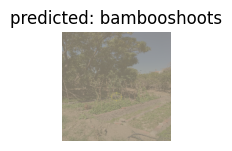

label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


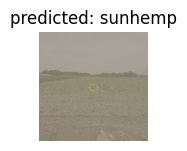

label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


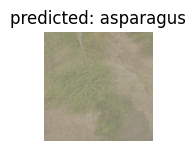

label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


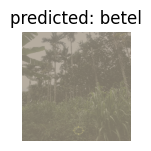

label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


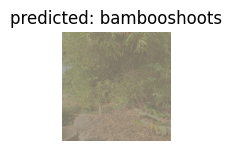

label:  tensor([29, 28,  0,  2,  1, 19, 16,  7, 28,  5], device='cuda:0')


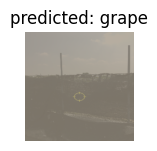

In [19]:
visualize_model(model_efficientnet)

plt.ioff()
plt.show()

In [20]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_efficientnet.state_dict():
    print(param_tensor, "\t", model_efficientnet.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer_conv.state_dict():
    print(var_name, "\t", optimizer_conv.state_dict()[var_name])

Model's state_dict:
features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.0.1.running_mean 	 torch.Size([32])
features.0.1.running_var 	 torch.Size([32])
features.0.1.num_batches_tracked 	 torch.Size([])
features.1.0.block.0.0.weight 	 torch.Size([32, 32, 3, 3])
features.1.0.block.0.1.weight 	 torch.Size([32])
features.1.0.block.0.1.bias 	 torch.Size([32])
features.1.0.block.0.1.running_mean 	 torch.Size([32])
features.1.0.block.0.1.running_var 	 torch.Size([32])
features.1.0.block.0.1.num_batches_tracked 	 torch.Size([])
features.1.1.block.0.0.weight 	 torch.Size([32, 32, 3, 3])
features.1.1.block.0.1.weight 	 torch.Size([32])
features.1.1.block.0.1.bias 	 torch.Size([32])
features.1.1.block.0.1.running_mean 	 torch.Size([32])
features.1.1.block.0.1.running_var 	 torch.Size([32])
features.1.1.block.0.1.num_batches_tracked 	 torch.Size([])
features.1.2.block.0.0.weight 	 torch.Size([32, 32, 3, 3])
features.1

features.3.3.block.0.1.running_mean 	 torch.Size([384])
features.3.3.block.0.1.running_var 	 torch.Size([384])
features.3.3.block.0.1.num_batches_tracked 	 torch.Size([])
features.3.3.block.1.0.weight 	 torch.Size([96, 384, 1, 1])
features.3.3.block.1.1.weight 	 torch.Size([96])
features.3.3.block.1.1.bias 	 torch.Size([96])
features.3.3.block.1.1.running_mean 	 torch.Size([96])
features.3.3.block.1.1.running_var 	 torch.Size([96])
features.3.3.block.1.1.num_batches_tracked 	 torch.Size([])
features.3.4.block.0.0.weight 	 torch.Size([384, 96, 3, 3])
features.3.4.block.0.1.weight 	 torch.Size([384])
features.3.4.block.0.1.bias 	 torch.Size([384])
features.3.4.block.0.1.running_mean 	 torch.Size([384])
features.3.4.block.0.1.running_var 	 torch.Size([384])
features.3.4.block.0.1.num_batches_tracked 	 torch.Size([])
features.3.4.block.1.0.weight 	 torch.Size([96, 384, 1, 1])
features.3.4.block.1.1.weight 	 torch.Size([96])
features.3.4.block.1.1.bias 	 torch.Size([96])
features.3.4.block.

features.4.5.block.0.1.num_batches_tracked 	 torch.Size([])
features.4.5.block.1.0.weight 	 torch.Size([768, 1, 3, 3])
features.4.5.block.1.1.weight 	 torch.Size([768])
features.4.5.block.1.1.bias 	 torch.Size([768])
features.4.5.block.1.1.running_mean 	 torch.Size([768])
features.4.5.block.1.1.running_var 	 torch.Size([768])
features.4.5.block.1.1.num_batches_tracked 	 torch.Size([])
features.4.5.block.2.fc1.weight 	 torch.Size([48, 768, 1, 1])
features.4.5.block.2.fc1.bias 	 torch.Size([48])
features.4.5.block.2.fc2.weight 	 torch.Size([768, 48, 1, 1])
features.4.5.block.2.fc2.bias 	 torch.Size([768])
features.4.5.block.3.0.weight 	 torch.Size([192, 768, 1, 1])
features.4.5.block.3.1.weight 	 torch.Size([192])
features.4.5.block.3.1.bias 	 torch.Size([192])
features.4.5.block.3.1.running_mean 	 torch.Size([192])
features.4.5.block.3.1.running_var 	 torch.Size([192])
features.4.5.block.3.1.num_batches_tracked 	 torch.Size([])
features.4.6.block.0.0.weight 	 torch.Size([768, 192, 1, 1]

features.5.2.block.0.1.num_batches_tracked 	 torch.Size([])
features.5.2.block.1.0.weight 	 torch.Size([1344, 1, 3, 3])
features.5.2.block.1.1.weight 	 torch.Size([1344])
features.5.2.block.1.1.bias 	 torch.Size([1344])
features.5.2.block.1.1.running_mean 	 torch.Size([1344])
features.5.2.block.1.1.running_var 	 torch.Size([1344])
features.5.2.block.1.1.num_batches_tracked 	 torch.Size([])
features.5.2.block.2.fc1.weight 	 torch.Size([56, 1344, 1, 1])
features.5.2.block.2.fc1.bias 	 torch.Size([56])
features.5.2.block.2.fc2.weight 	 torch.Size([1344, 56, 1, 1])
features.5.2.block.2.fc2.bias 	 torch.Size([1344])
features.5.2.block.3.0.weight 	 torch.Size([224, 1344, 1, 1])
features.5.2.block.3.1.weight 	 torch.Size([224])
features.5.2.block.3.1.bias 	 torch.Size([224])
features.5.2.block.3.1.running_mean 	 torch.Size([224])
features.5.2.block.3.1.running_var 	 torch.Size([224])
features.5.2.block.3.1.num_batches_tracked 	 torch.Size([])
features.5.3.block.0.0.weight 	 torch.Size([1344, 

features.5.9.block.1.1.running_mean 	 torch.Size([1344])
features.5.9.block.1.1.running_var 	 torch.Size([1344])
features.5.9.block.1.1.num_batches_tracked 	 torch.Size([])
features.5.9.block.2.fc1.weight 	 torch.Size([56, 1344, 1, 1])
features.5.9.block.2.fc1.bias 	 torch.Size([56])
features.5.9.block.2.fc2.weight 	 torch.Size([1344, 56, 1, 1])
features.5.9.block.2.fc2.bias 	 torch.Size([1344])
features.5.9.block.3.0.weight 	 torch.Size([224, 1344, 1, 1])
features.5.9.block.3.1.weight 	 torch.Size([224])
features.5.9.block.3.1.bias 	 torch.Size([224])
features.5.9.block.3.1.running_mean 	 torch.Size([224])
features.5.9.block.3.1.running_var 	 torch.Size([224])
features.5.9.block.3.1.num_batches_tracked 	 torch.Size([])
features.5.10.block.0.0.weight 	 torch.Size([1344, 224, 1, 1])
features.5.10.block.0.1.weight 	 torch.Size([1344])
features.5.10.block.0.1.bias 	 torch.Size([1344])
features.5.10.block.0.1.running_mean 	 torch.Size([1344])
features.5.10.block.0.1.running_var 	 torch.Siz

features.5.16.block.0.1.weight 	 torch.Size([1344])
features.5.16.block.0.1.bias 	 torch.Size([1344])
features.5.16.block.0.1.running_mean 	 torch.Size([1344])
features.5.16.block.0.1.running_var 	 torch.Size([1344])
features.5.16.block.0.1.num_batches_tracked 	 torch.Size([])
features.5.16.block.1.0.weight 	 torch.Size([1344, 1, 3, 3])
features.5.16.block.1.1.weight 	 torch.Size([1344])
features.5.16.block.1.1.bias 	 torch.Size([1344])
features.5.16.block.1.1.running_mean 	 torch.Size([1344])
features.5.16.block.1.1.running_var 	 torch.Size([1344])
features.5.16.block.1.1.num_batches_tracked 	 torch.Size([])
features.5.16.block.2.fc1.weight 	 torch.Size([56, 1344, 1, 1])
features.5.16.block.2.fc1.bias 	 torch.Size([56])
features.5.16.block.2.fc2.weight 	 torch.Size([1344, 56, 1, 1])
features.5.16.block.2.fc2.bias 	 torch.Size([1344])
features.5.16.block.3.0.weight 	 torch.Size([224, 1344, 1, 1])
features.5.16.block.3.1.weight 	 torch.Size([224])
features.5.16.block.3.1.bias 	 torch.Si

features.6.3.block.3.1.running_var 	 torch.Size([384])
features.6.3.block.3.1.num_batches_tracked 	 torch.Size([])
features.6.4.block.0.0.weight 	 torch.Size([2304, 384, 1, 1])
features.6.4.block.0.1.weight 	 torch.Size([2304])
features.6.4.block.0.1.bias 	 torch.Size([2304])
features.6.4.block.0.1.running_mean 	 torch.Size([2304])
features.6.4.block.0.1.running_var 	 torch.Size([2304])
features.6.4.block.0.1.num_batches_tracked 	 torch.Size([])
features.6.4.block.1.0.weight 	 torch.Size([2304, 1, 3, 3])
features.6.4.block.1.1.weight 	 torch.Size([2304])
features.6.4.block.1.1.bias 	 torch.Size([2304])
features.6.4.block.1.1.running_mean 	 torch.Size([2304])
features.6.4.block.1.1.running_var 	 torch.Size([2304])
features.6.4.block.1.1.num_batches_tracked 	 torch.Size([])
features.6.4.block.2.fc1.weight 	 torch.Size([96, 2304, 1, 1])
features.6.4.block.2.fc1.bias 	 torch.Size([96])
features.6.4.block.2.fc2.weight 	 torch.Size([2304, 96, 1, 1])
features.6.4.block.2.fc2.bias 	 torch.Size

features.6.10.block.2.fc1.bias 	 torch.Size([96])
features.6.10.block.2.fc2.weight 	 torch.Size([2304, 96, 1, 1])
features.6.10.block.2.fc2.bias 	 torch.Size([2304])
features.6.10.block.3.0.weight 	 torch.Size([384, 2304, 1, 1])
features.6.10.block.3.1.weight 	 torch.Size([384])
features.6.10.block.3.1.bias 	 torch.Size([384])
features.6.10.block.3.1.running_mean 	 torch.Size([384])
features.6.10.block.3.1.running_var 	 torch.Size([384])
features.6.10.block.3.1.num_batches_tracked 	 torch.Size([])
features.6.11.block.0.0.weight 	 torch.Size([2304, 384, 1, 1])
features.6.11.block.0.1.weight 	 torch.Size([2304])
features.6.11.block.0.1.bias 	 torch.Size([2304])
features.6.11.block.0.1.running_mean 	 torch.Size([2304])
features.6.11.block.0.1.running_var 	 torch.Size([2304])
features.6.11.block.0.1.num_batches_tracked 	 torch.Size([])
features.6.11.block.1.0.weight 	 torch.Size([2304, 1, 3, 3])
features.6.11.block.1.1.weight 	 torch.Size([2304])
features.6.11.block.1.1.bias 	 torch.Size([

features.6.17.block.0.1.running_var 	 torch.Size([2304])
features.6.17.block.0.1.num_batches_tracked 	 torch.Size([])
features.6.17.block.1.0.weight 	 torch.Size([2304, 1, 3, 3])
features.6.17.block.1.1.weight 	 torch.Size([2304])
features.6.17.block.1.1.bias 	 torch.Size([2304])
features.6.17.block.1.1.running_mean 	 torch.Size([2304])
features.6.17.block.1.1.running_var 	 torch.Size([2304])
features.6.17.block.1.1.num_batches_tracked 	 torch.Size([])
features.6.17.block.2.fc1.weight 	 torch.Size([96, 2304, 1, 1])
features.6.17.block.2.fc1.bias 	 torch.Size([96])
features.6.17.block.2.fc2.weight 	 torch.Size([2304, 96, 1, 1])
features.6.17.block.2.fc2.bias 	 torch.Size([2304])
features.6.17.block.3.0.weight 	 torch.Size([384, 2304, 1, 1])
features.6.17.block.3.1.weight 	 torch.Size([384])
features.6.17.block.3.1.bias 	 torch.Size([384])
features.6.17.block.3.1.running_mean 	 torch.Size([384])
features.6.17.block.3.1.running_var 	 torch.Size([384])
features.6.17.block.3.1.num_batches_t

features.6.24.block.0.1.weight 	 torch.Size([2304])
features.6.24.block.0.1.bias 	 torch.Size([2304])
features.6.24.block.0.1.running_mean 	 torch.Size([2304])
features.6.24.block.0.1.running_var 	 torch.Size([2304])
features.6.24.block.0.1.num_batches_tracked 	 torch.Size([])
features.6.24.block.1.0.weight 	 torch.Size([2304, 1, 3, 3])
features.6.24.block.1.1.weight 	 torch.Size([2304])
features.6.24.block.1.1.bias 	 torch.Size([2304])
features.6.24.block.1.1.running_mean 	 torch.Size([2304])
features.6.24.block.1.1.running_var 	 torch.Size([2304])
features.6.24.block.1.1.num_batches_tracked 	 torch.Size([])
features.6.24.block.2.fc1.weight 	 torch.Size([96, 2304, 1, 1])
features.6.24.block.2.fc1.bias 	 torch.Size([96])
features.6.24.block.2.fc2.weight 	 torch.Size([2304, 96, 1, 1])
features.6.24.block.2.fc2.bias 	 torch.Size([2304])
features.6.24.block.3.0.weight 	 torch.Size([384, 2304, 1, 1])
features.6.24.block.3.1.weight 	 torch.Size([384])
features.6.24.block.3.1.bias 	 torch.Si

features.7.5.block.3.1.running_var 	 torch.Size([640])
features.7.5.block.3.1.num_batches_tracked 	 torch.Size([])
features.7.6.block.0.0.weight 	 torch.Size([3840, 640, 1, 1])
features.7.6.block.0.1.weight 	 torch.Size([3840])
features.7.6.block.0.1.bias 	 torch.Size([3840])
features.7.6.block.0.1.running_mean 	 torch.Size([3840])
features.7.6.block.0.1.running_var 	 torch.Size([3840])
features.7.6.block.0.1.num_batches_tracked 	 torch.Size([])
features.7.6.block.1.0.weight 	 torch.Size([3840, 1, 3, 3])
features.7.6.block.1.1.weight 	 torch.Size([3840])
features.7.6.block.1.1.bias 	 torch.Size([3840])
features.7.6.block.1.1.running_mean 	 torch.Size([3840])
features.7.6.block.1.1.running_var 	 torch.Size([3840])
features.7.6.block.1.1.num_batches_tracked 	 torch.Size([])
features.7.6.block.2.fc1.weight 	 torch.Size([160, 3840, 1, 1])
features.7.6.block.2.fc1.bias 	 torch.Size([160])
features.7.6.block.2.fc2.weight 	 torch.Size([3840, 160, 1, 1])
features.7.6.block.2.fc2.bias 	 torch.S

In [22]:
efficientnet_path_state_dict = str(output_path + "./ALL_efficientnet_model_dict.pkl")
torch.save(model_efficientnet.state_dict(), efficientnet_path_state_dict)  # 只保存模型猜數

In [23]:
efficientnet_path_model = str(output_path + "./ALL_efficientnet_model.pkl")
torch.save(model_efficientnet, efficientnet_path_model)  # 保存整個模型